In [1]:
%run ~/.python/init.ipynb

In [2]:
from matplotlib.lines import Line2D
import PIL
import torch

In [3]:
# FONTSIZE = 10
# TEXTWIDTH = 397.48

# sns.set_style("ticks", {"xtick.major.size": FONTSIZE, "ytick.major.size": FONTSIZE})
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=FONTSIZE)
# params = {'text.latex.preamble': "\n".join([r'\usepackage{siunitx}',
#                                   r'\usepackage{amsfonts,amsmath,amssymb,amsthm}',
#                                   (r'\sisetup{round-mode = places, round-precision = 2,' +
#                                    r'zero-decimal-to-integer}'),
#                                   r'\usepackage{bm}',
#                                   r'\usepackage[utf8]{inputenc}']),
#           'legend.fontsize': FONTSIZE,
#           'xtick.labelsize': FONTSIZE, 'ytick.labelsize': FONTSIZE, 'axes.labelsize': FONTSIZE}
# plt.rcParams.update(params)

In [4]:
from parallel import pmap

In [5]:
path = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/')
arrs = [np.load(p)[:, :2] for p in path.glob("coords*npy")]

In [6]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(idx, frames, zoom=1):
    return OffsetImage(PIL.Image.fromarray(frames[idx]), zoom=zoom)

def read_gif(filename):
    """ readGif(filename, asNumpy=True)
    
    Read images from an animated GIF file.  Returns a list of numpy 
    arrays, or, if asNumpy is false, a list if PIL images.
    
    """
    # Load file using PIL
    pilIm = PIL.Image.open(filename)    
    pilIm.seek(0)
    
    # Read all images inside
    images = []
    try:
        while True:
            # Get image as numpy array
            tmp = pilIm.convert() # Make without palette
            a = np.asarray(tmp)
            if len(a.shape)==0:
                raise MemoryError("Too little memory to convert PIL image to array")
            # Store, and next
            images.append(a)
            pilIm.seek(pilIm.tell()+1)
    except EOFError:
        pass
    
    # Done
    return images 

In [49]:
all_paths = sorted(Path('./sampled_videos/carla-samples/not-goal-directed/').glob("*/*npy"))

In [61]:
selected_paths = [
    "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0007-0_pred.npy",
    "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0004-0_pred.npy",
#     "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0005-0_pred.npy"
]
selected_path_frames = [
    [0, 110, 140, 170, 180, 190, 999],
    [0, 600, 650, 700, 720, 750, 999],
]

In [69]:
def make_overlay(paths, frames, with_map=True):

    scale = 1.5
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4/scale, 3/scale))

    if with_map:
        for idx, arr in enumerate(arrs[::2]):
            ax = sns.lineplot(x=-arr[::20,0], # plot every 20th
                              y=arr[::20,1], # plot every 20th
                              sort=False,
                              color='black',
                             zorder=1,
    #                           alpha=0.25,
                              lw=1,
                              ax=ax,
                              legend=False,
                             )


#     frames = [0, 333, 666, 999]
#     x, y = out[frames][:,0], out[frames][:,1]
#     for x0, y0, frame in zip(x, y, frames):
#         ab = AnnotationBbox(getImage(frame, 0.15), 
#                             (-x0, y0), 
#                             frameon=True,
#                             pad=0.01
#                            )
#         ax.add_artist(ab)

#     cmap = sns.color_palette("coolwarm", as_cmap=True)
    pal = sns.color_palette()
    obs_col = pal[0]
    samp_col = pal[3]

    for idx, path in enumerate(paths):
        out = np.load(path)[:1000]
        gif = read_gif(Path(str(path).replace("_pred.npy",".gif")))
        npoints = out.shape[0]    
    
#         x, y, hue = out[:, 0], out[:,1], [0]*36 + [1]*(1000-36)
#         ax = sns.scatterplot(
#             x=-x[::-1],
#             y=y[::-1],
#             hue=hue[::-1],
#             palette=[obs_col, samp_col],
#             ax=ax,
#             marker='s',
#             zorder=2,
#             alpha=1,
#             label="location",
#             edgecolor="none",
#             legend=False
#         )
        
        x, y, hue = out[36:, 0], out[36:,1], np.arange(1000-36)
        cmap = sns.light_palette("red", as_cmap=True)
#         cmap = sns.color_palette("coolwarm", as_cmap=True)
        ax = sns.scatterplot(
            x=-x,
            y=y,
            hue=hue,
            palette=cmap,
            ax=ax,
            marker='s',
            zorder=2,
            alpha=1,
            label="location",
            edgecolor="none",
            legend=False
        )
        
        x, y, hue = out[:36, 0], out[:36,1], [0]*36
        ax = sns.scatterplot(
            x=-x[::-1],
            y=y[::-1],
            hue=hue[::-1],
            palette=[obs_col],
            ax=ax,
            marker='*',
            zorder=2,
            alpha=1,
            label="location",
            edgecolor="none",
            legend=False
        )
        
        
        
        x, y = out[:, 0], out[:,1]
#         plt.annotate(idx+1, (-x[0]+20, y[0]+20))
        
        for frame in frames[idx]:
            ax = sns.scatterplot(
                x=-x[[frame]],
                y=y[[frame]],
                
                ax=ax,
                alpha=1,
                edgecolor="none",
                color="black", 
                marker="x",
                zorder=3,
                s=200,
                legend=False
            )
        

        xlim = (-410, 10)
        ylim = (-40, 350)
                
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        

    custom = [Line2D([], [], marker='s', color=obs_col, linestyle='None'),
              Line2D([], [], marker='s', color=samp_col, linestyle='None'),
              Line2D([], [], marker='.', color='black', linestyle='None'),
             ]

#     plt.legend(custom, 
#                ['Observed', 'Sampled', 'Displayed'], 
#               ncol=1,
#               loc='center right',
# #               loc='lower center',
#                bbox_to_anchor=(0.5, -0.5),
#                bbox_transform=plt.gcf().transFigure,
#               )

    plt.axis('off')
#     plt.tight_layout()
    plt.savefig('map.pdf') 
    plt.show()

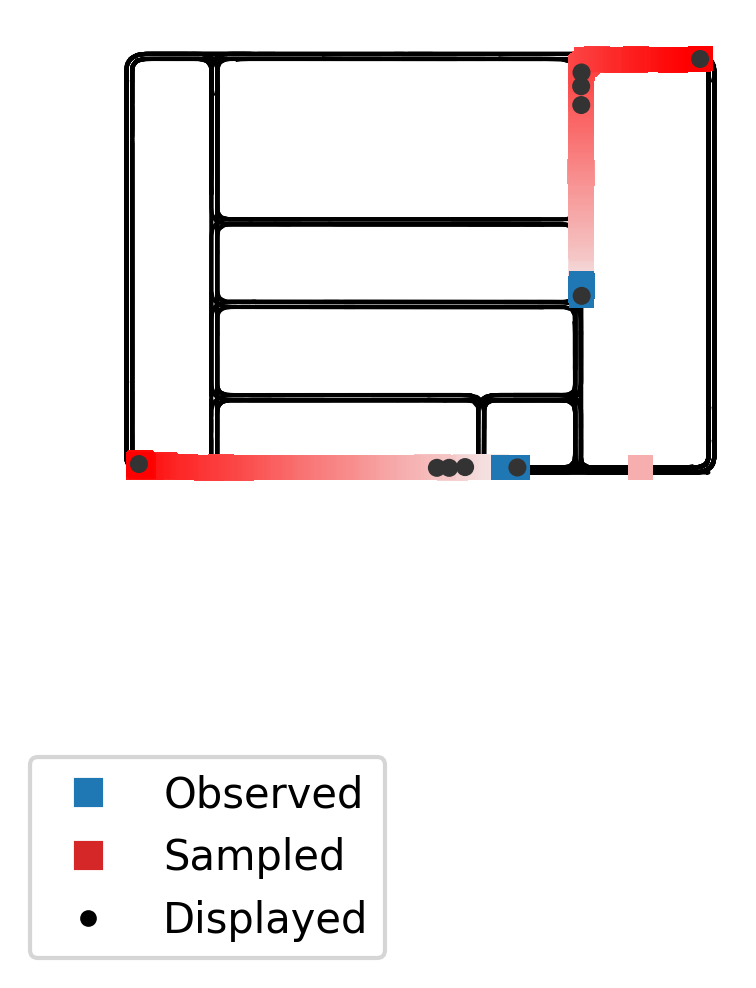

In [70]:
make_overlay(selected_paths, selected_path_frames)

In [52]:
gif0 = read_gif(str(selected_paths[0]).replace("_pred.npy",".gif"))
gif1 = read_gif(str(selected_paths[1]).replace("_pred.npy",".gif"))

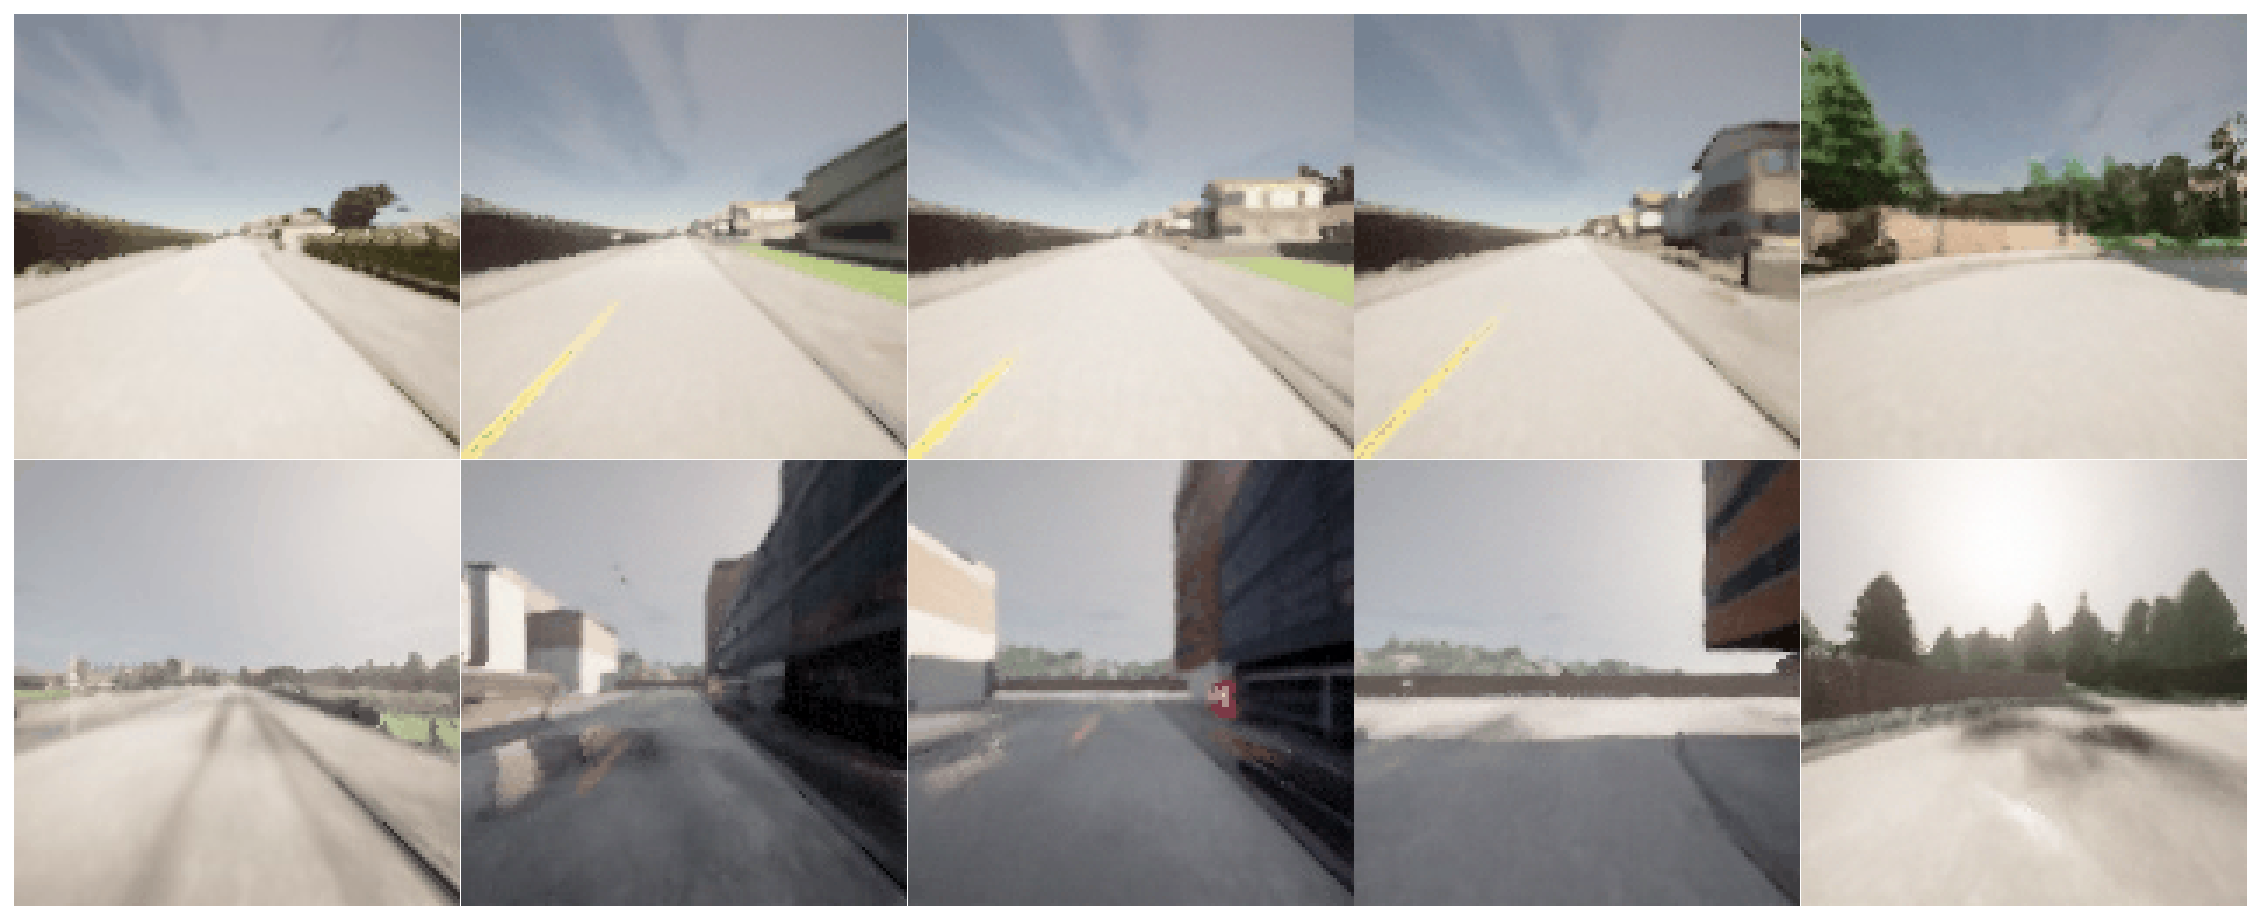

In [64]:
selected_paths = [
    "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0007-0_pred.npy",
    "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0004-0_pred.npy",
#     "sampled_videos/carla-samples/not-goal-directed/autoreg/sample_0005-0_pred.npy"
]
selected_path_frames = [
    [0, 110, 140, 170, 180, 190, 999],
    [0, 600, 650, 700, 720, 750, 999],
]

display_frames = [gif0[f] for f in selected_path_frames[0]]
display_frames += [gif1[f] for f in selected_path_frames[1]]

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 7),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

for idx, (ax, im) in enumerate(zip(grid, display_frames)):
    # Iterating over the grid returns the Axes.
#     if idx == 0:
#         ax.text(10,10,'1',ha='center',fontsize=20, va='center')
#     if idx == 5:
#         ax.text(10,10,'2',ha='center',fontsize=20, va='center')
    ax.imshow(im)
    ax.set_axis_off()

# plt.axis('off')
fig.show()
plt.savefig('image_grid.pdf')  

In [ ]:
# def pplot(i):
#     plot_trajectory(out[[i]], save_path=gif_path / f"{i}.jpg")

all_paths = sorted(Path('./sampled_videos/carla-samples/not-goal-directed/').glob("*/*npy"))


for p in all_paths[4:5]:
    out = np.load(p)
    gif_path = Path(str(p).replace("_pred.npy", '_scatter'))
    gif_path.mkdir(parents=True, exist_ok=True)
    pmap(pplot, range(out.shape[0]))

In [104]:
path = all_paths[4]
out = np.load(path)[:1000]

In [105]:
out

array([[ 87.92139  , 138.33542  ],
       [ 87.77025  , 138.7463   ],
       [ 87.85091  , 138.54385  ],
       ...,
       [  9.309461 , 326.06     ],
       [  8.587722 , 326.16907  ],
       [  7.6602783, 326.56604  ]], dtype=float32)

In [112]:
def plot_gt(arr, title):
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
    ax = sns.lineplot(x=-arr[::20,0], # plot every 20th
                      y=arr[::20,1], # plot every 20th
                      sort=False,
                      color='gray',
                      alpha=0.5,
                      lw=0.5,
                      ax=ax,
                      legend=False,
                     )
    print(title)
    xlim = (-410, 10)
    ylim = (-10, 350)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.show()
    

In [230]:
selected_gt = [
    "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_8.npy",
    "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_146.npy",
    "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_74.npy",               
    "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_448.npy",
    "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_432.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_312.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_427.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_99.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_161.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_121.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_112.npy",
# "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_444.npy"
              ]

In [265]:
def get_gt_frames(coord_path):
    video = torch.load(str(coord_path)
     .replace("coords_","video_")
     .replace(".npy",".pt")
    ).numpy()
    return [video[i] for i in range(video.shape[0])]

In [269]:
selected_gt_frame_map = {
 '/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_8.npy':
    [0, 333, 666, 999],
 '/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_146.npy':
    [666, 999],
 '/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_74.npy':
    [600, 999],
 '/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_448.npy':
    [0, 333, 666, 999],
 '/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_432.npy':
    [999],
}

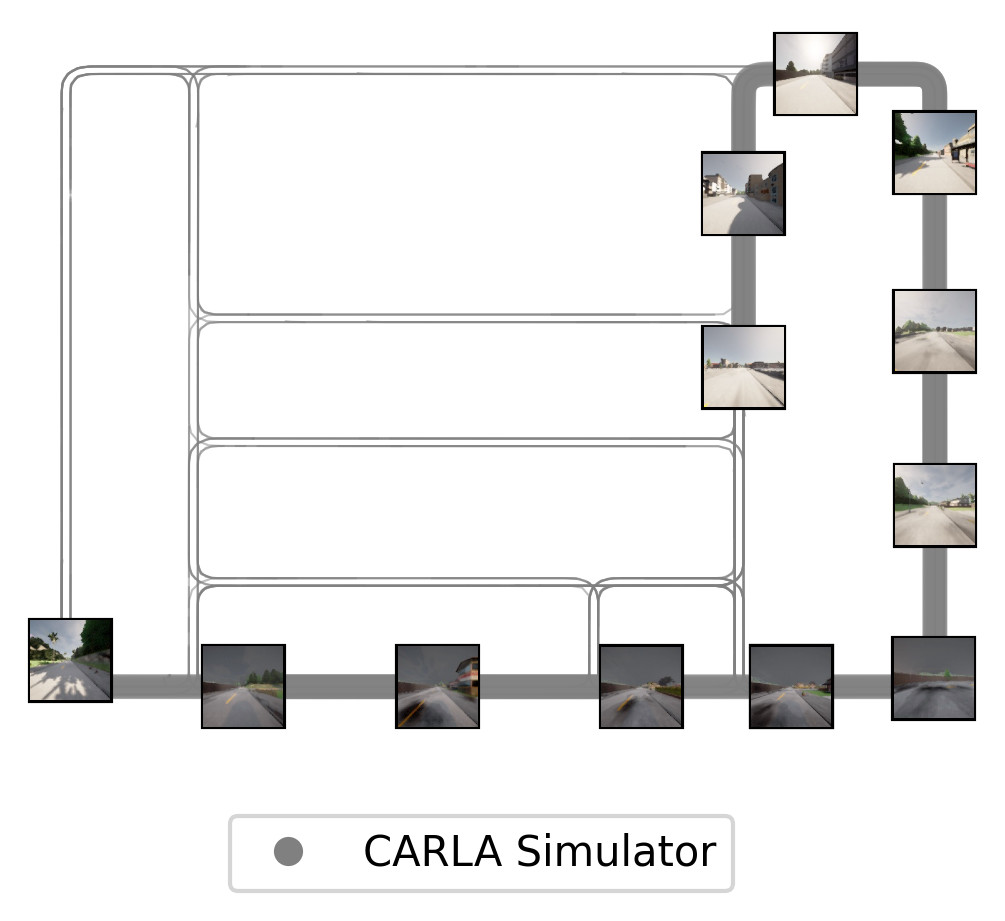

In [272]:
path = "/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_8.npy"

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))

for idx, arr in enumerate(arrs[::2]):
    ax = sns.lineplot(x=-arr[::20,0], # plot every 20th
                      y=arr[::20,1], # plot every 20th
                      sort=False,
                      color='gray',
                      alpha=0.5,
                      lw=0.5,
                      ax=ax,
                      legend=False,
                     )


for idx, path in enumerate(selected_gt):
    out = np.load(path)
    gt_frames = get_gt_frames(path)
    x, y = out[:, 0], out[:,1]

    ax = sns.scatterplot(
        x=-x,
        y=y,
        color='gray',
        ax=ax,
        alpha=0.1,
        label="location",
        edgecolor="none",
        legend=False
    )
    
    if idx < 5:
        frames = selected_gt_frame_map[path]
        x, y = out[frames][:,0], out[frames][:,1]

        for x0, y0, frame in zip(x, y, frames):
            ab = AnnotationBbox(getImage(frame, gt_frames, 0.15), 
                                (-x0, y0), 
                                frameon=True,
                                pad=0.01
                               )
            ax.add_artist(ab)


xlim = (-410, 10)
ylim = (-10, 350)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

custom = [Line2D([], [], marker='o', color='gray', linestyle='None'),]

plt.legend(custom, 
           ['CARLA Simulator'], 
#                loc='lower right',
          ncol=1,
          loc='lower center',
           bbox_to_anchor=(0.5, -0.1),
           bbox_transform=plt.gcf().transFigure
          )

plt.axis('off')
plt.show()

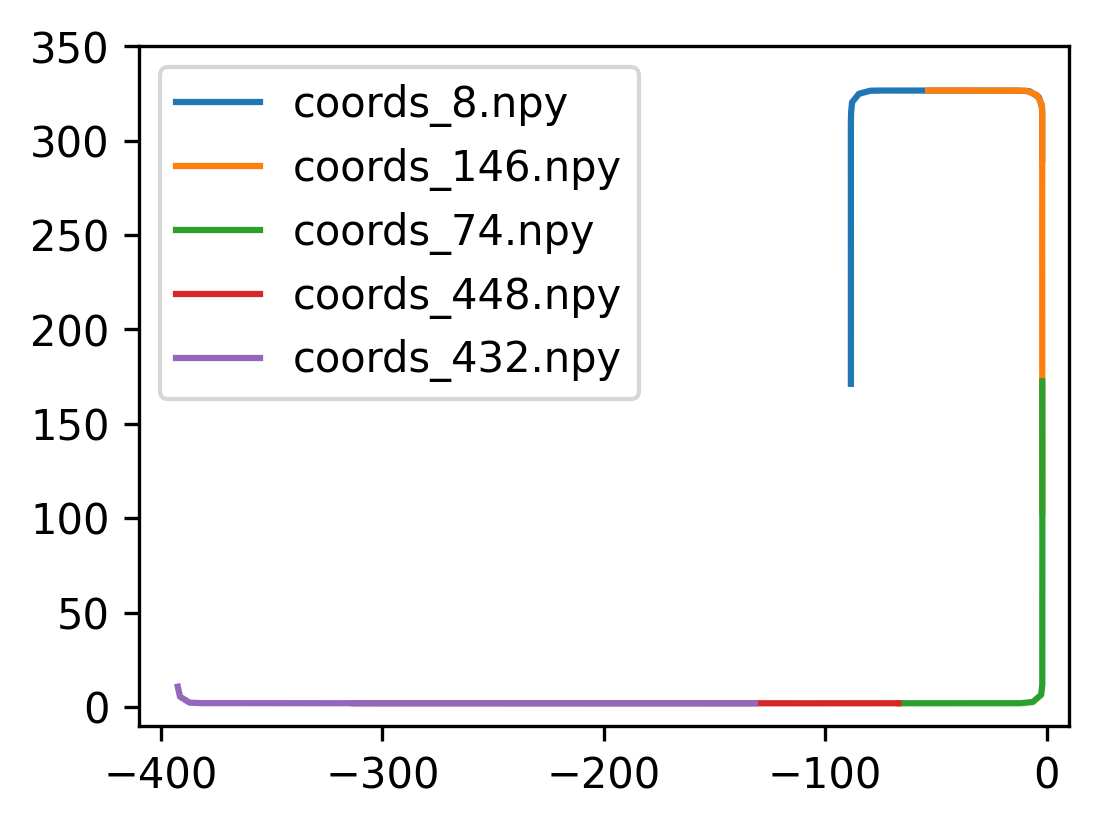

In [167]:
path = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/')
ground_truth = {p:np.load(p)[:, :2] for p in selected_gt}
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
for k, v in ground_truth.items():
    ax = sns.lineplot(x=-v[::20,0], # plot every 20th
                      y=v[::20,1], # plot every 20th
                      sort=False,
#                       color='gray',
#                       alpha=0.5,
#                       lw=0.5,
                      ax=ax,
                      label=k.split("/")[-1],
#                       legend=False,
                     )
xlim = (-410, 10)
ylim = (-10, 350)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()


/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_527.npy


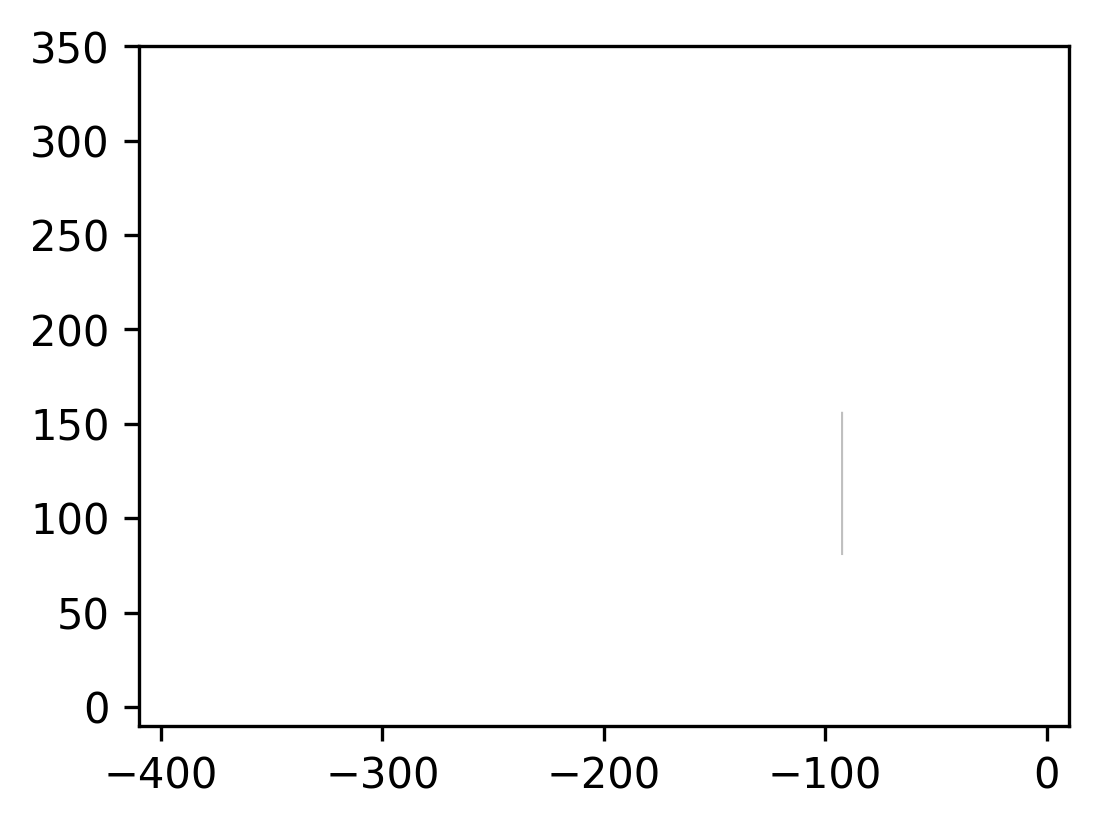

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_456.npy


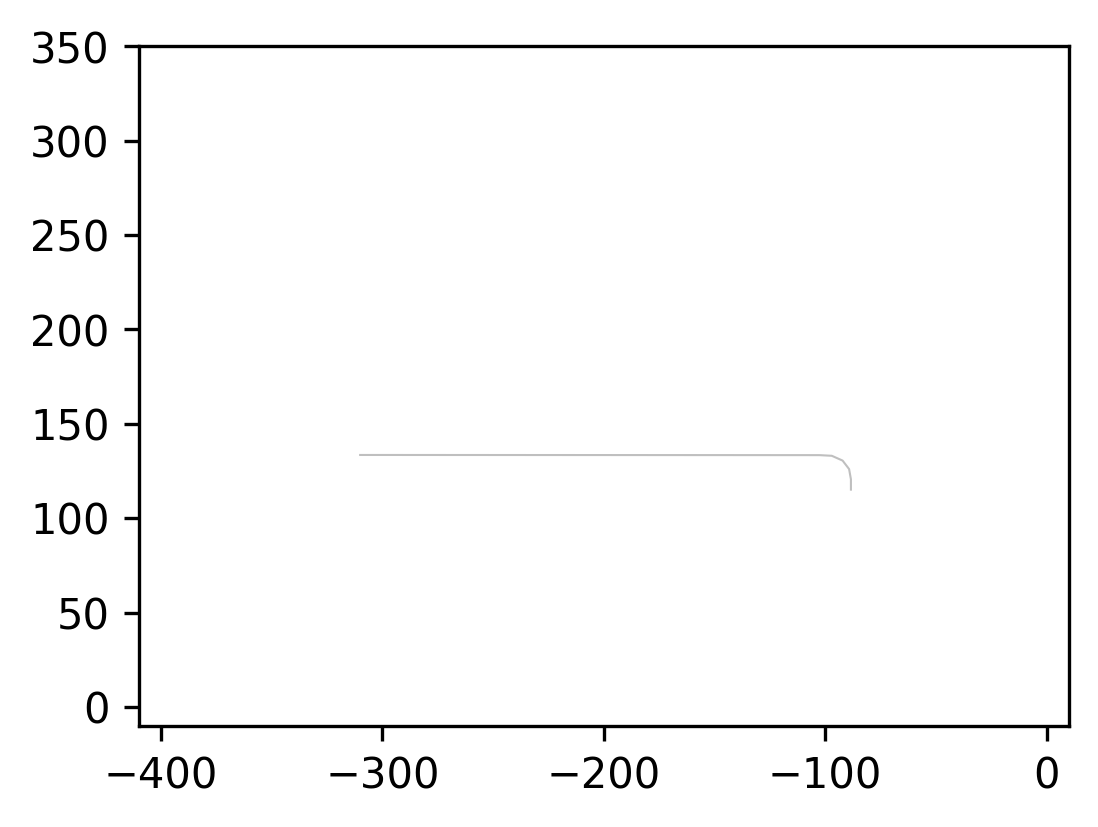

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_107.npy


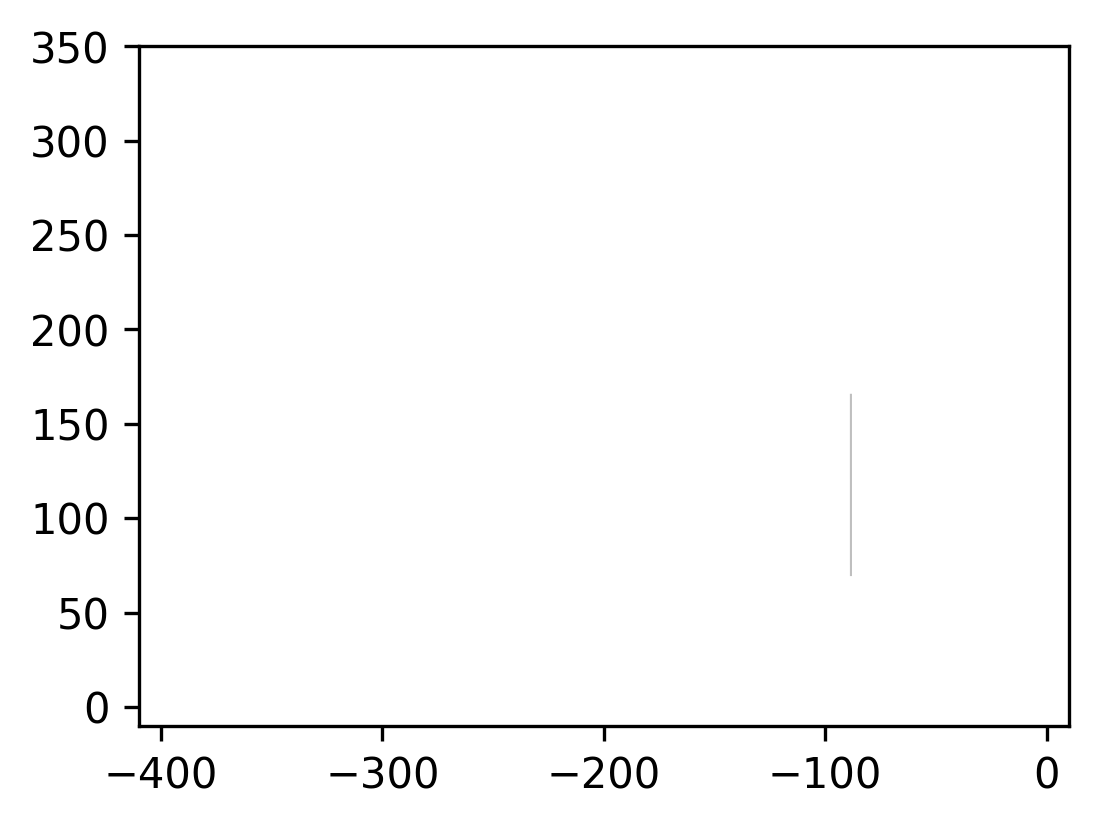

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_339.npy


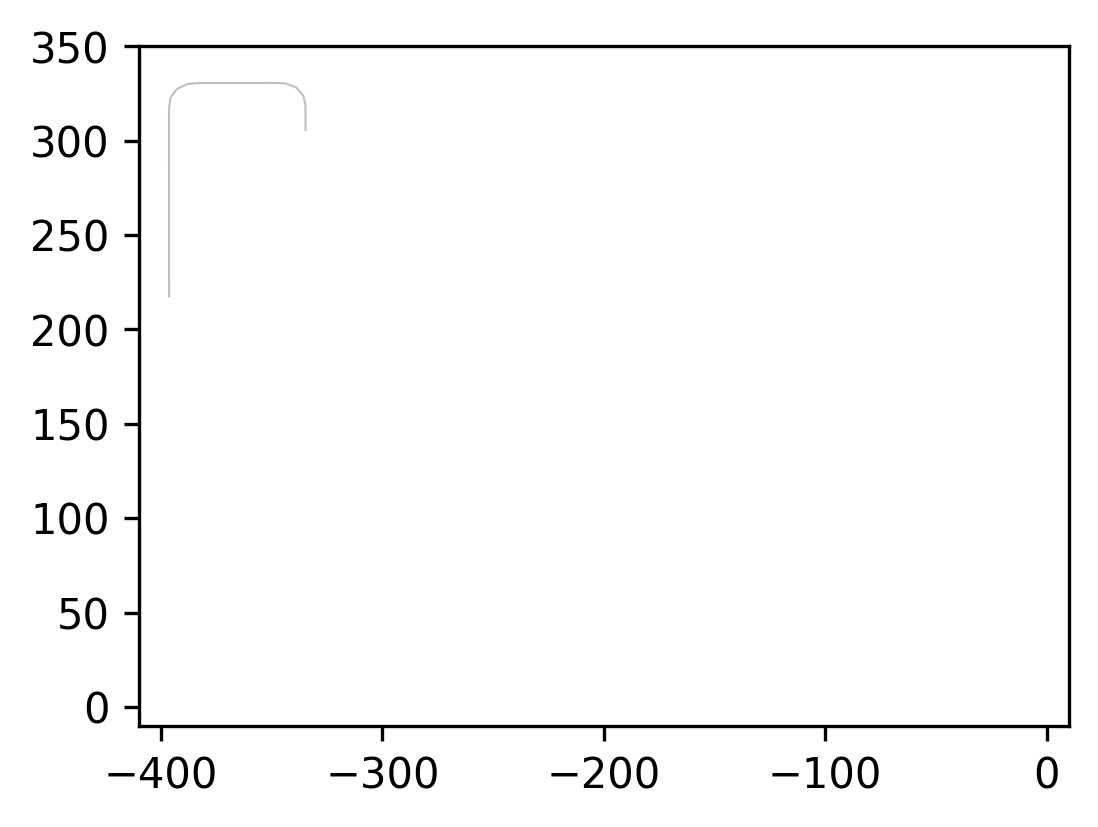

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_8.npy


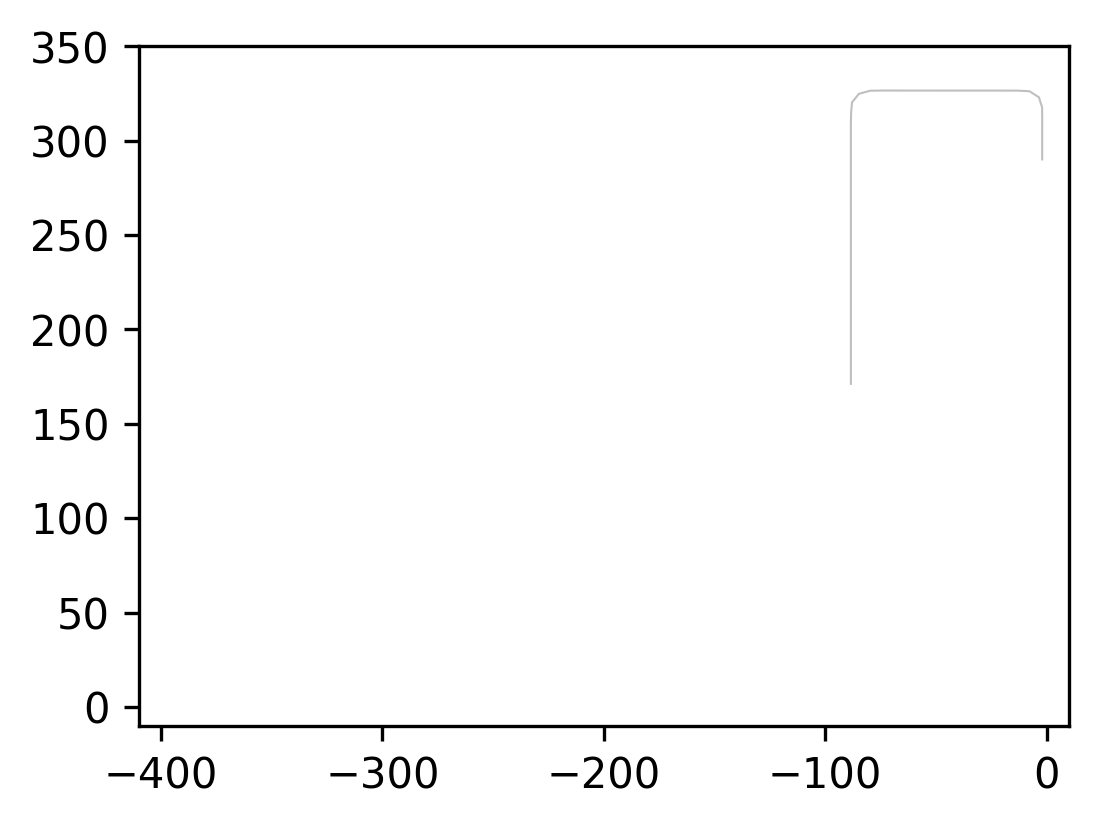

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_129.npy


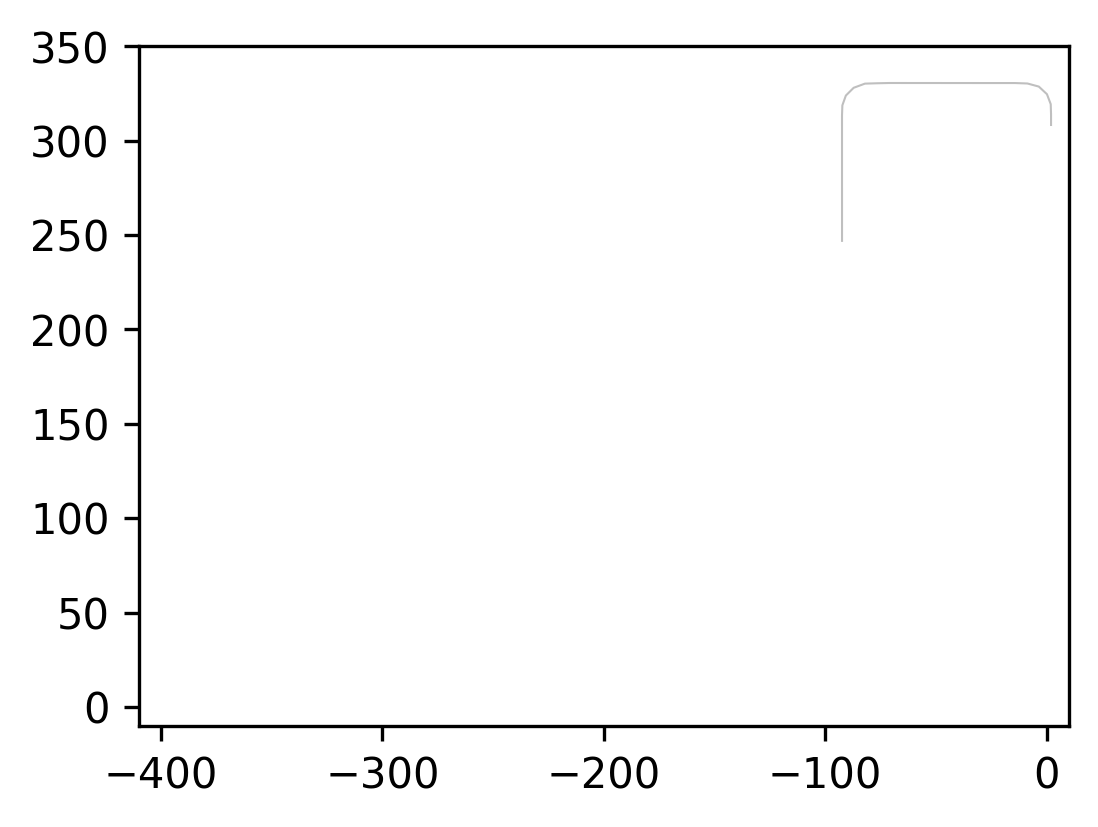

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_146.npy


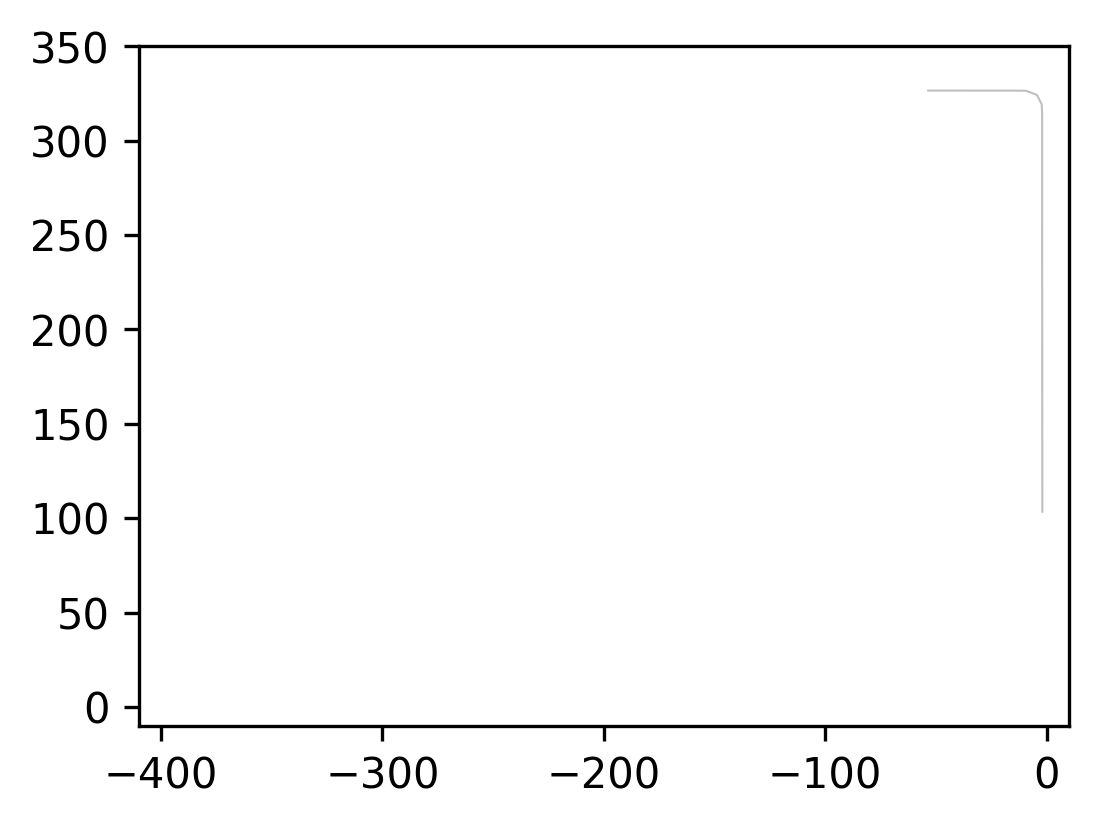

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_49.npy


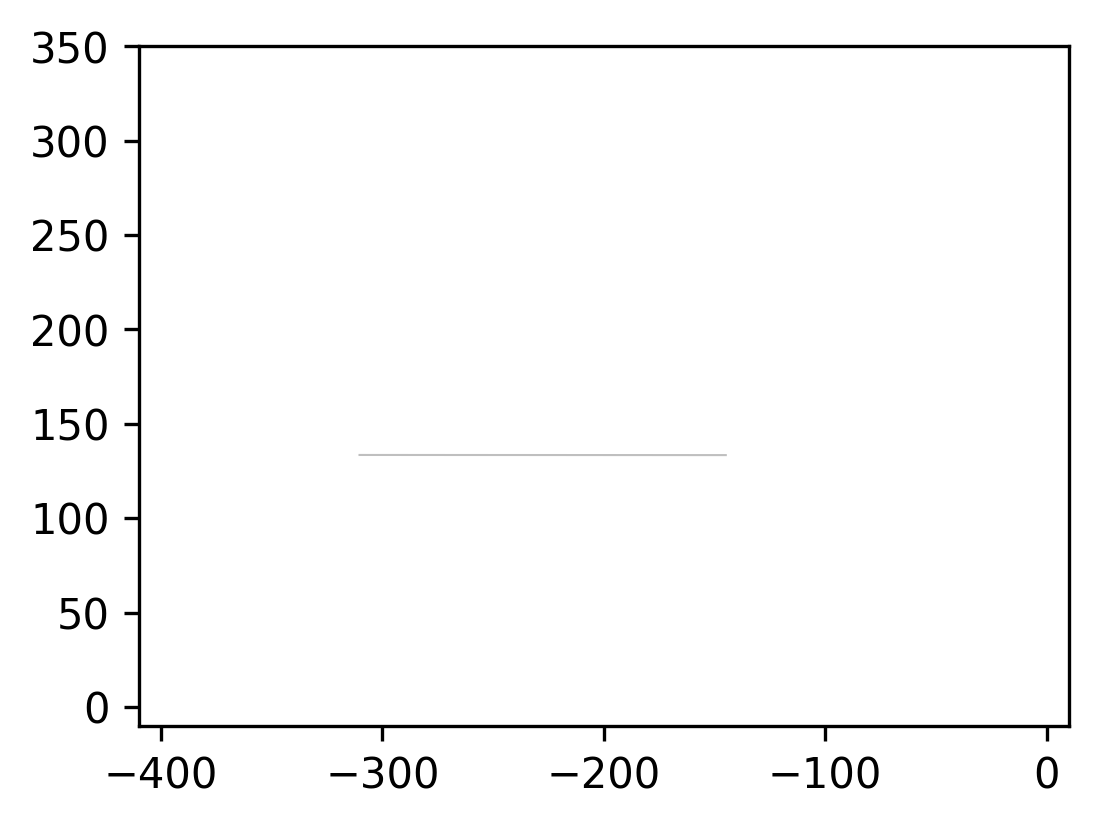

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_74.npy


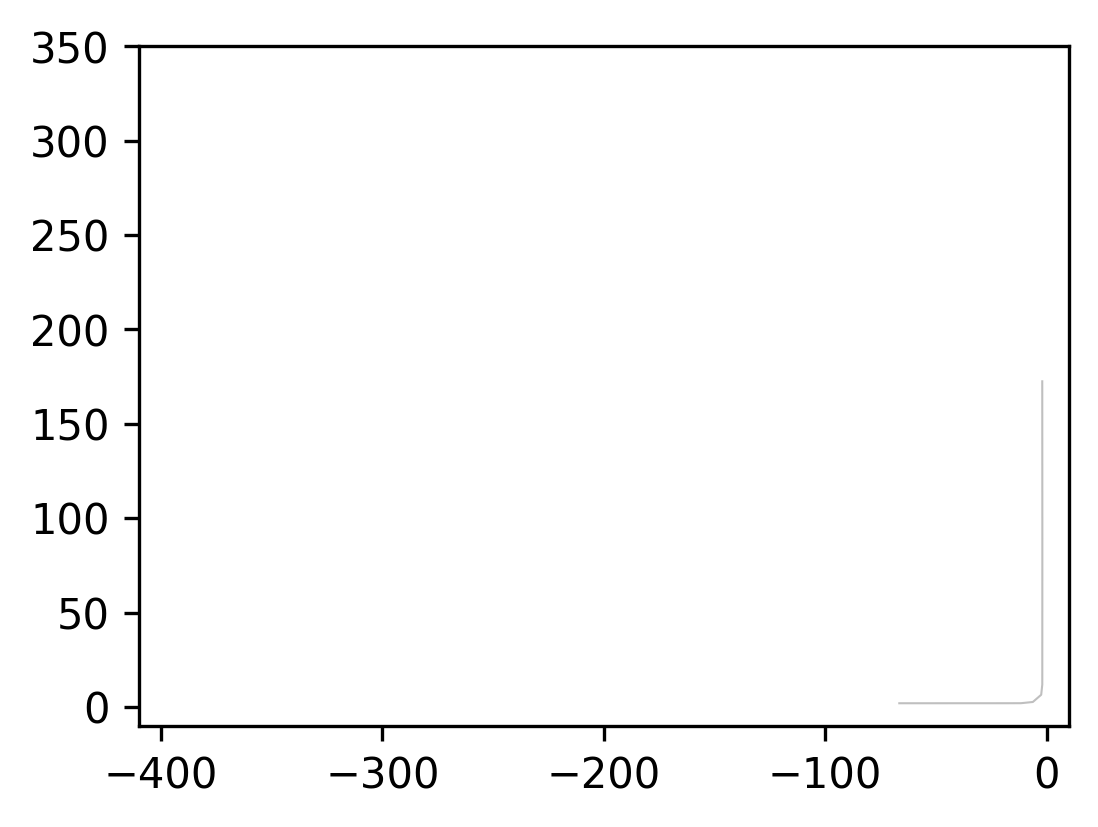

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_451.npy


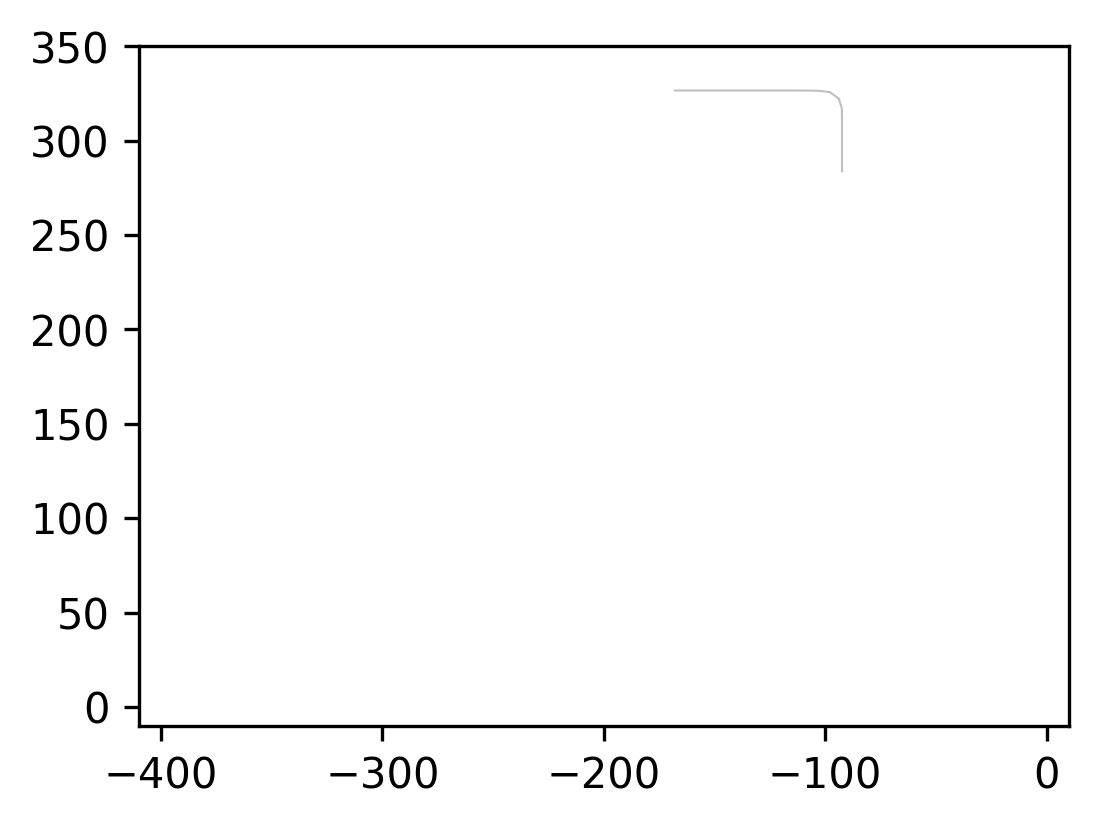

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_431.npy


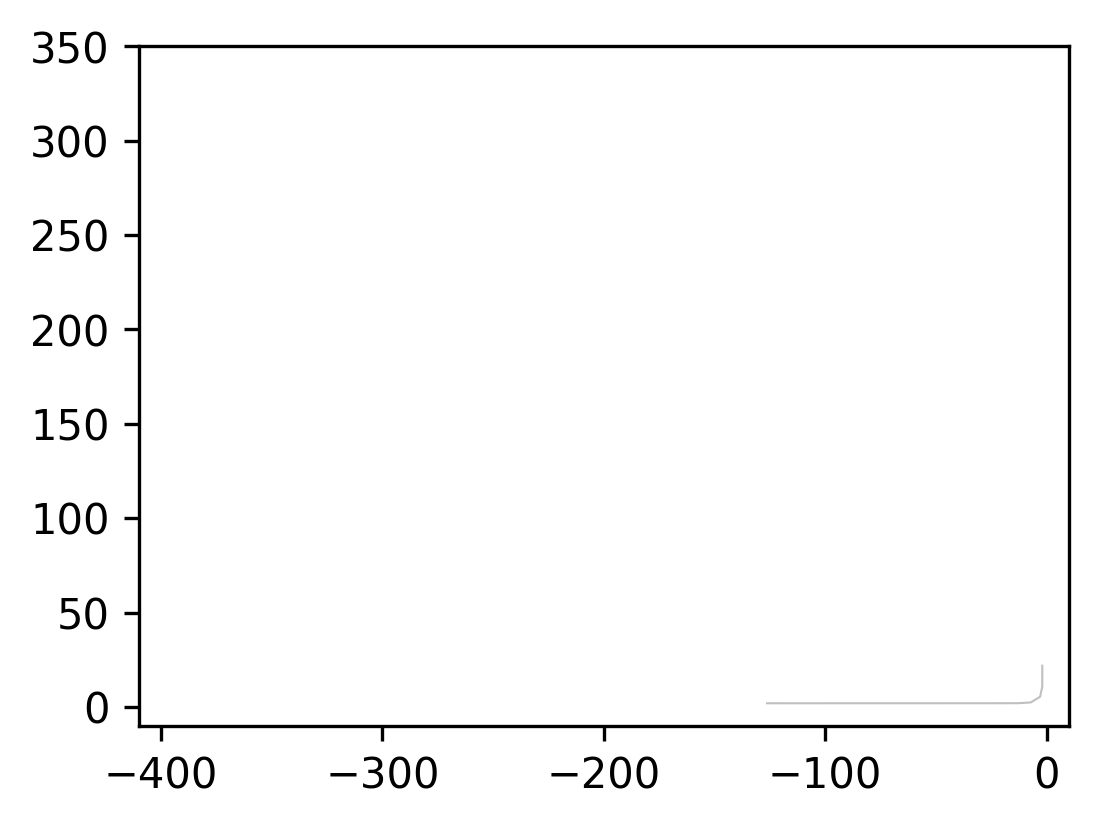

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_349.npy


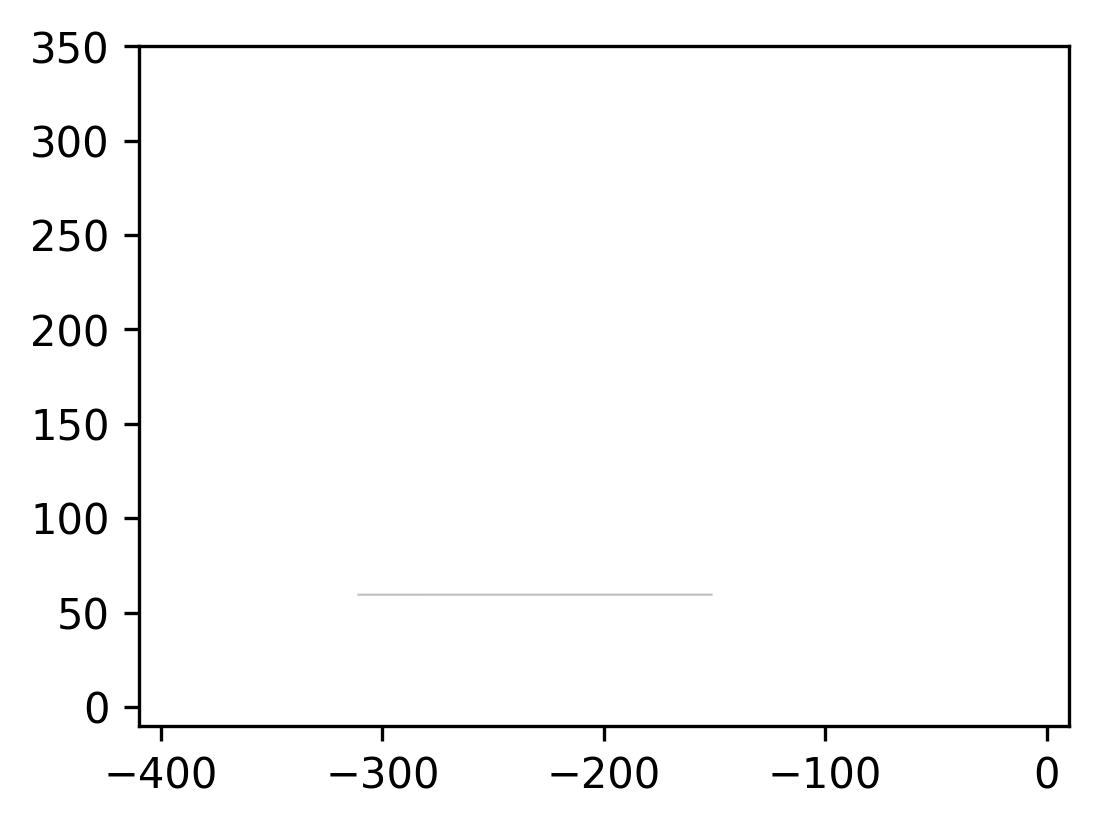

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_285.npy


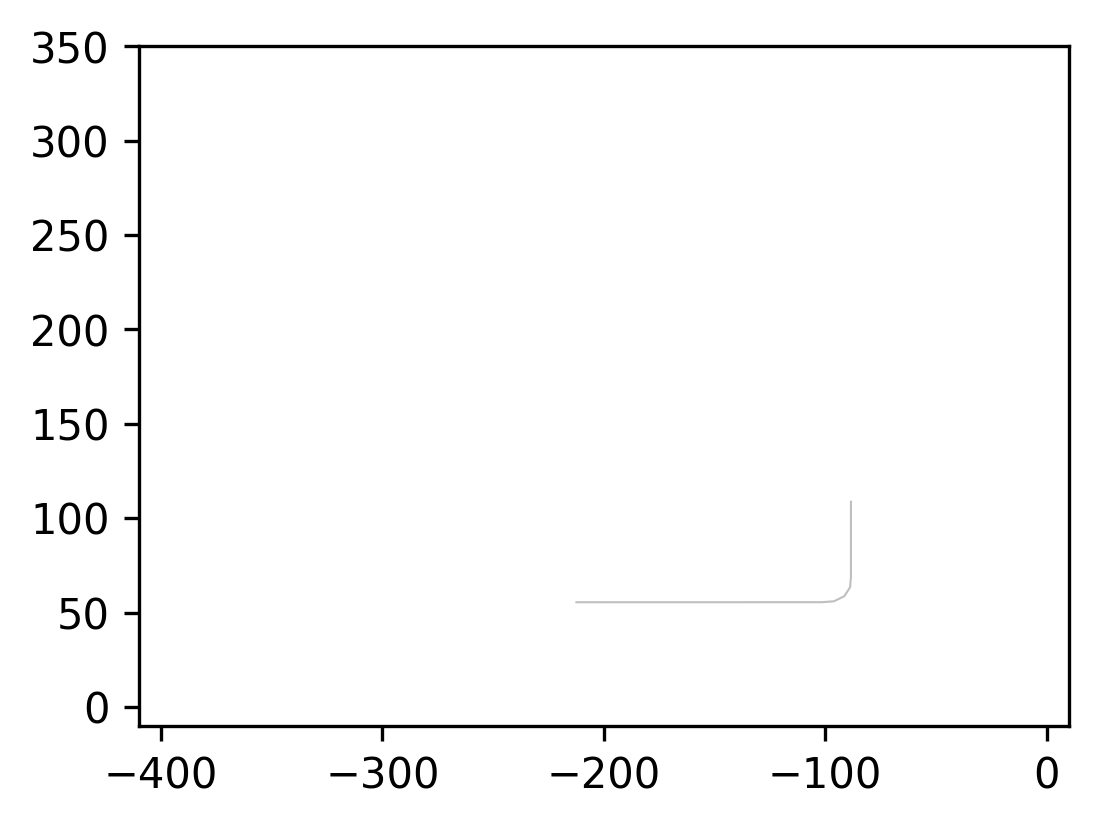

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_353.npy


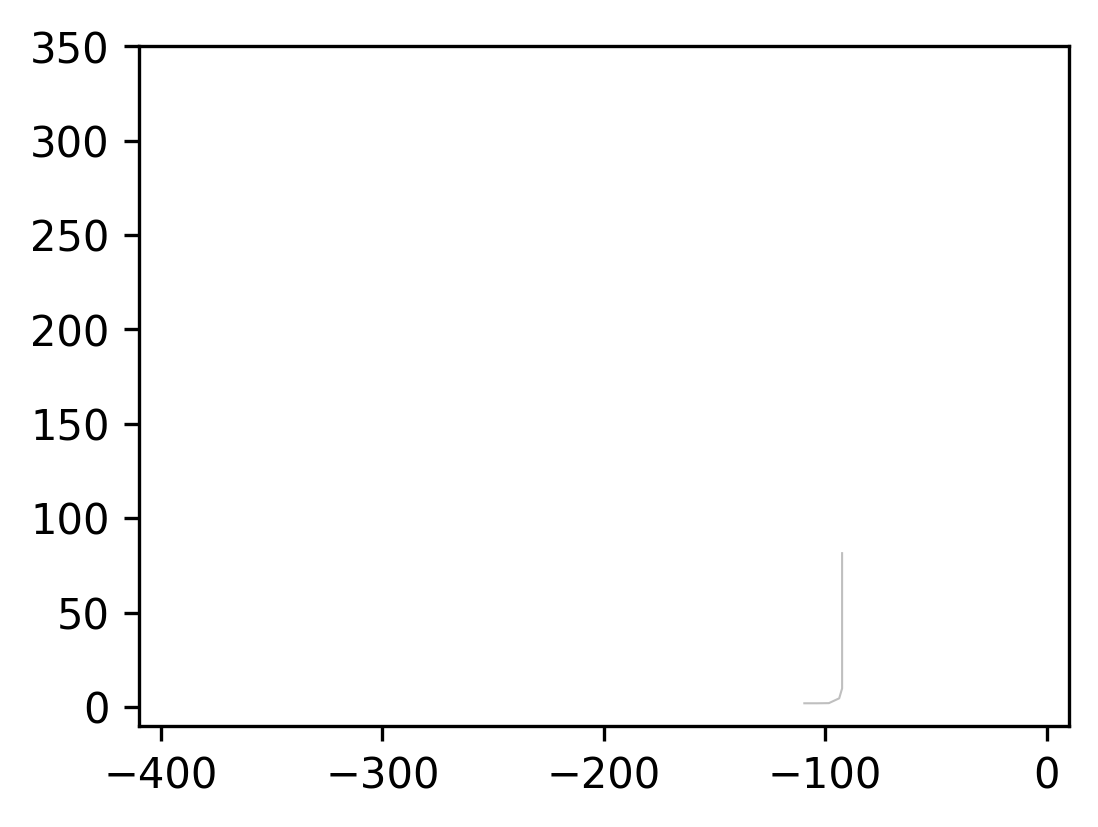

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_216.npy


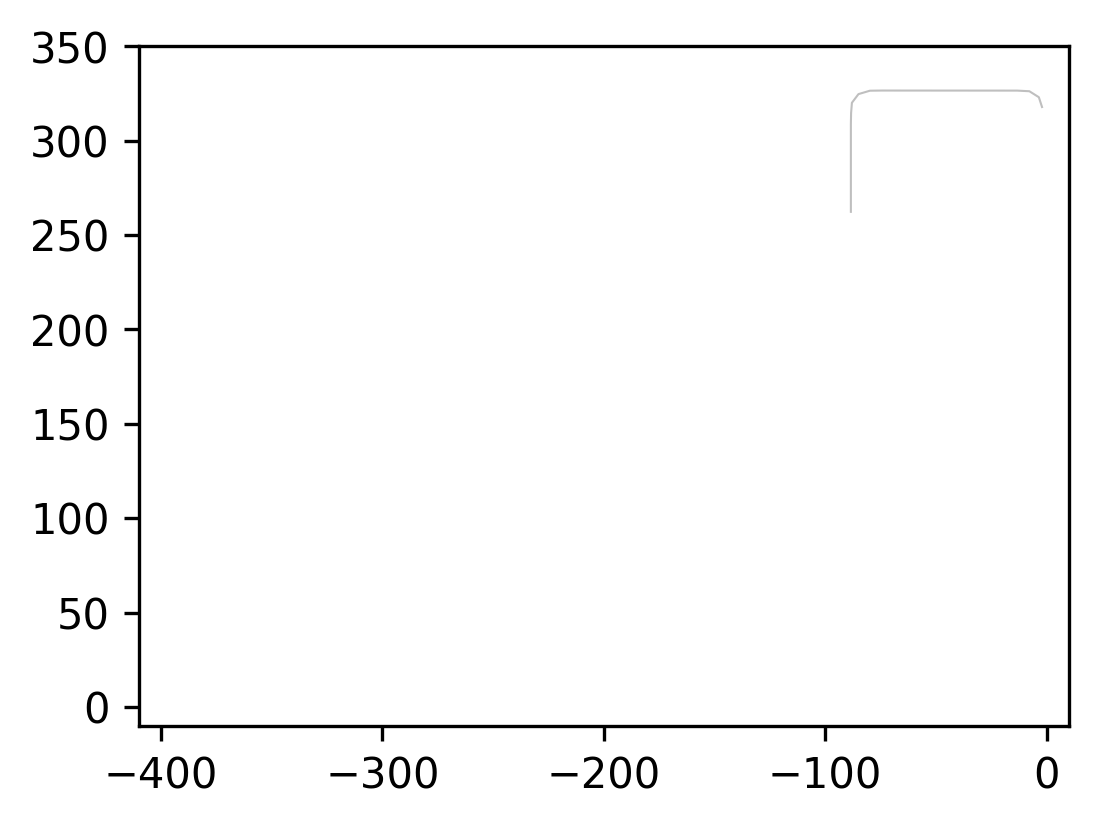

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_342.npy


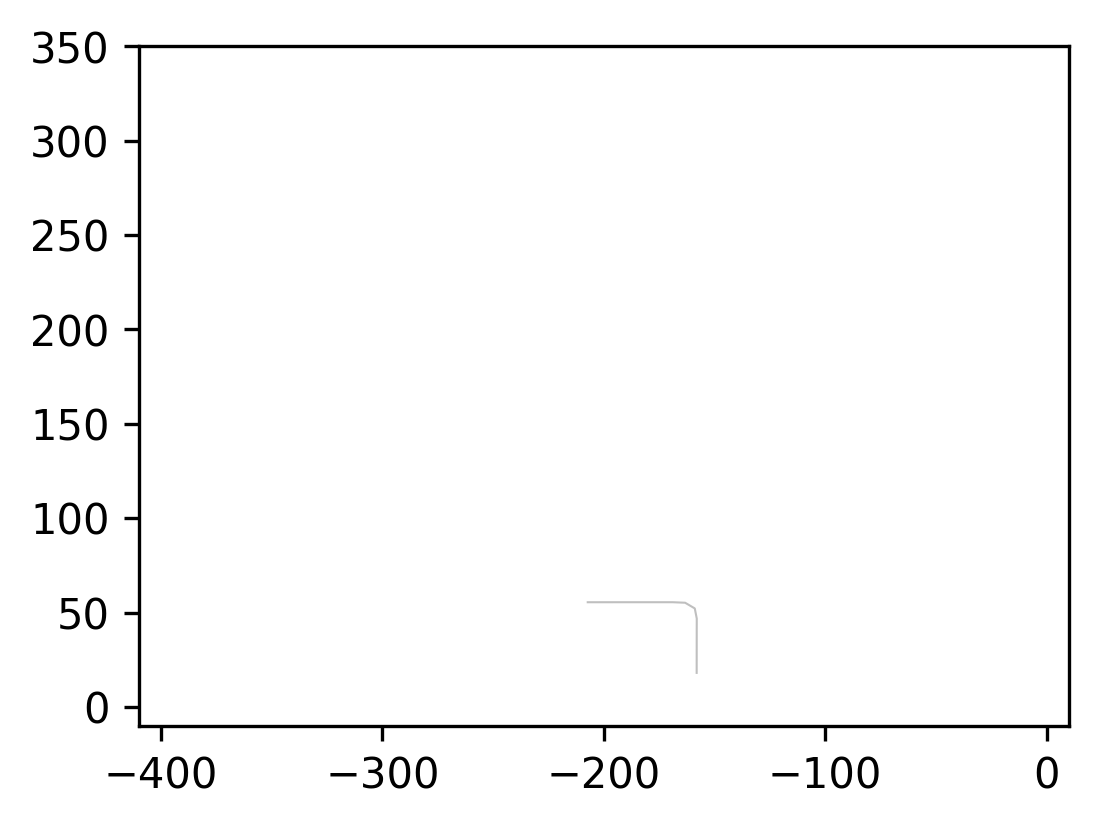

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_491.npy


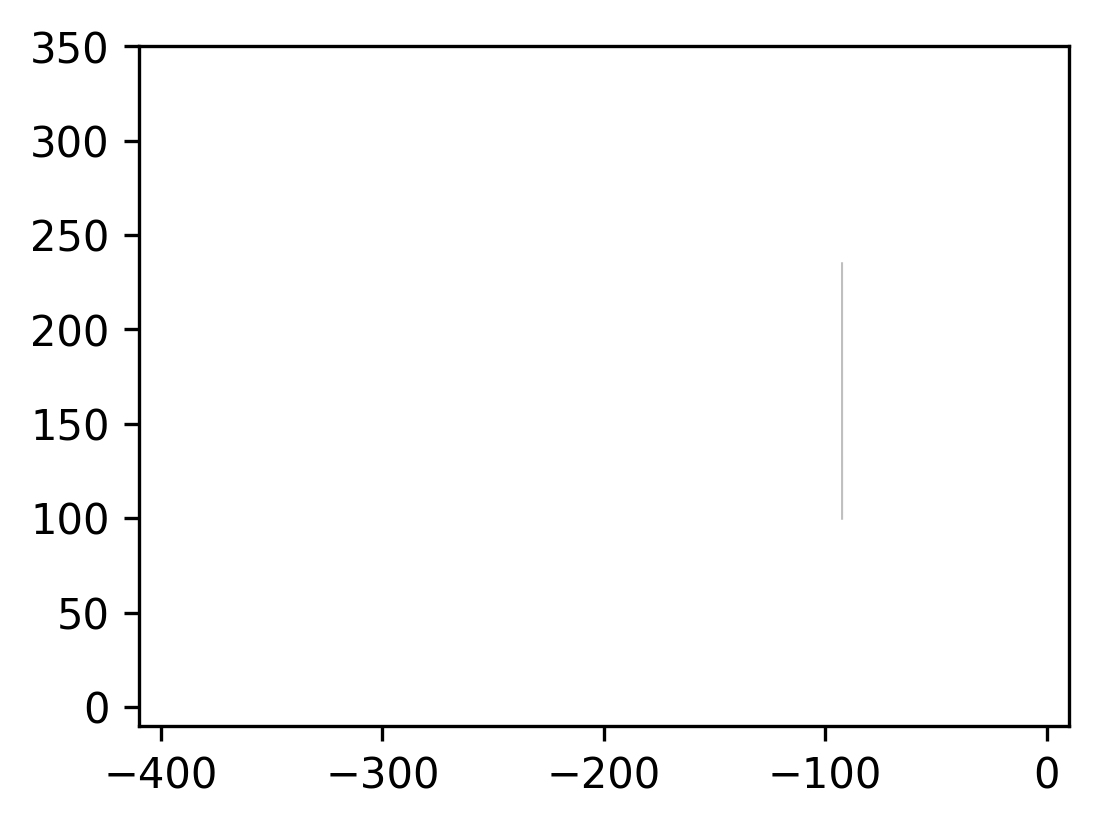

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_81.npy


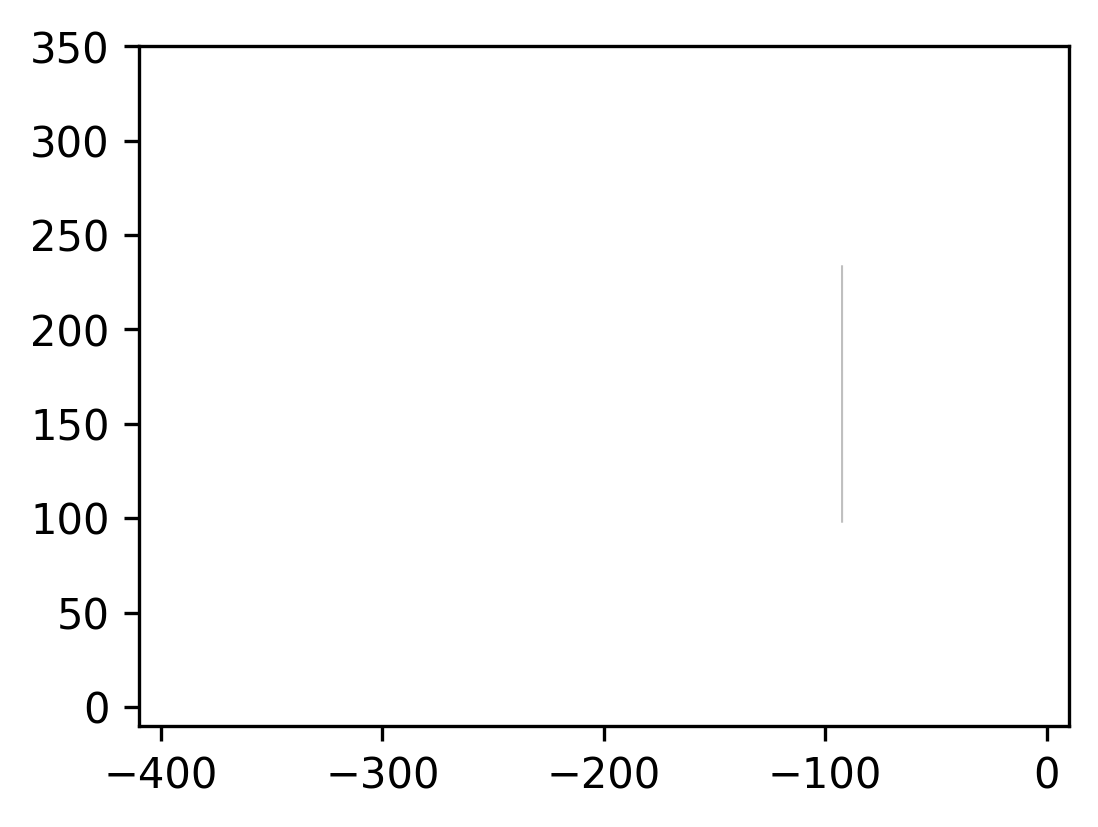

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_126.npy


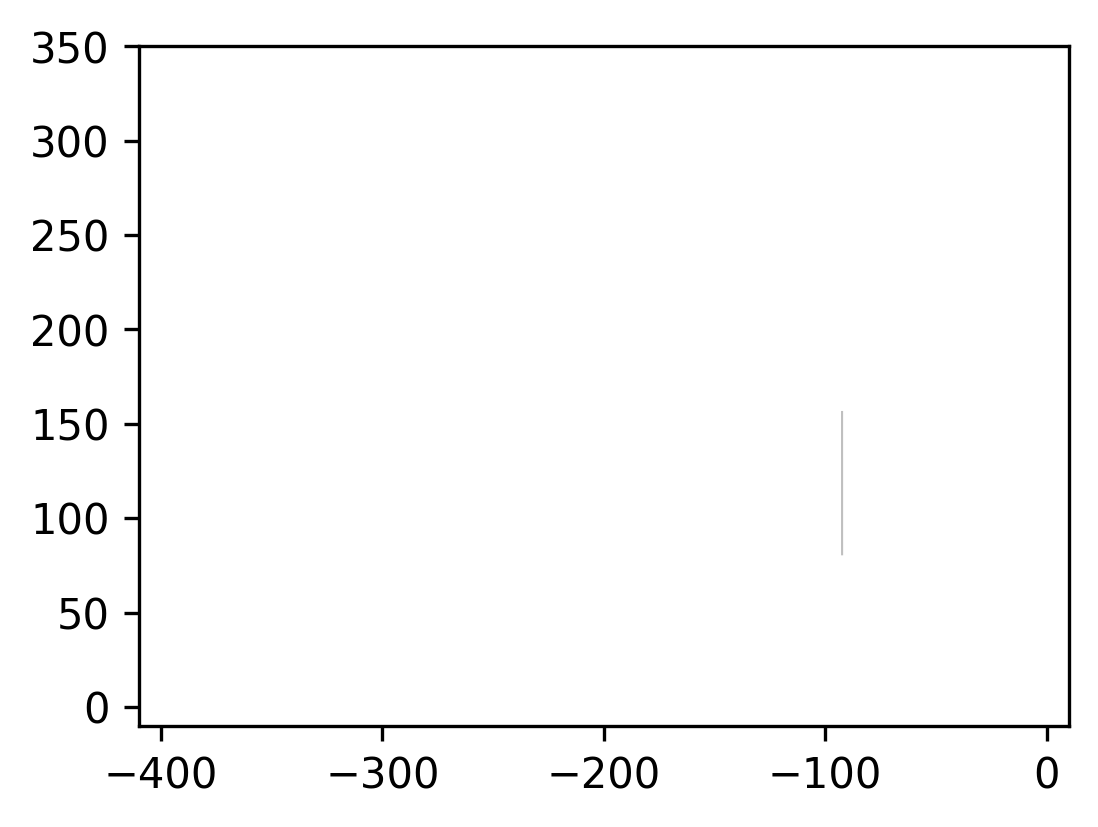

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_79.npy


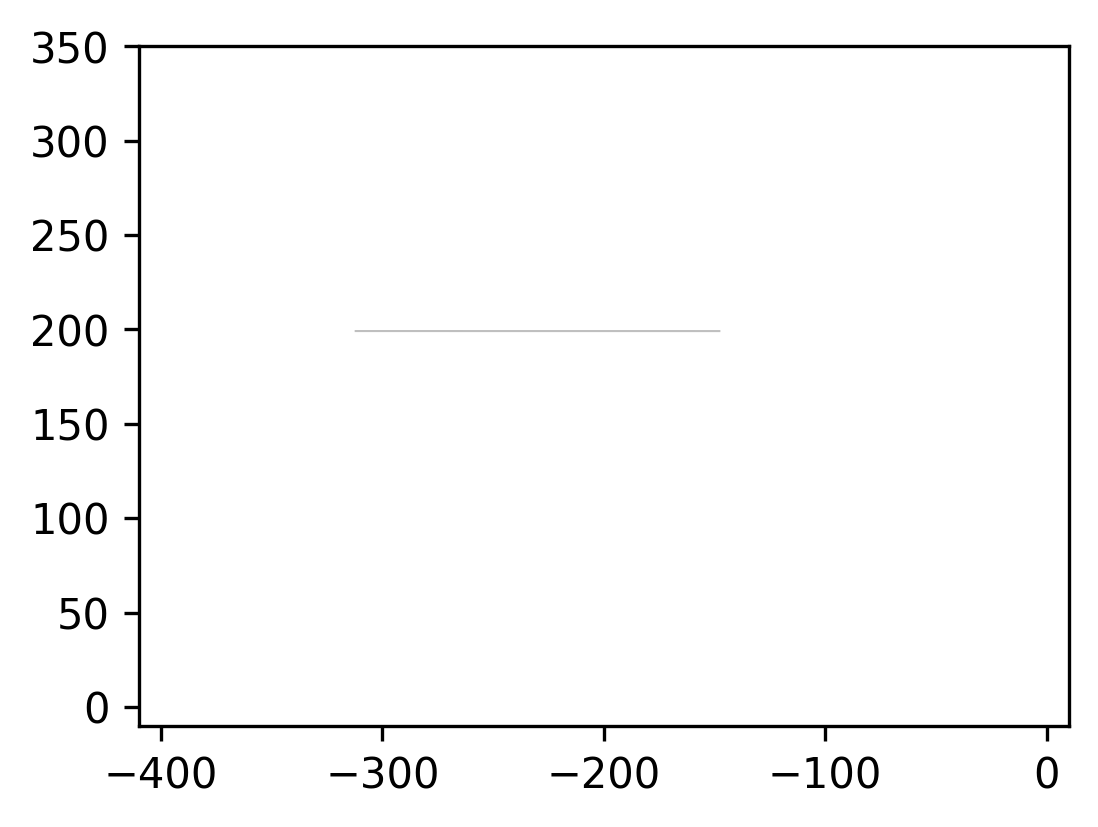

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_341.npy


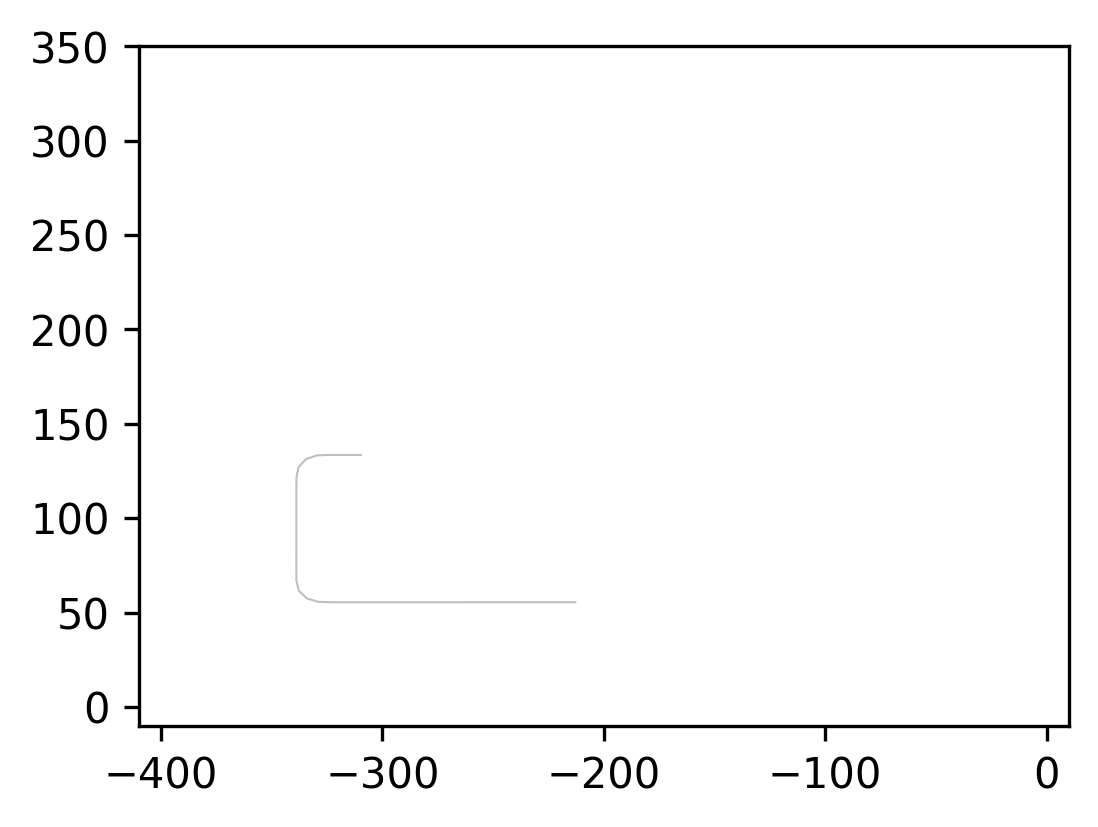

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_200.npy


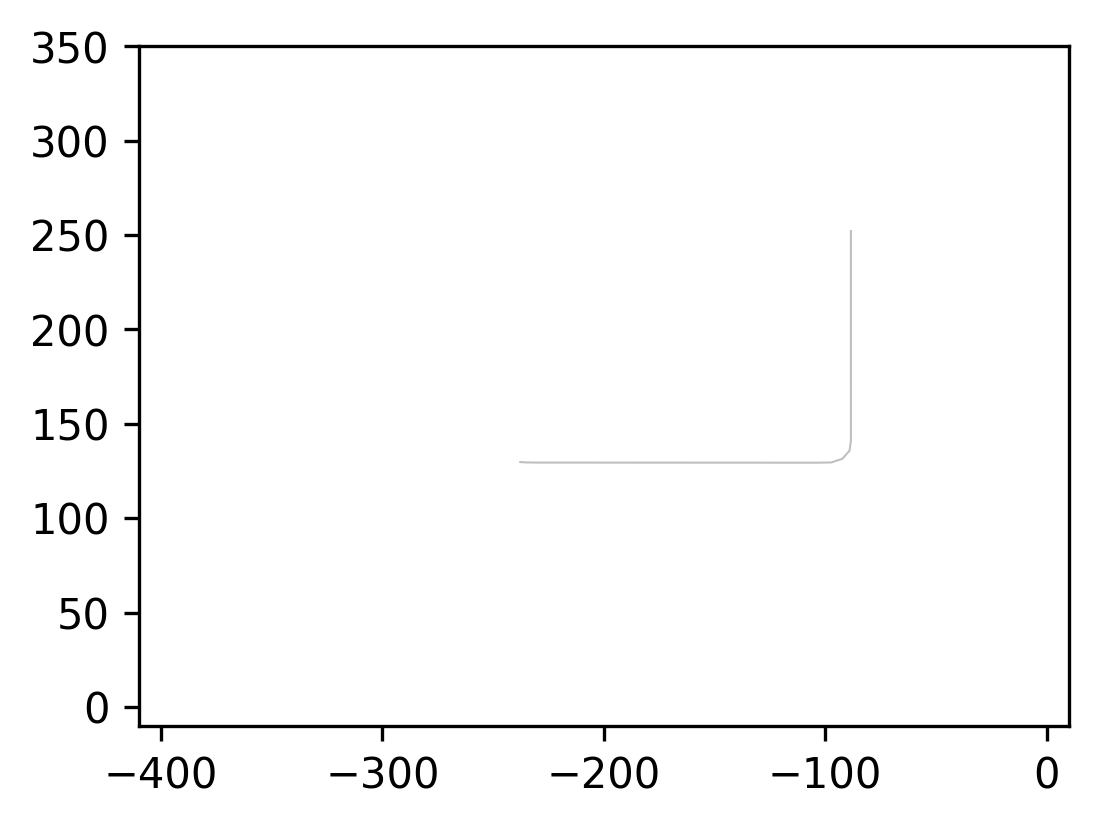

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_72.npy


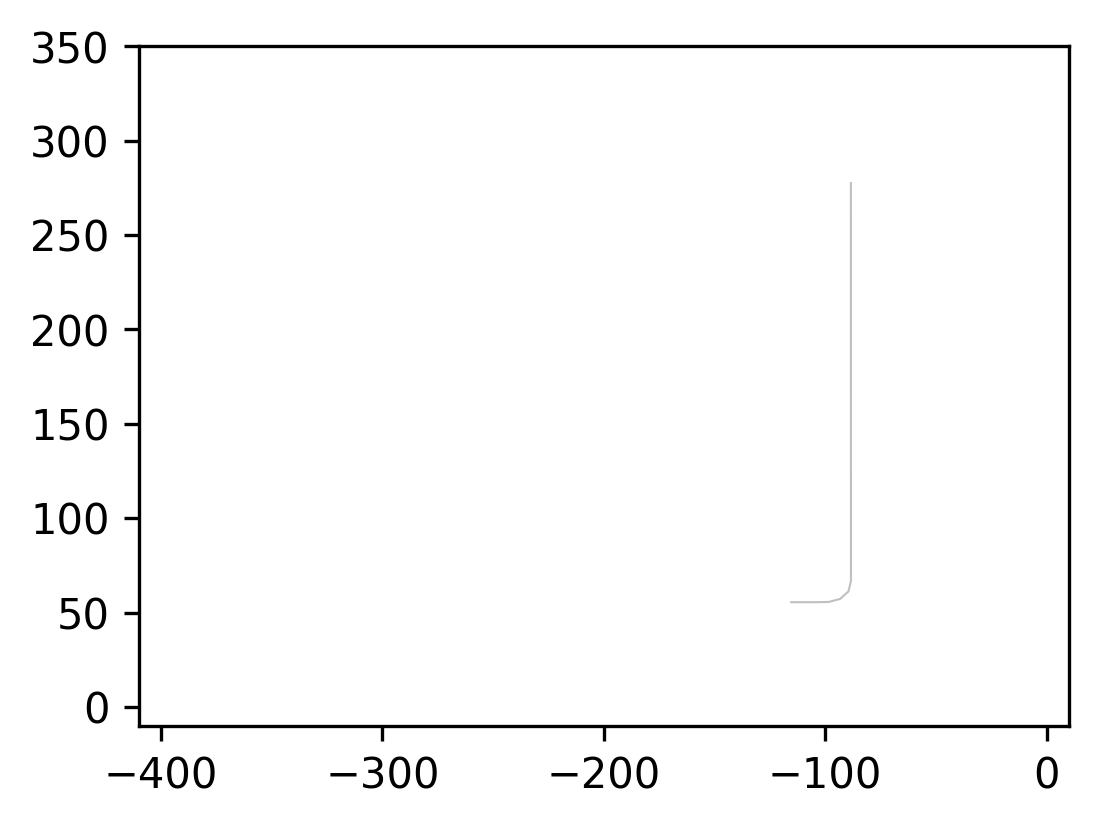

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_459.npy


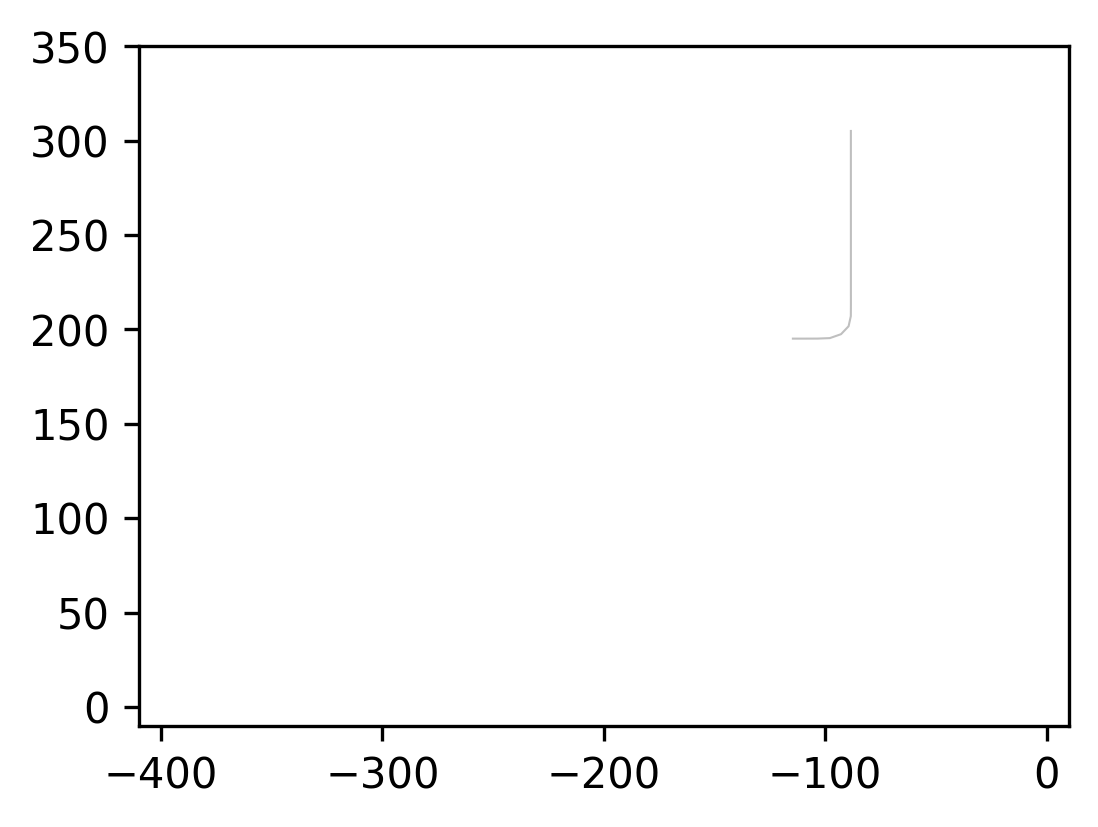

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_225.npy


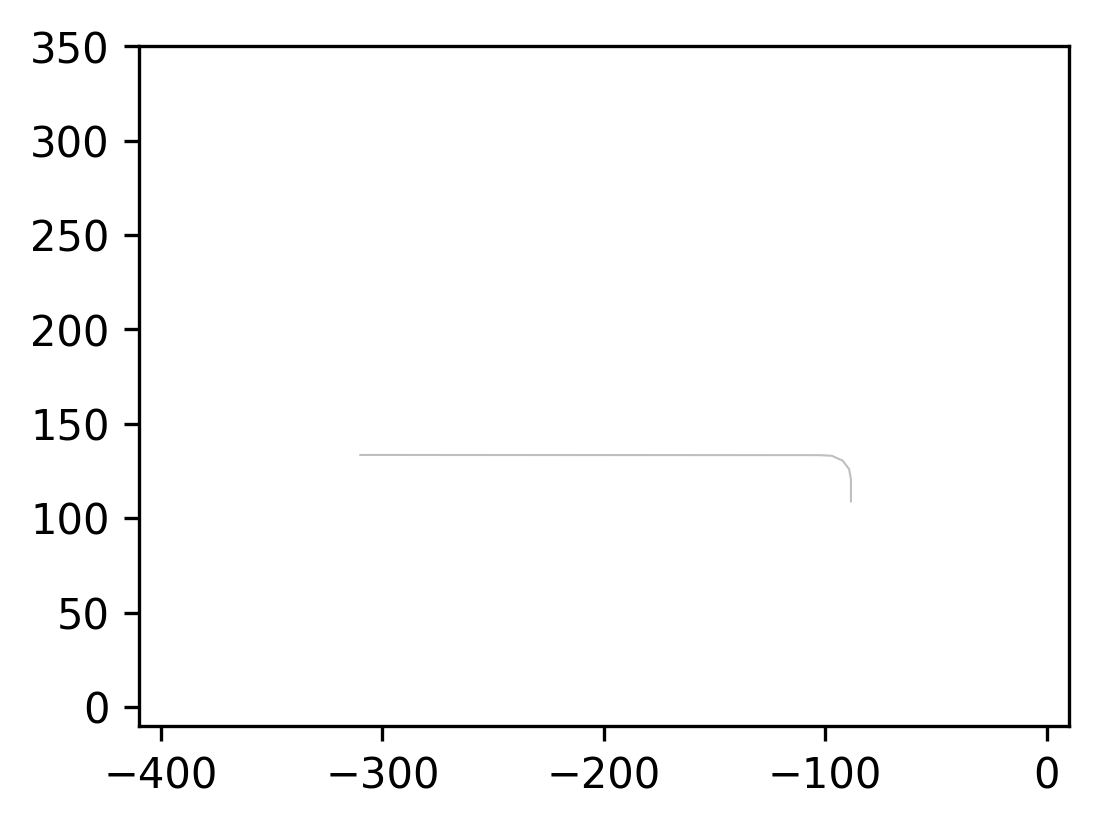

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_96.npy


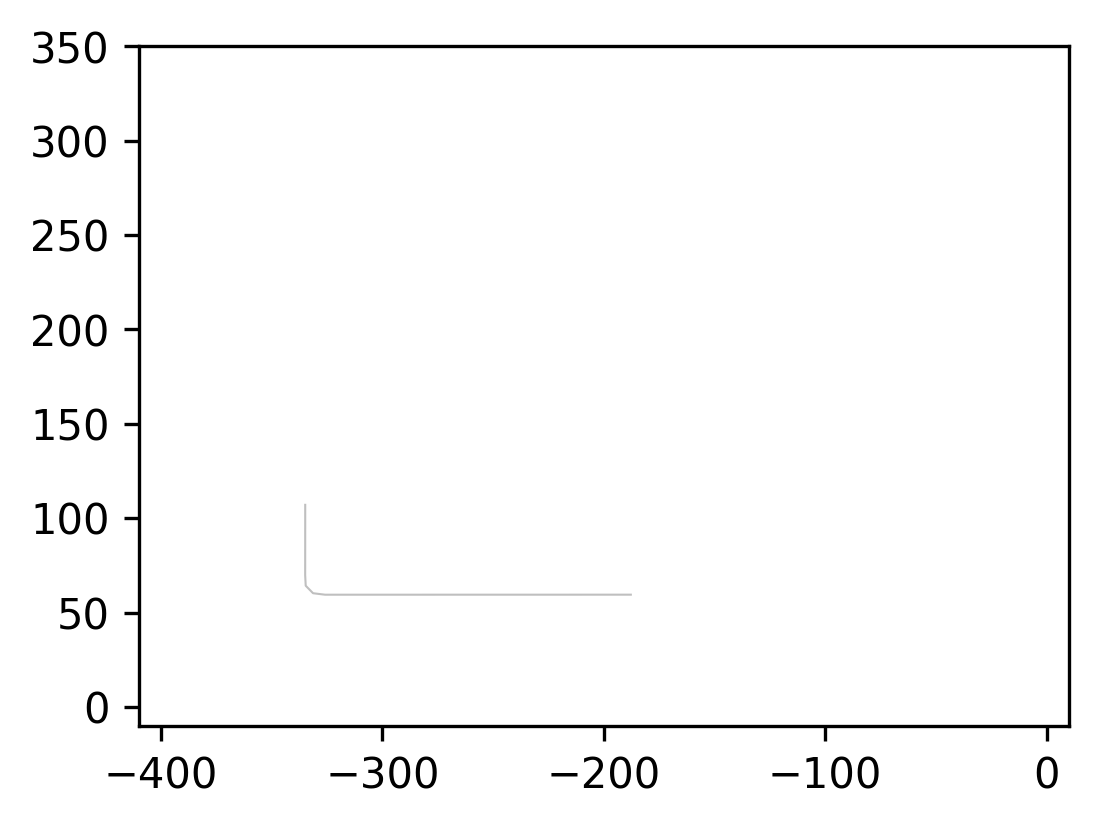

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_398.npy


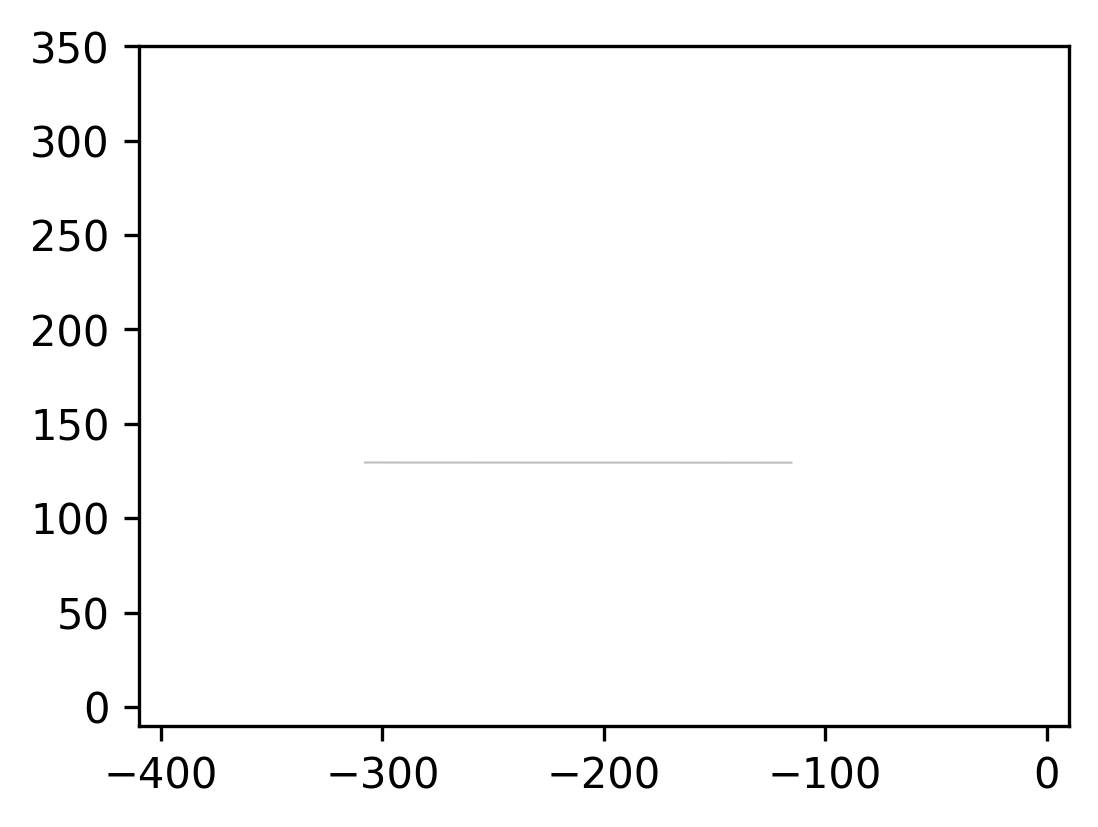

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_59.npy


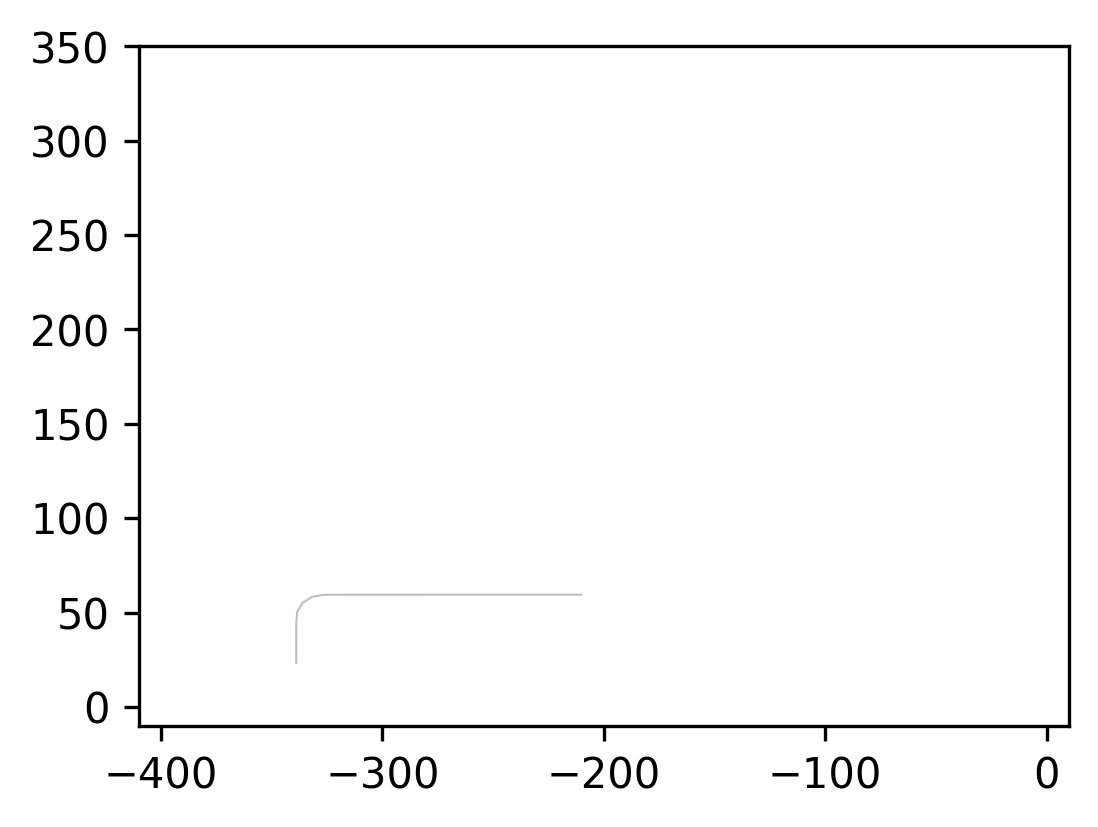

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_20.npy


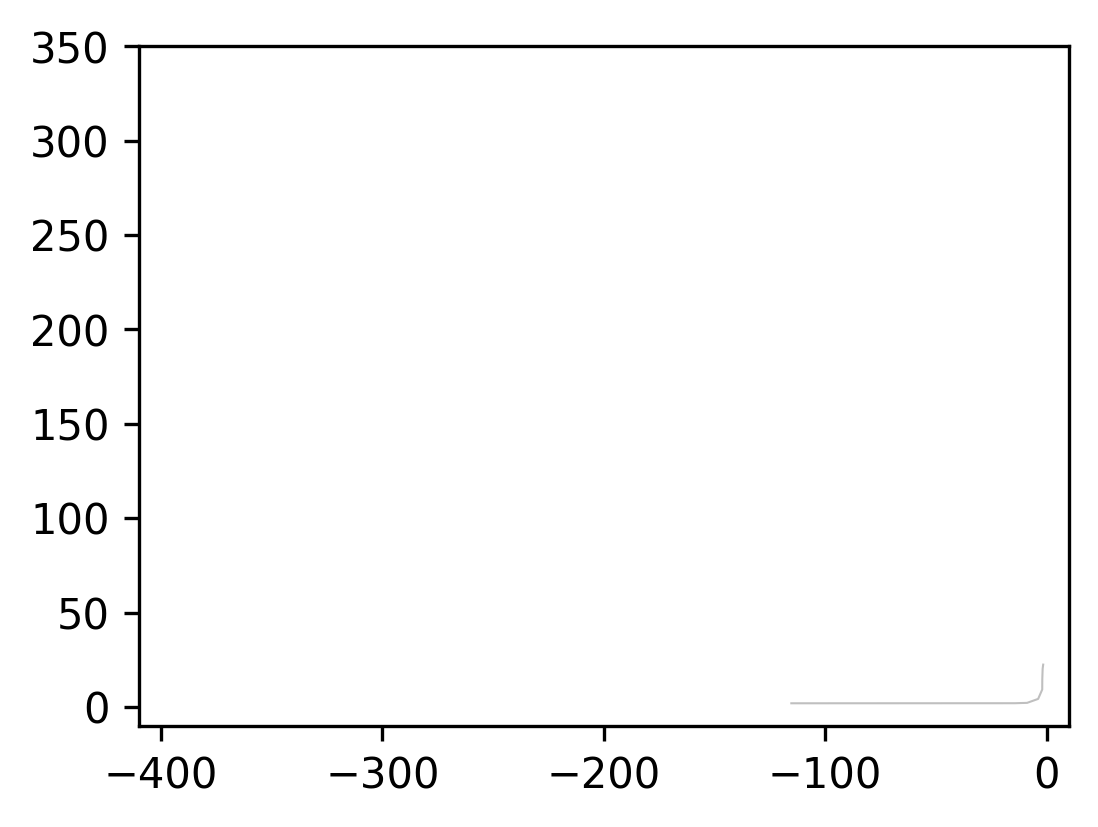

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_485.npy


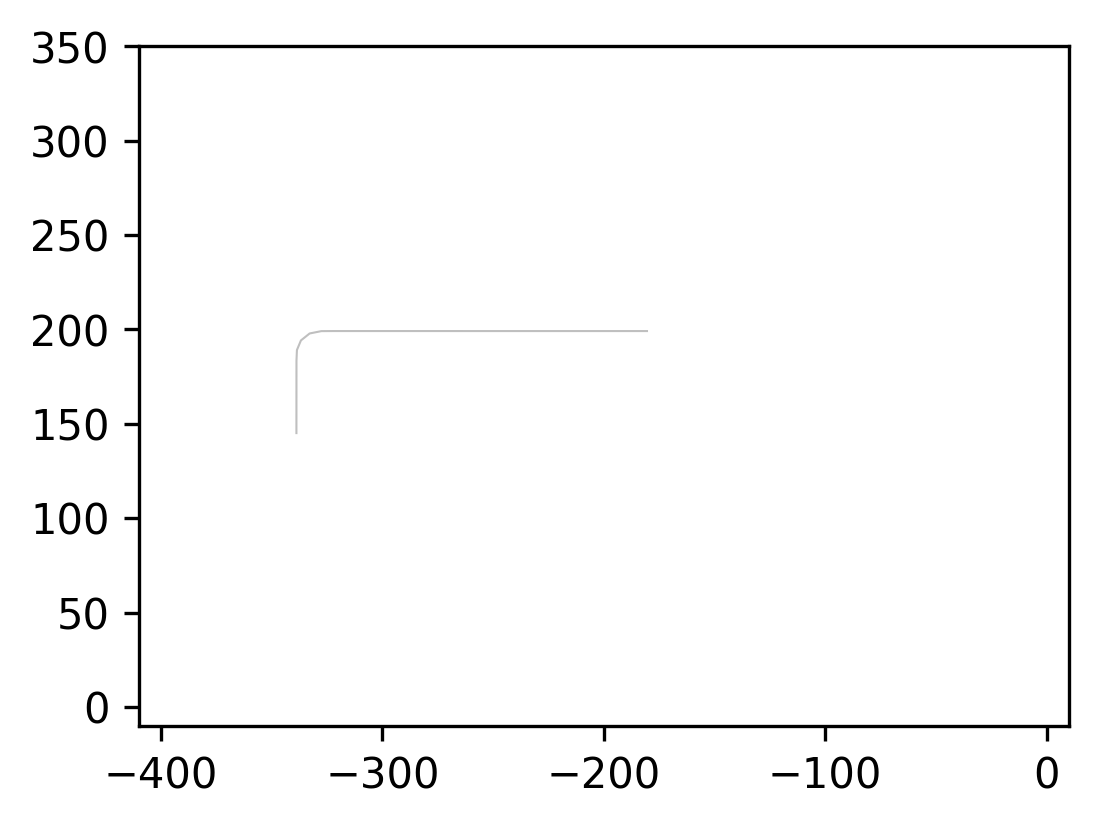

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_70.npy


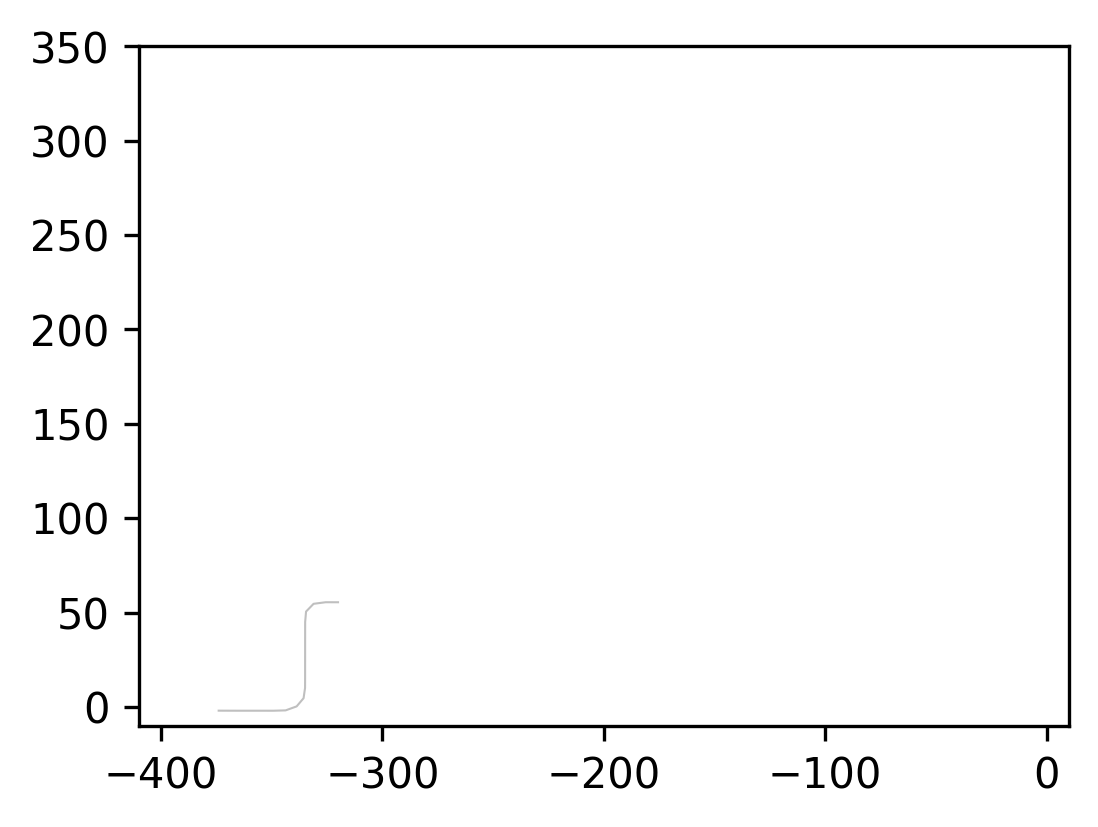

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_346.npy


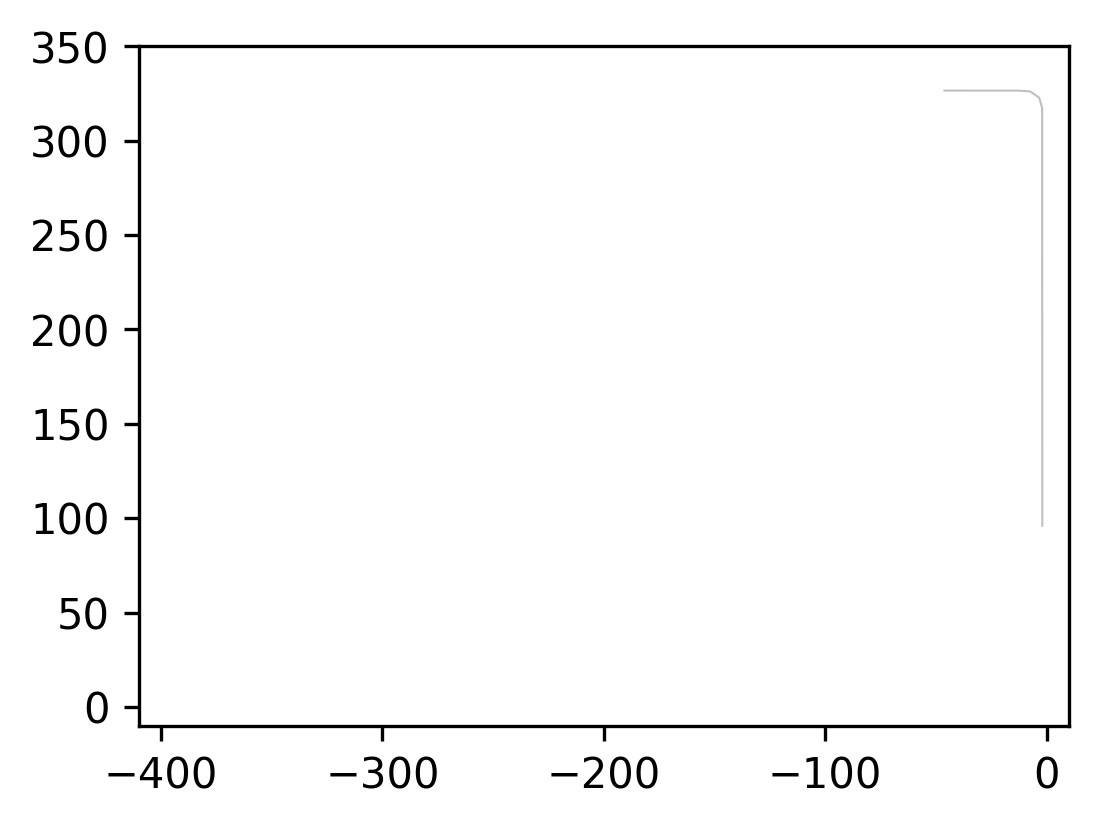

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_256.npy


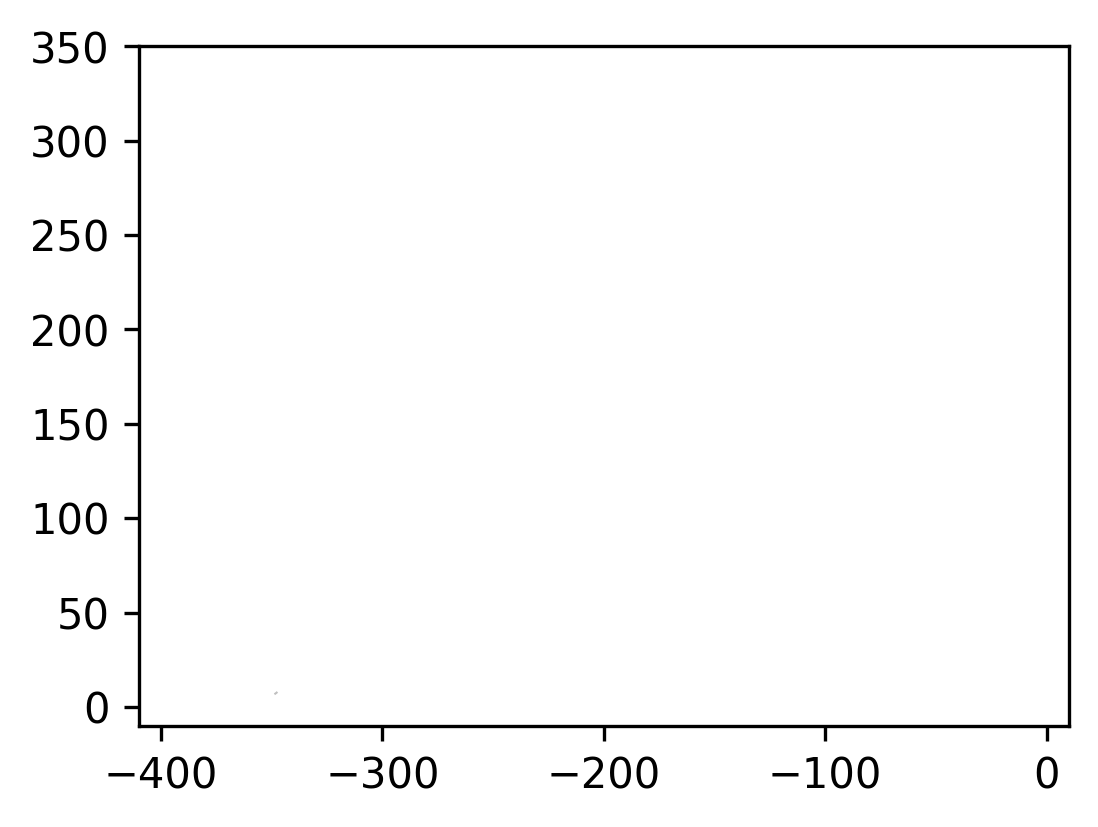

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_371.npy


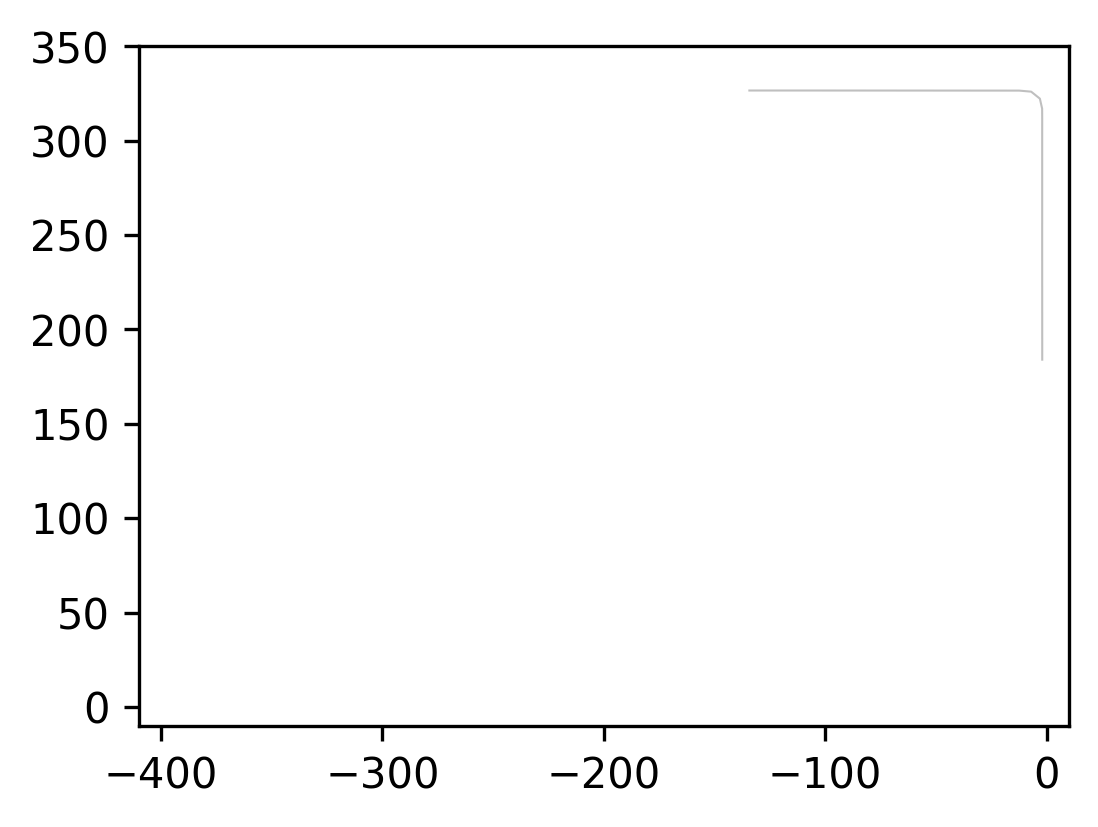

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_448.npy


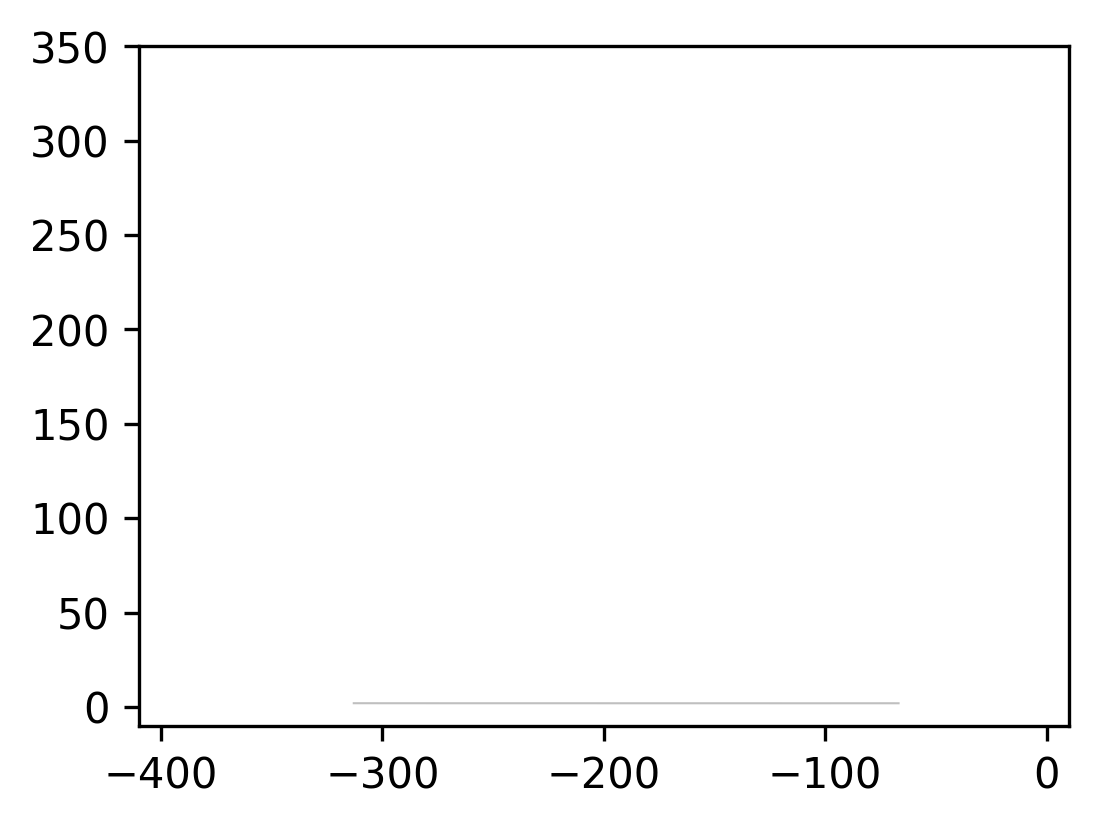

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_435.npy


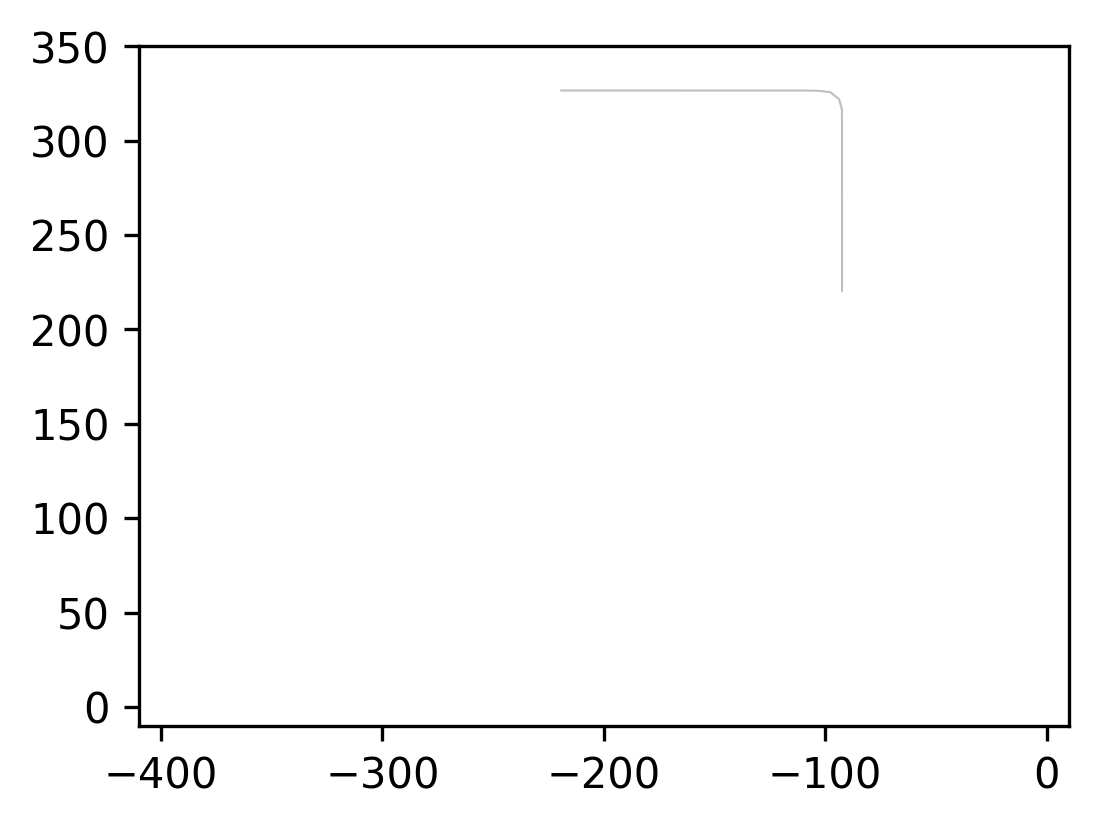

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_337.npy


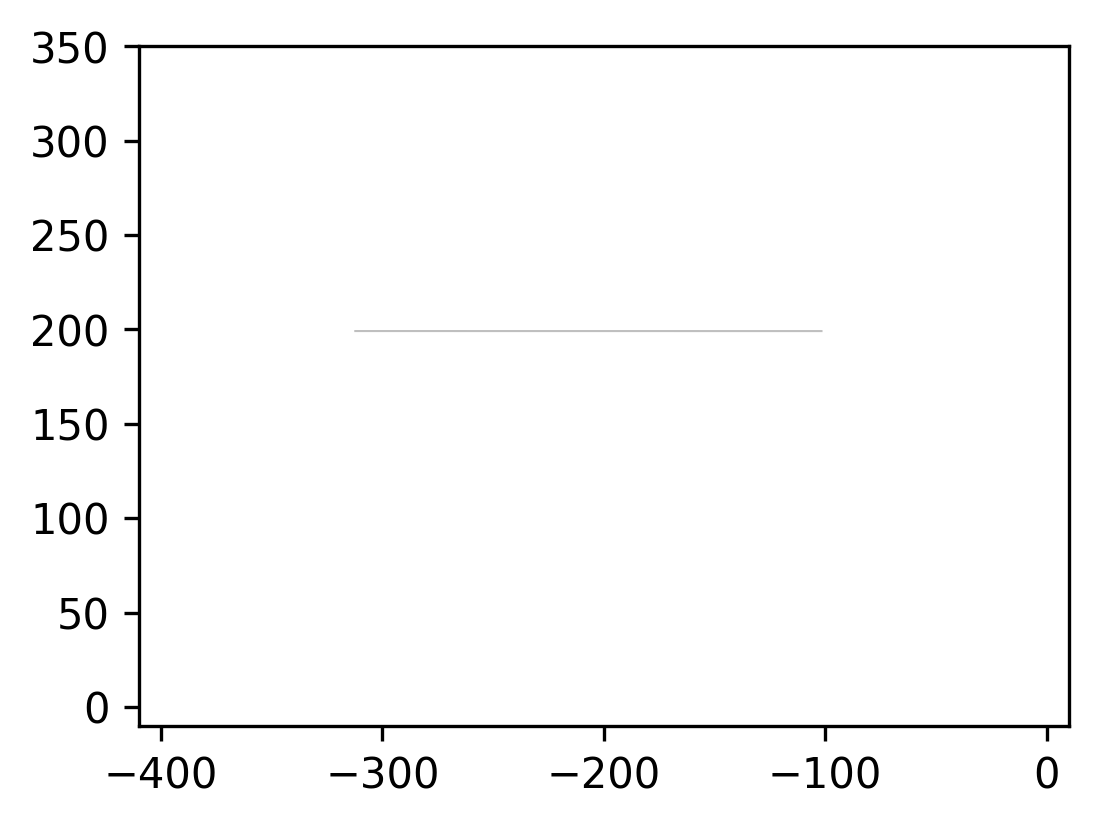

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_46.npy


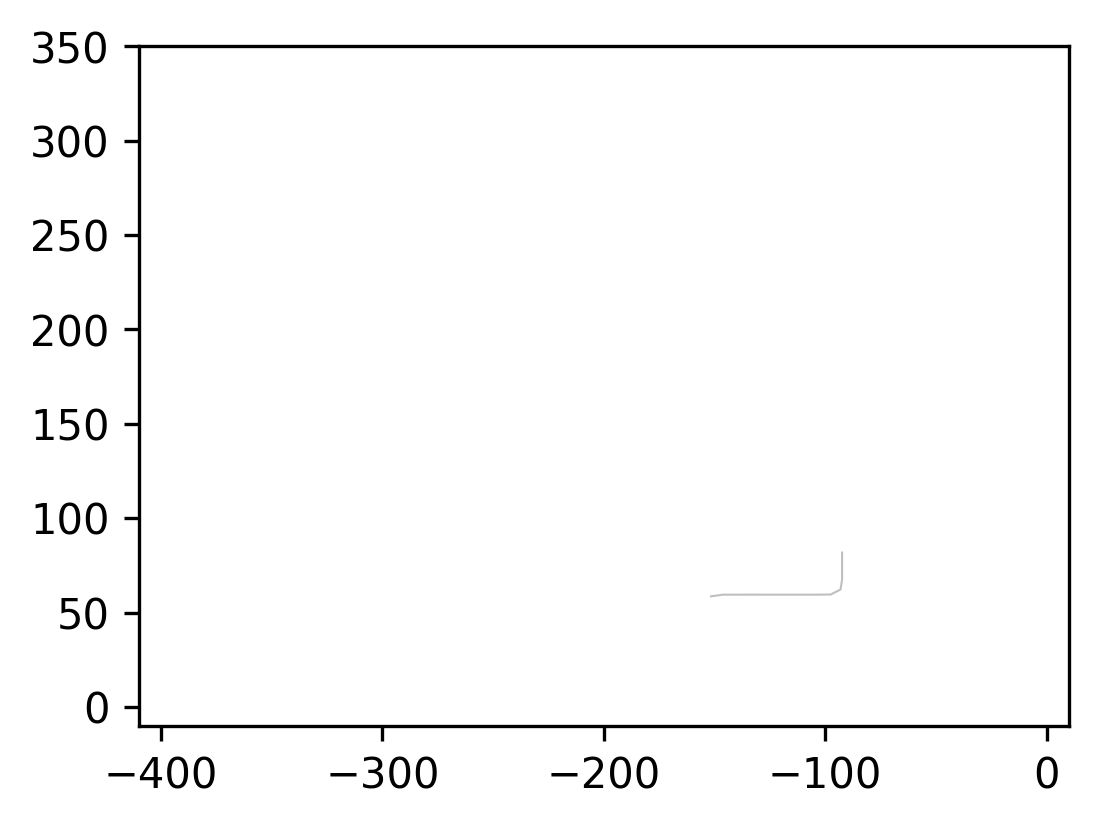

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_152.npy


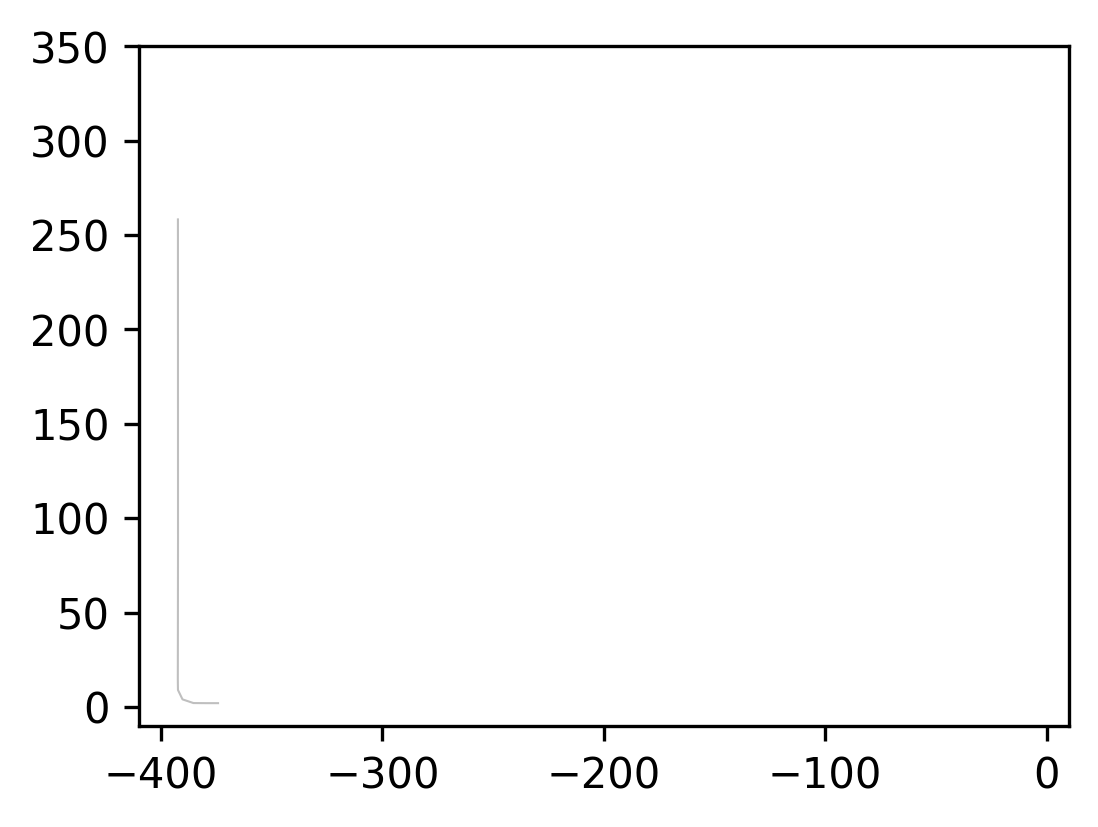

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_312.npy


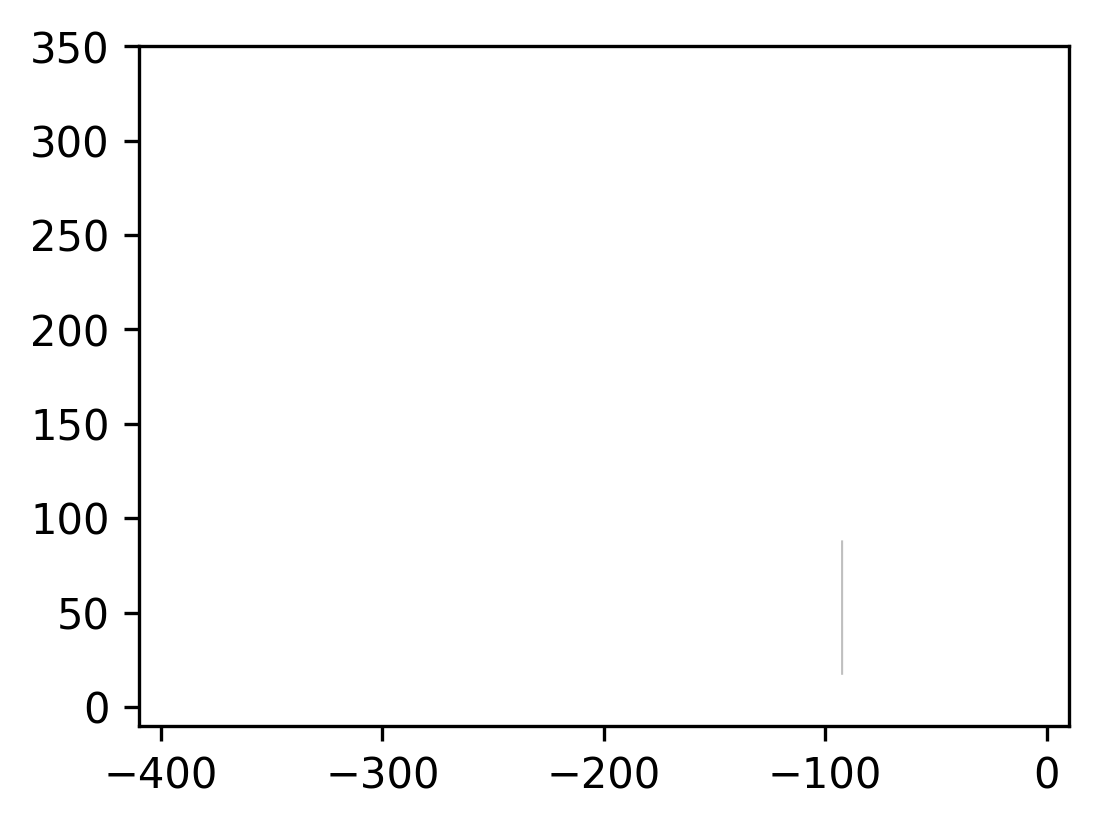

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_172.npy


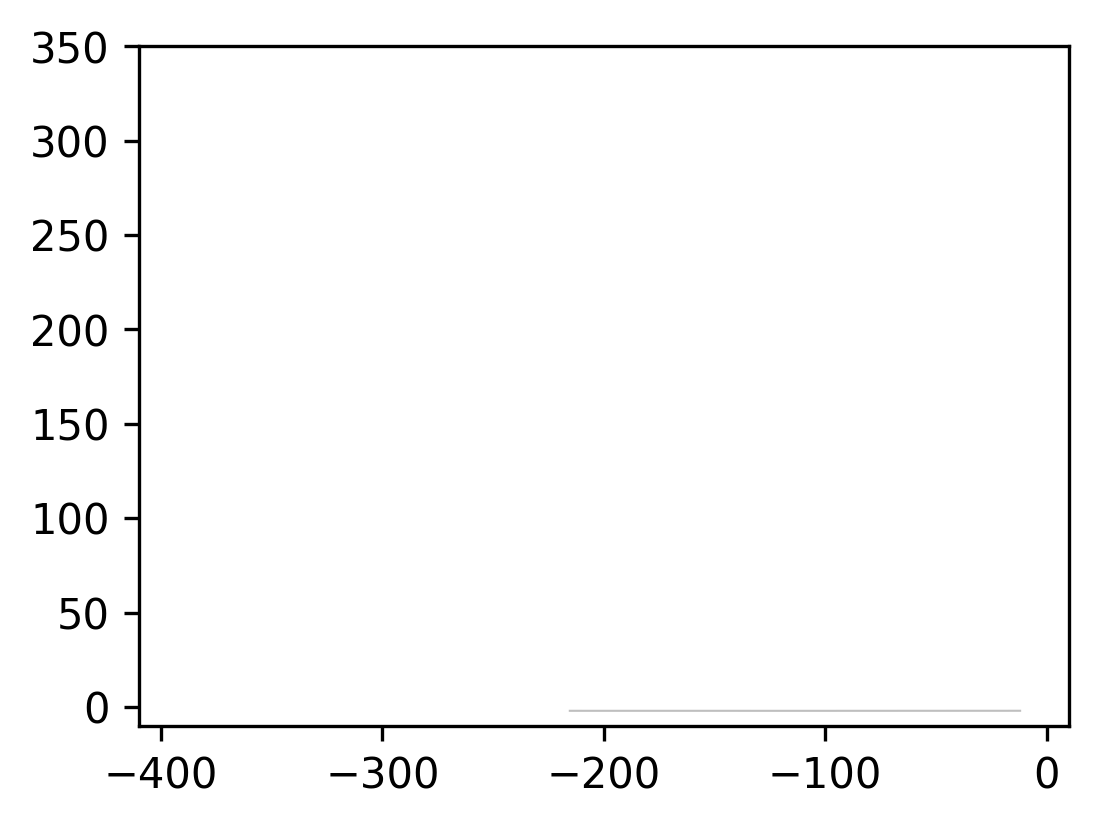

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_64.npy


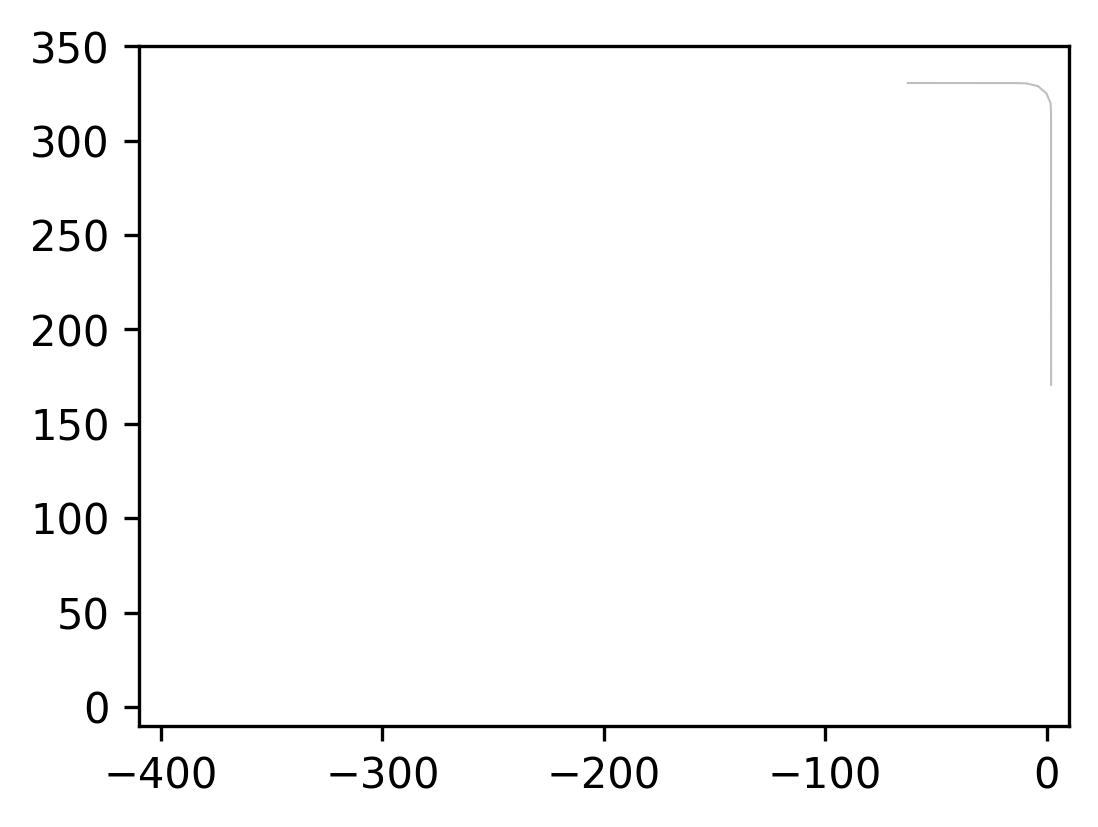

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_145.npy


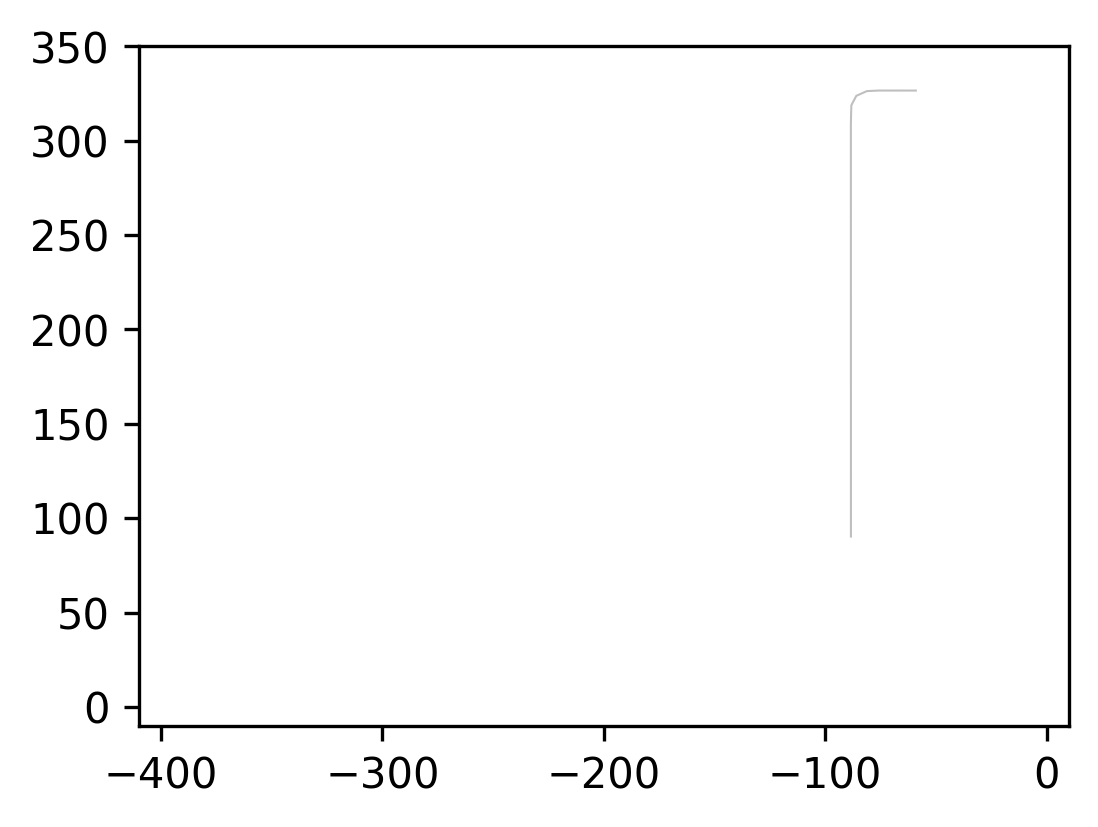

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_147.npy


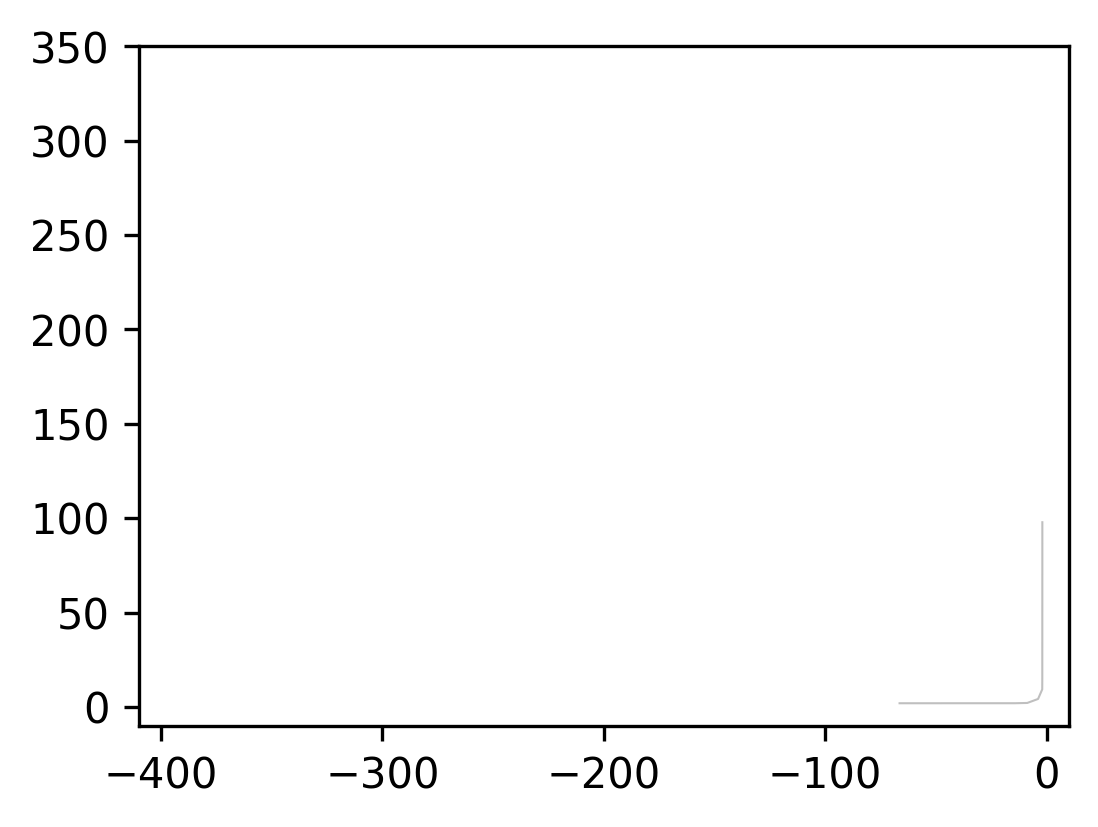

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_319.npy


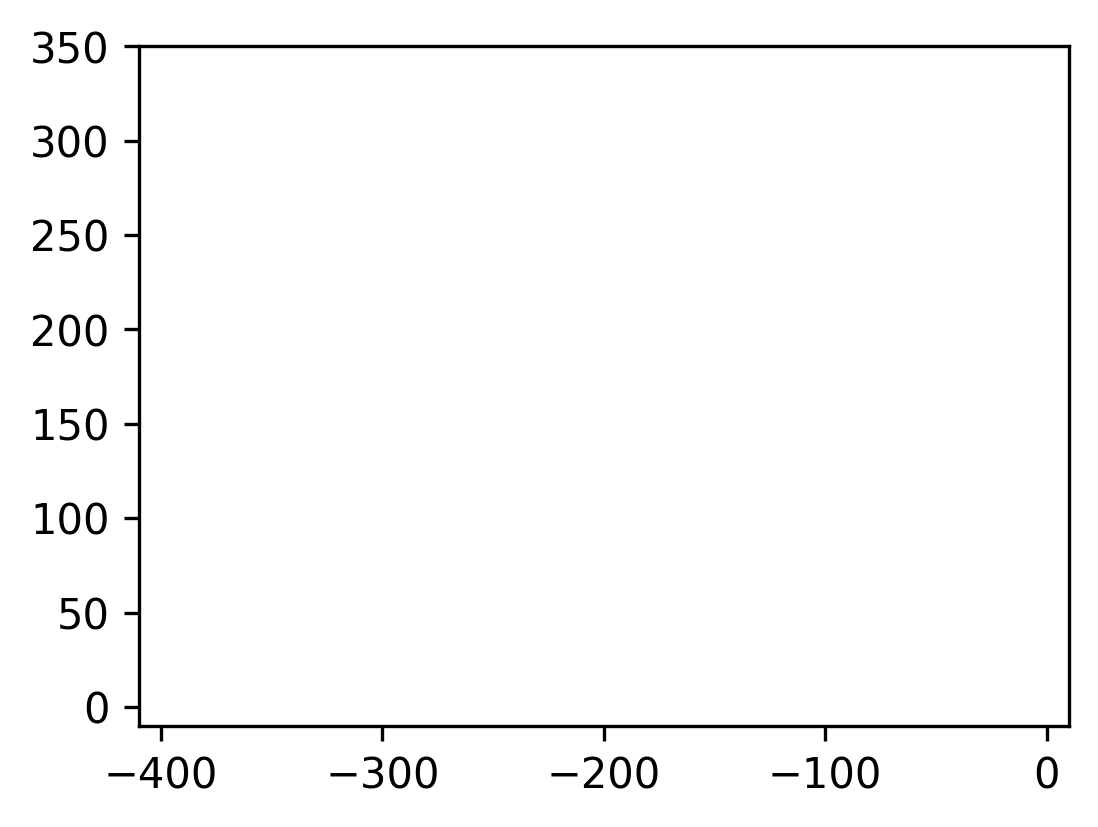

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_304.npy


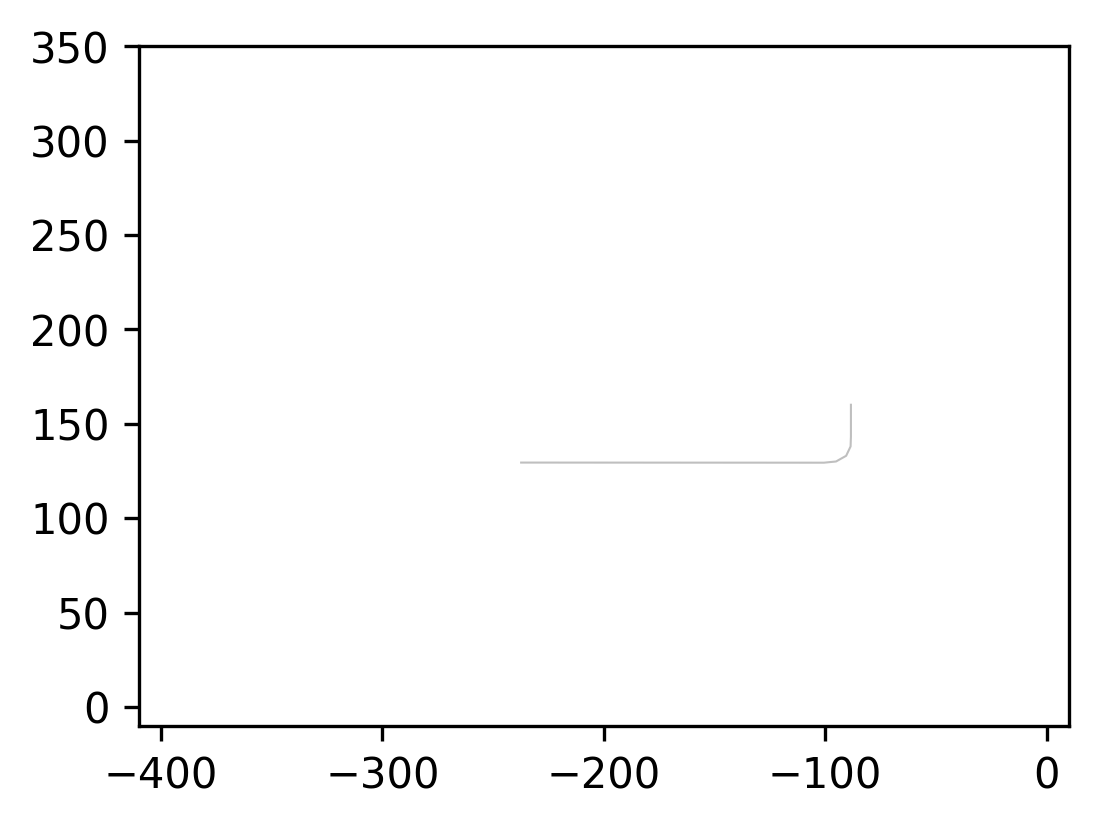

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_5.npy


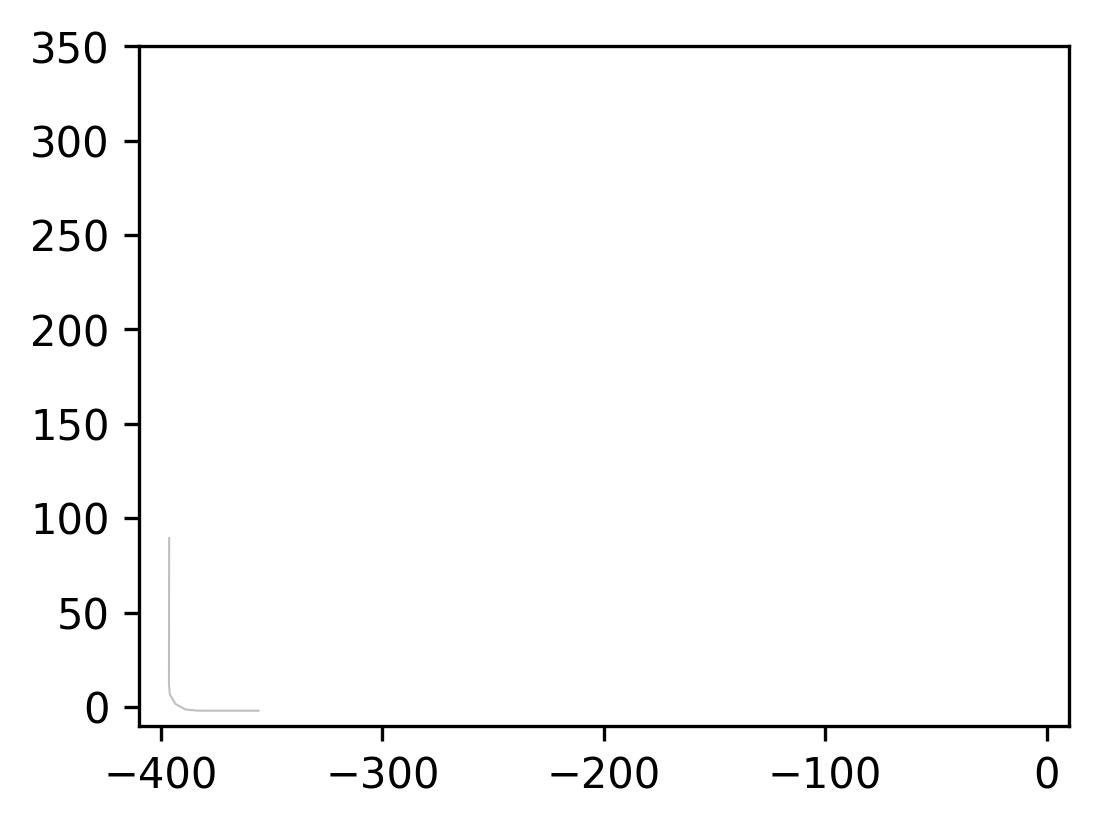

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_21.npy


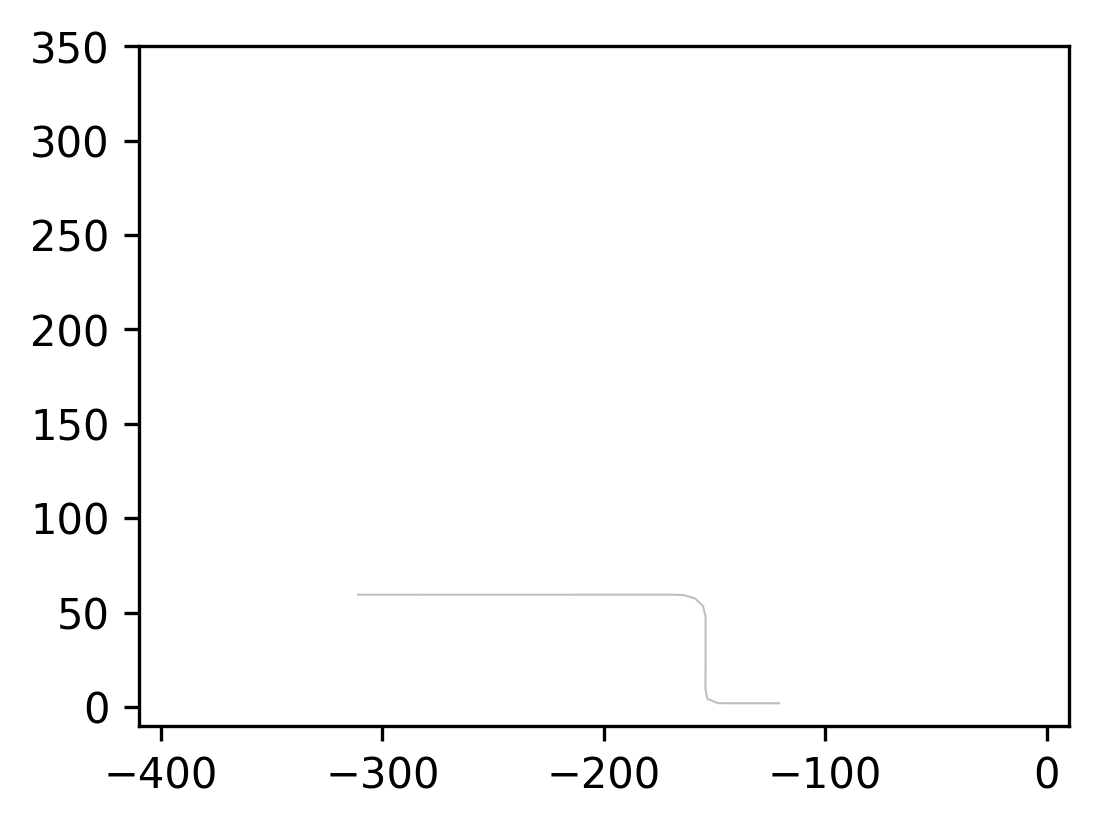

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_446.npy


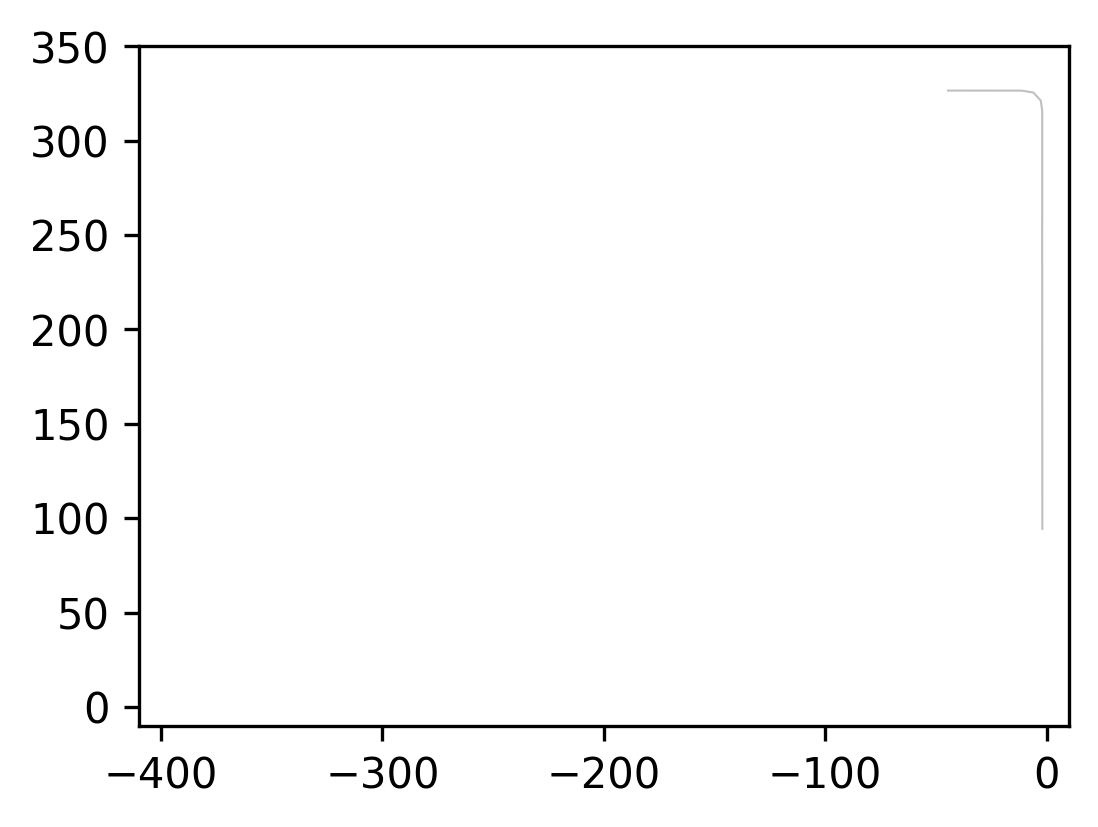

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_144.npy


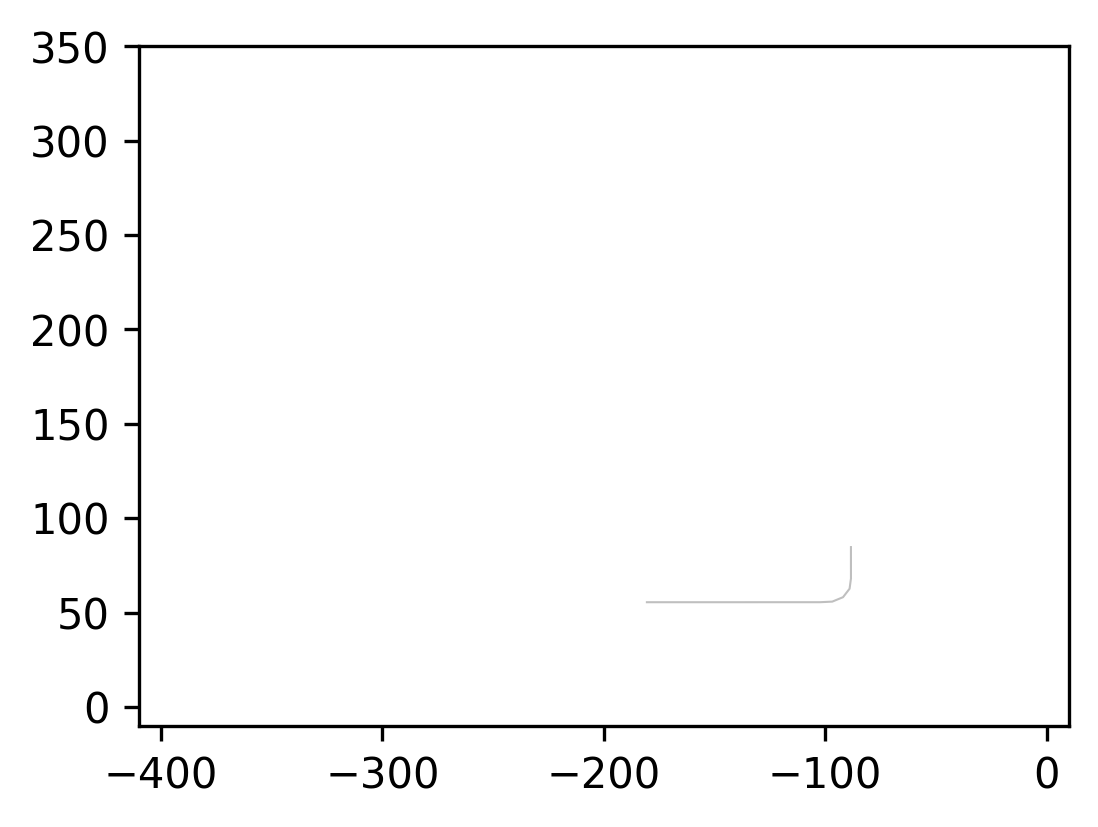

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_309.npy


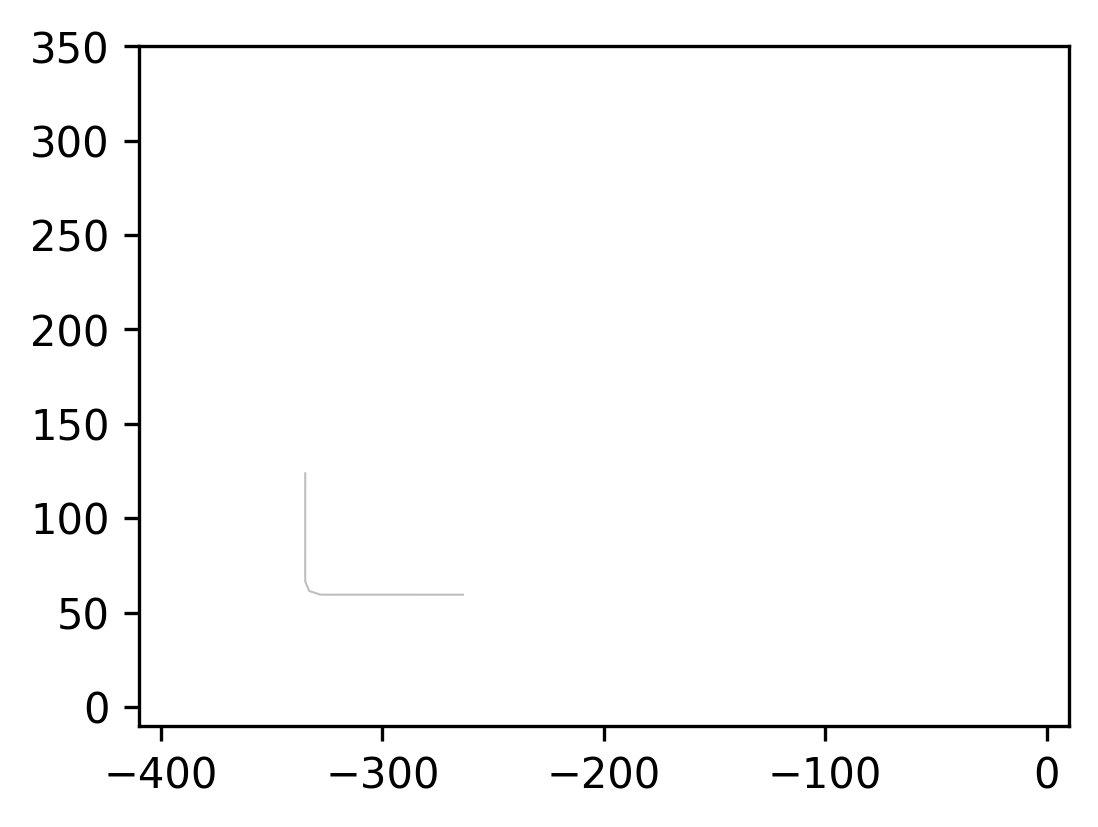

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_254.npy


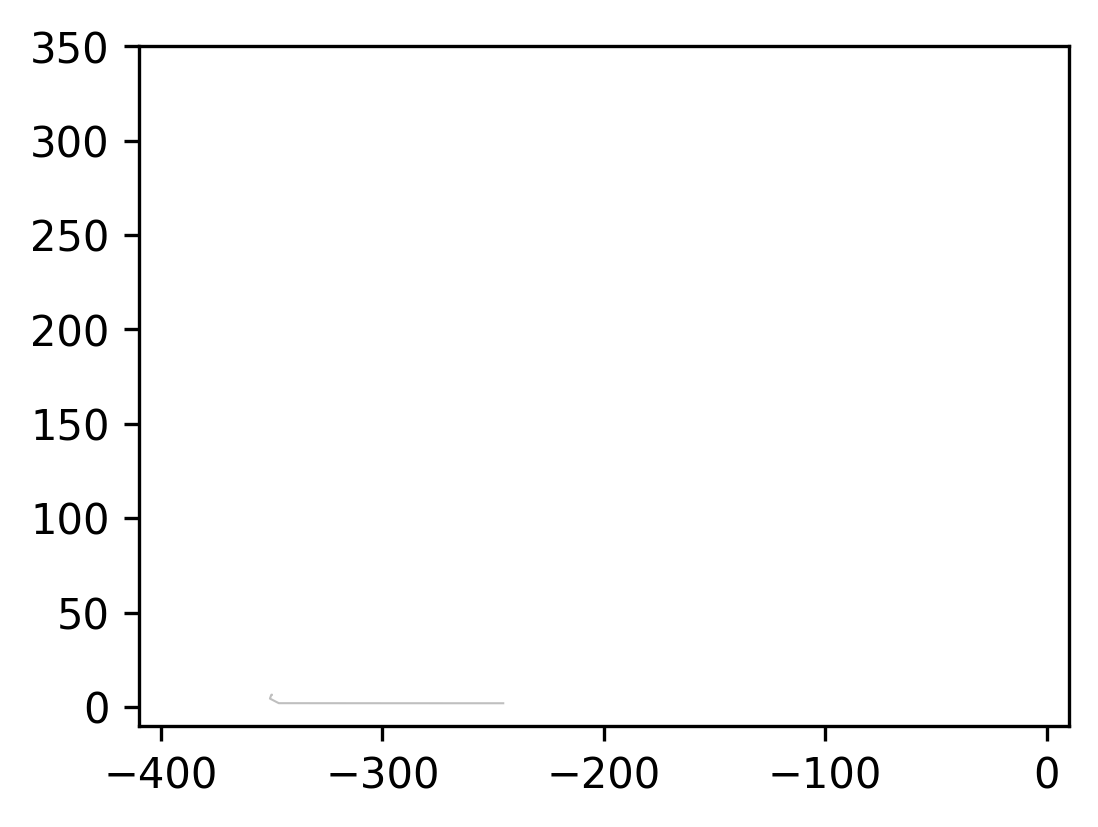

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_68.npy


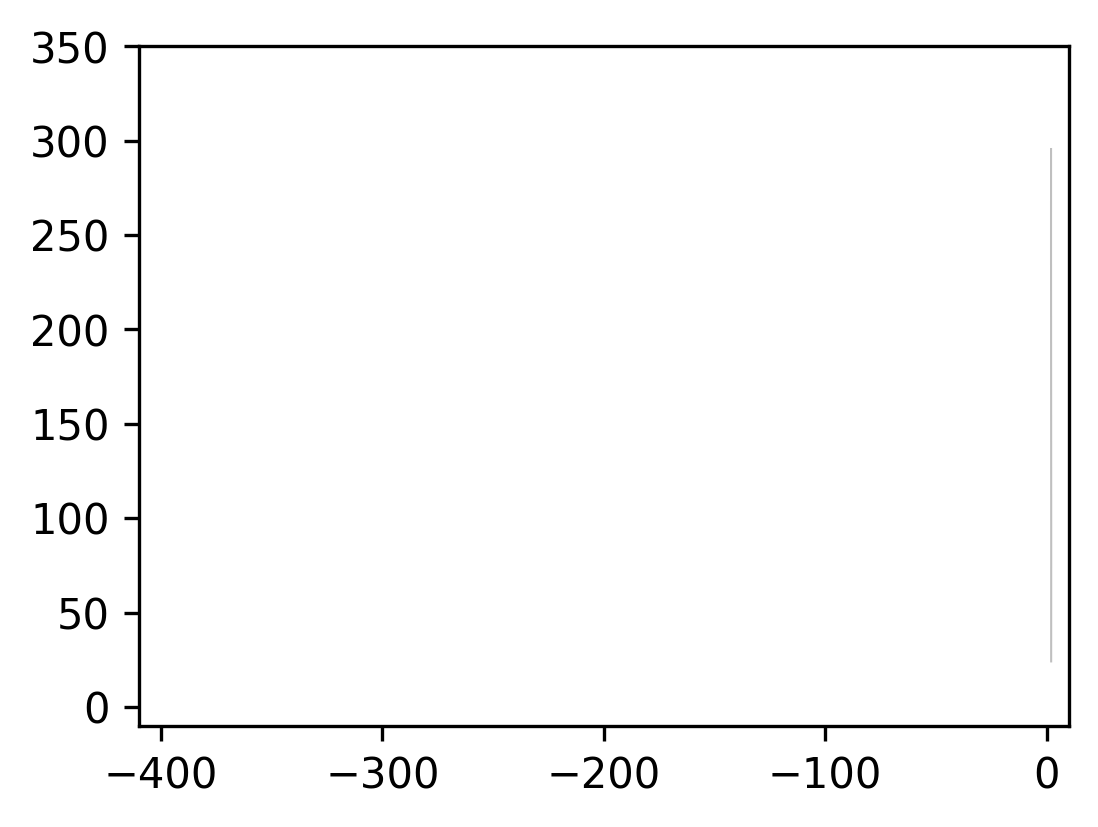

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_392.npy


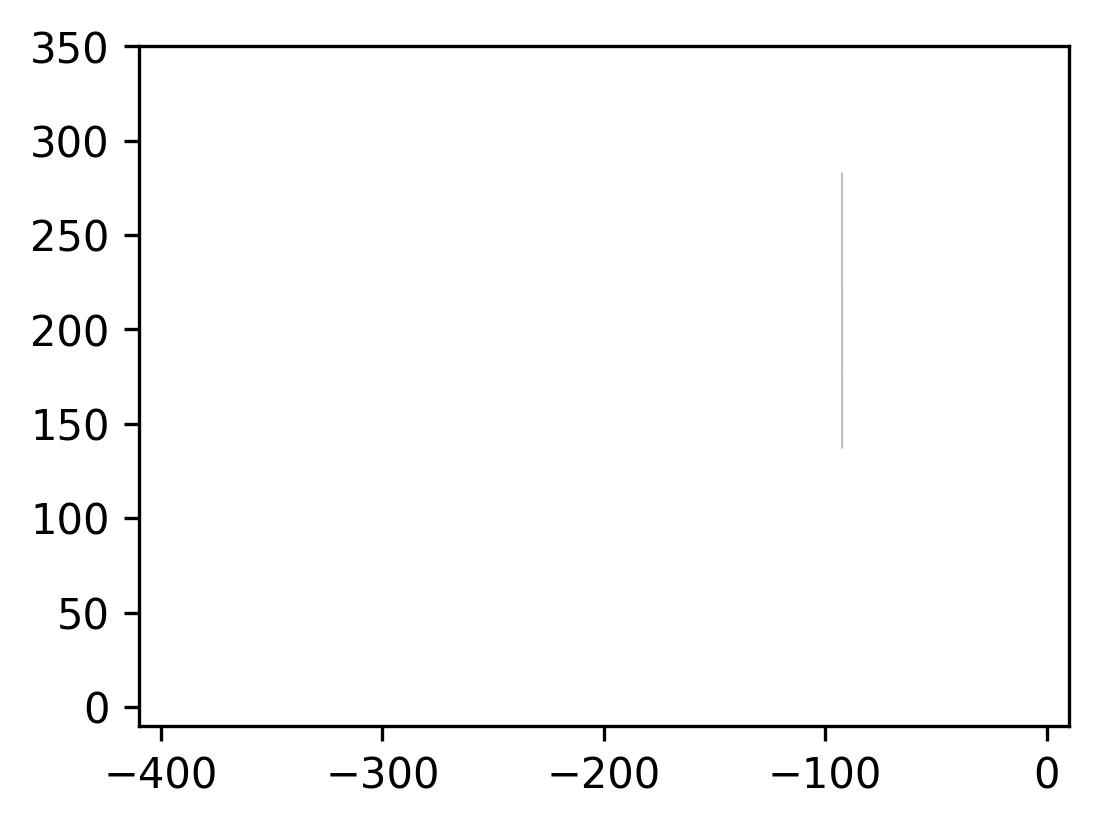

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_524.npy


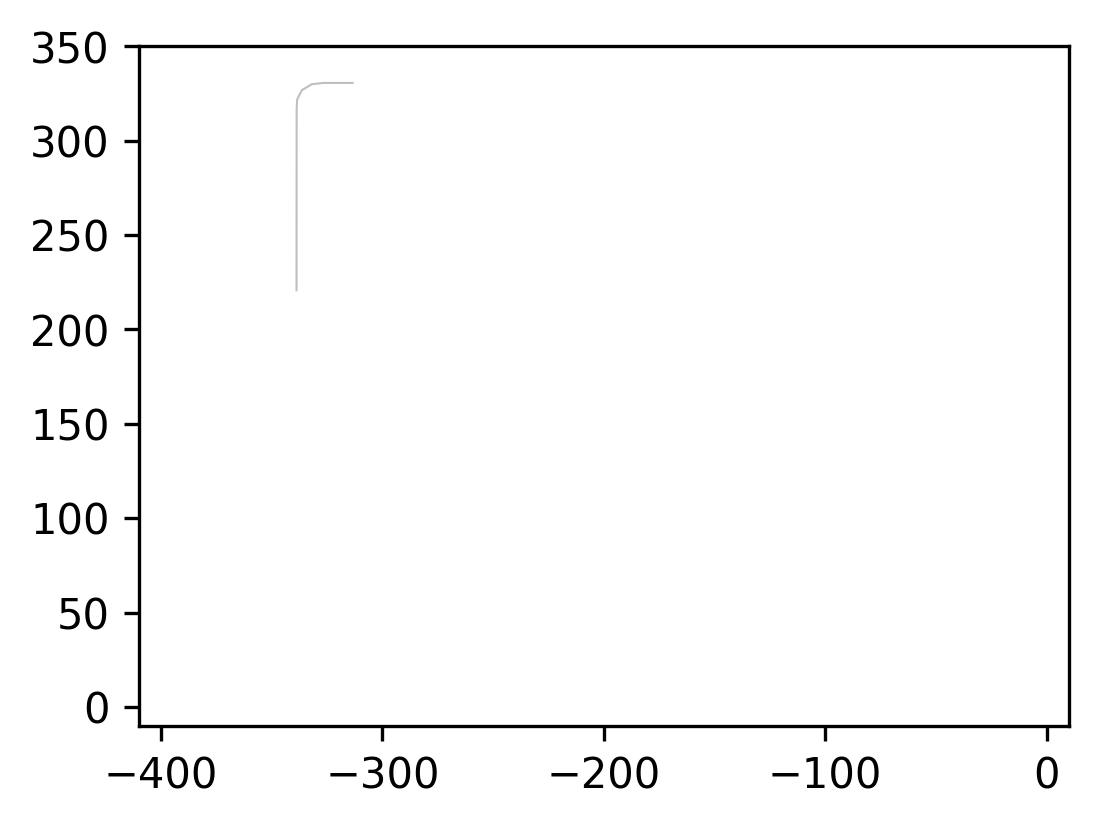

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_316.npy


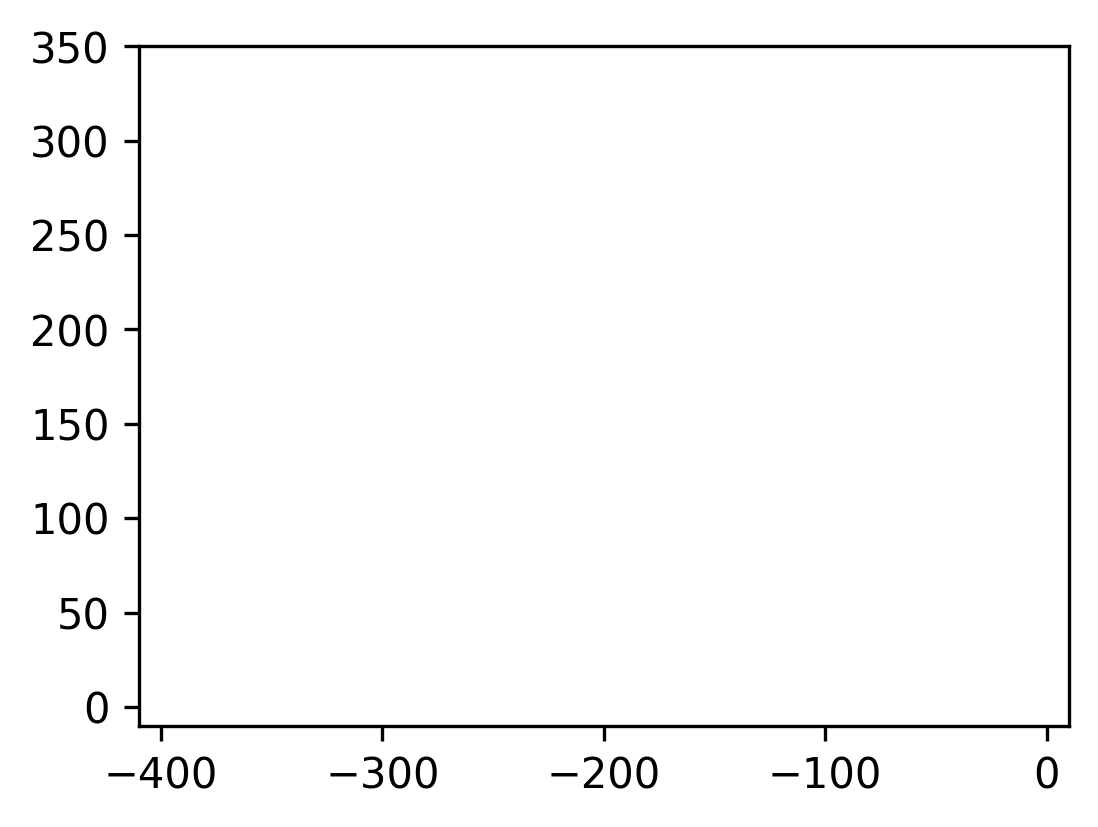

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_286.npy


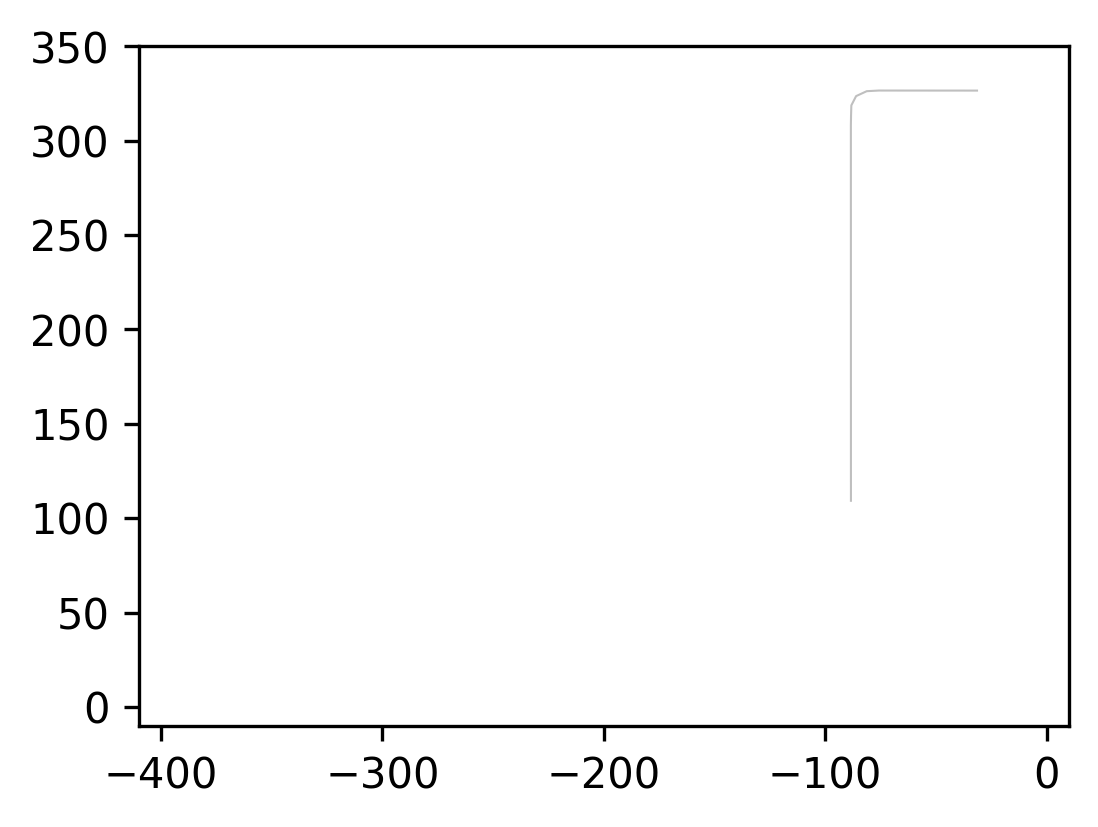

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_279.npy


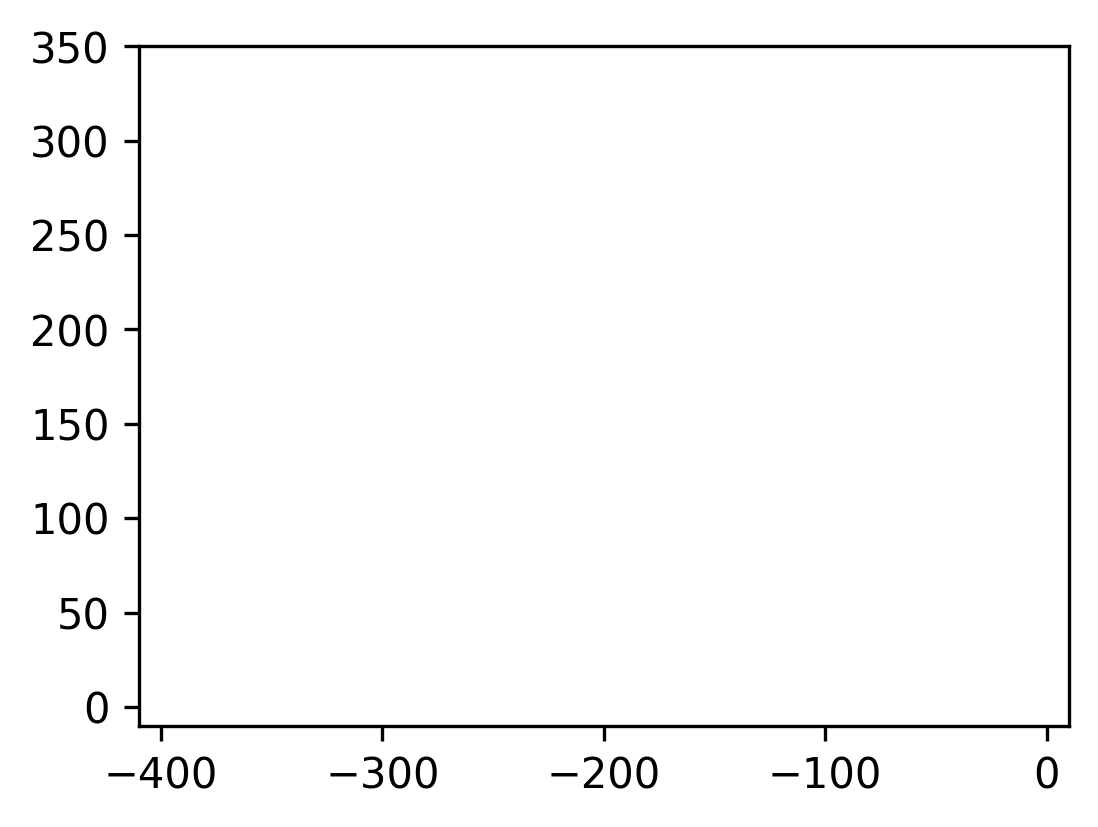

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_373.npy


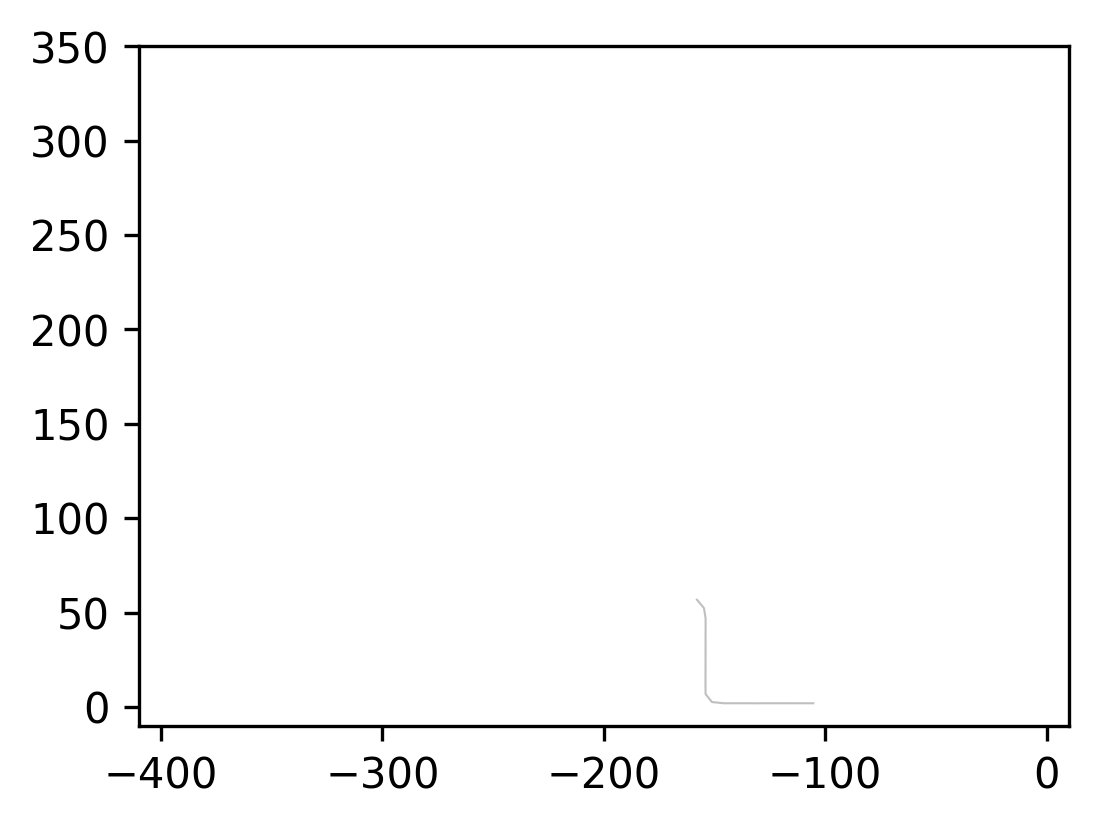

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_350.npy


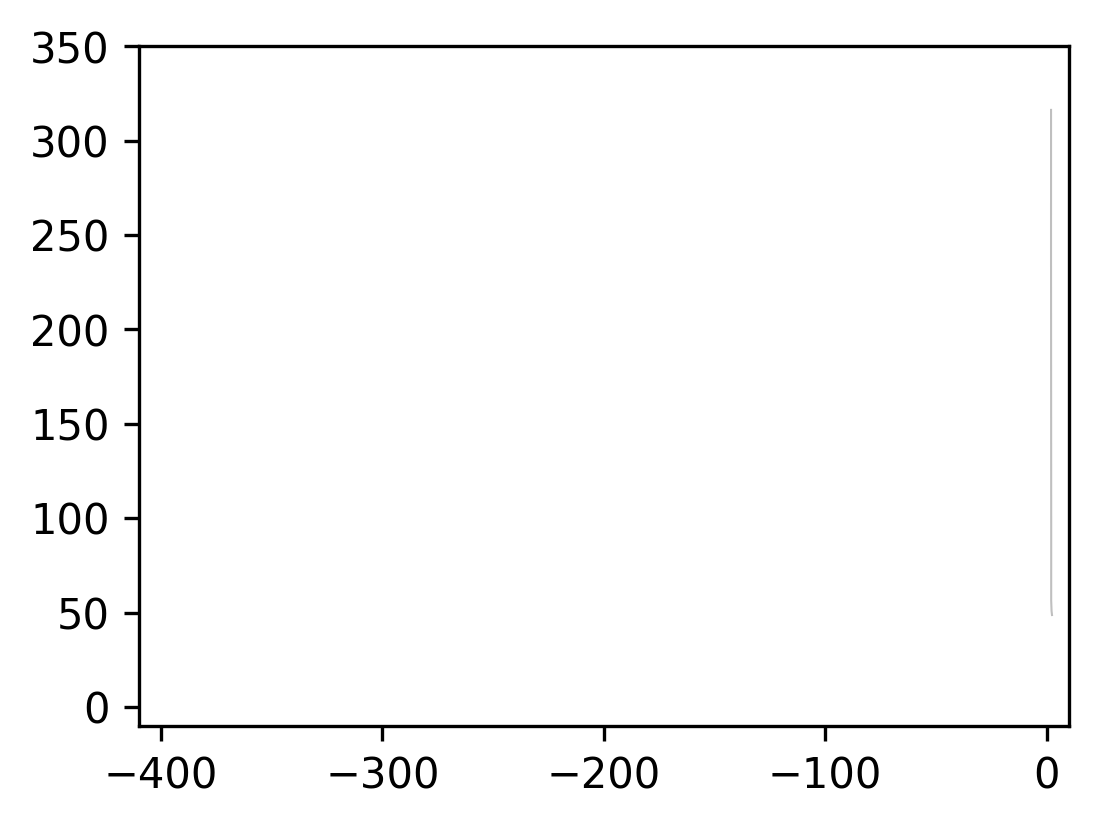

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_269.npy


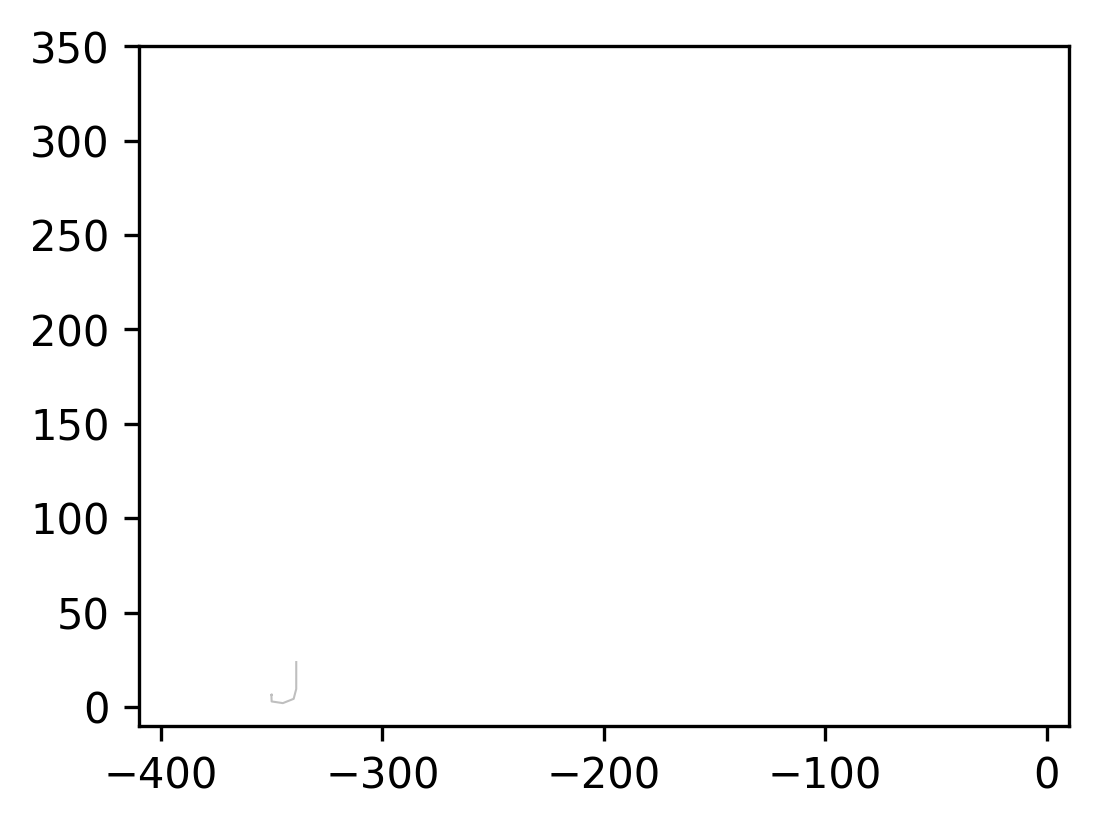

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_237.npy


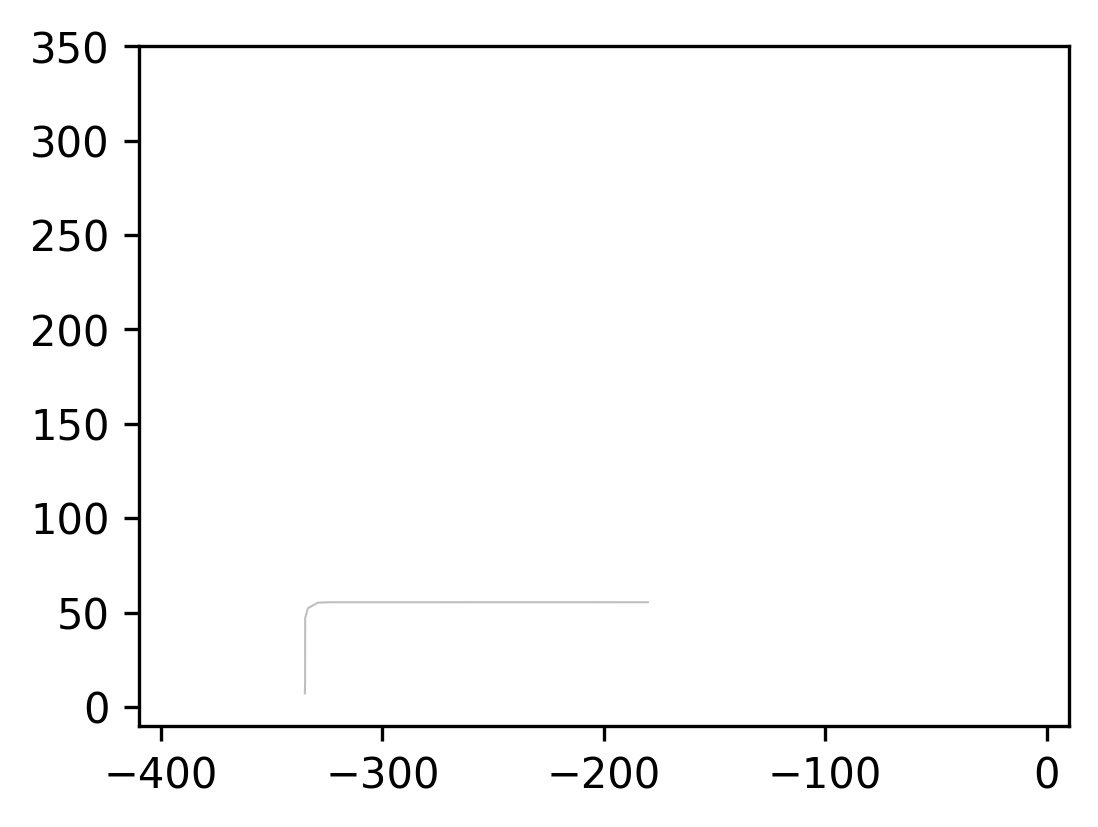

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_84.npy


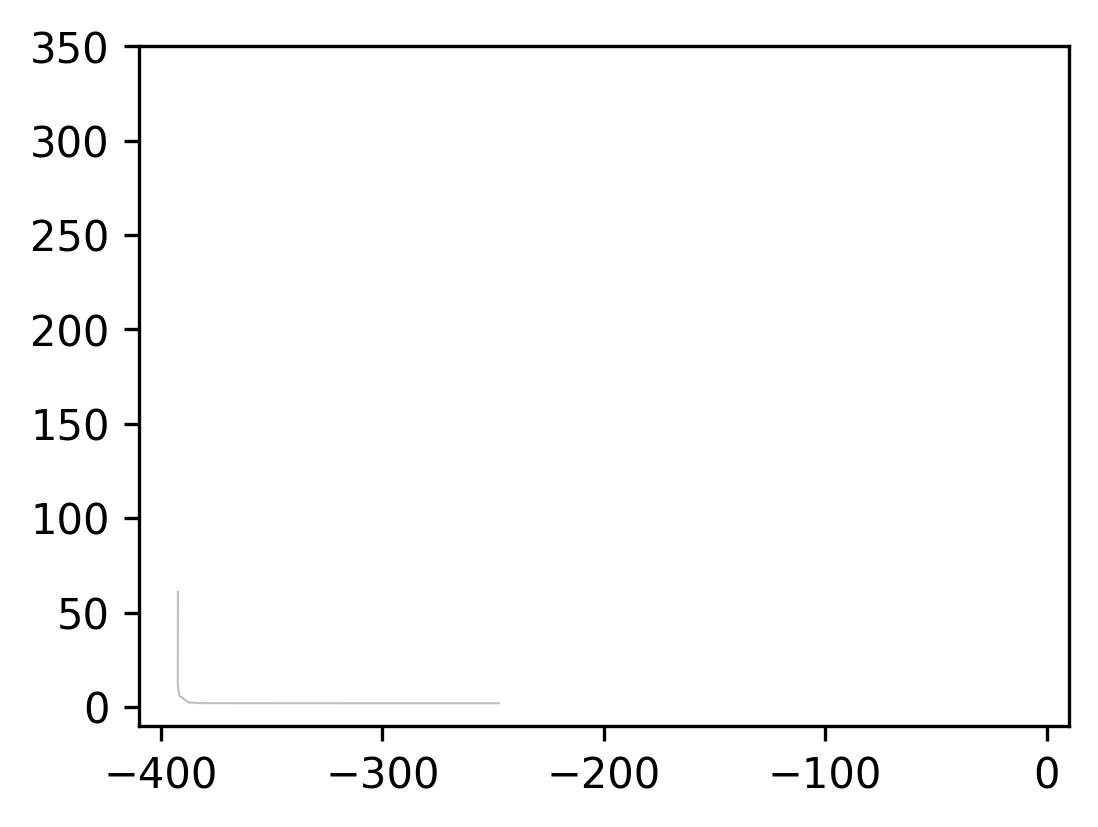

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_127.npy


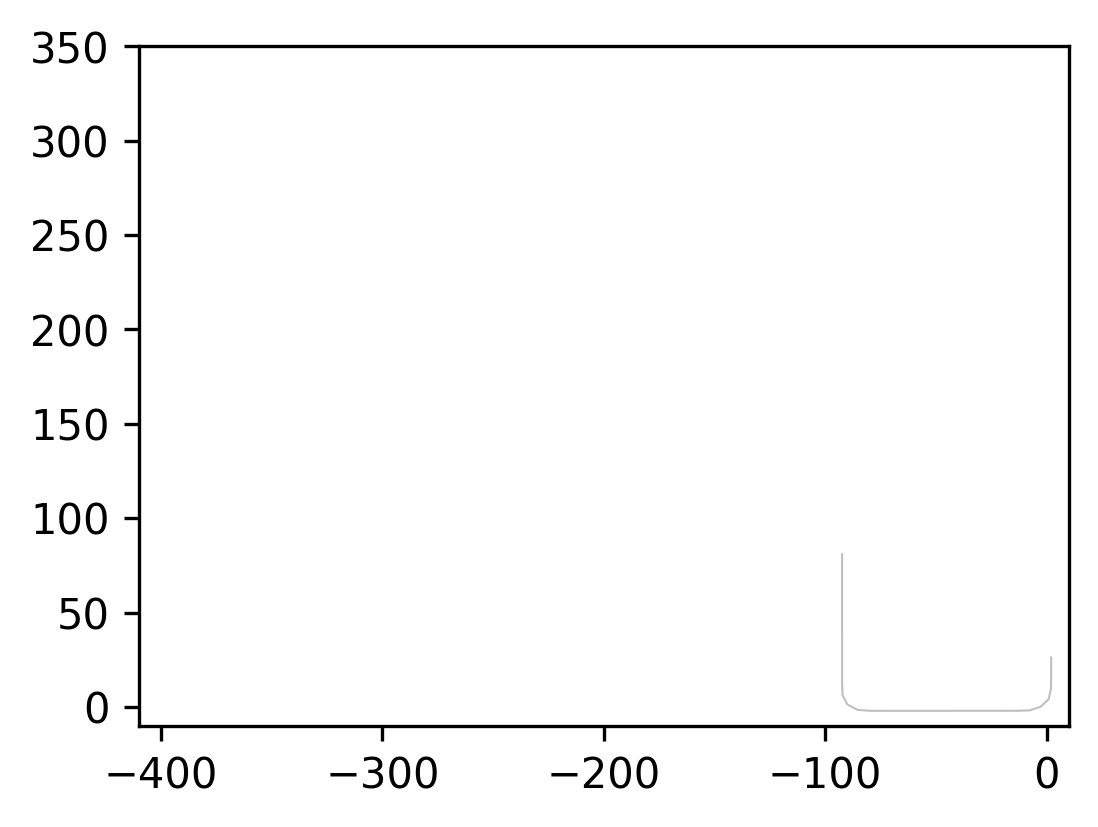

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_294.npy


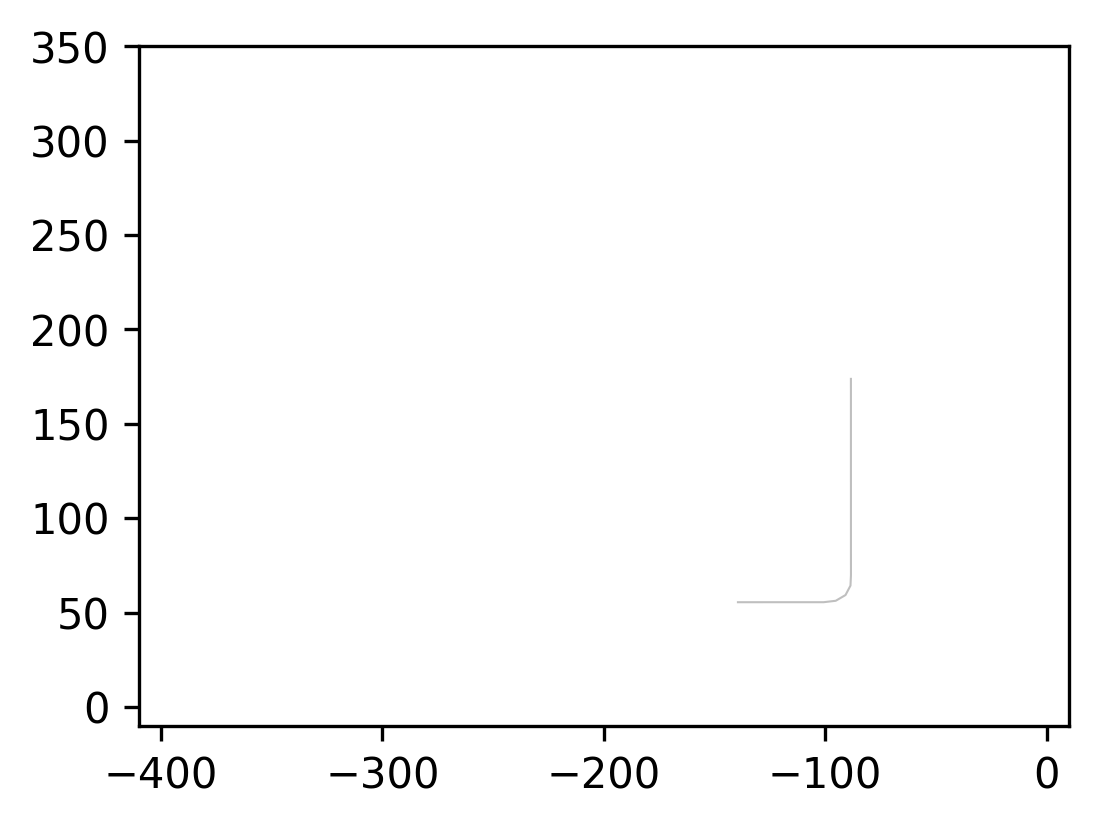

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_370.npy


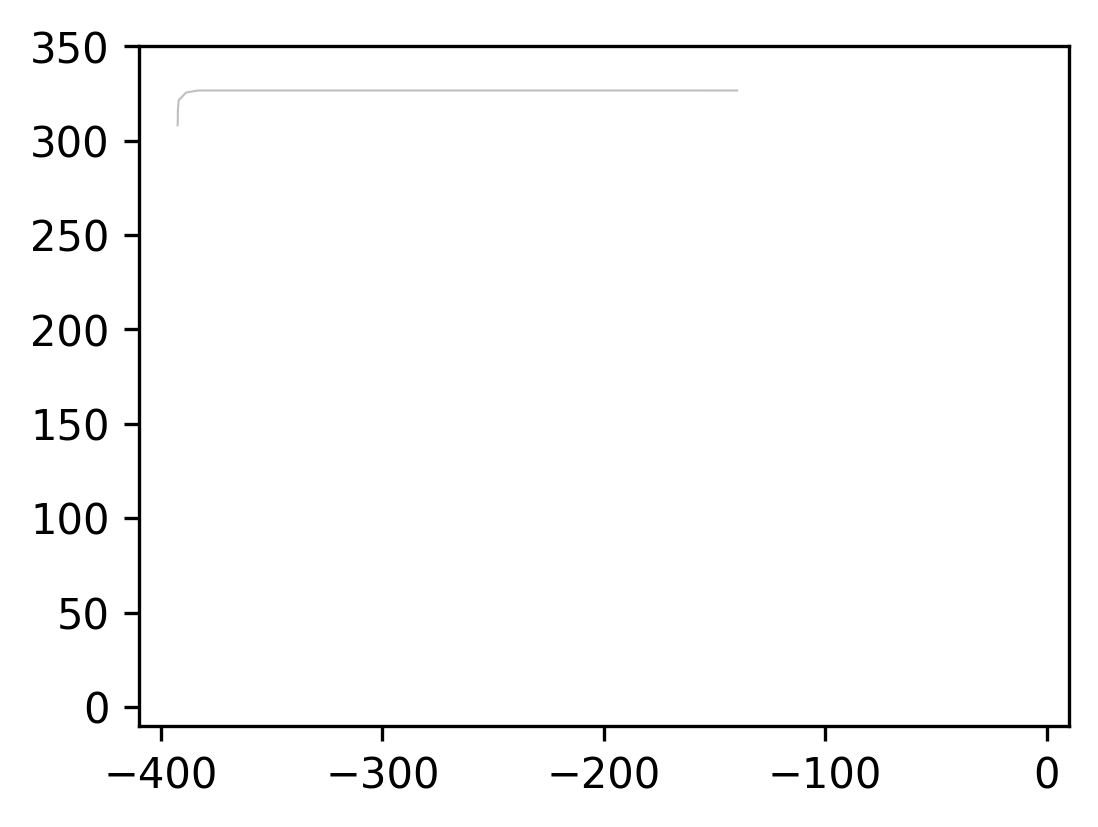

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_174.npy


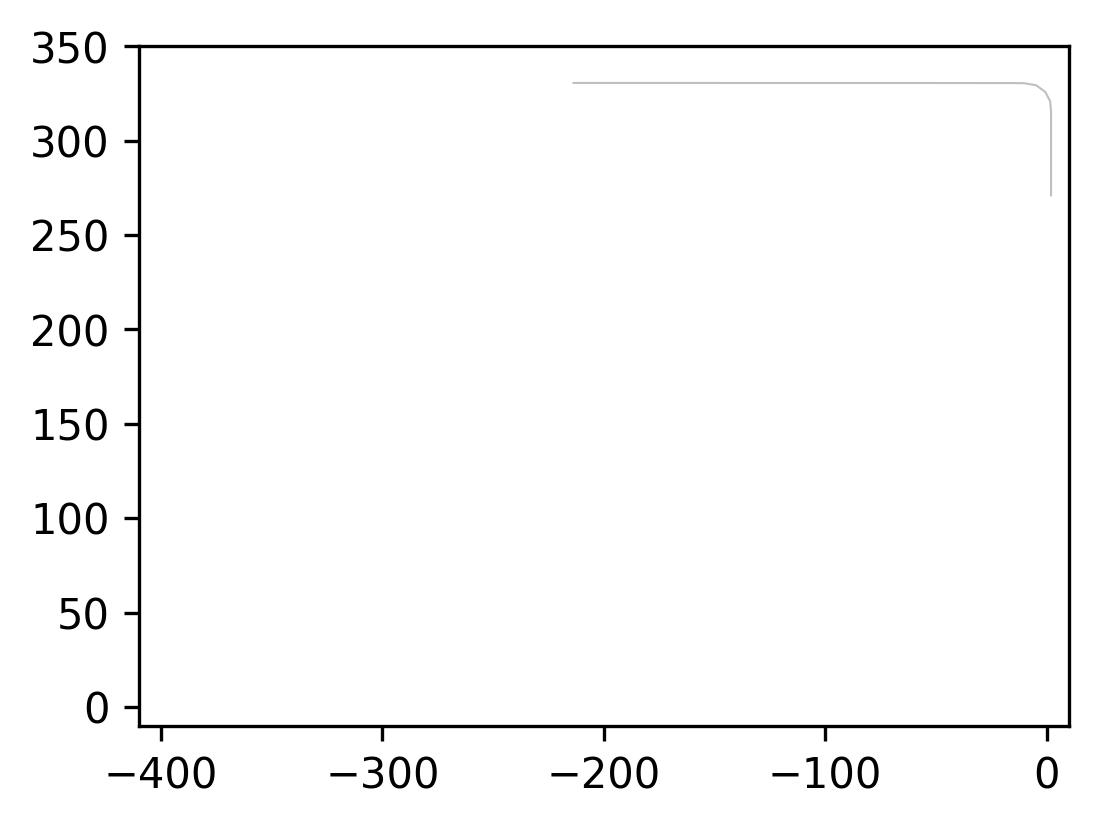

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_367.npy


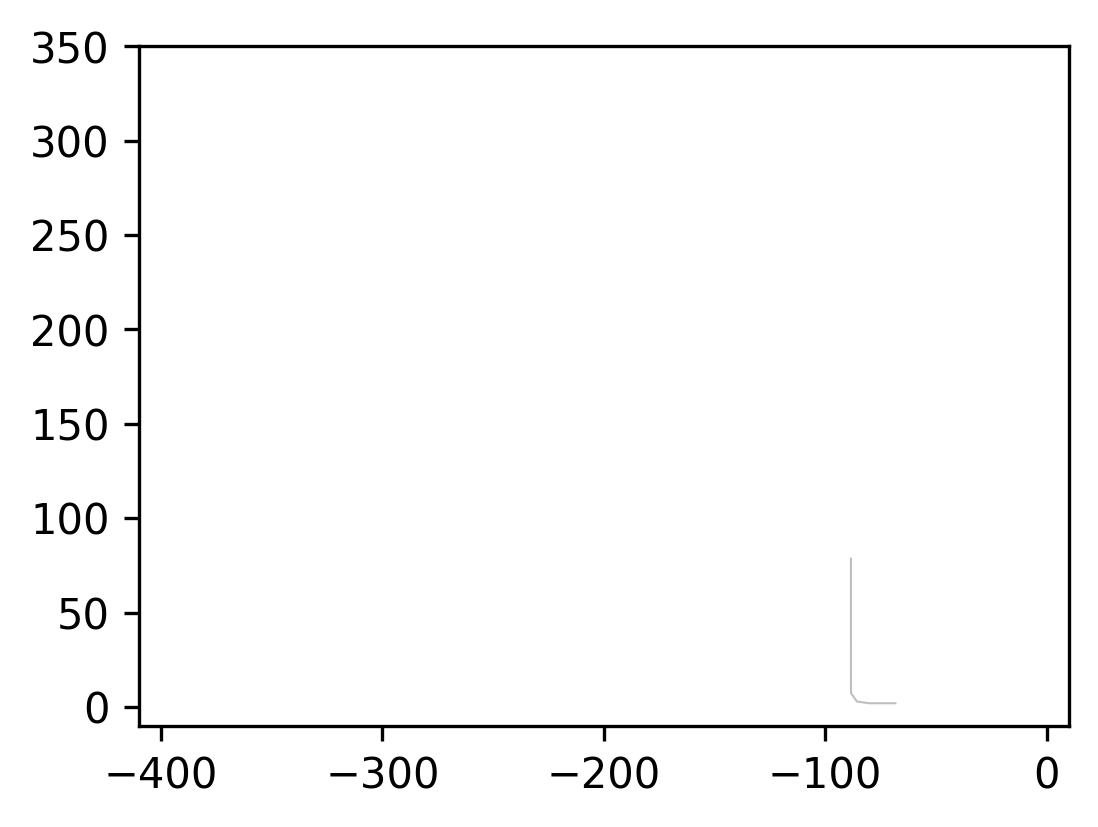

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_517.npy


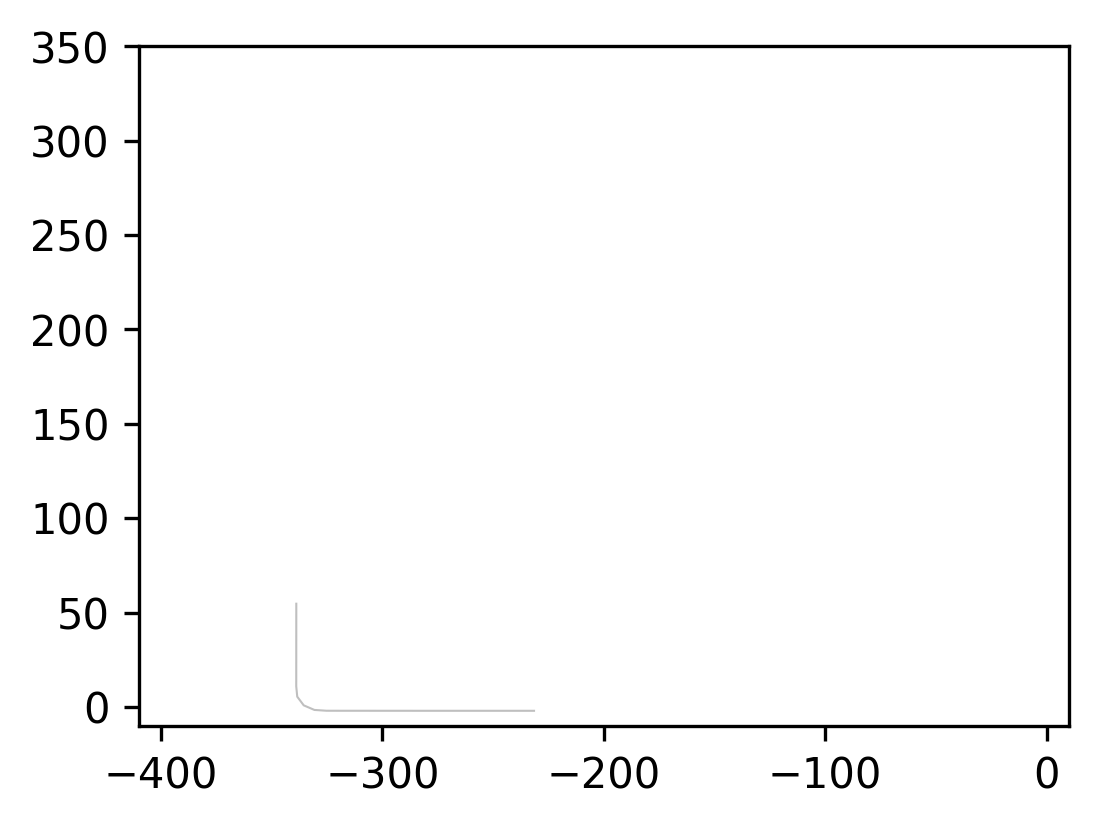

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_122.npy


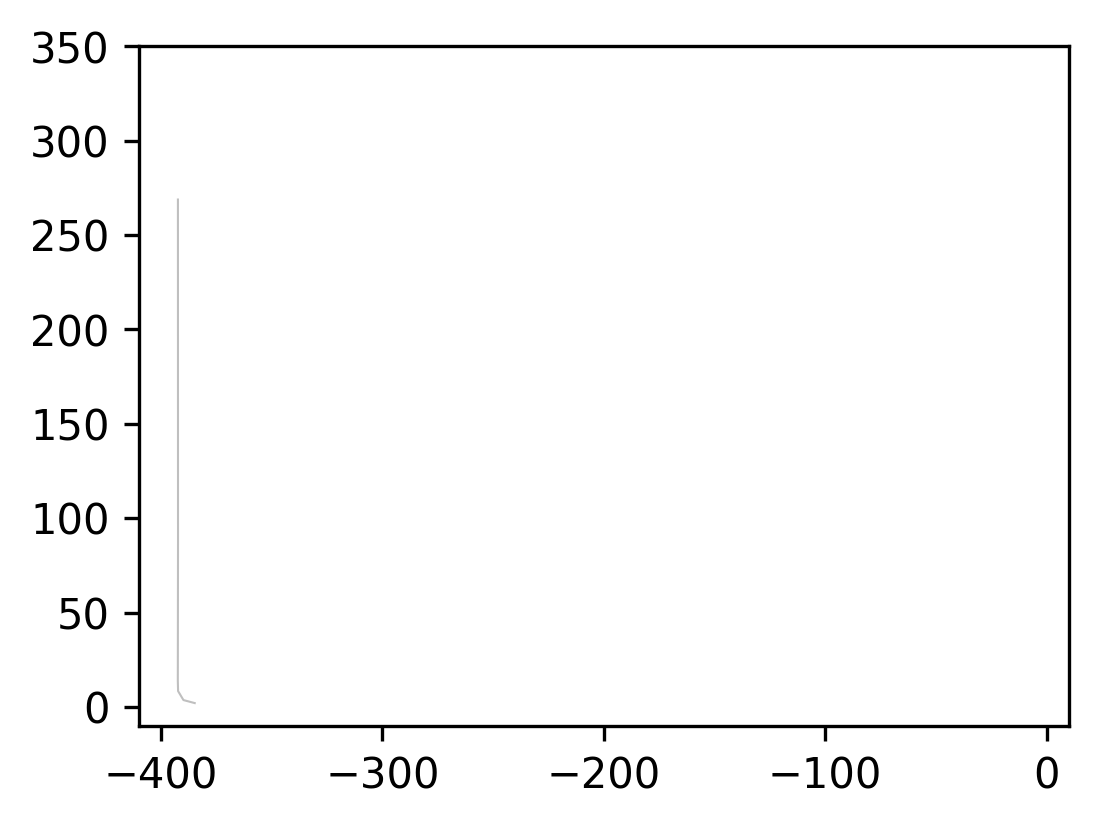

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_90.npy


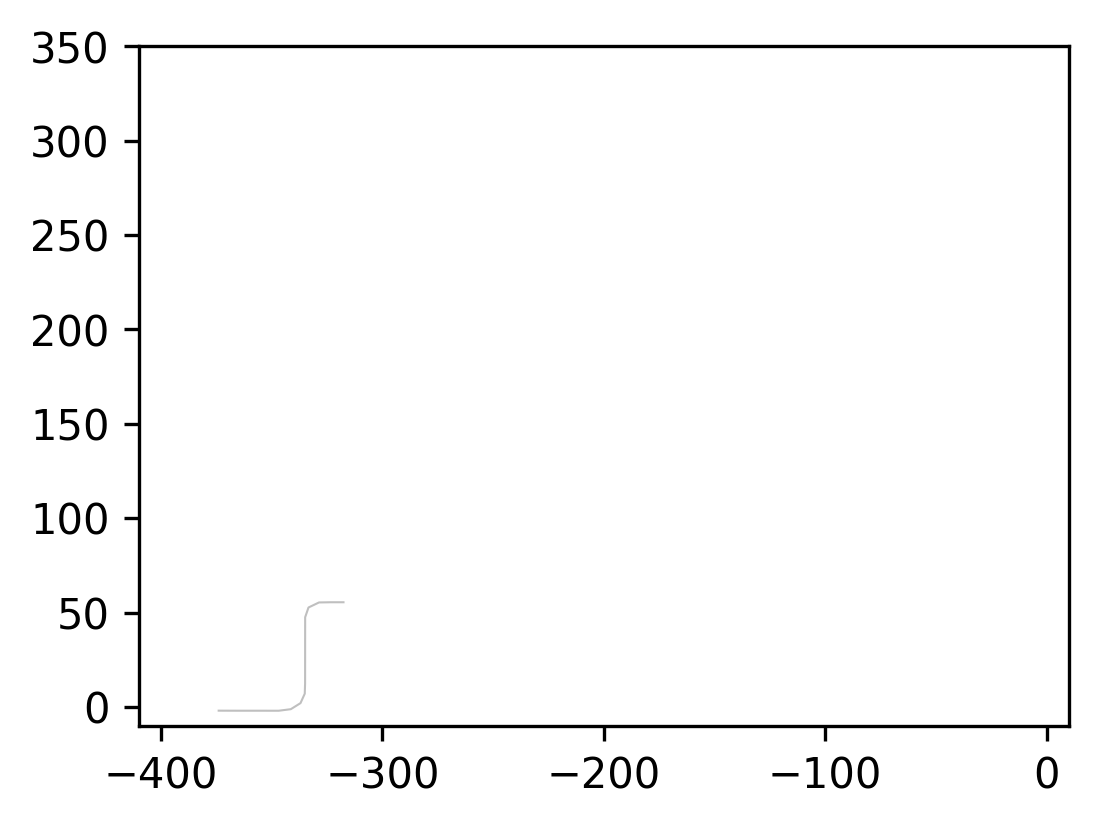

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_427.npy


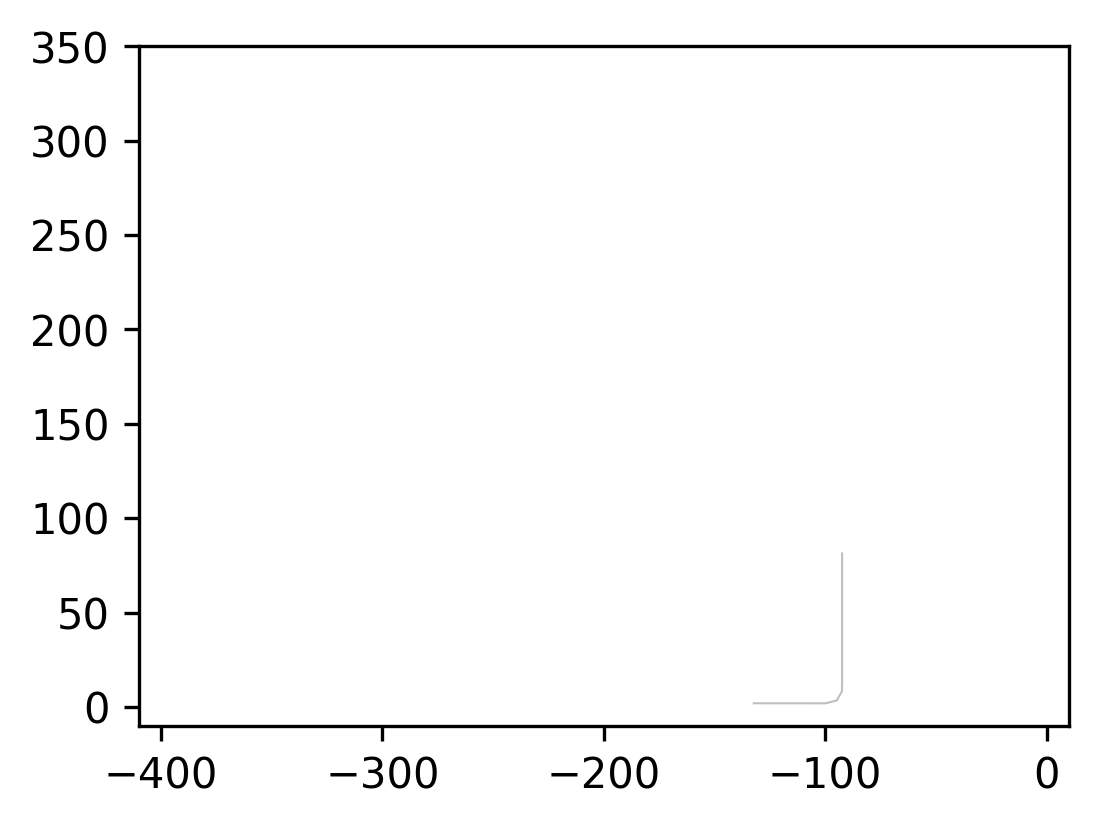

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_283.npy


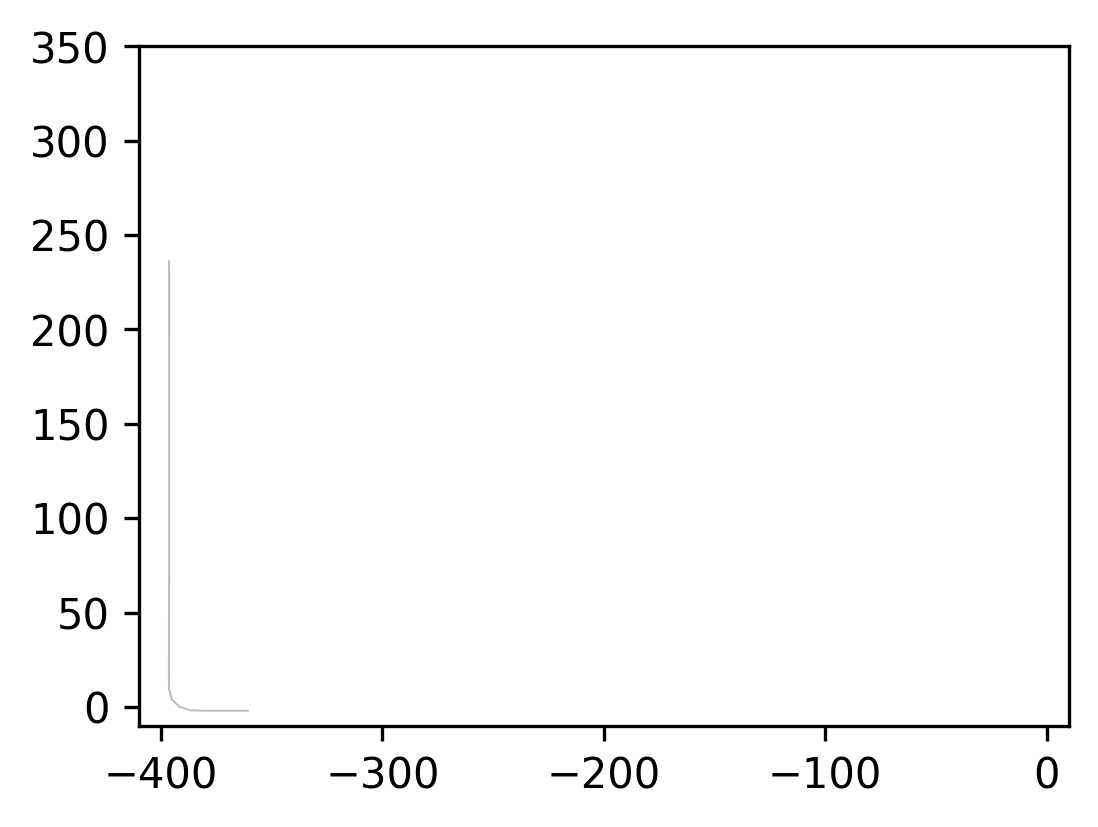

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_179.npy


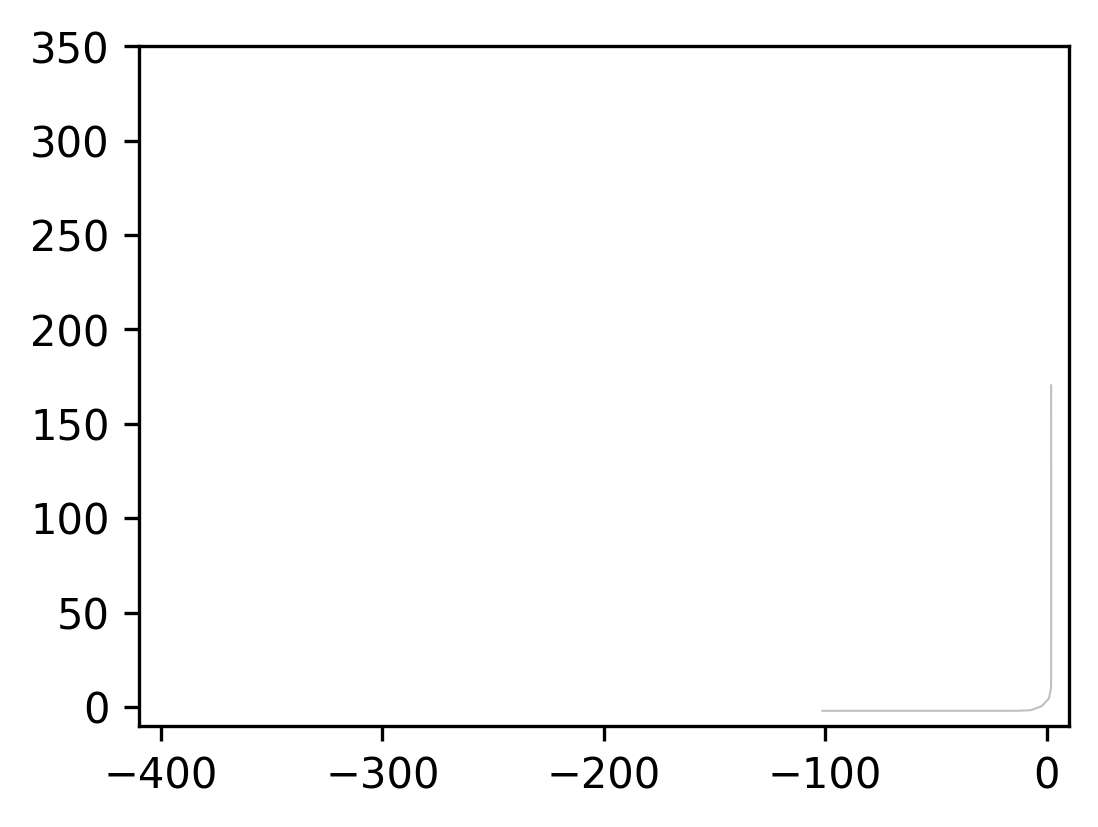

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_65.npy


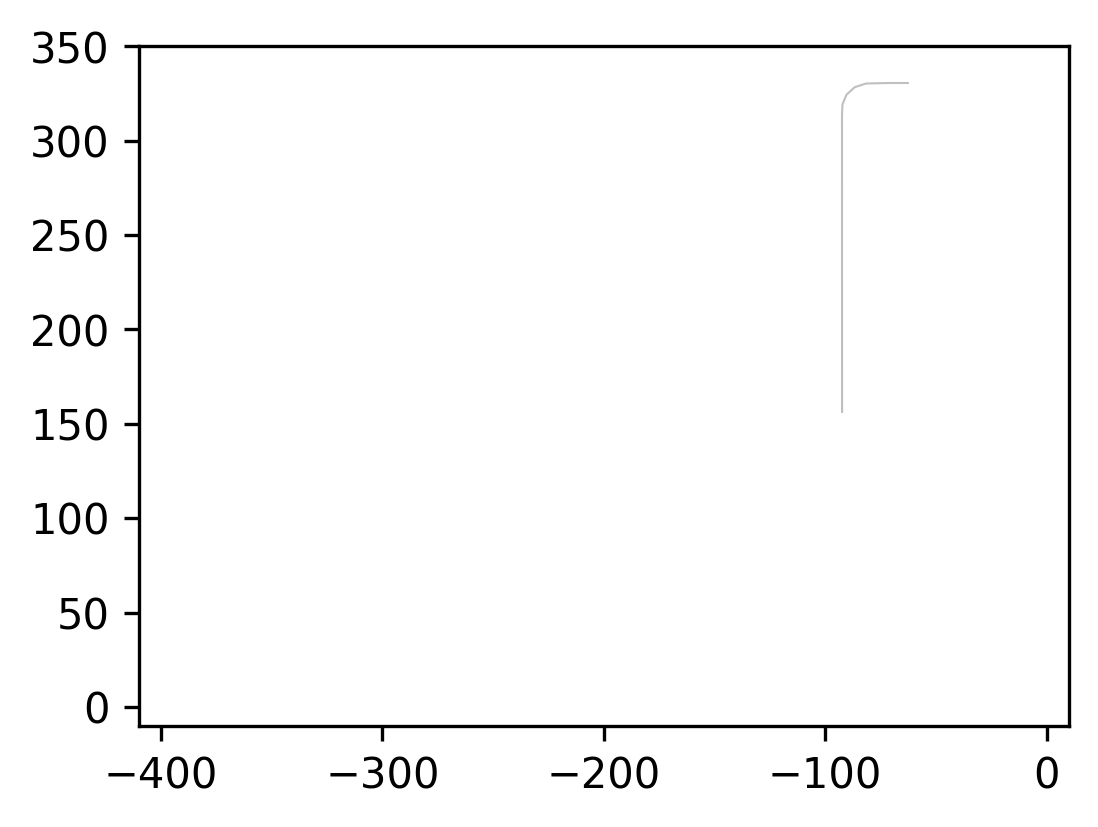

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_318.npy


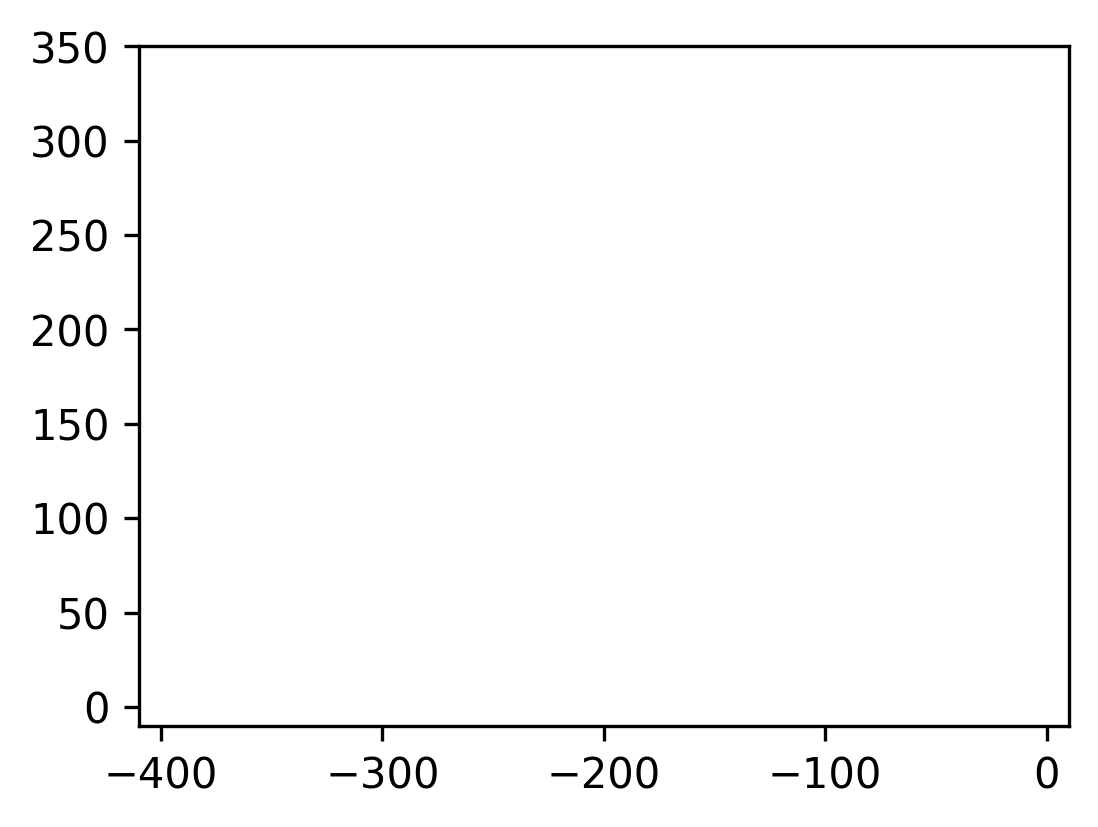

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_240.npy


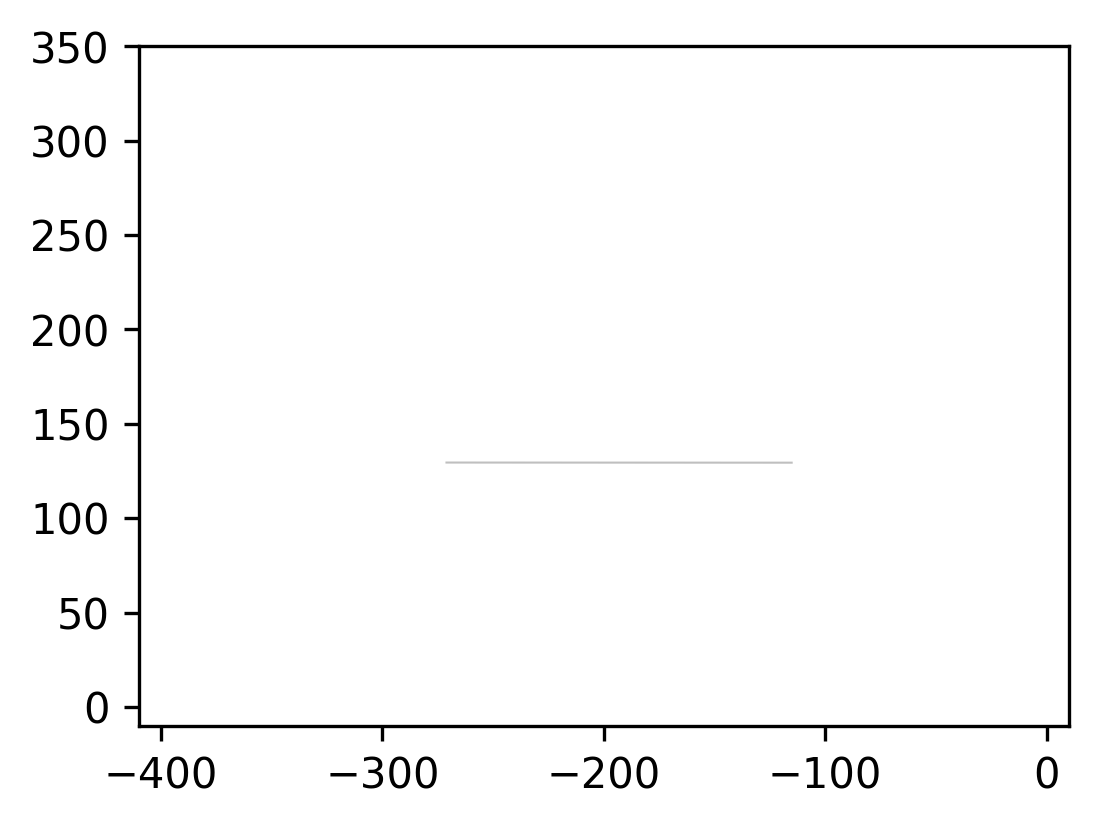

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_512.npy


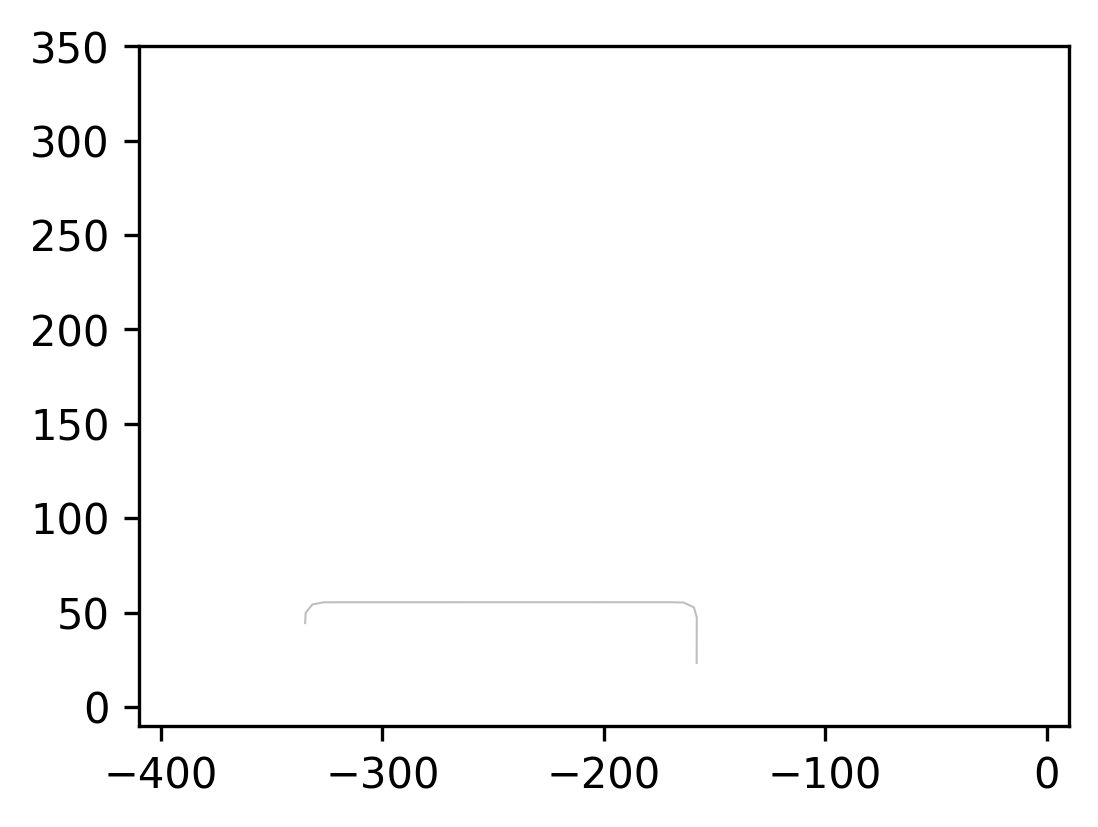

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_410.npy


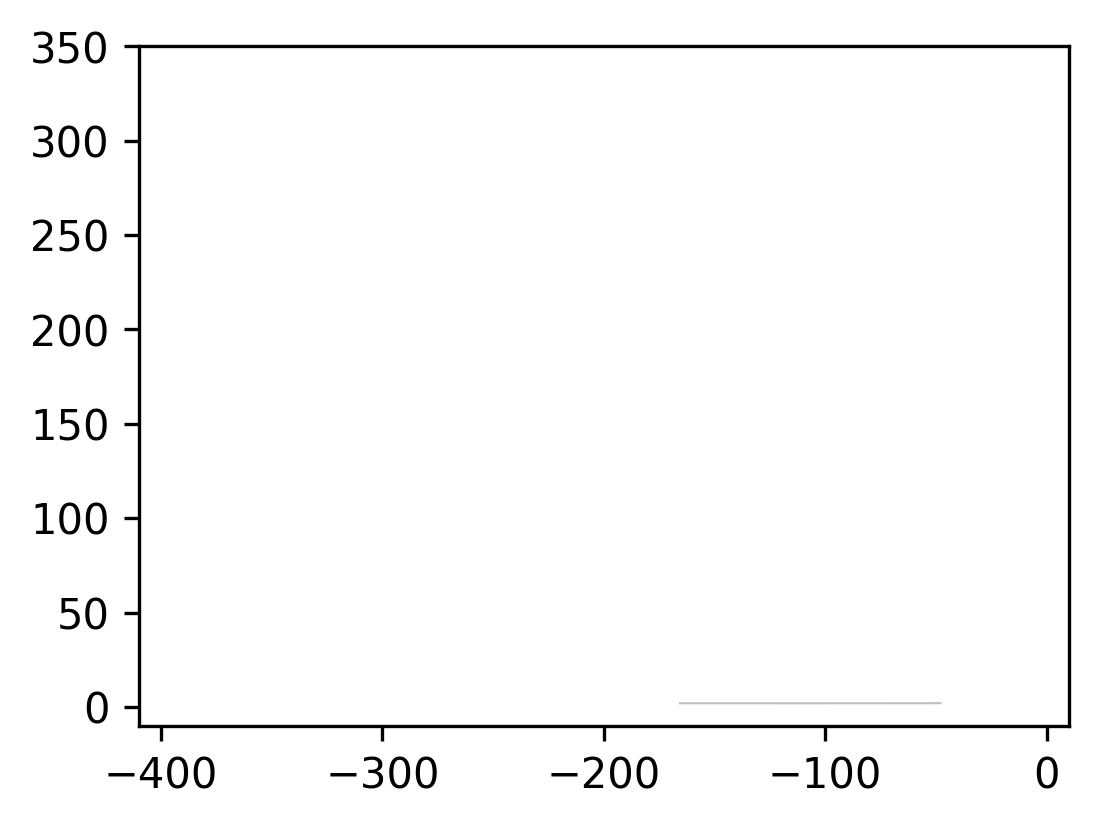

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_291.npy


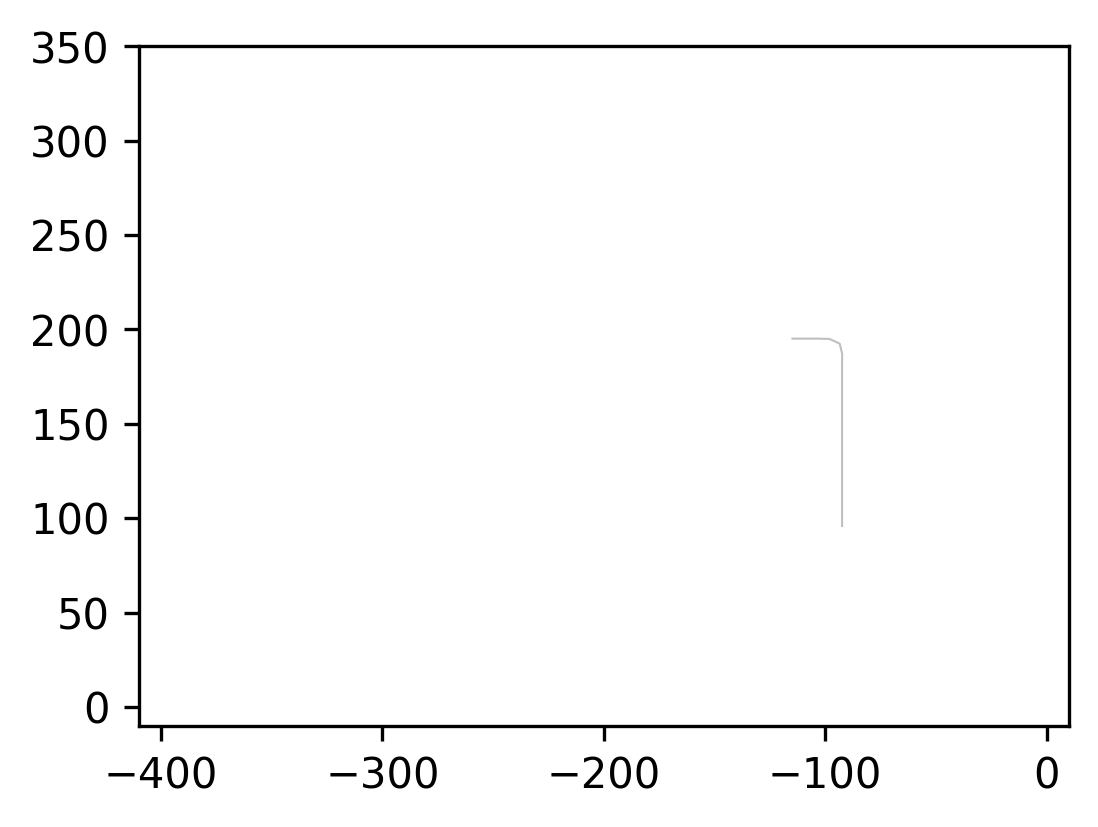

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_189.npy


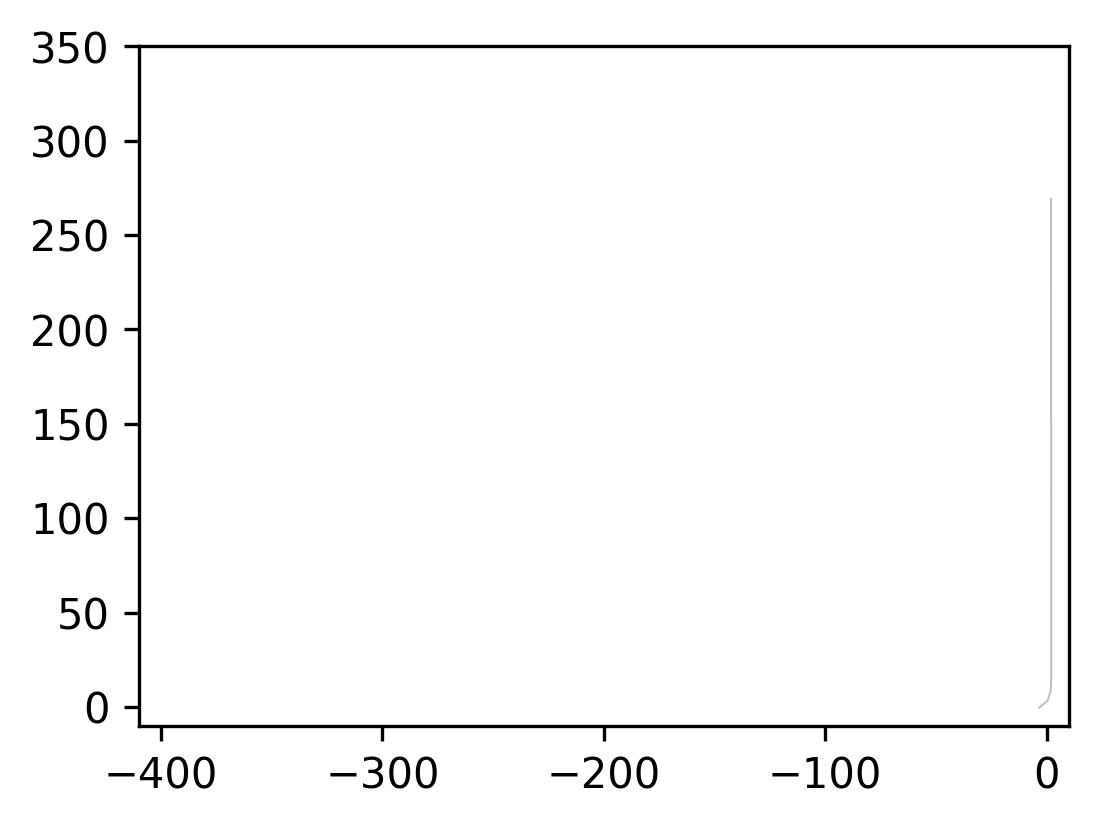

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_255.npy


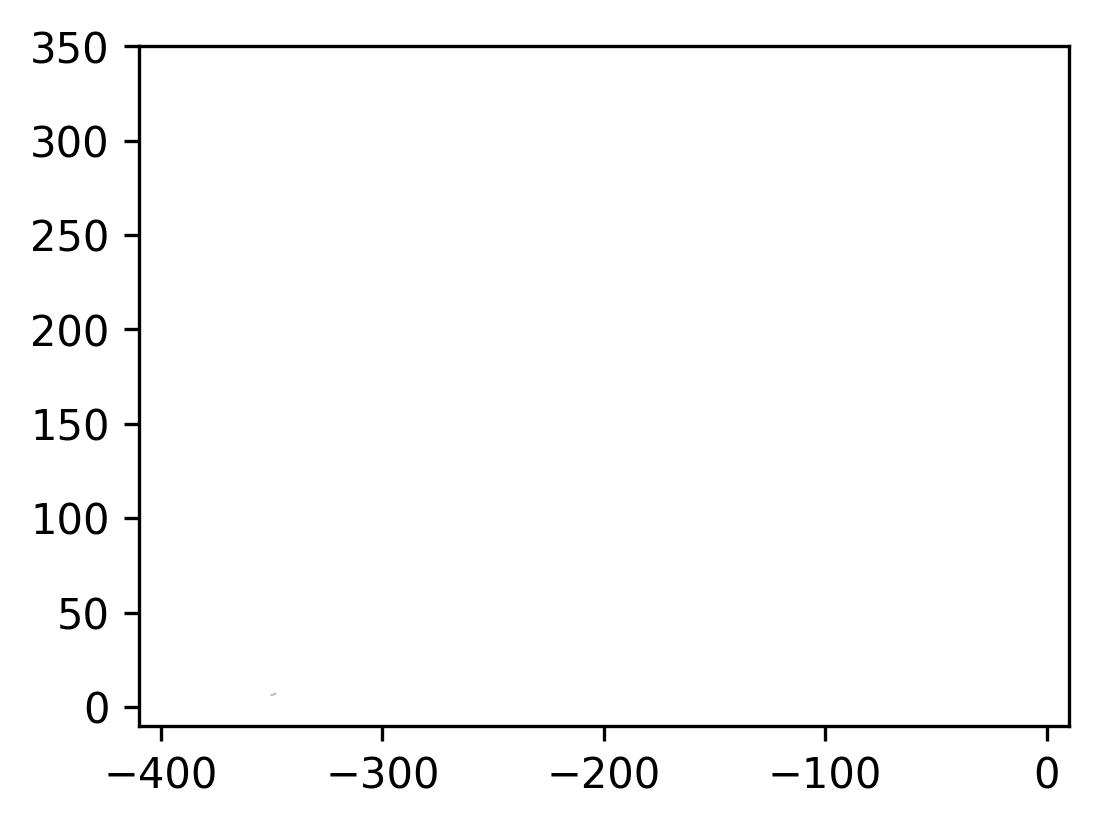

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_213.npy


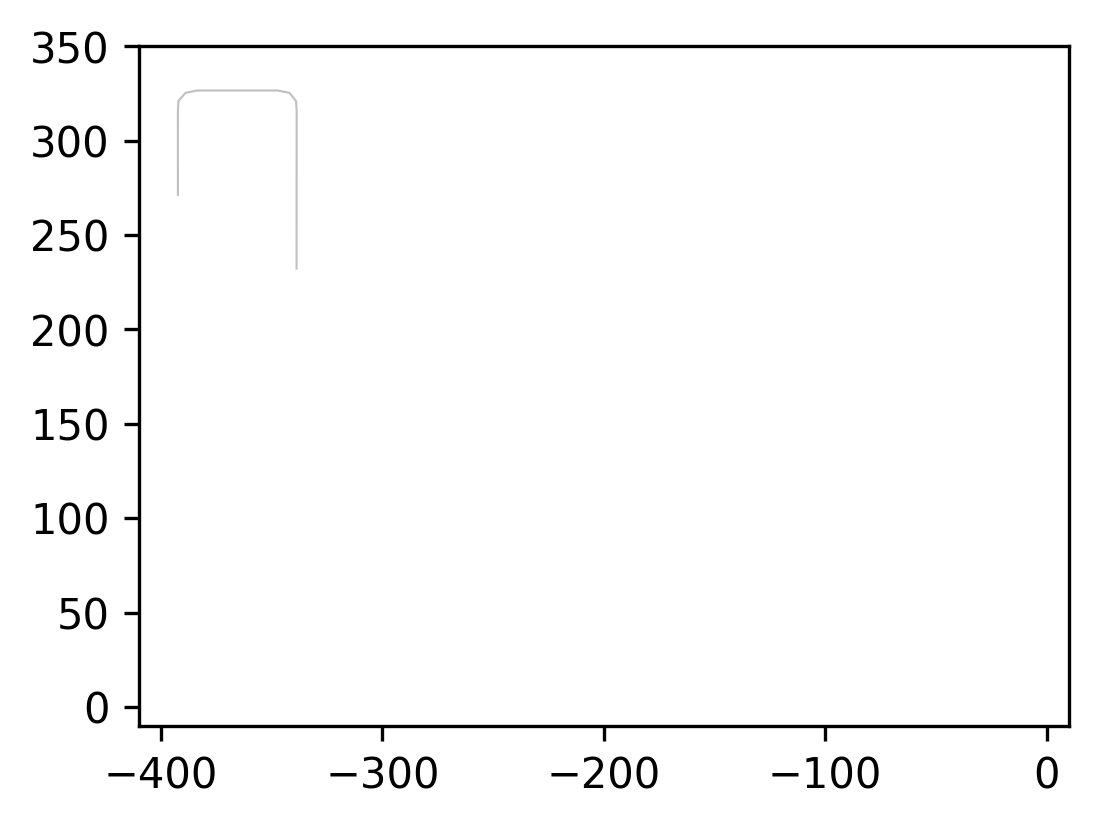

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_363.npy


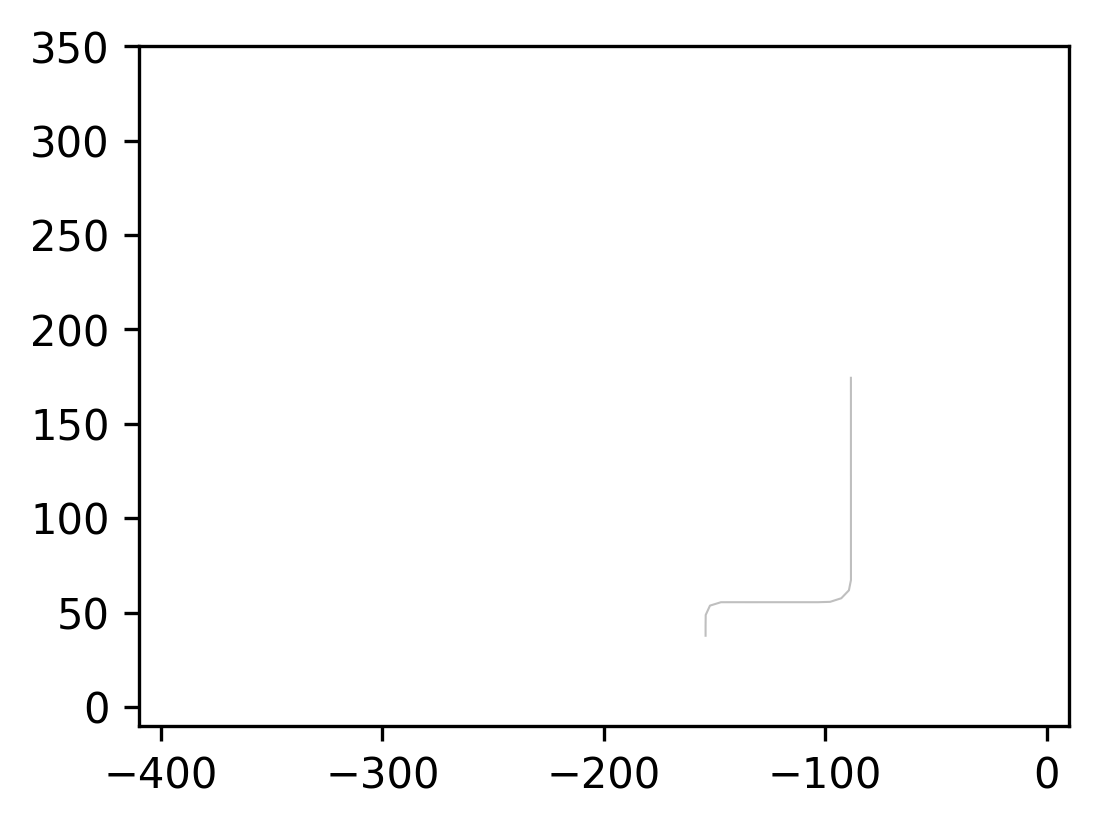

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_520.npy


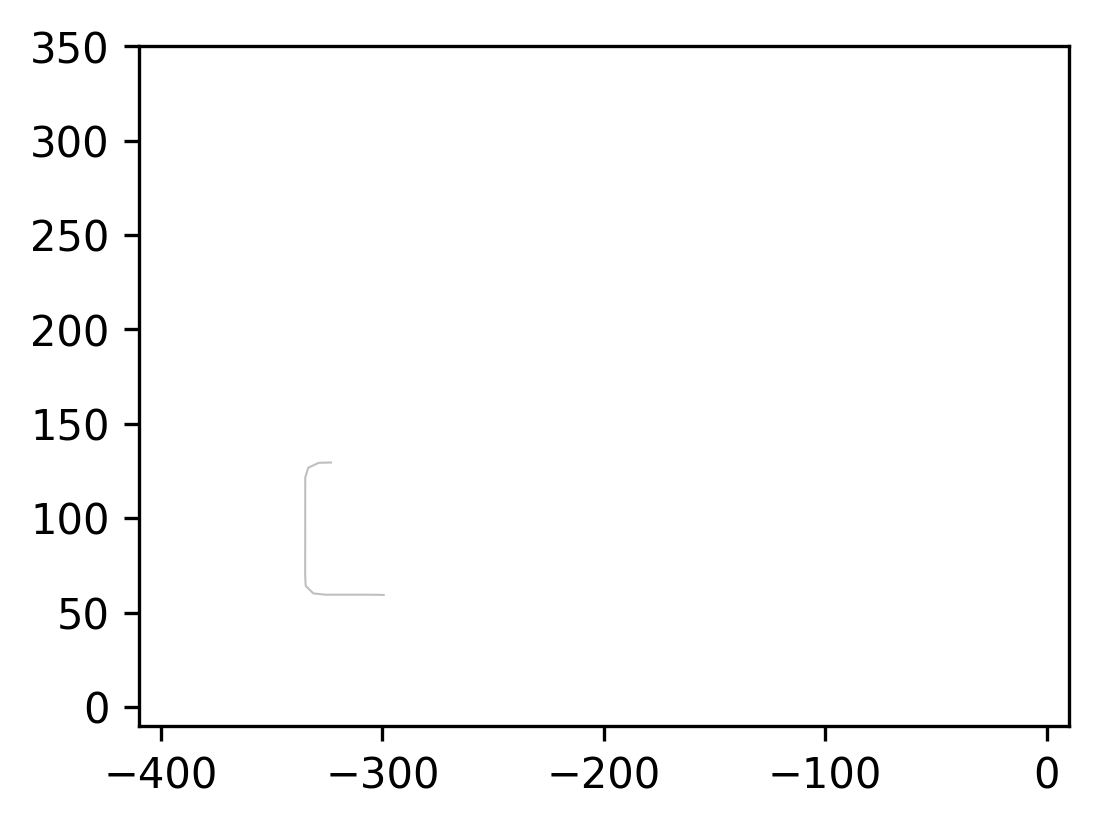

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_234.npy


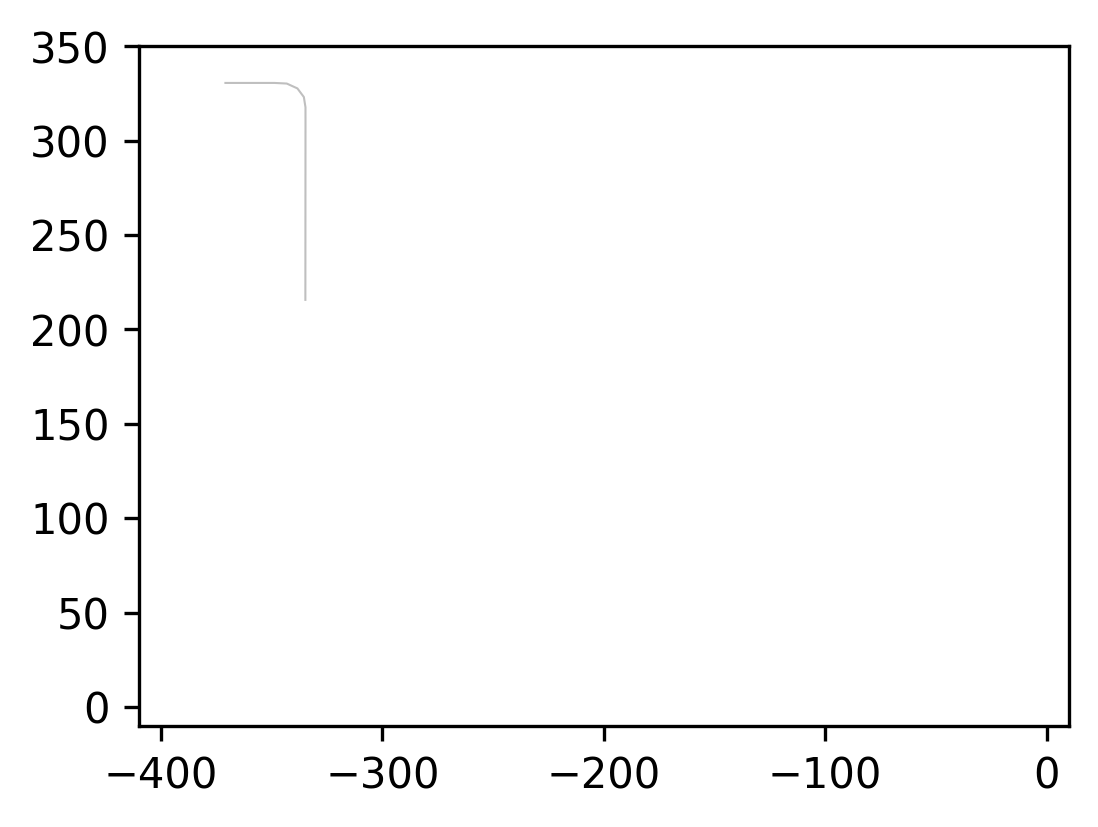

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_407.npy


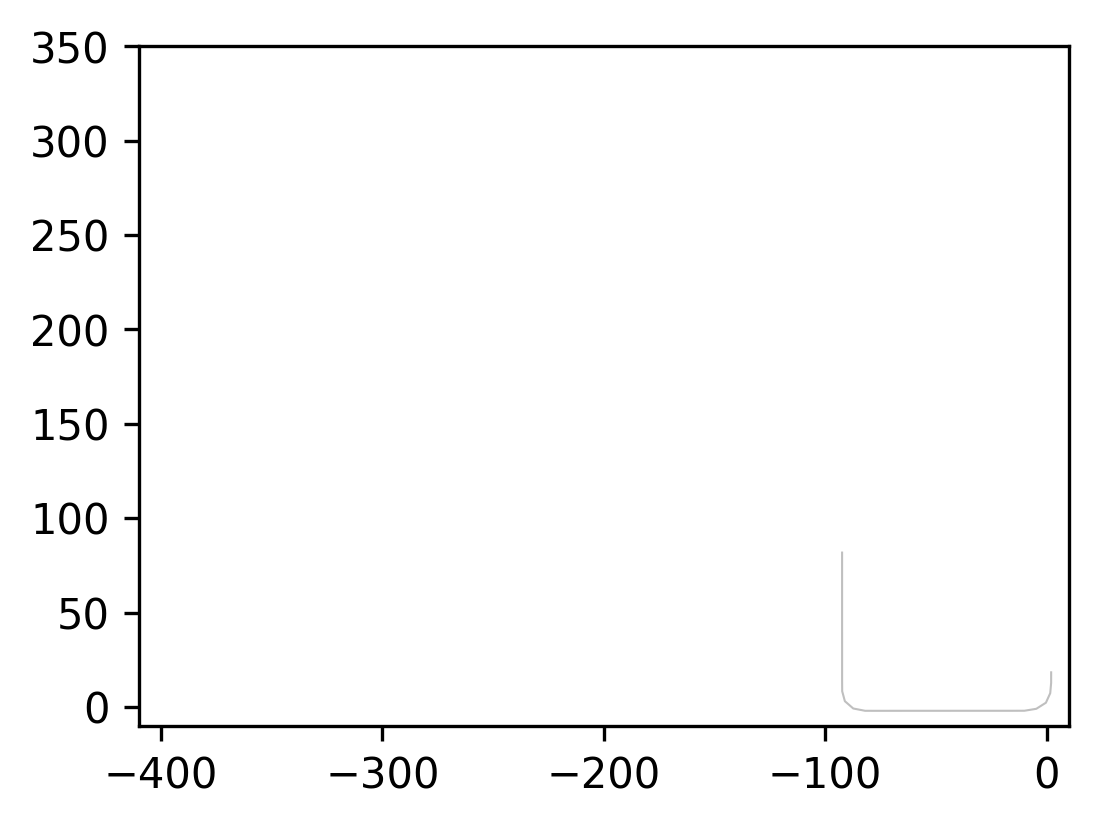

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_372.npy


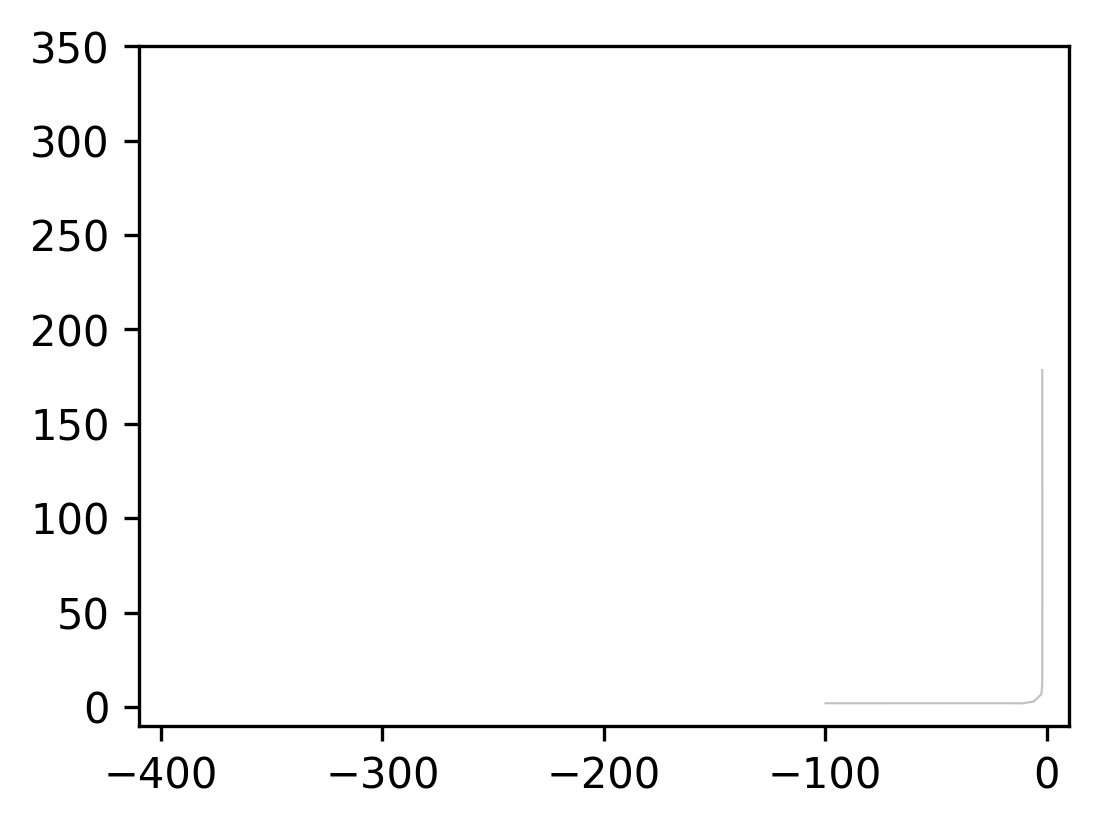

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_42.npy


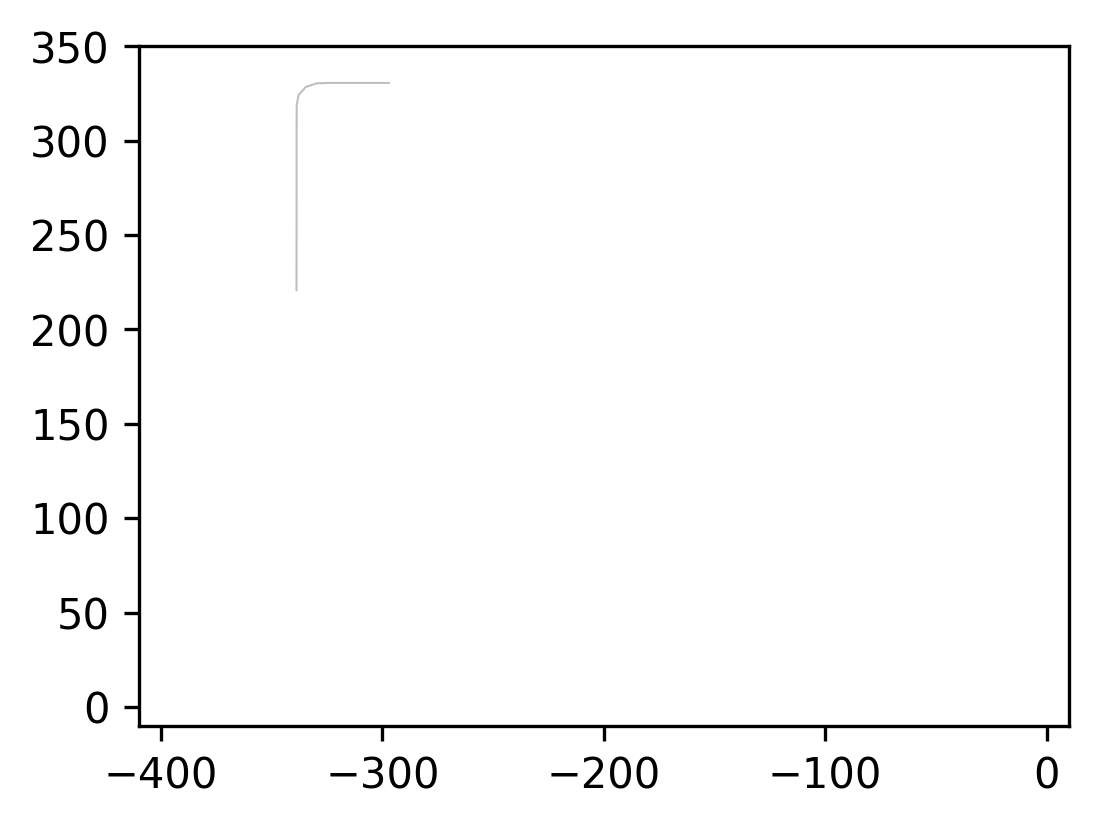

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_267.npy


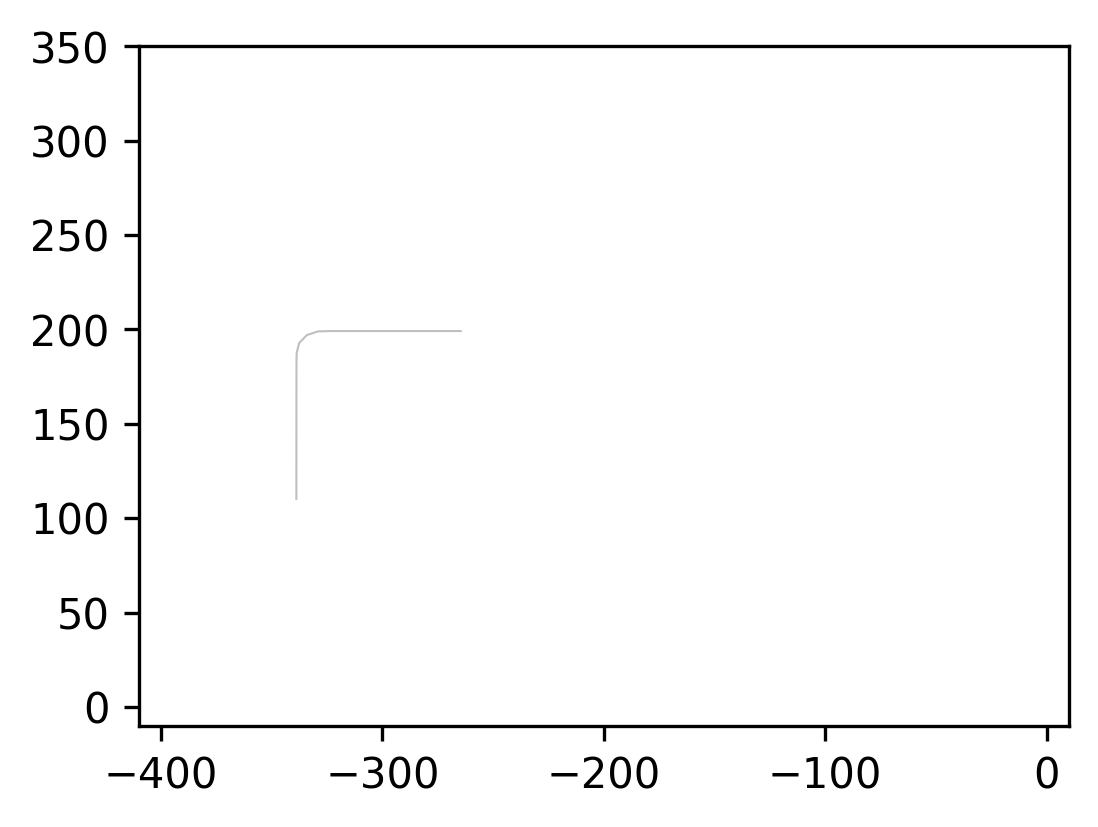

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_236.npy


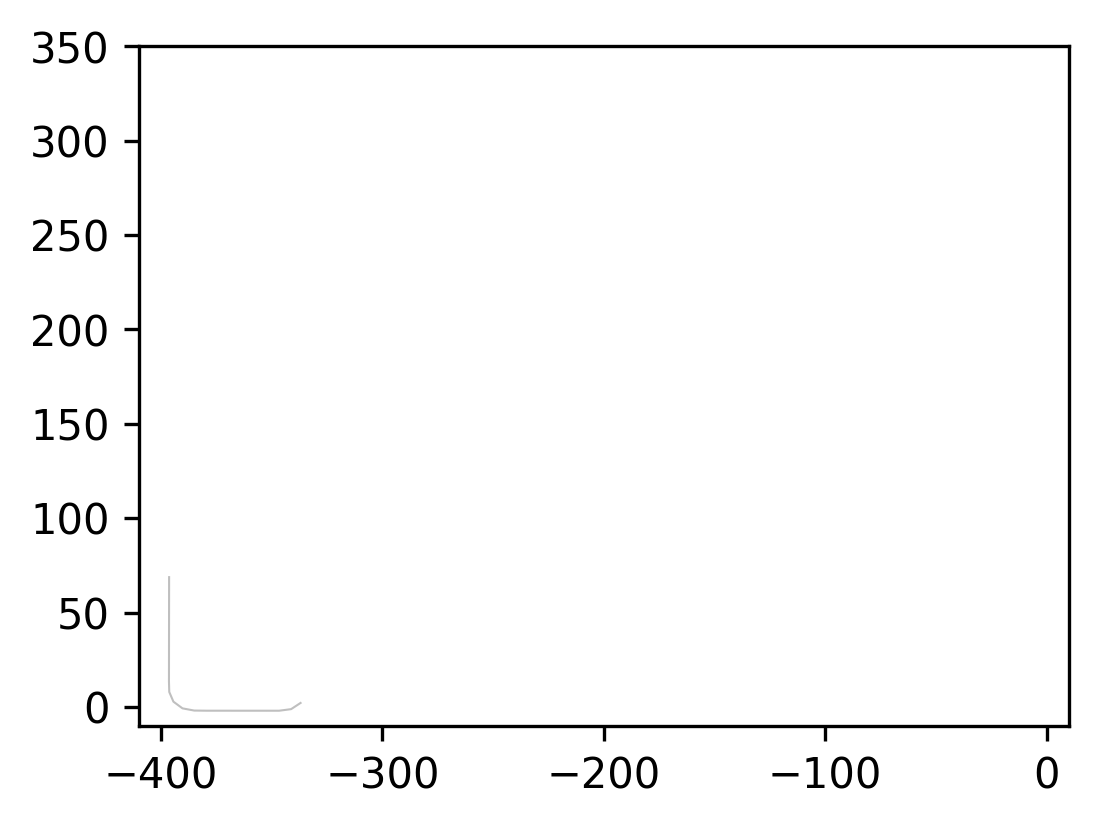

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_242.npy


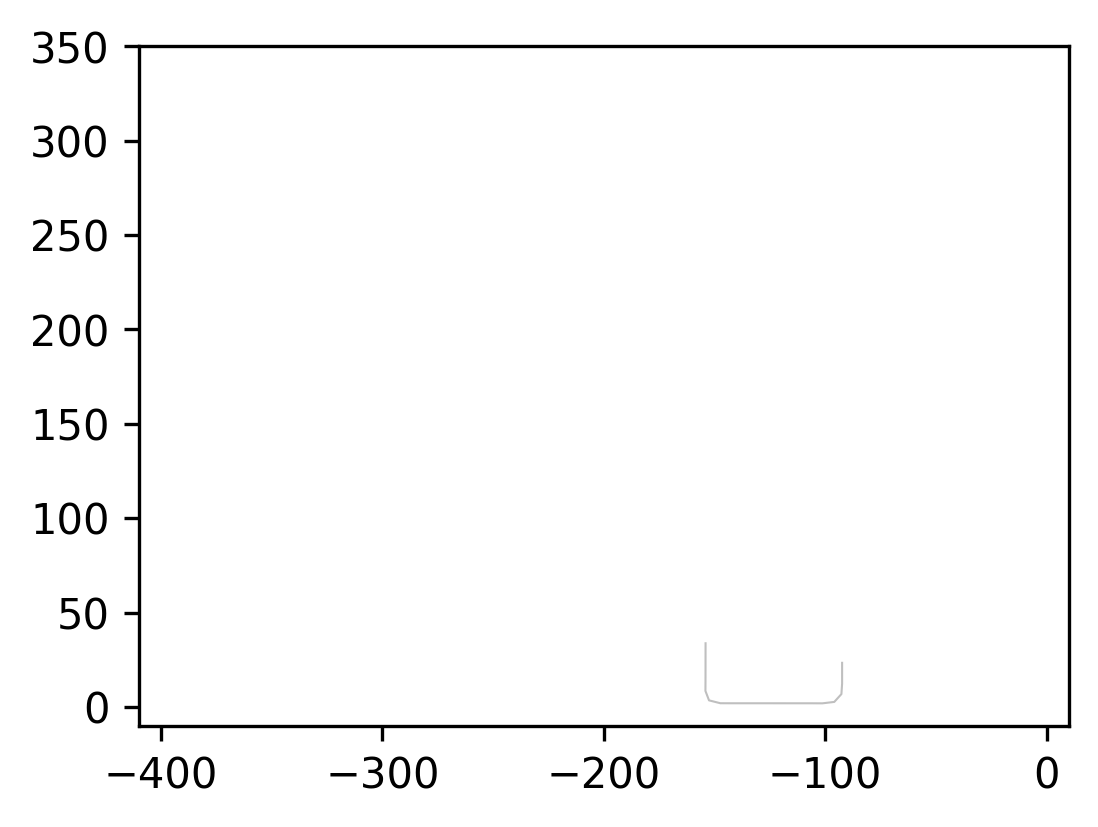

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_274.npy


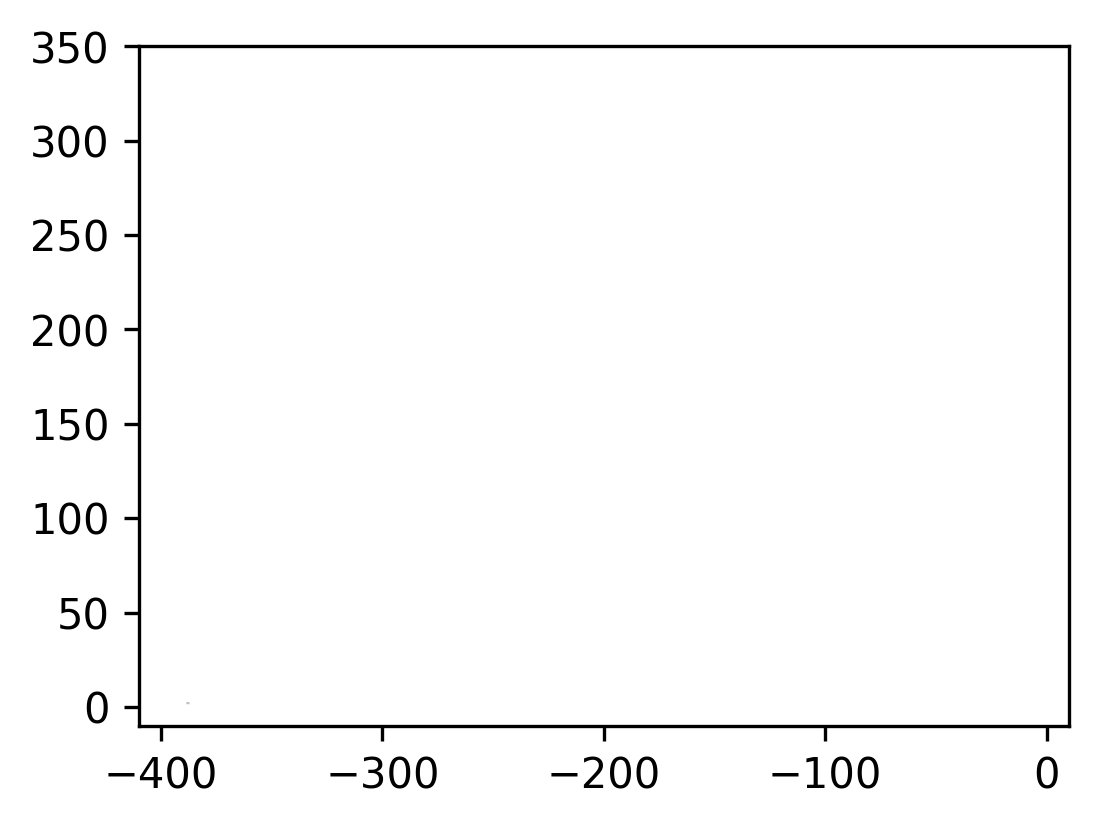

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_13.npy


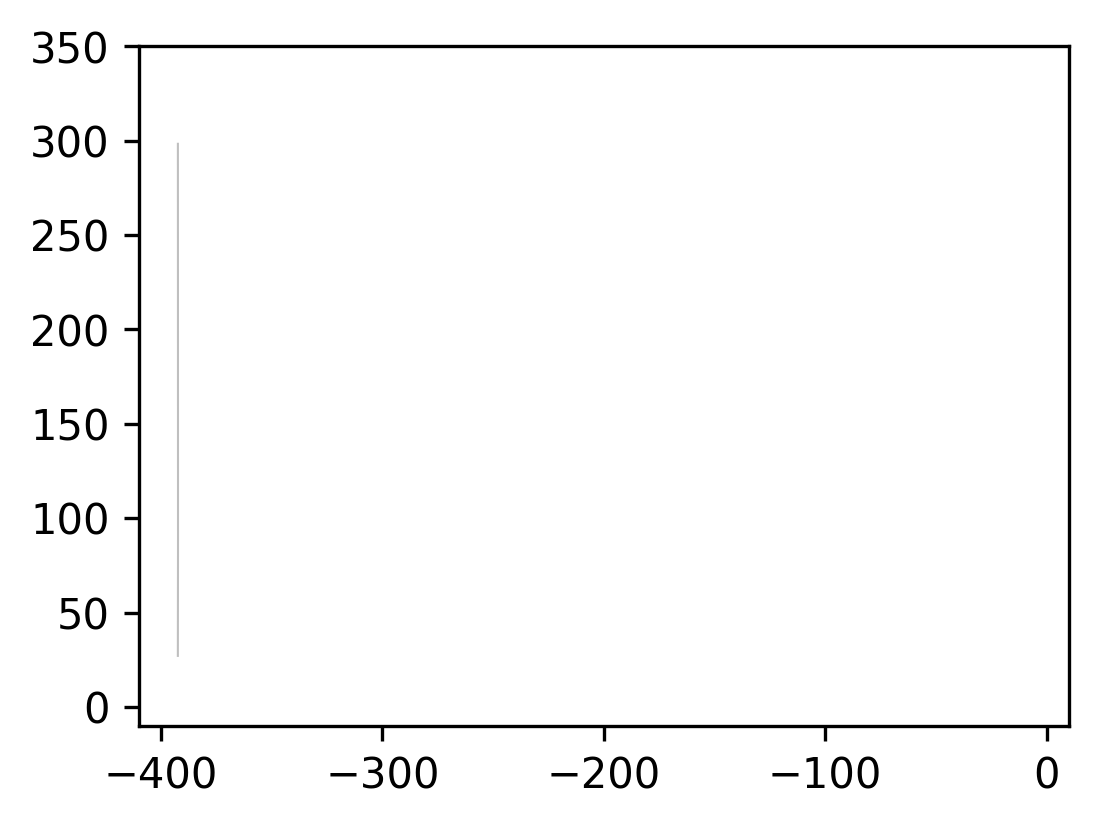

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_233.npy


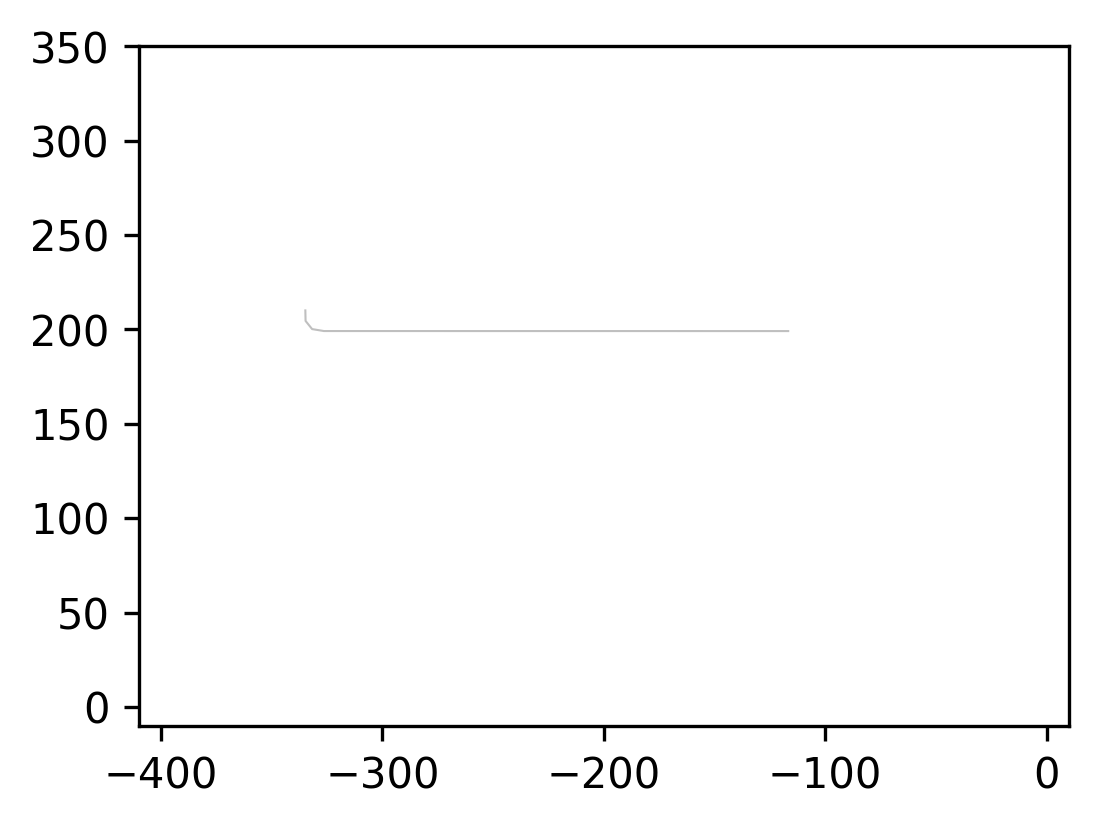

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_38.npy


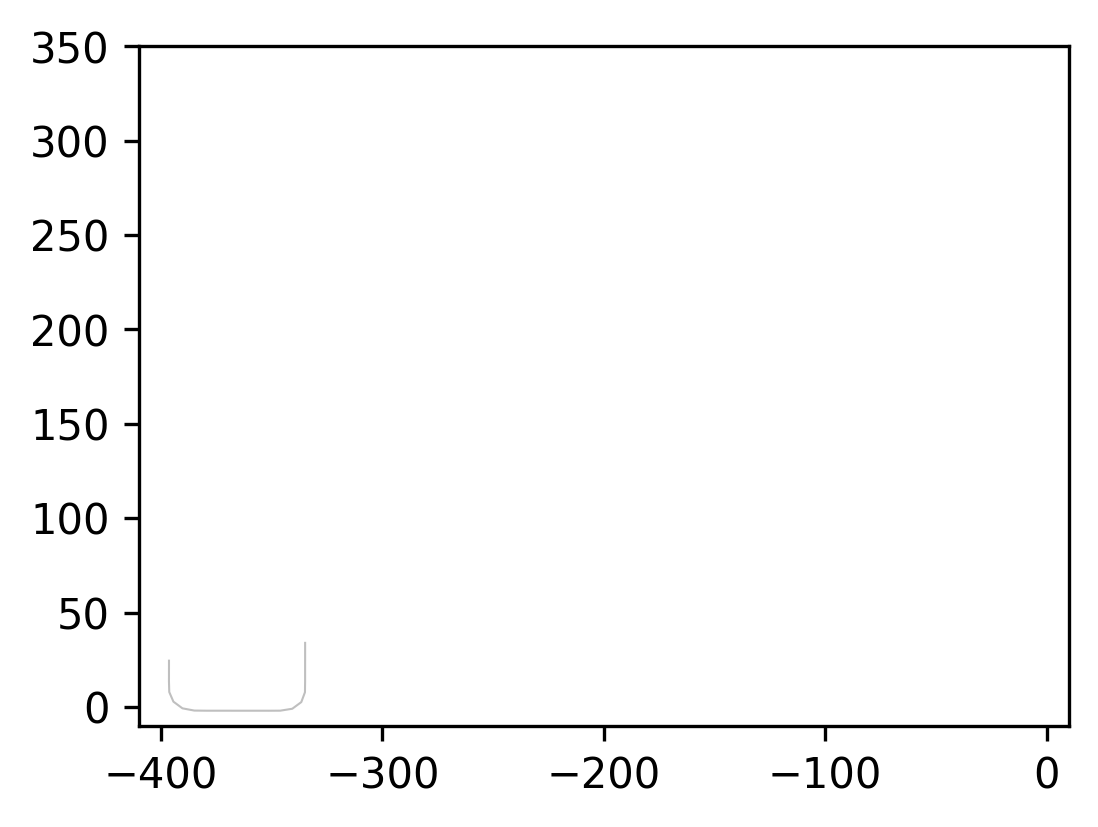

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_150.npy


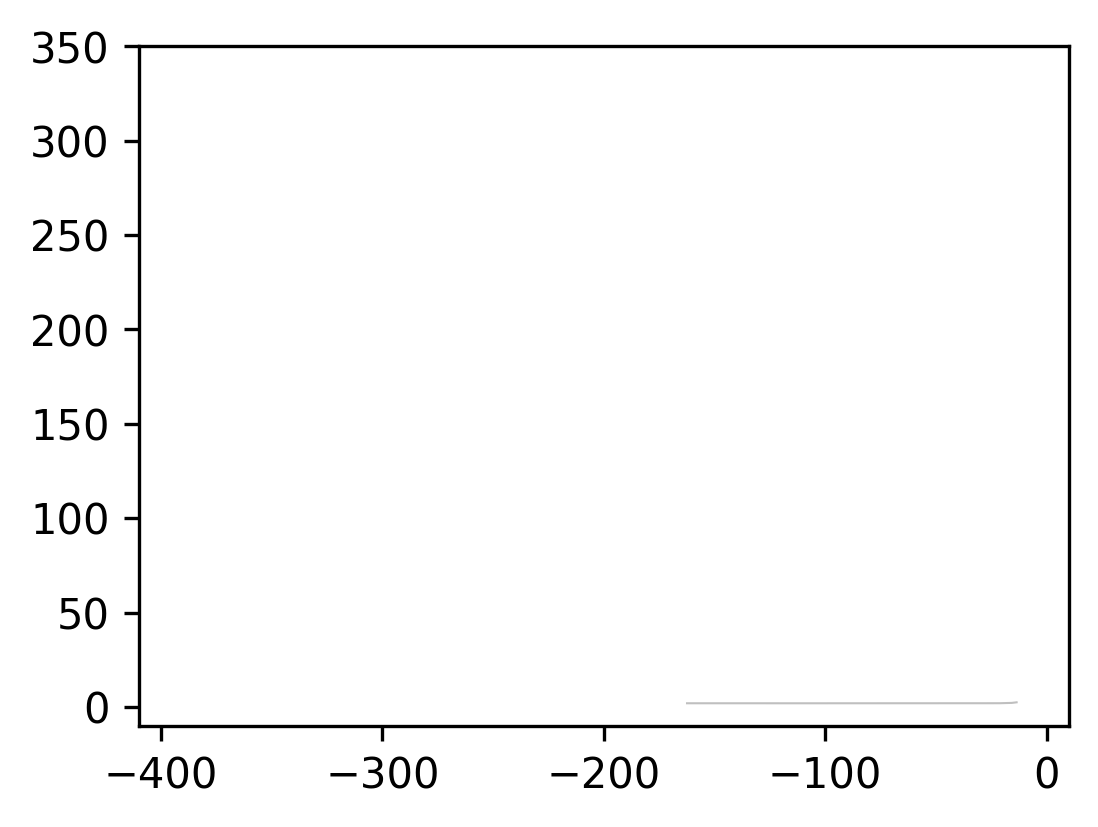

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_511.npy


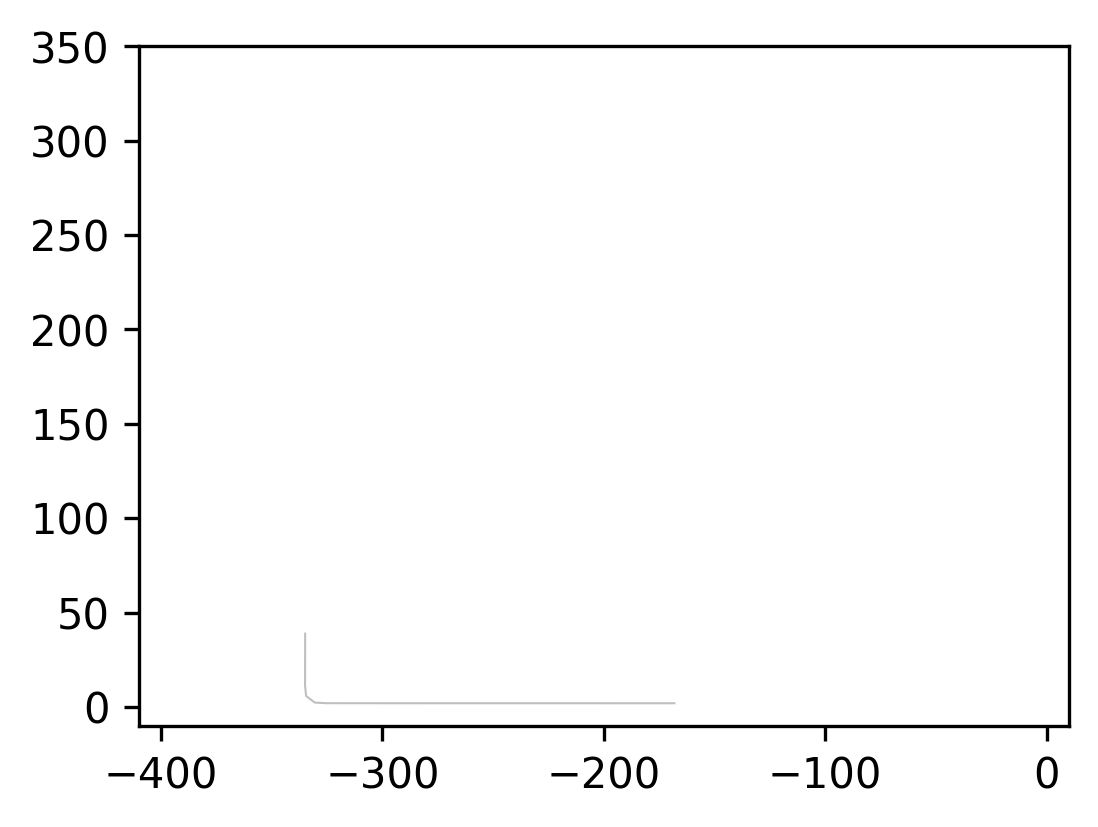

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_115.npy


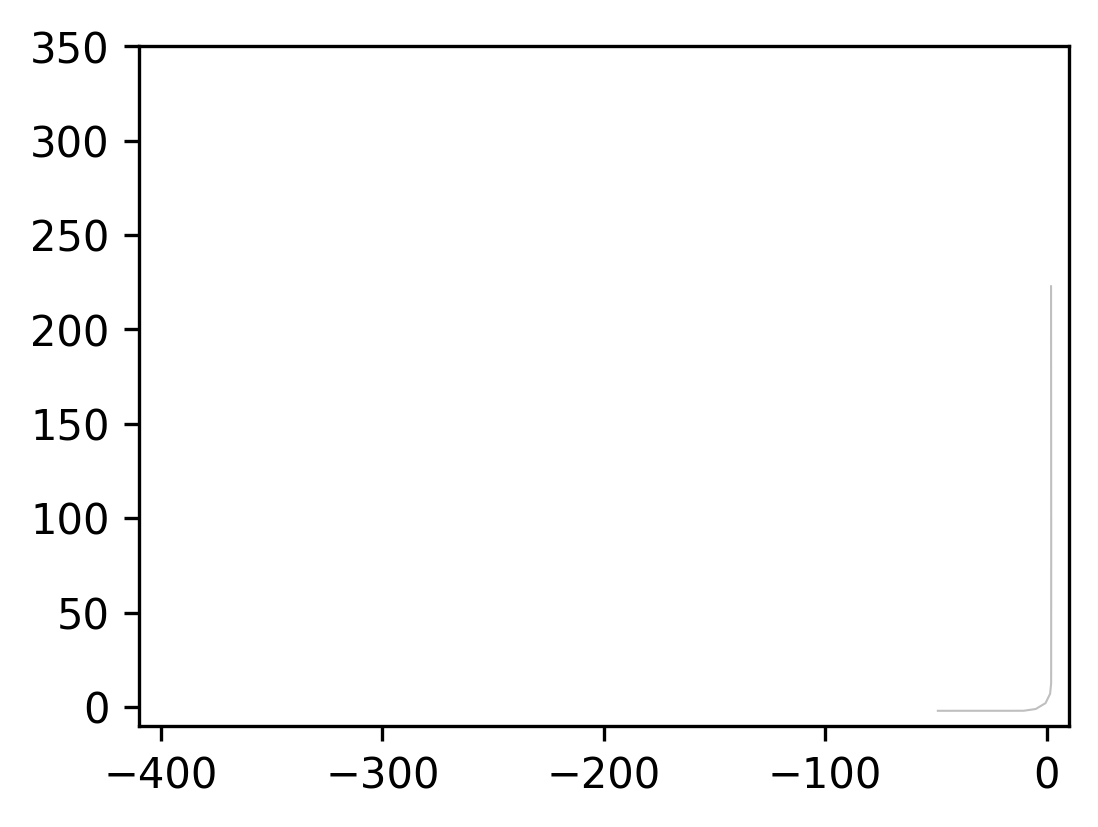

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_320.npy


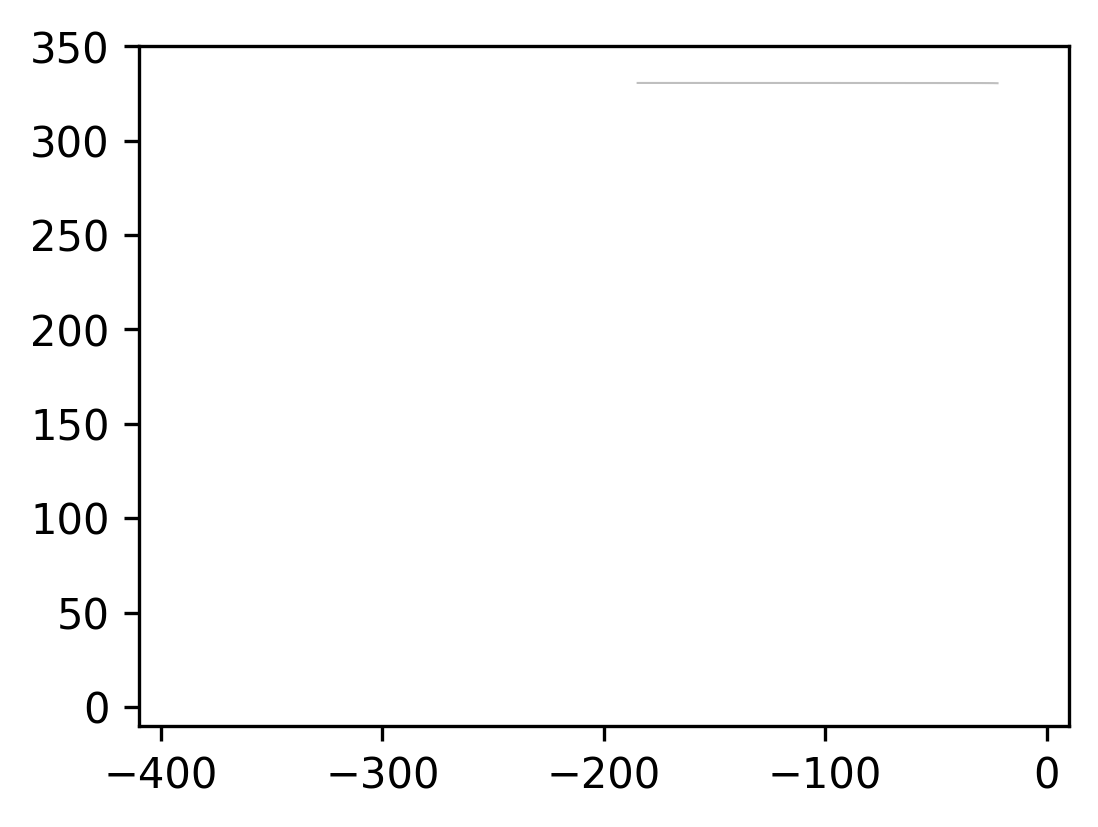

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_91.npy


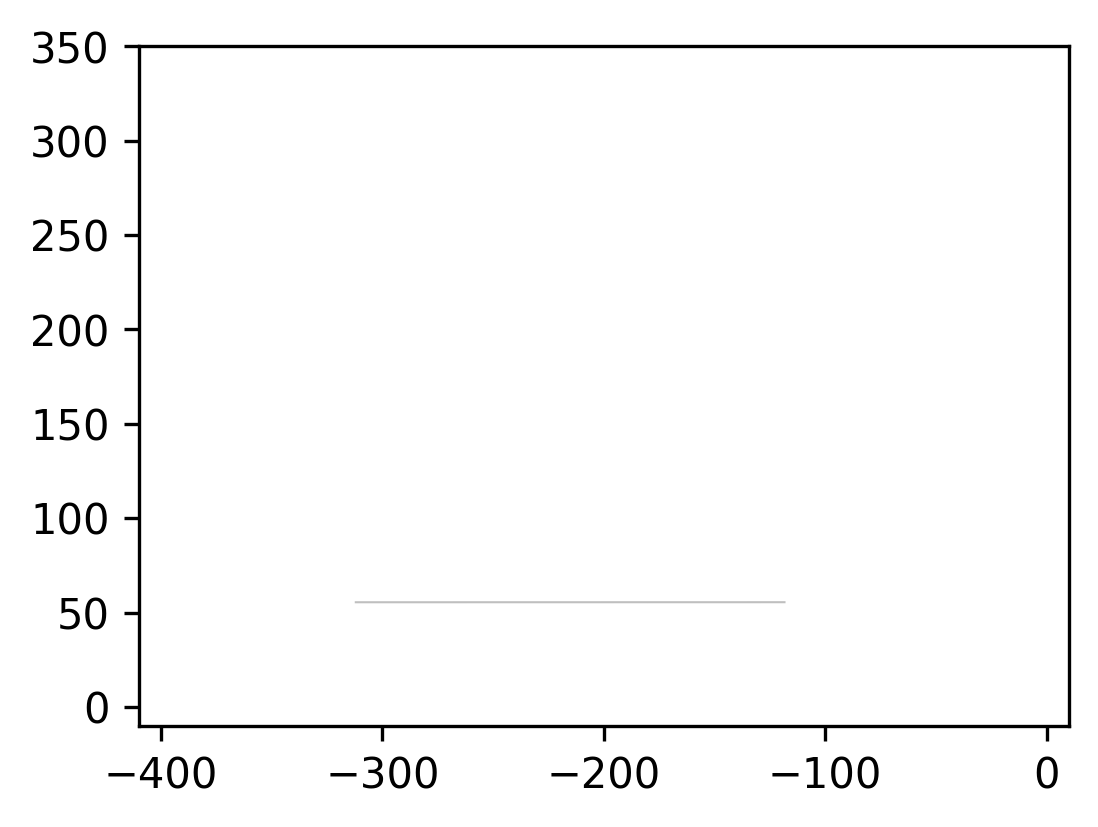

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_454.npy


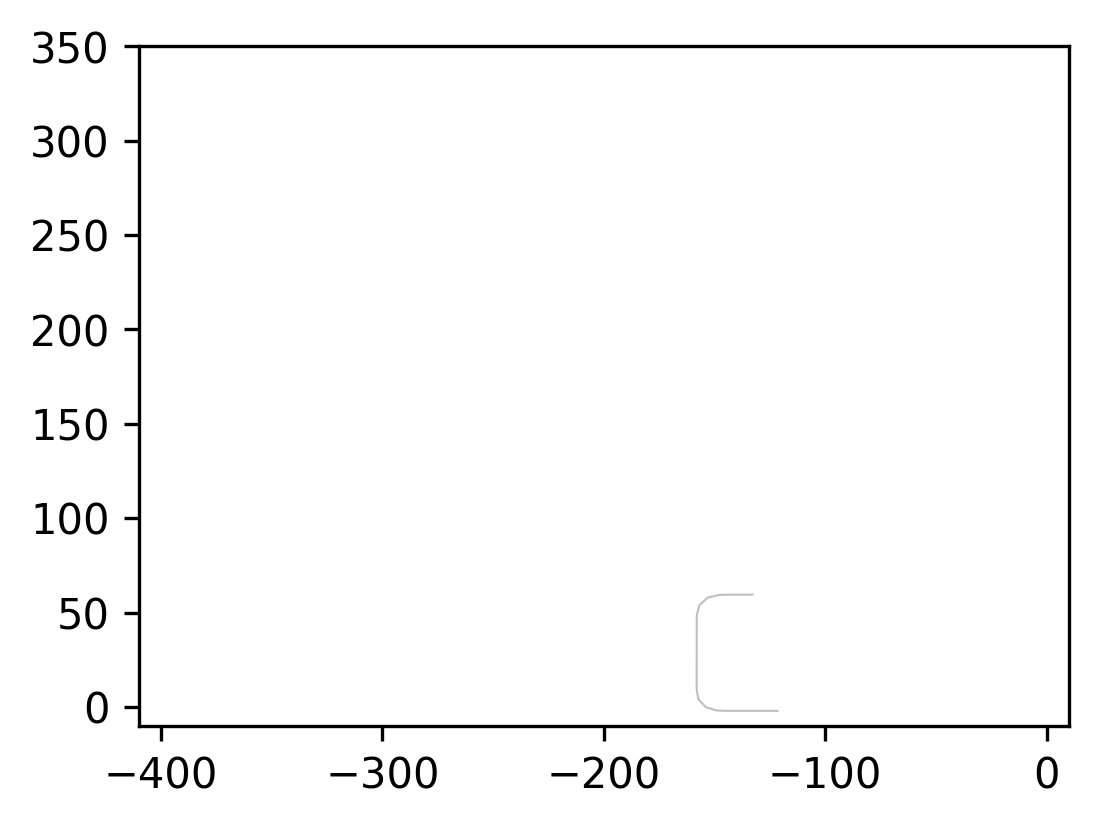

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_3.npy


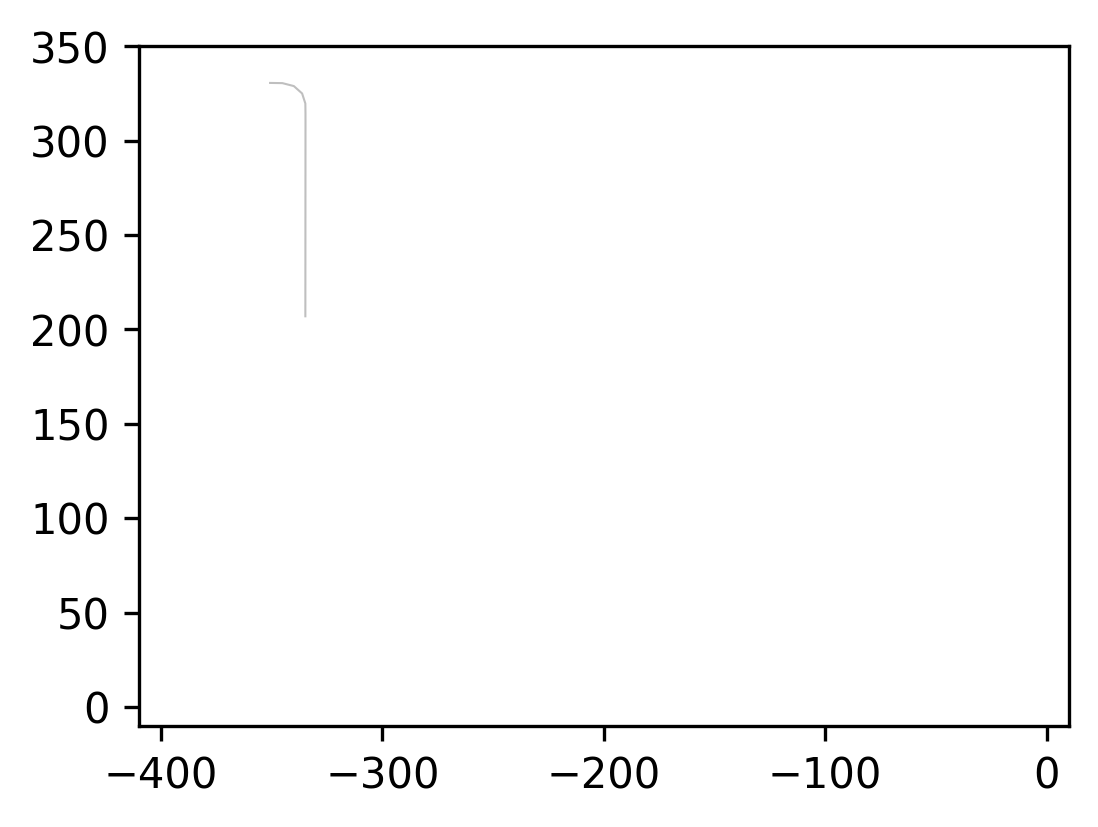

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_154.npy


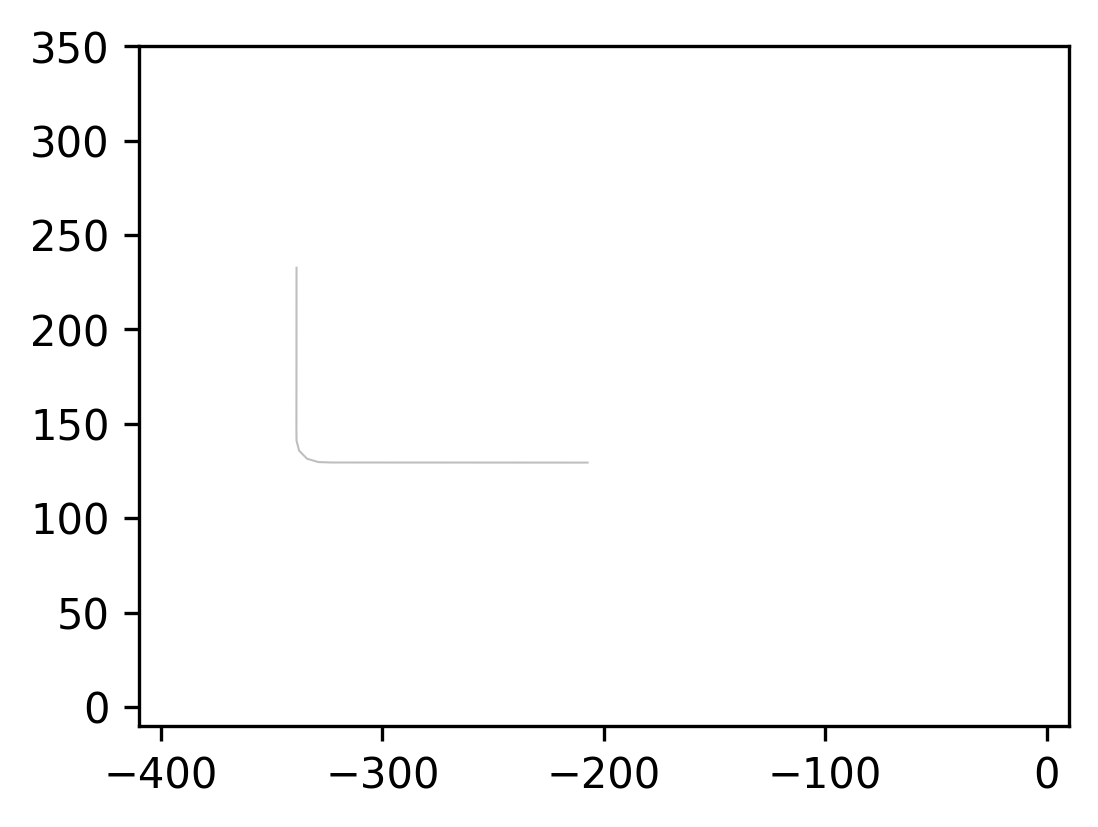

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_418.npy


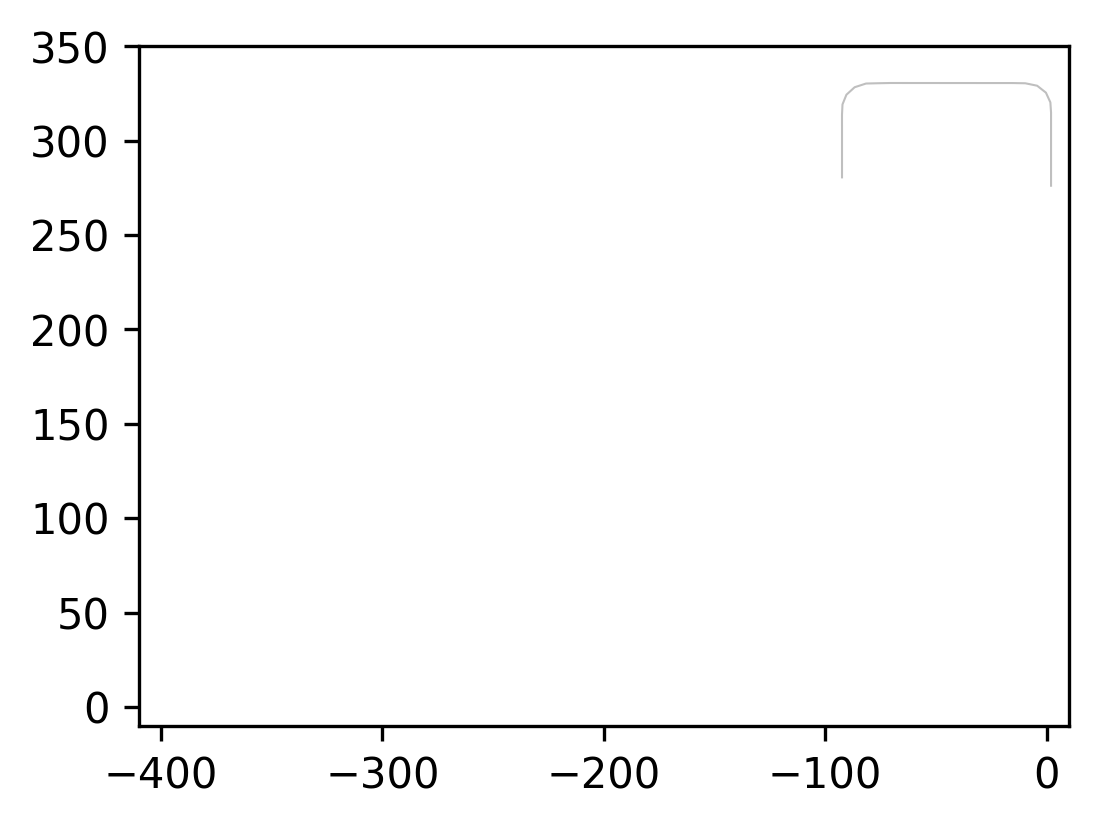

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_231.npy


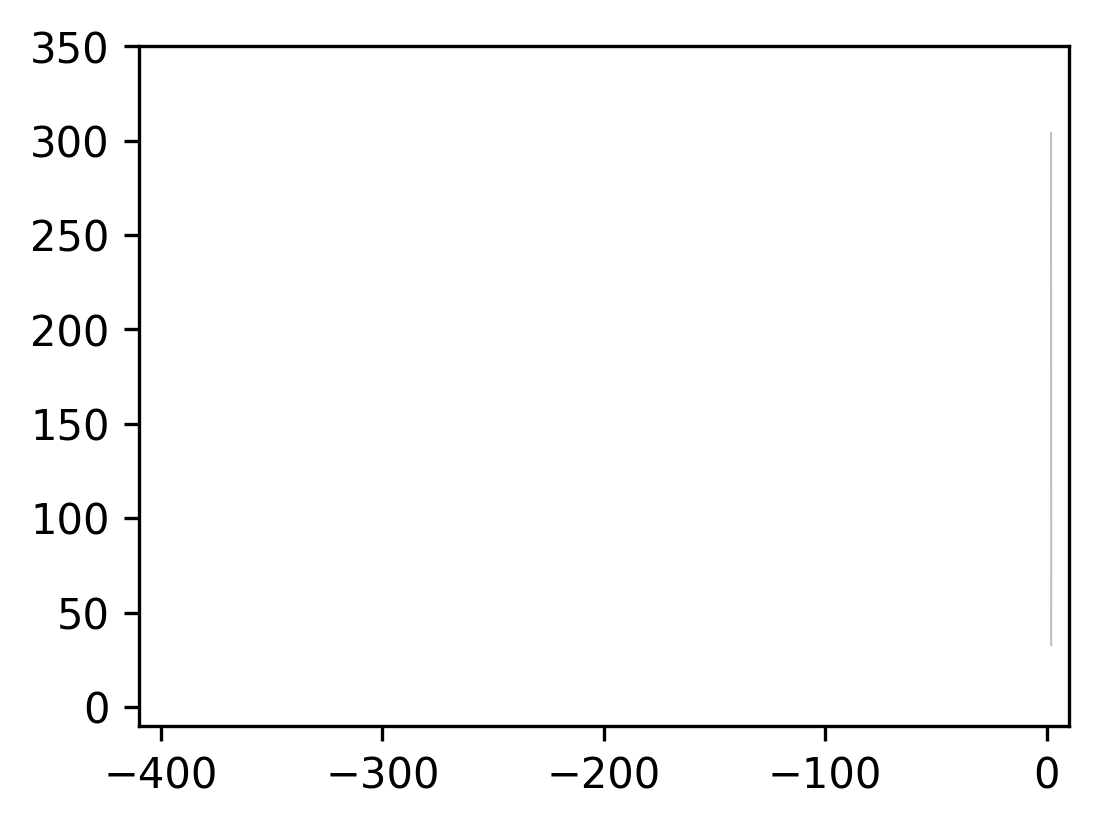

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_220.npy


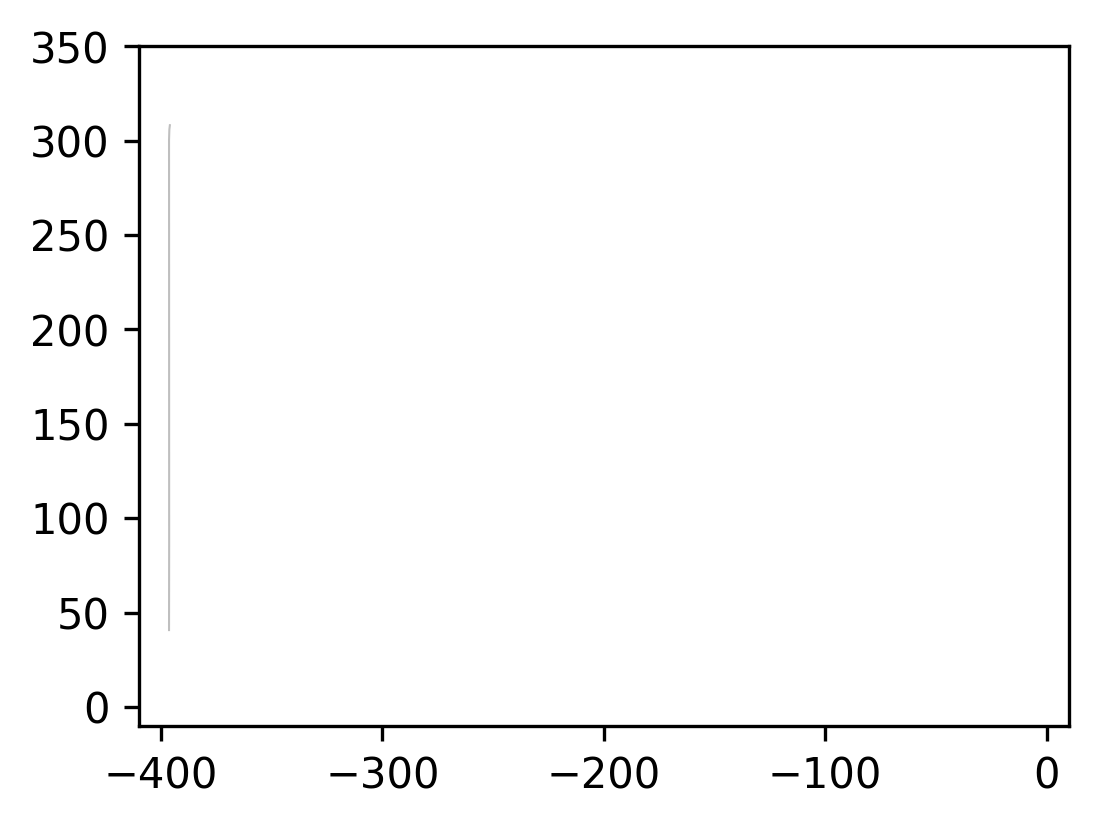

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_133.npy


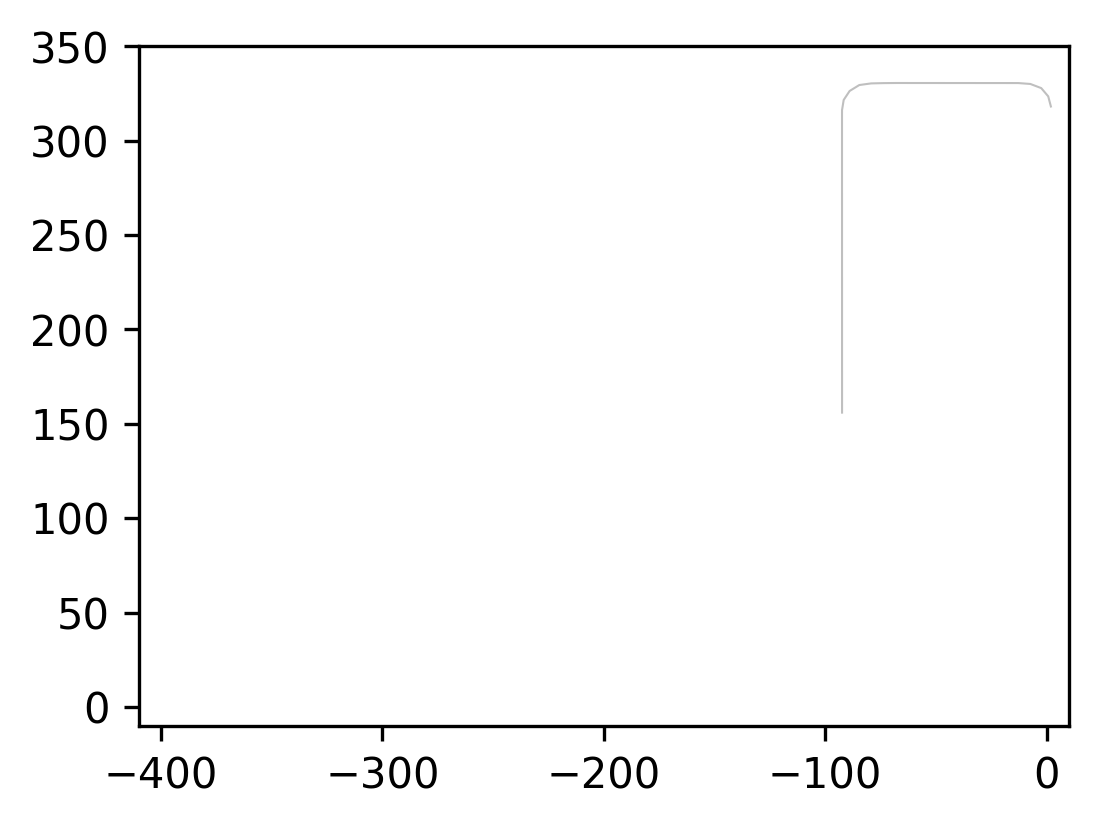

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_100.npy


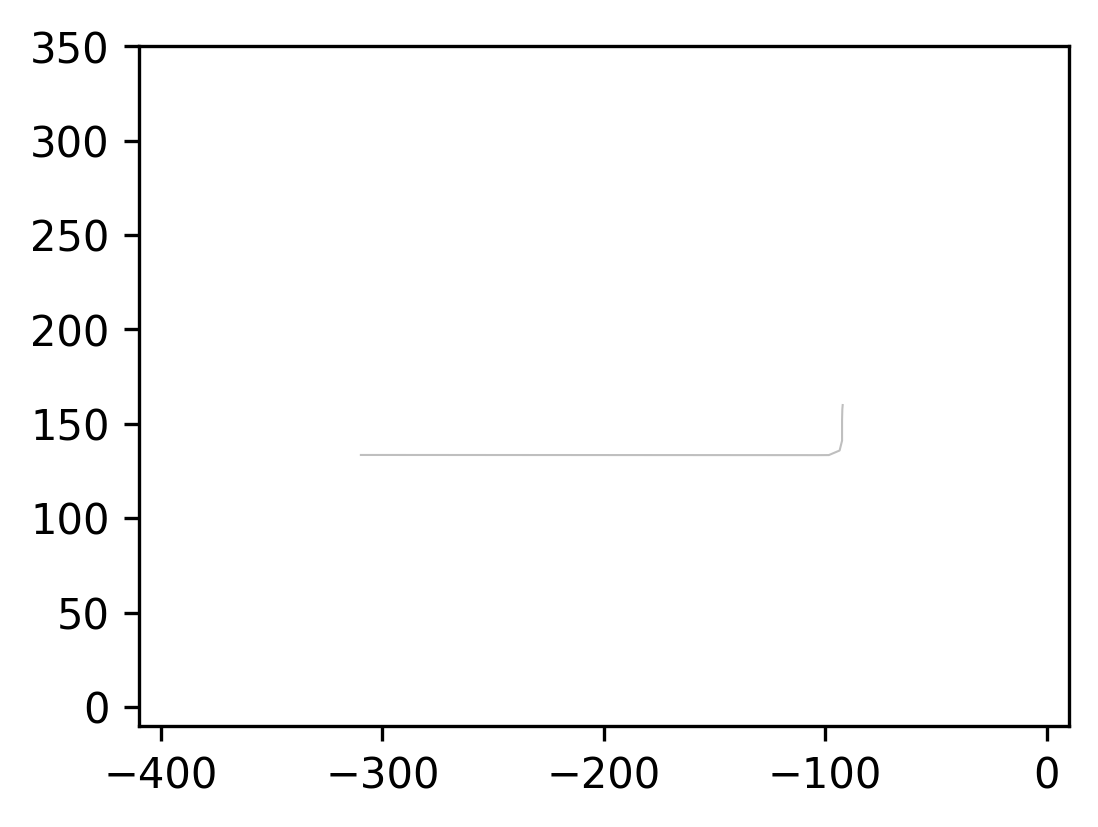

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_280.npy


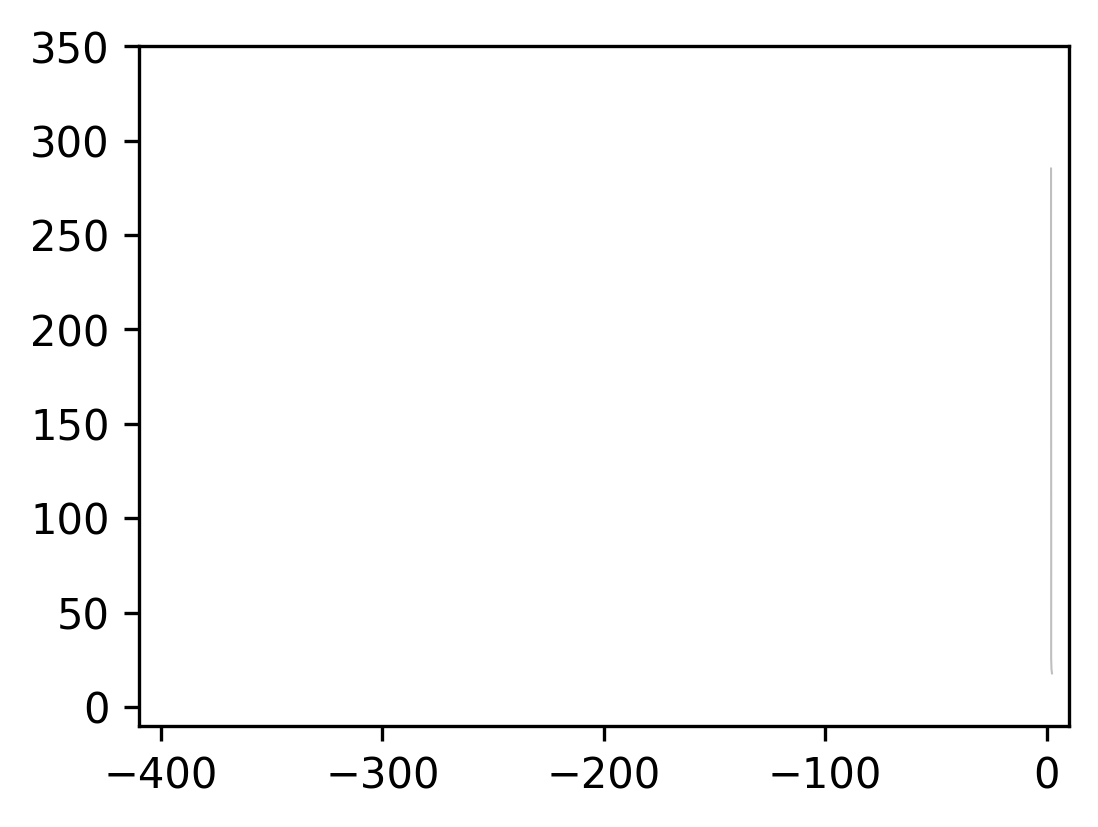

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_487.npy


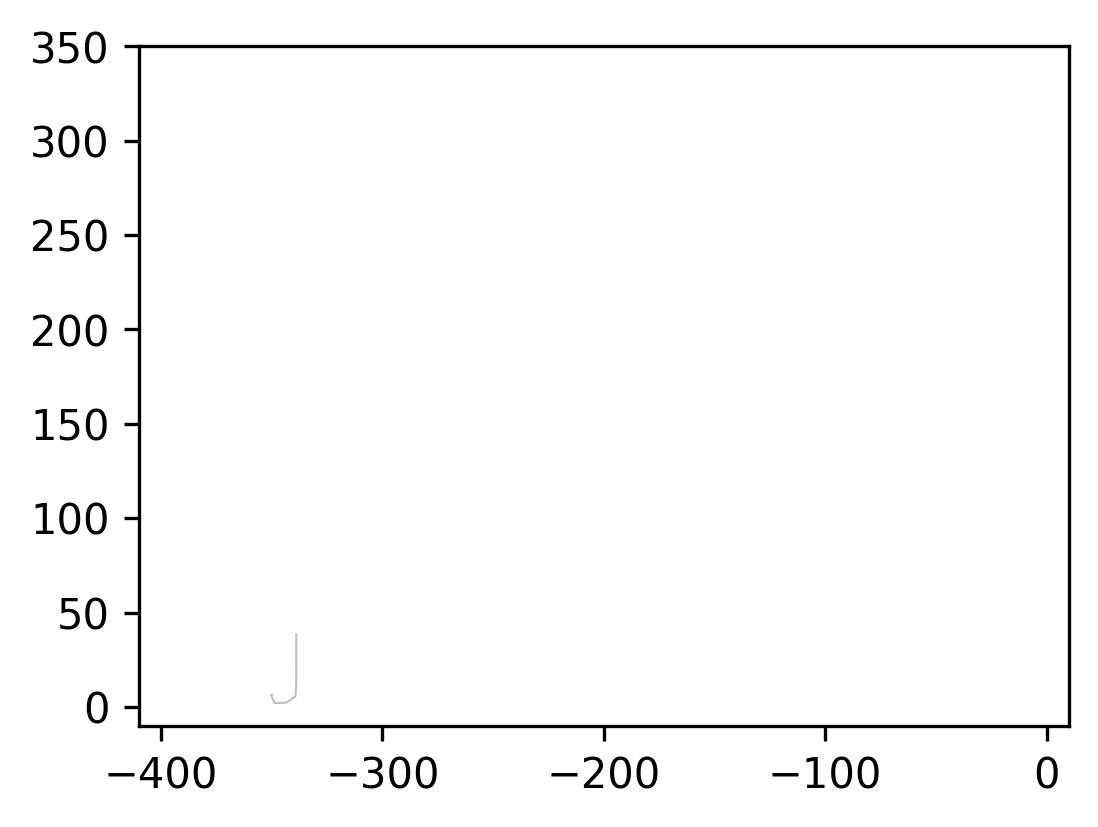

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_119.npy


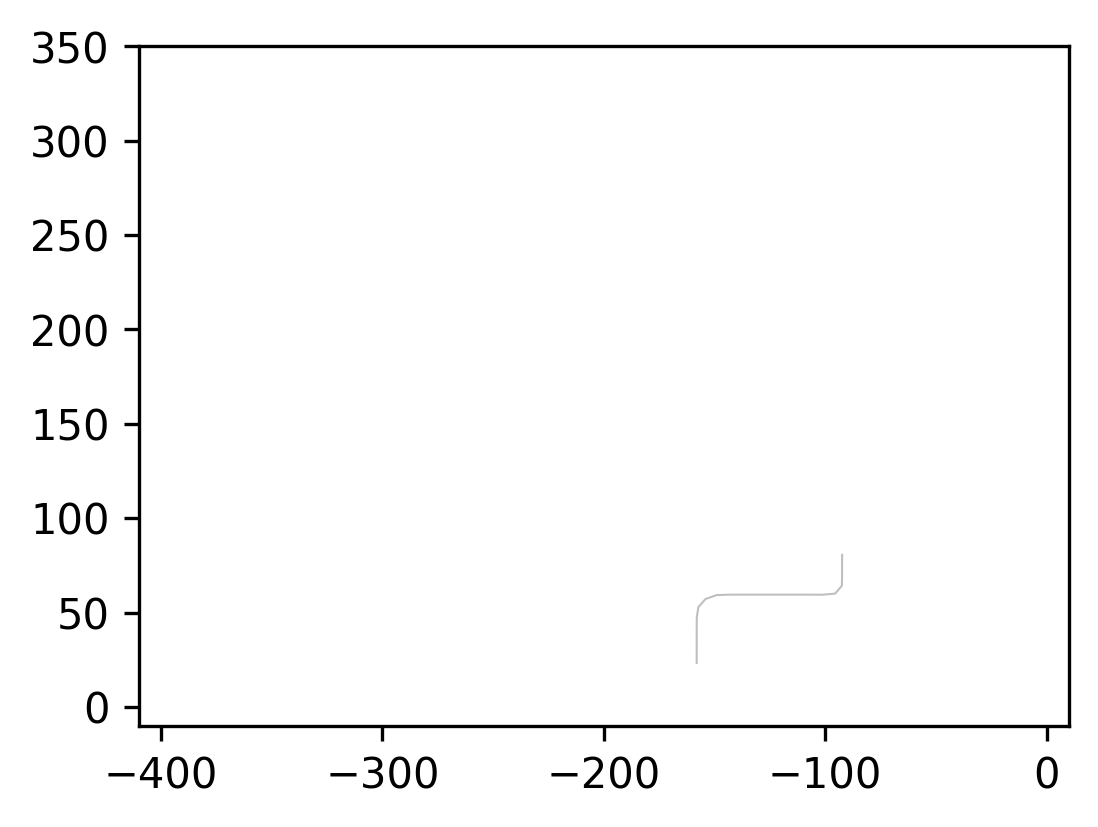

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_495.npy


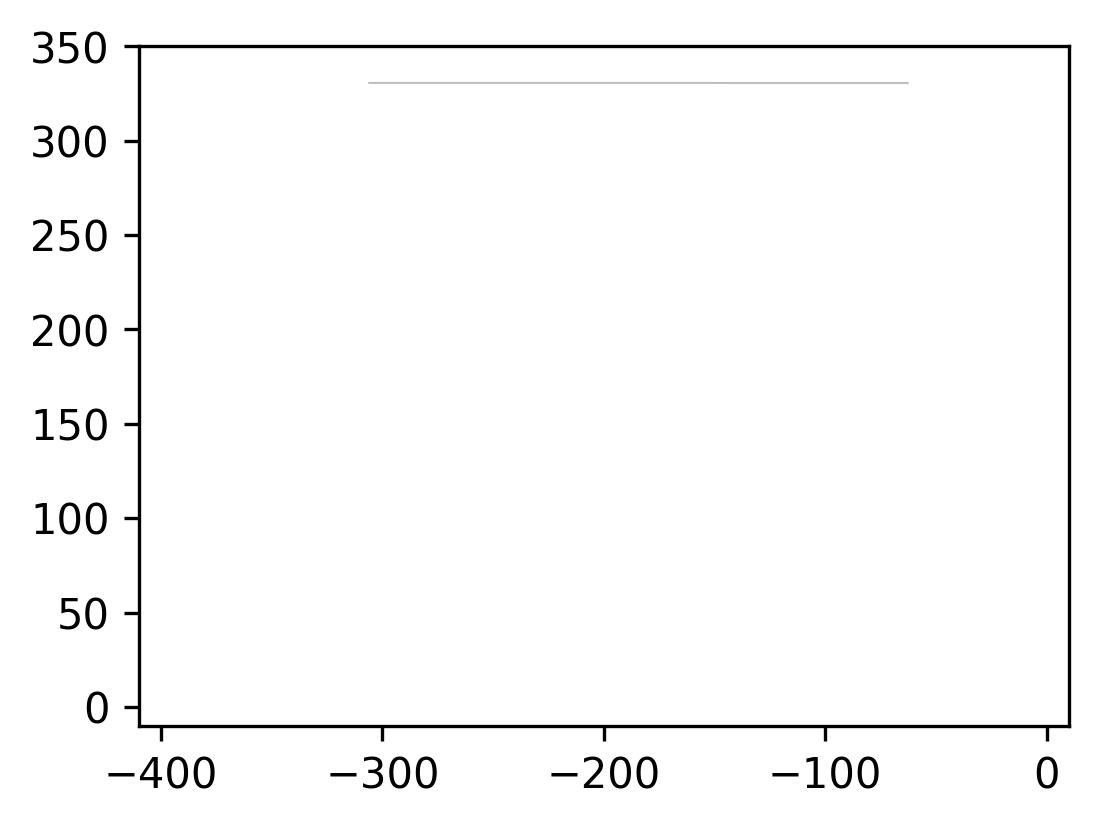

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_1.npy


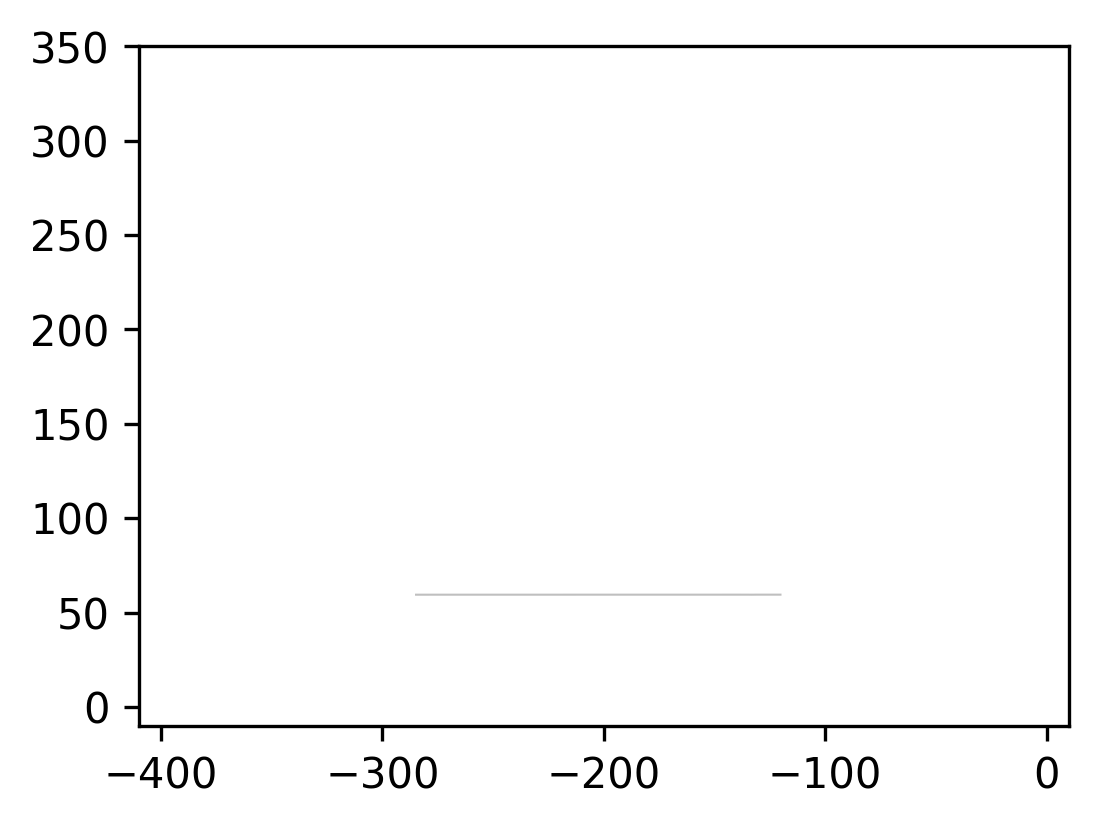

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_106.npy


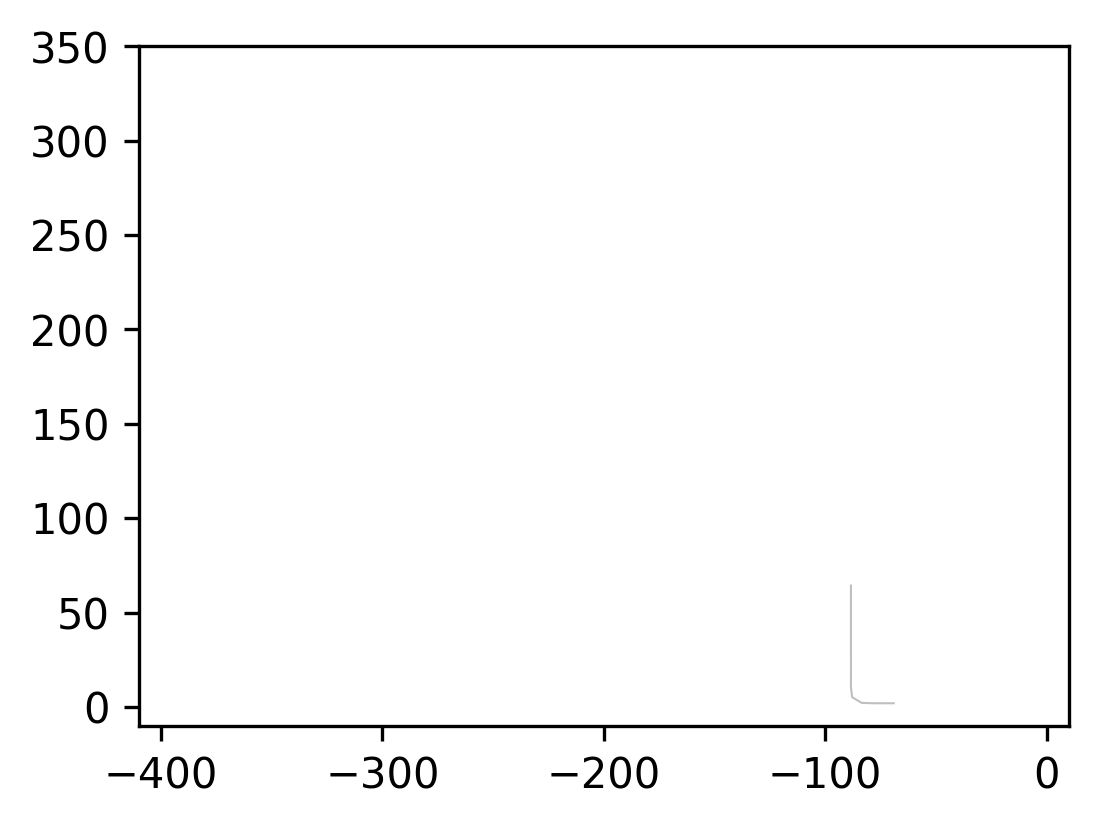

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_380.npy


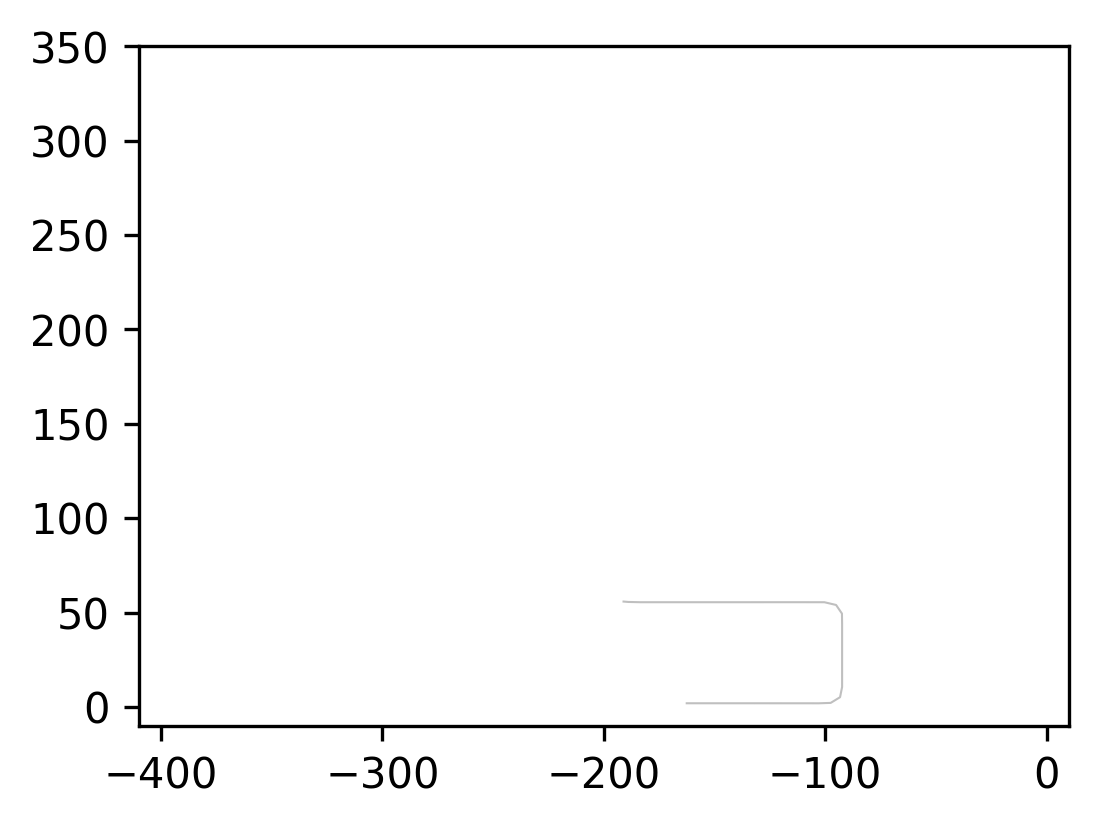

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_502.npy


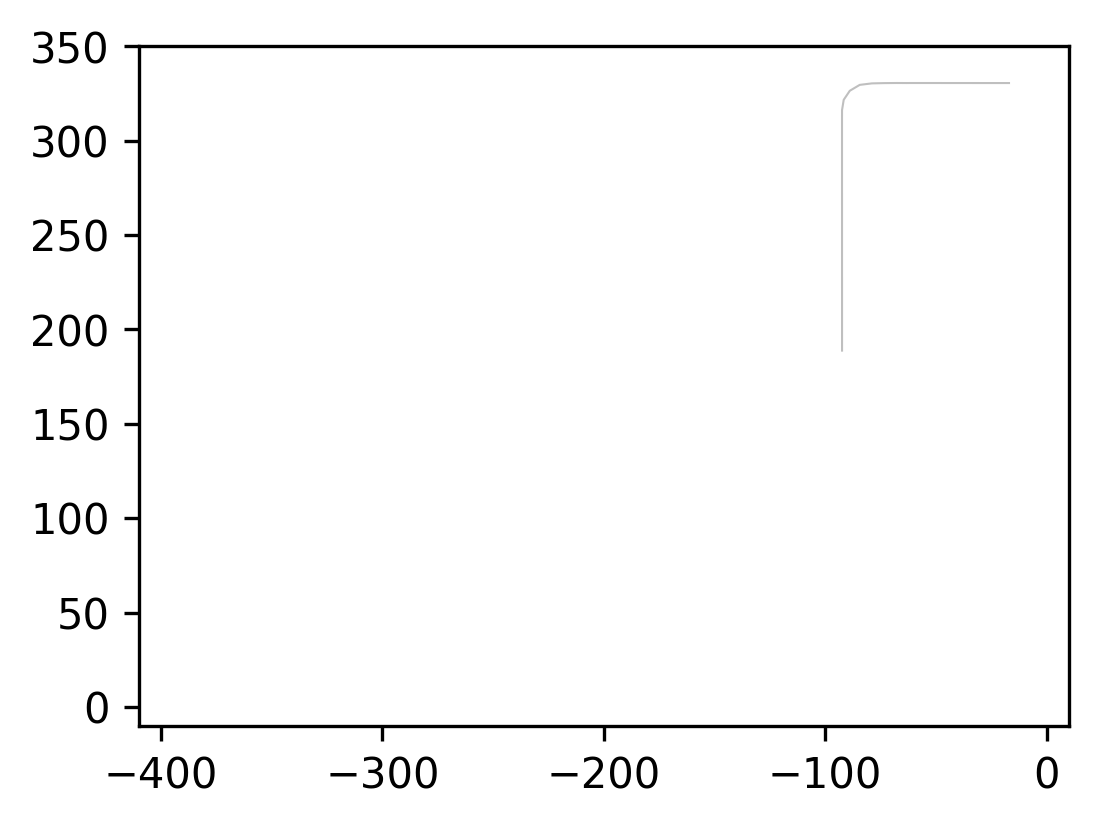

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_102.npy


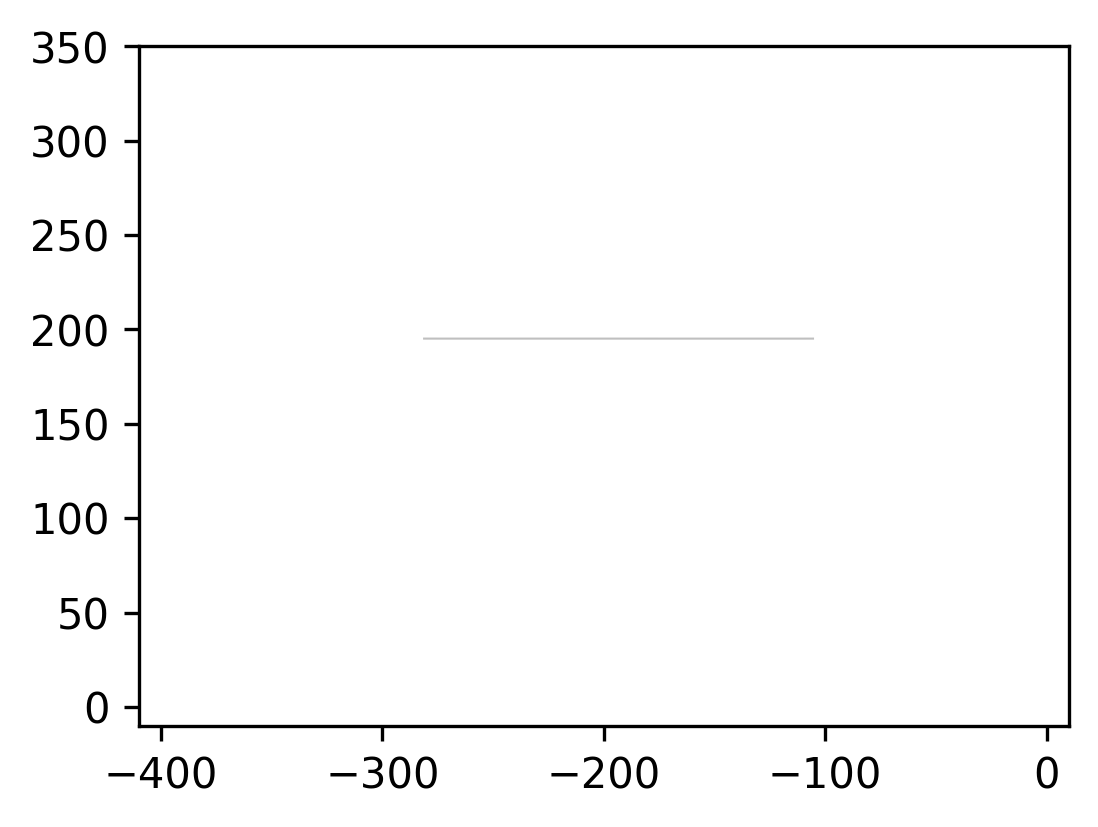

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_44.npy


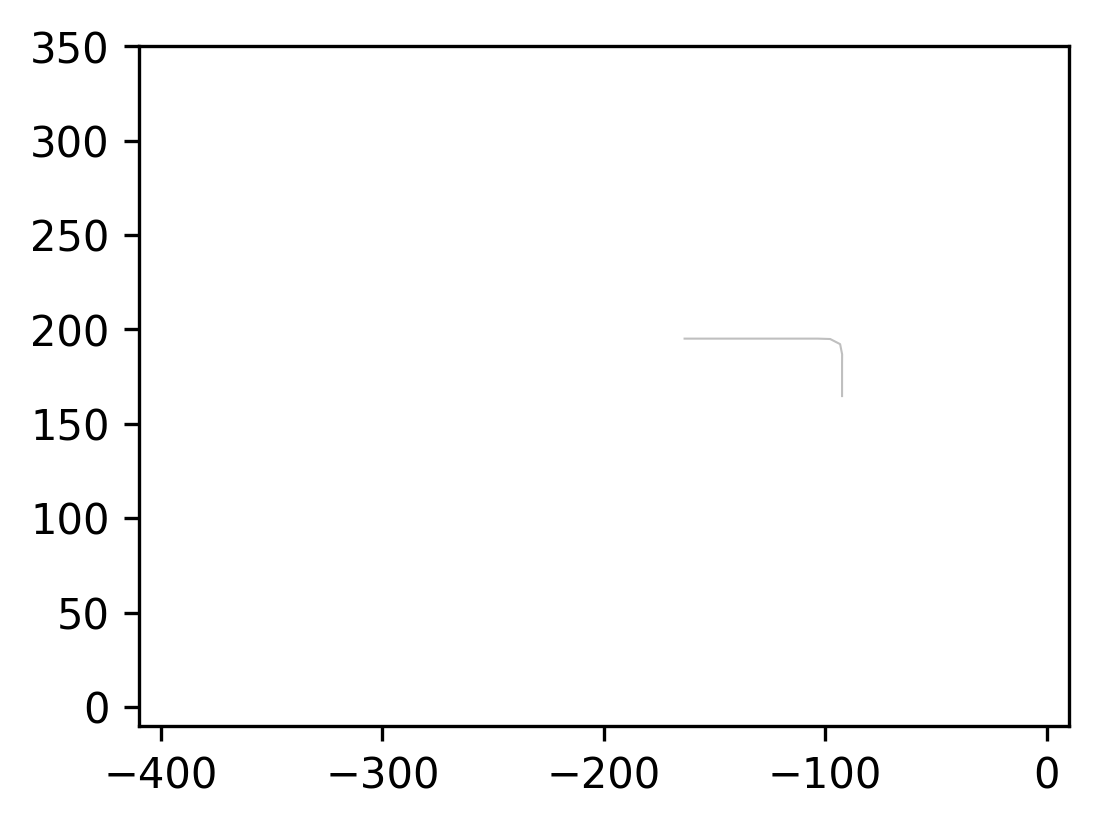

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_330.npy


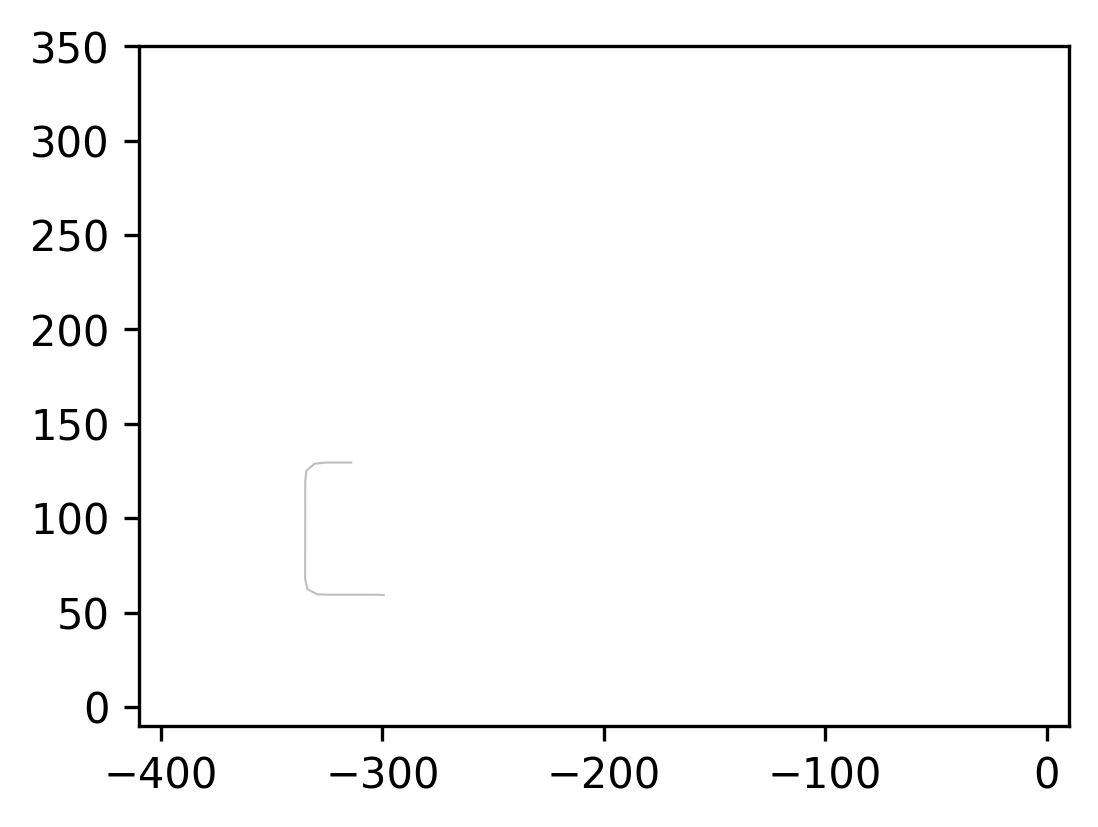

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_496.npy


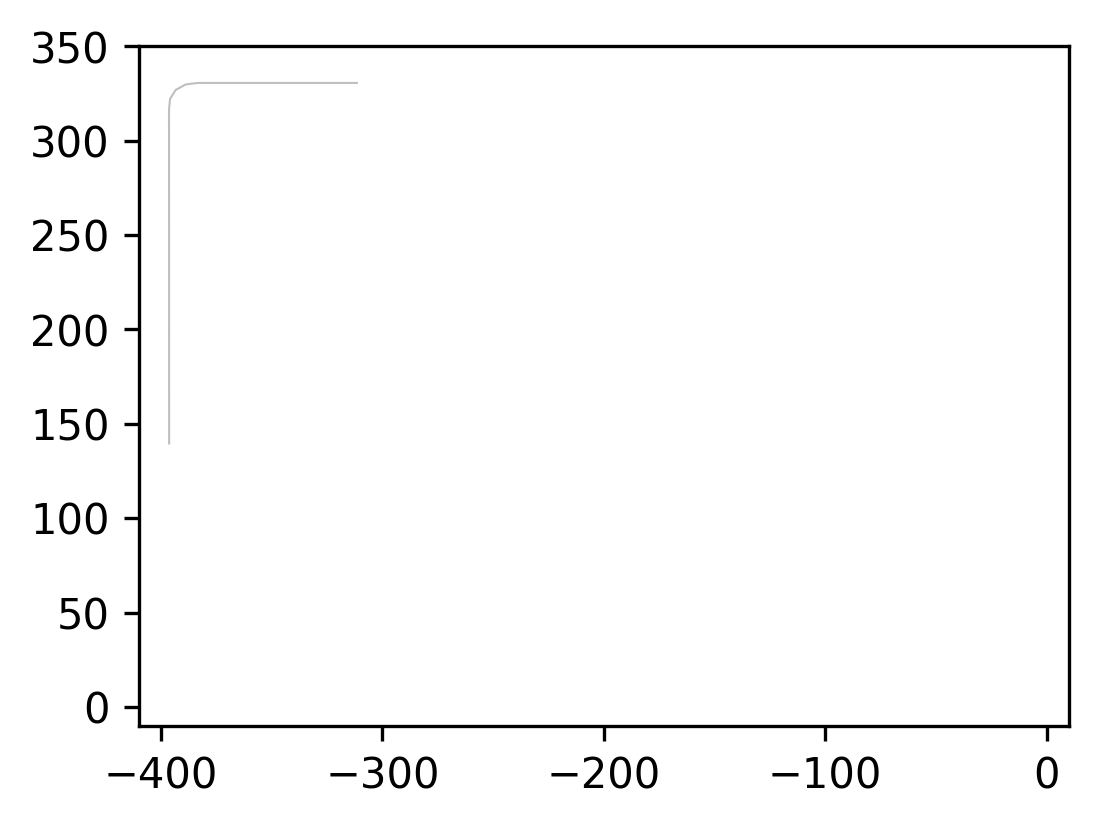

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_501.npy


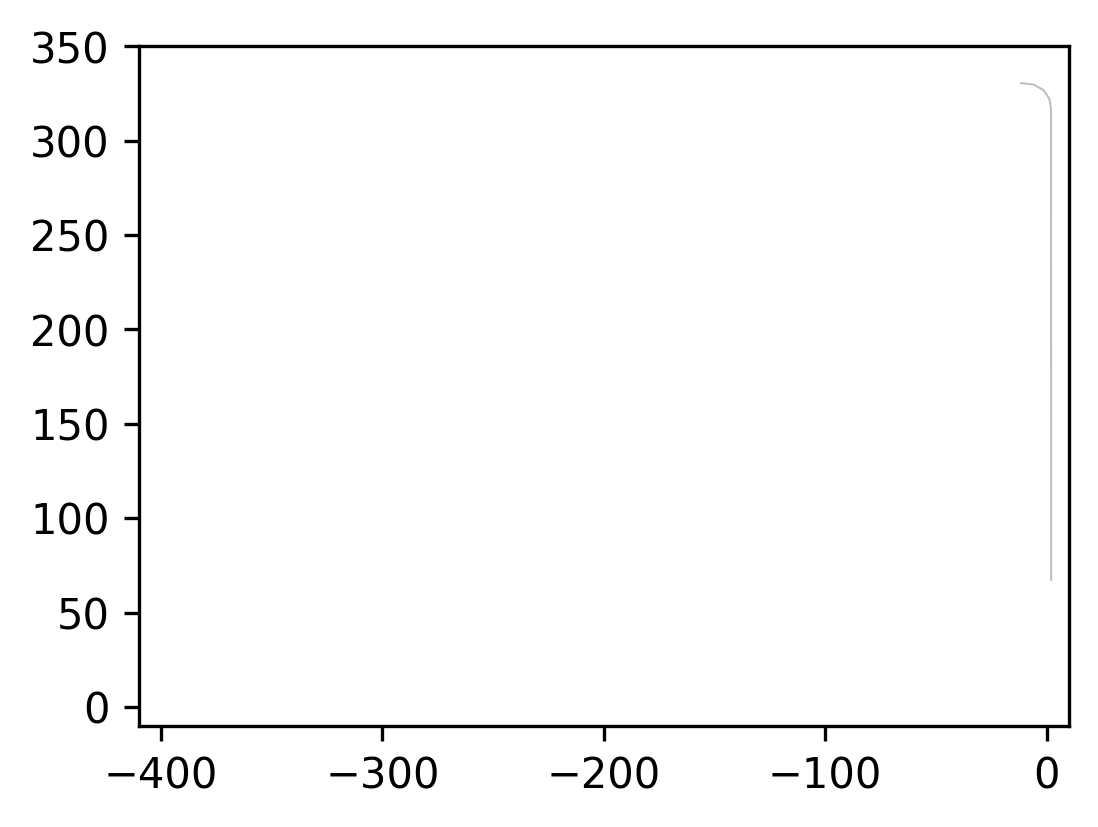

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_307.npy


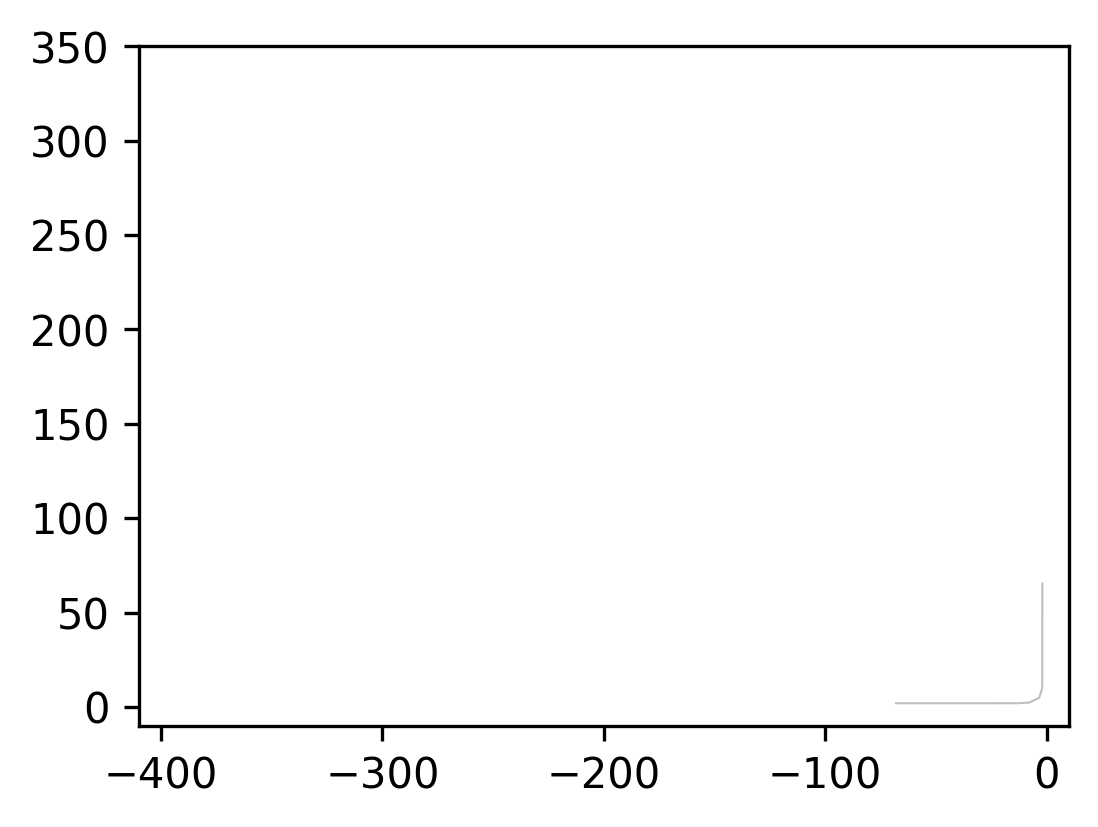

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_364.npy


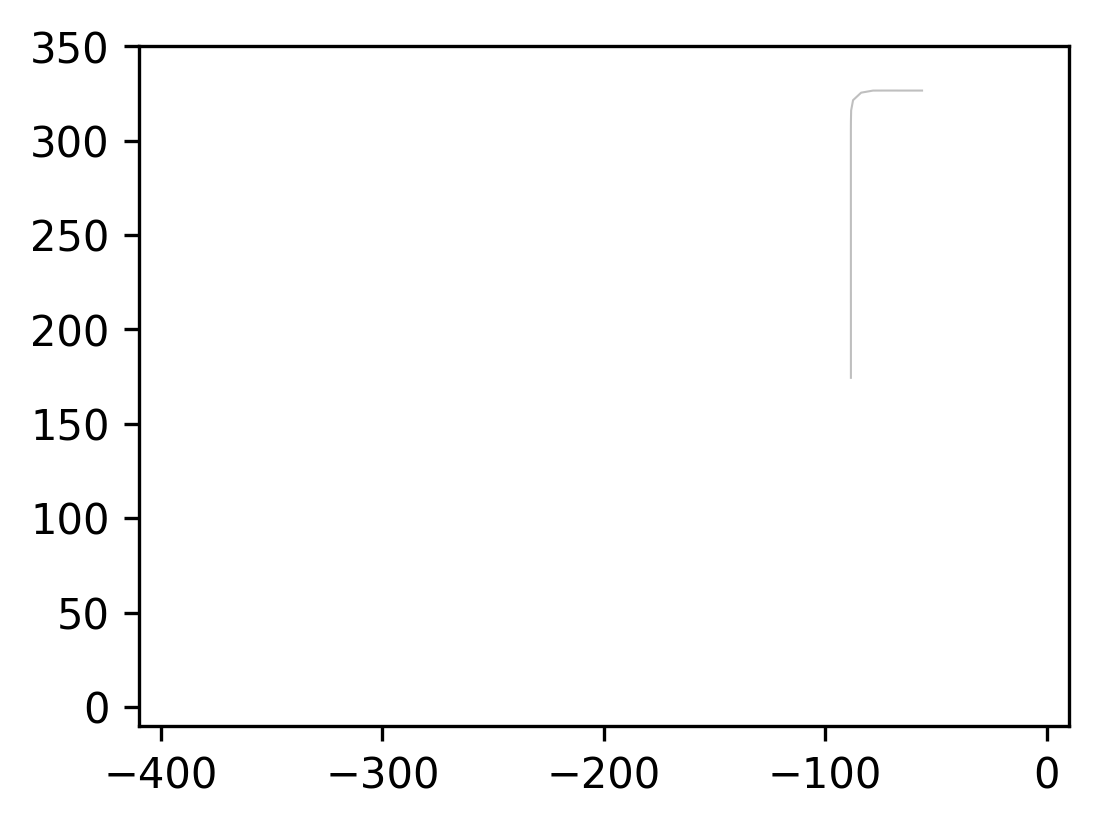

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_432.npy


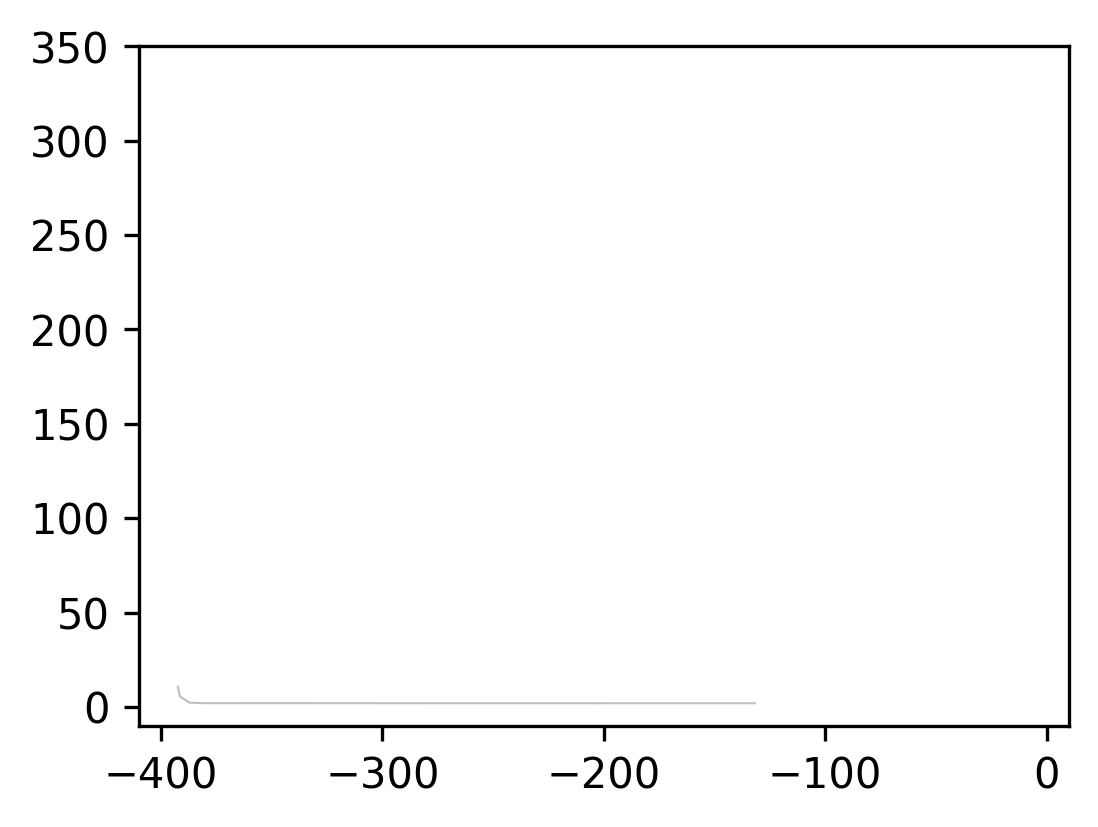

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_192.npy


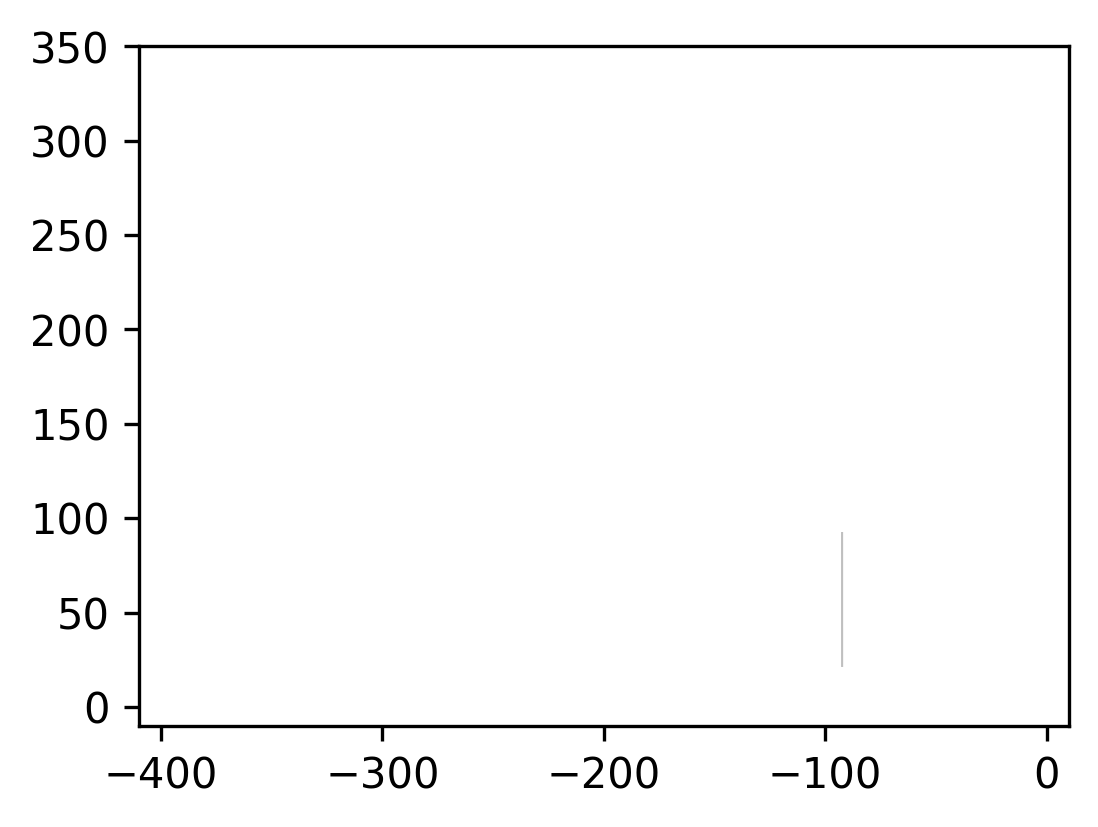

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_521.npy


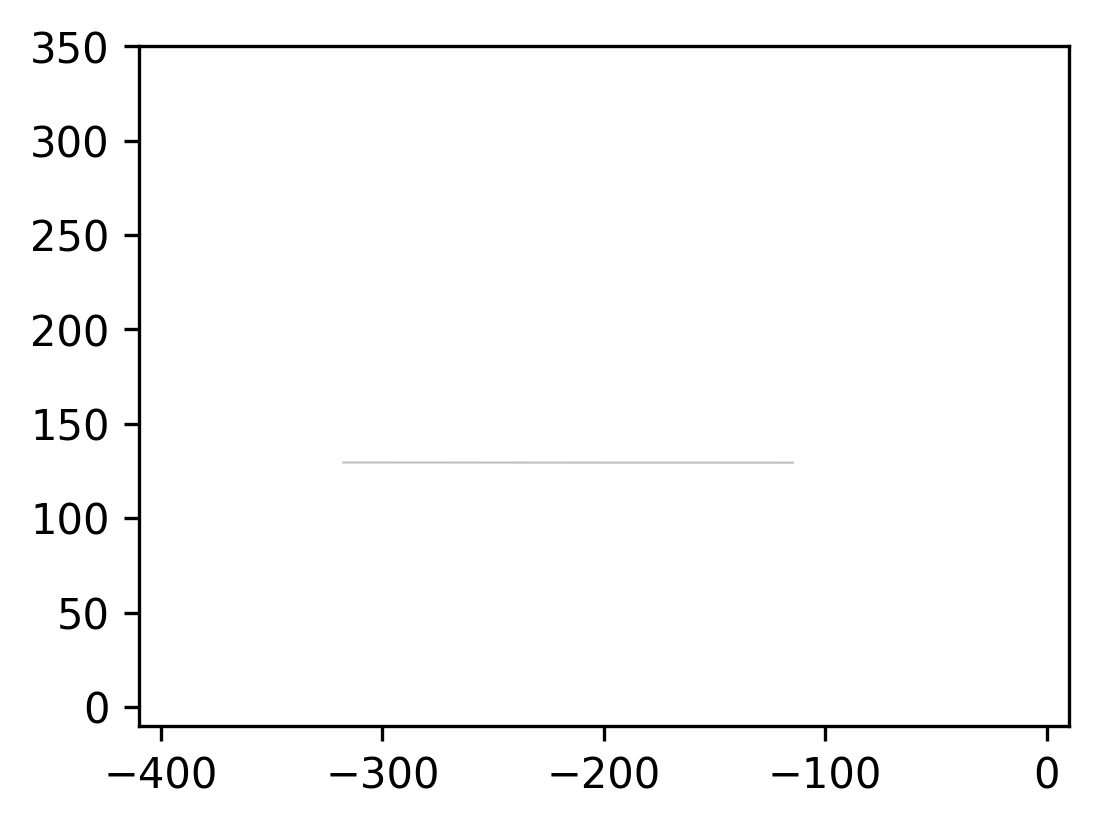

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_25.npy


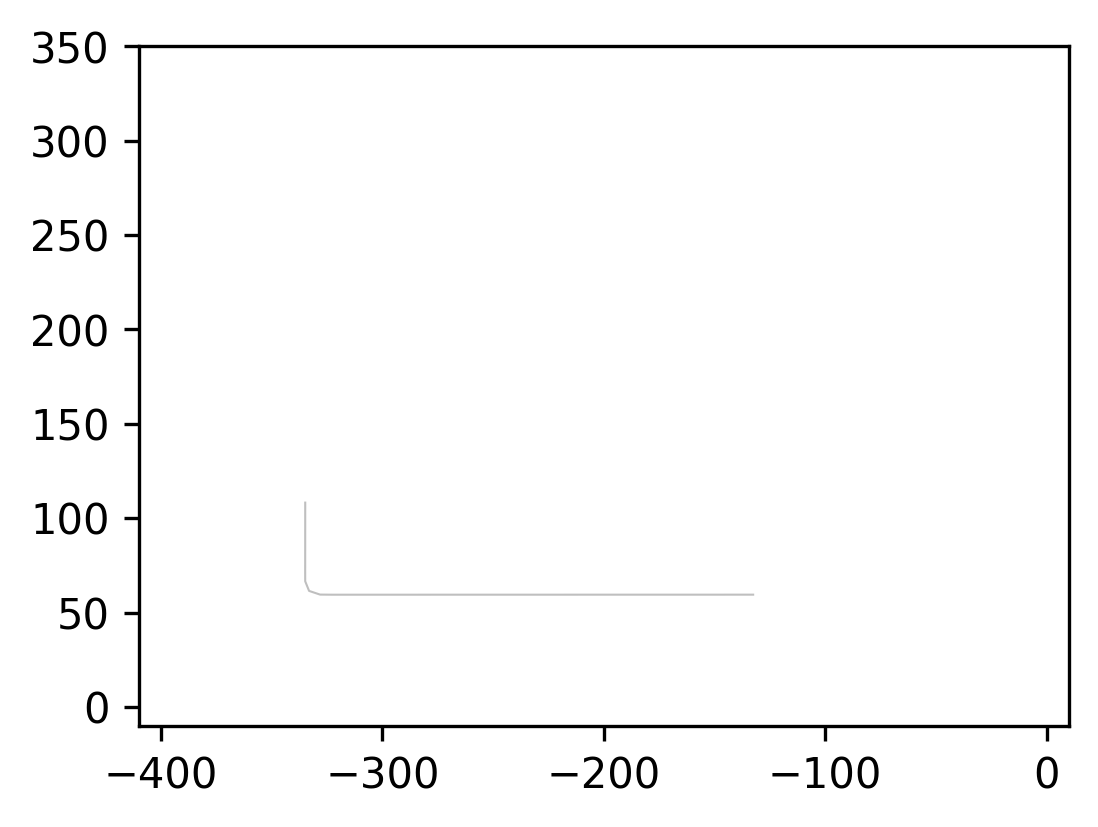

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_428.npy


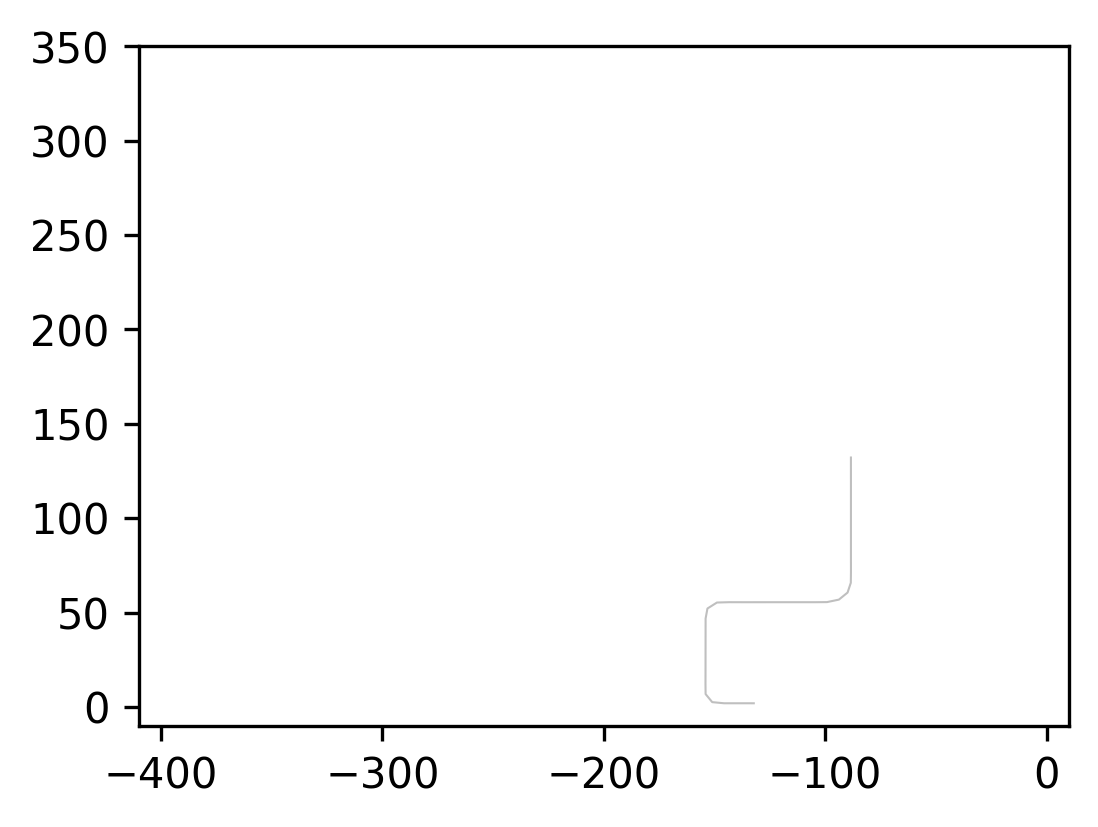

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_248.npy


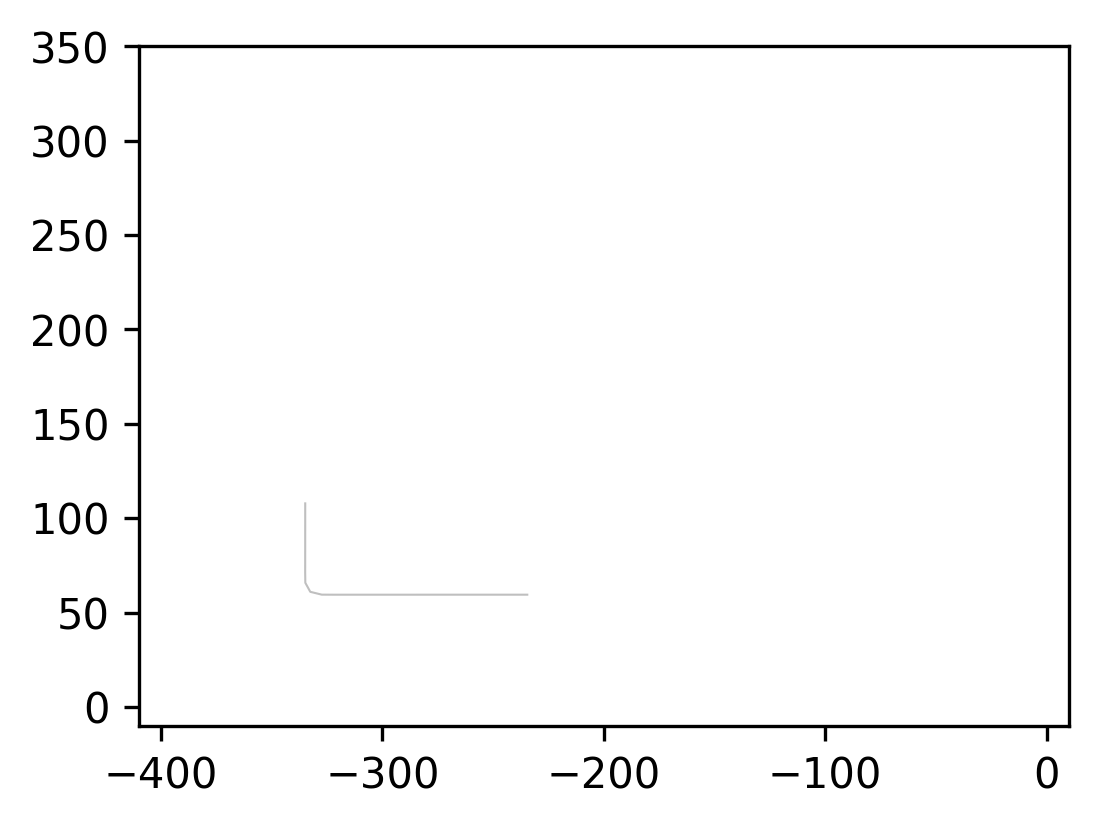

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_351.npy


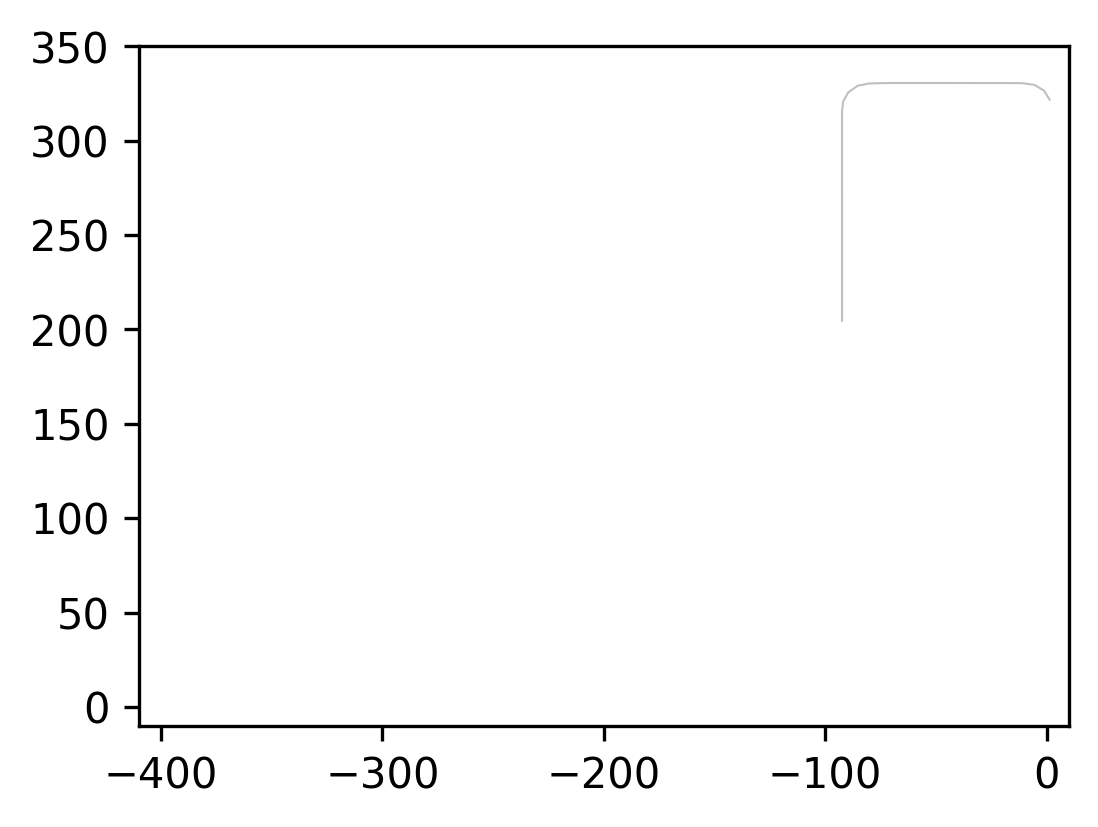

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_99.npy


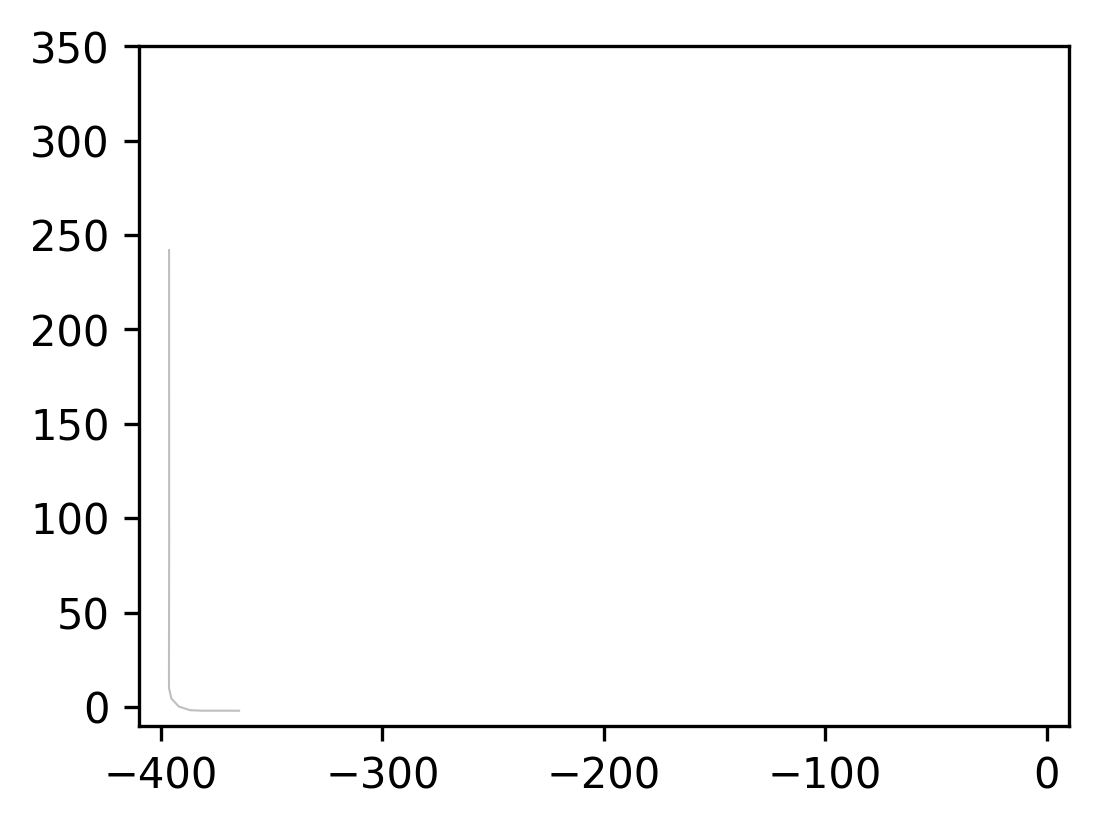

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_105.npy


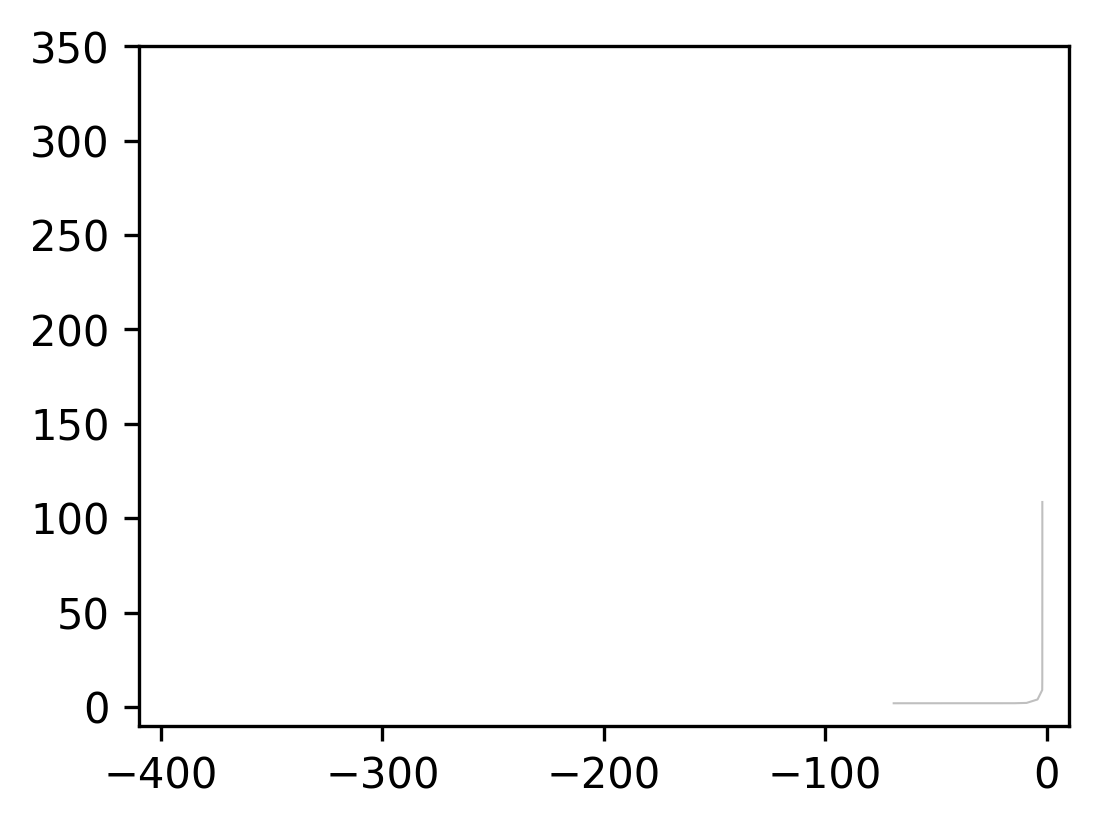

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_128.npy


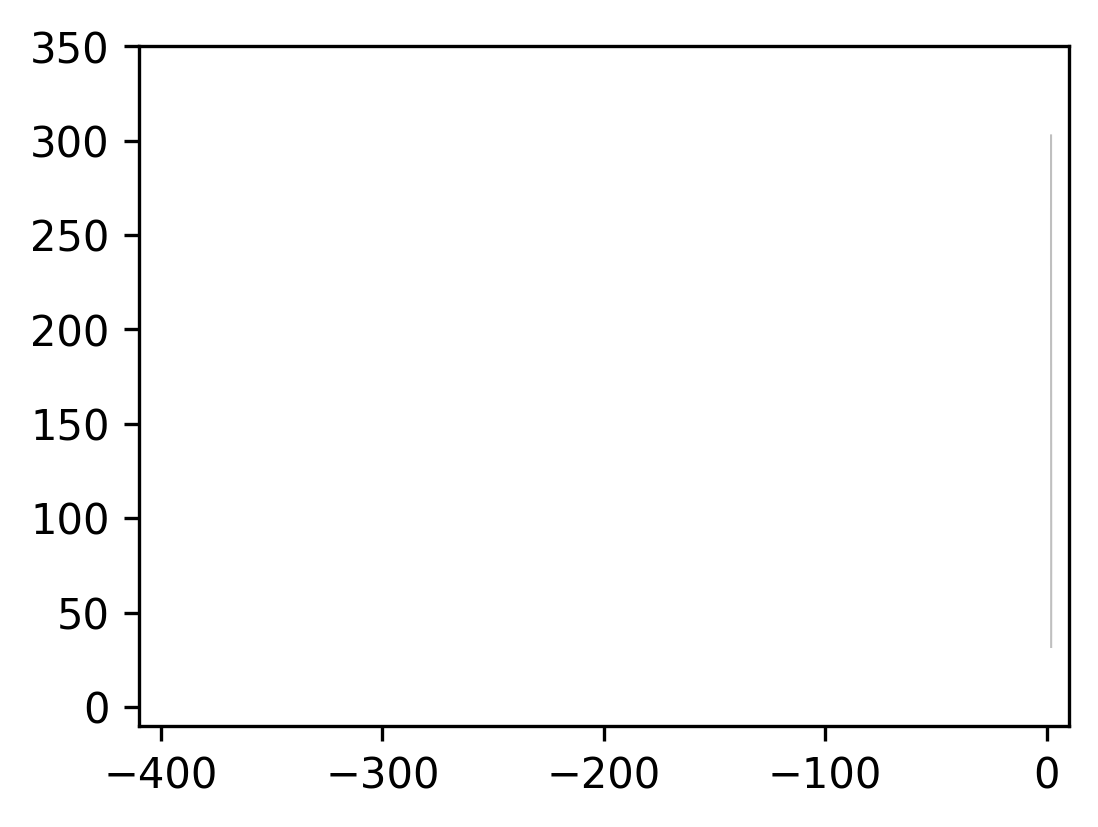

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_387.npy


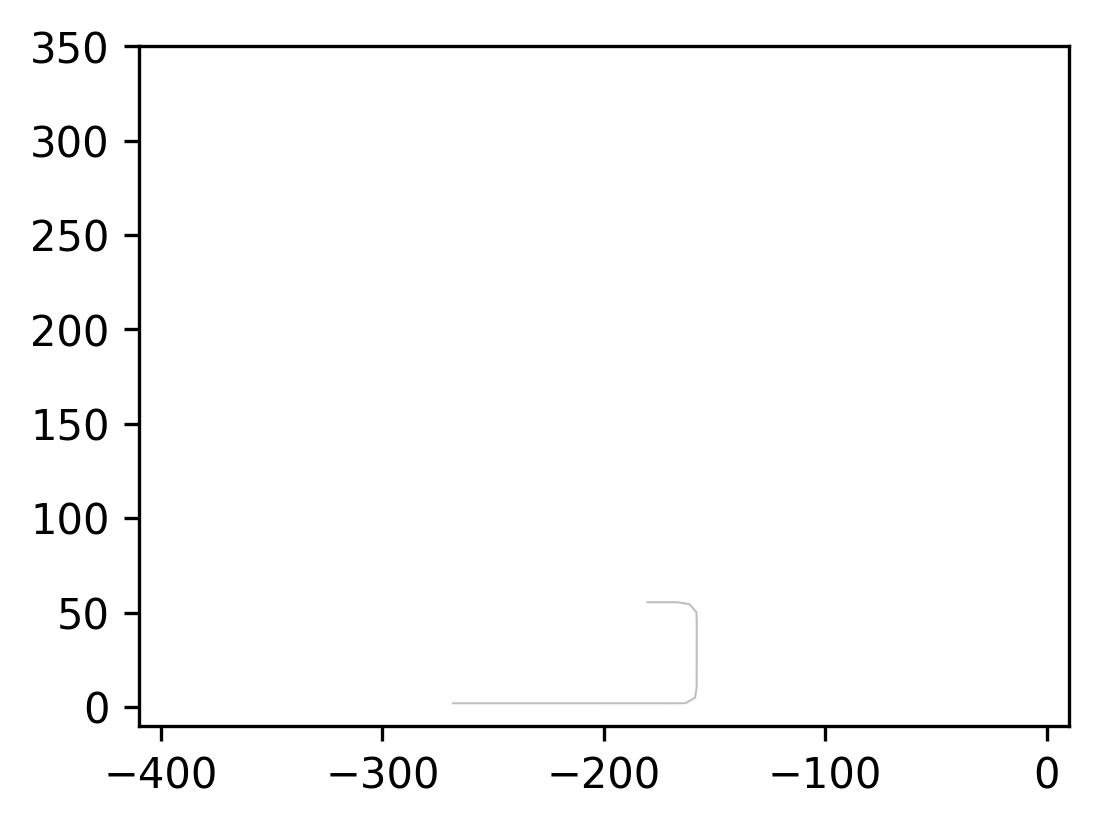

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_425.npy


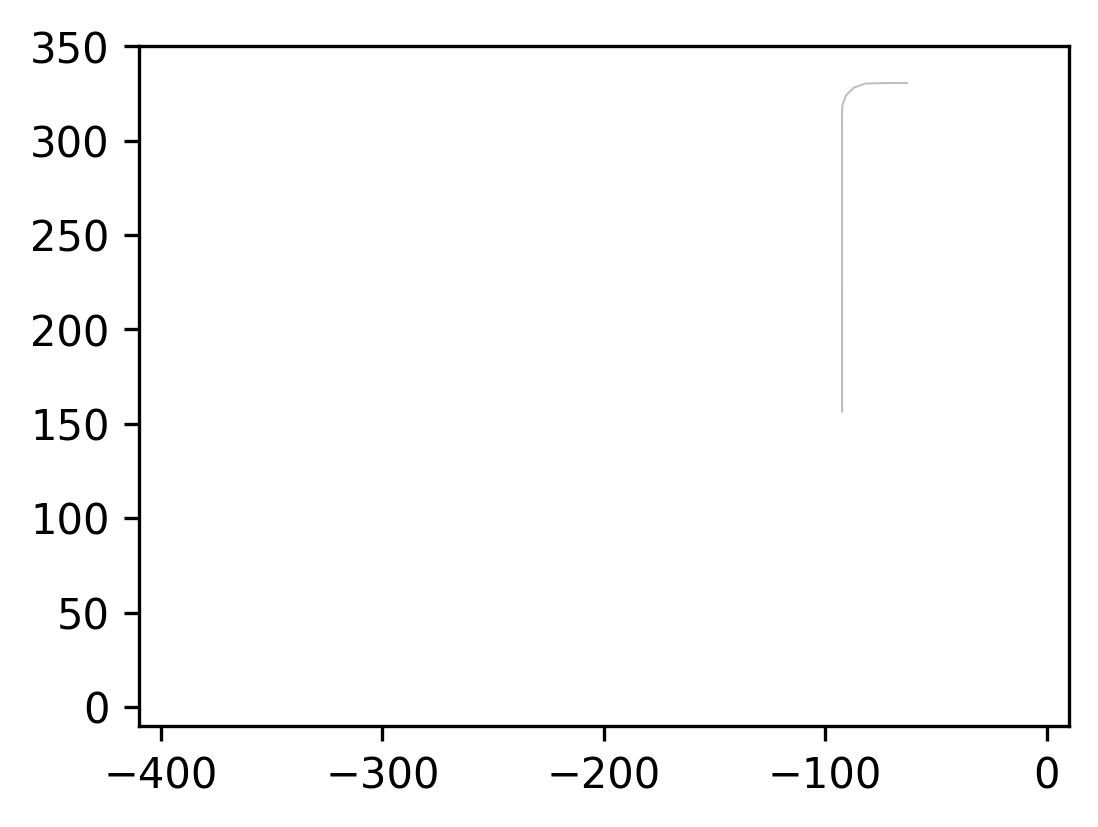

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_389.npy


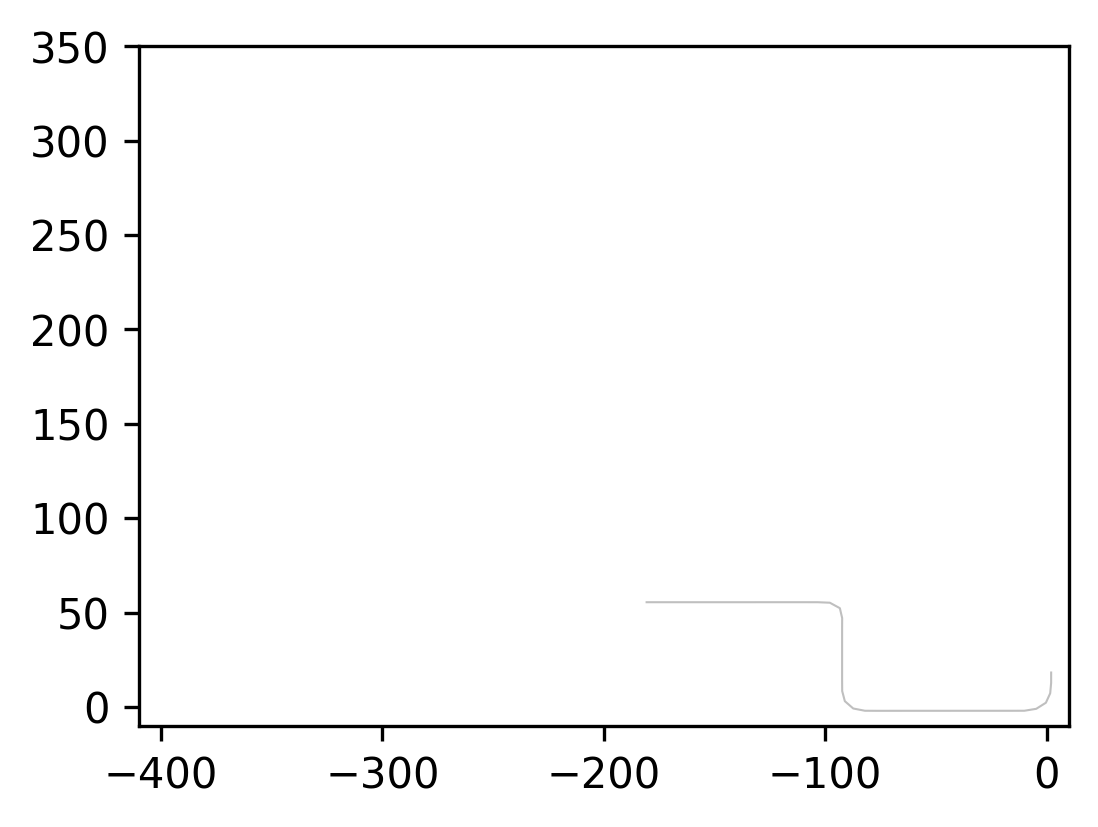

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_400.npy


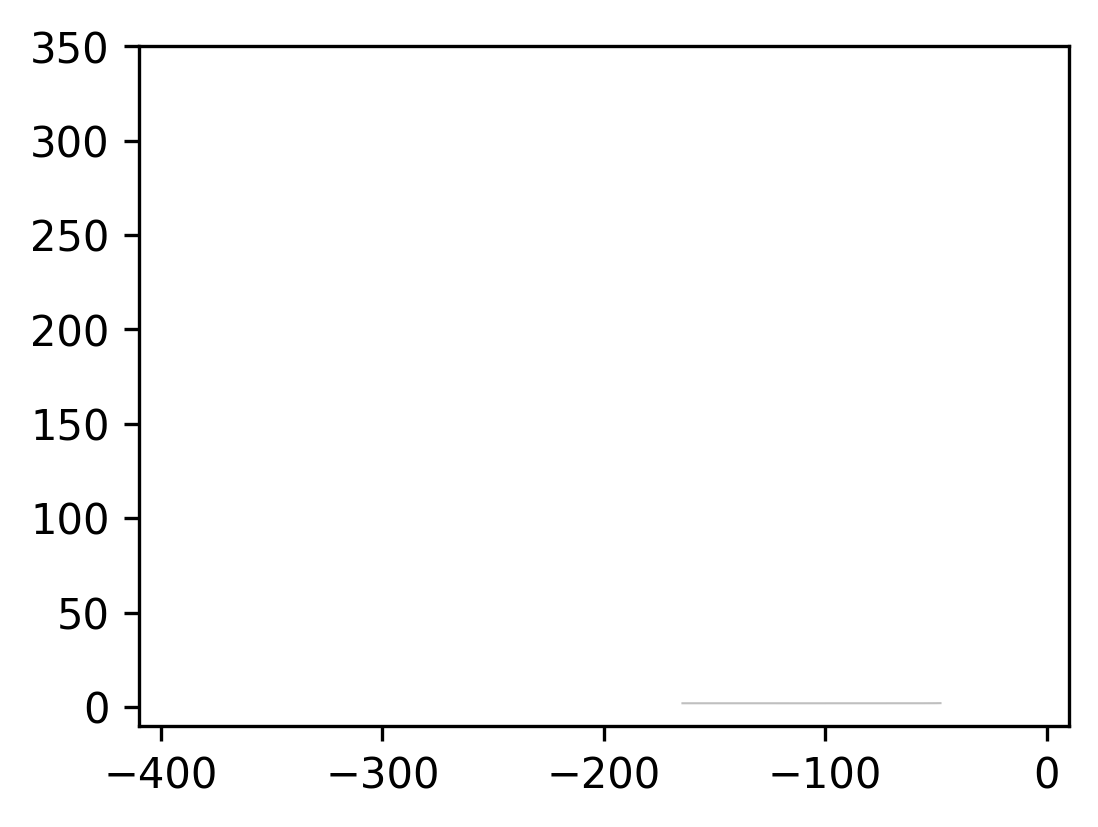

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_2.npy


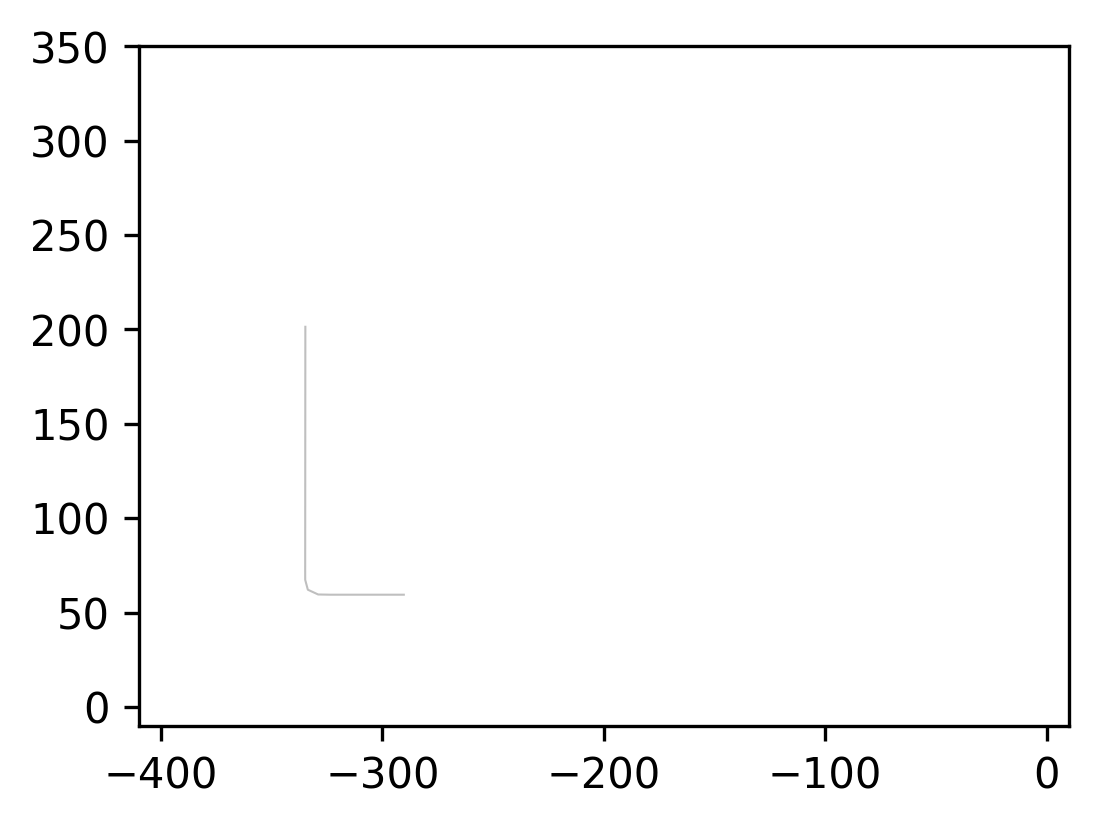

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_78.npy


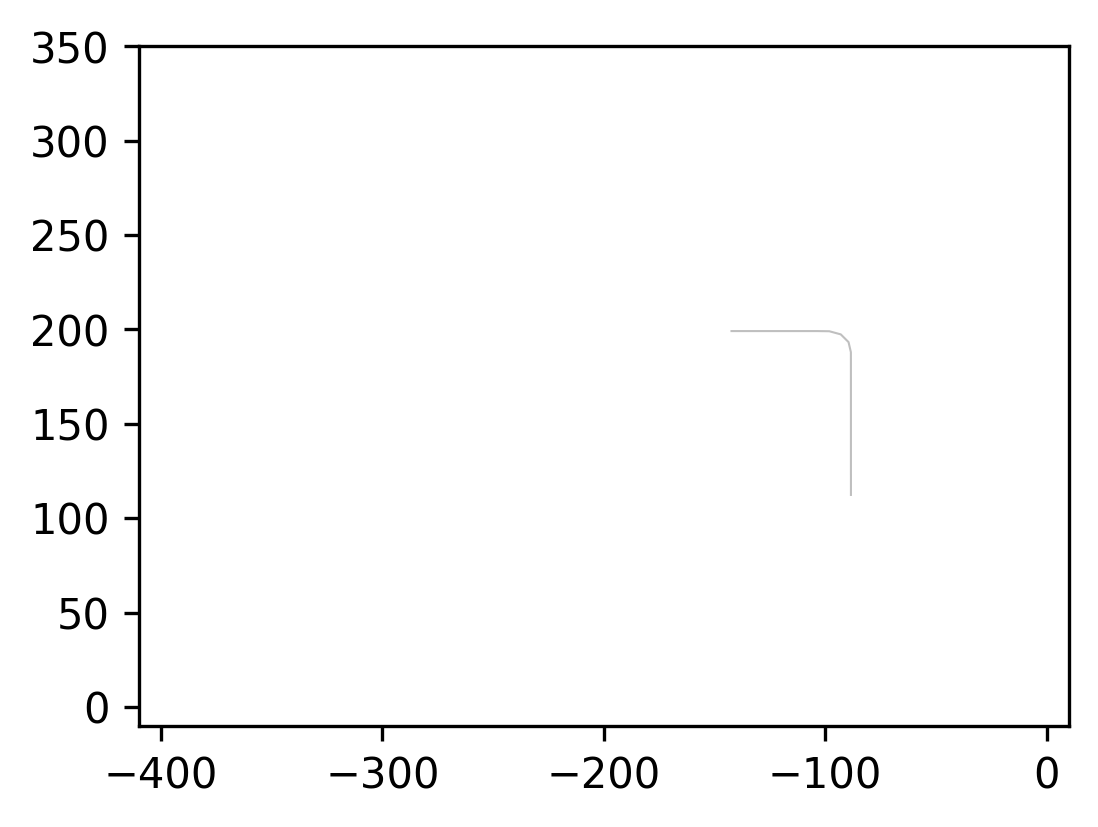

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_388.npy


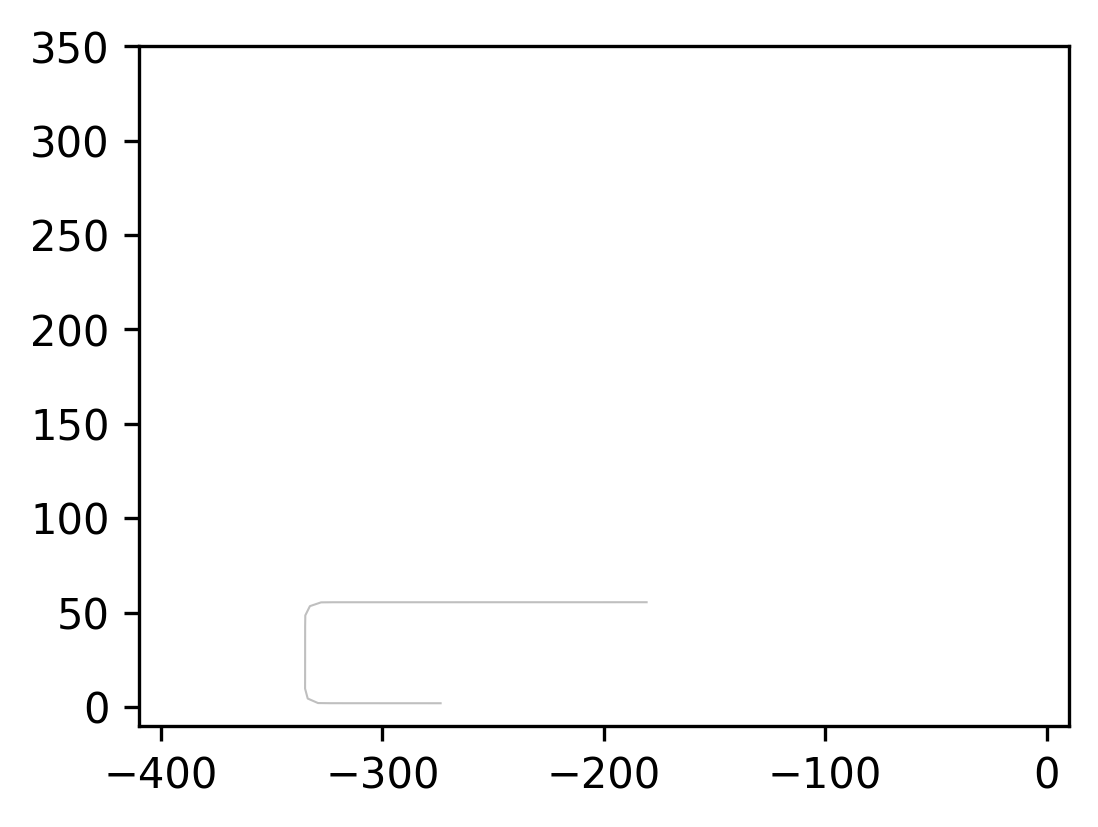

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_295.npy


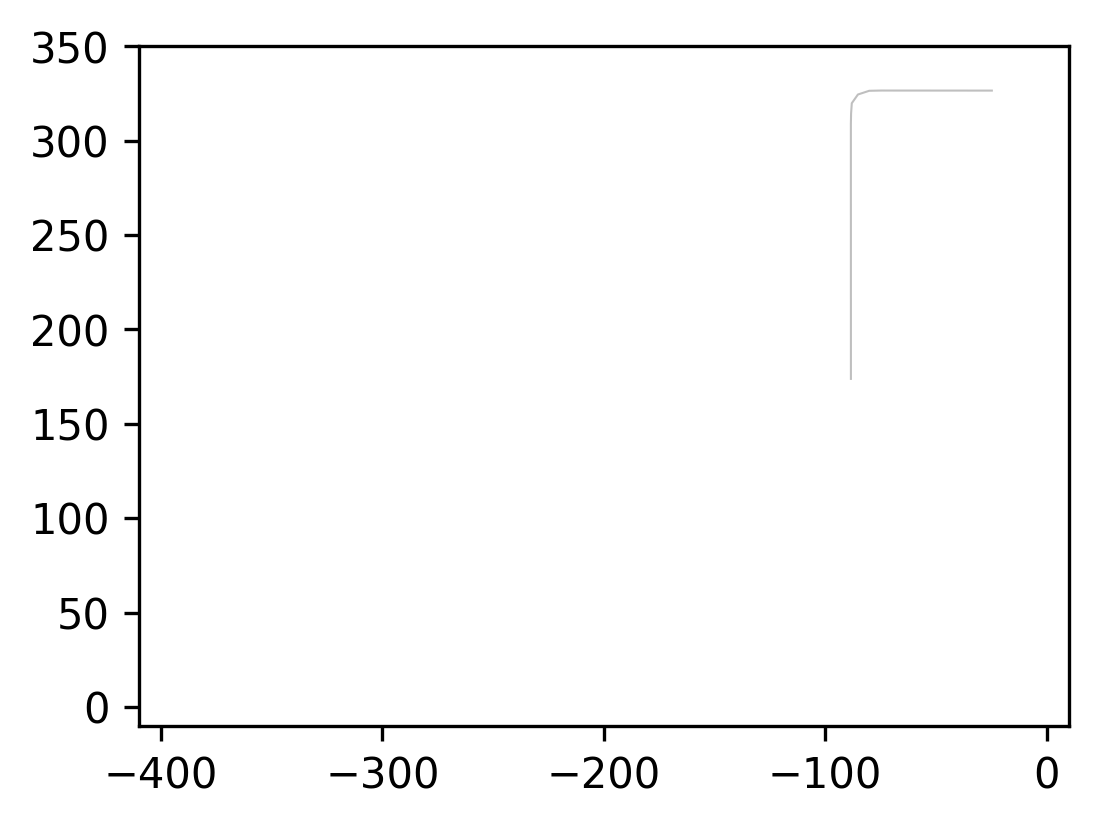

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_31.npy


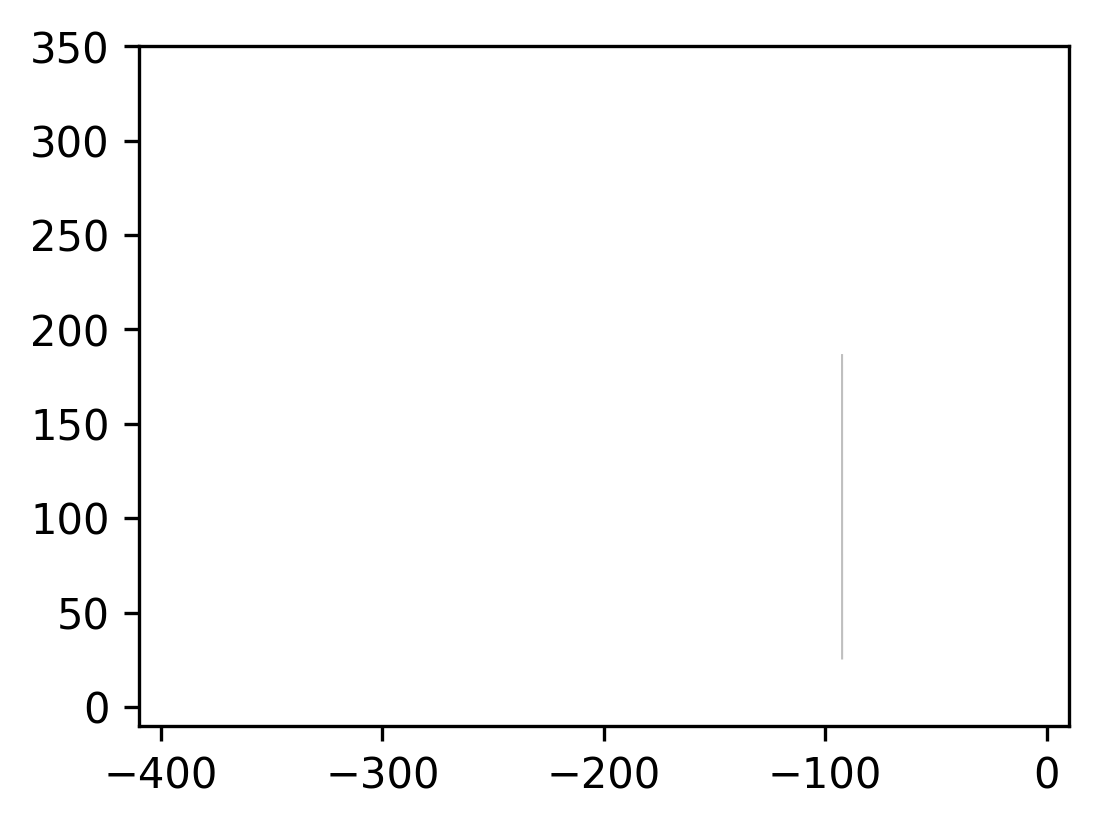

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_161.npy


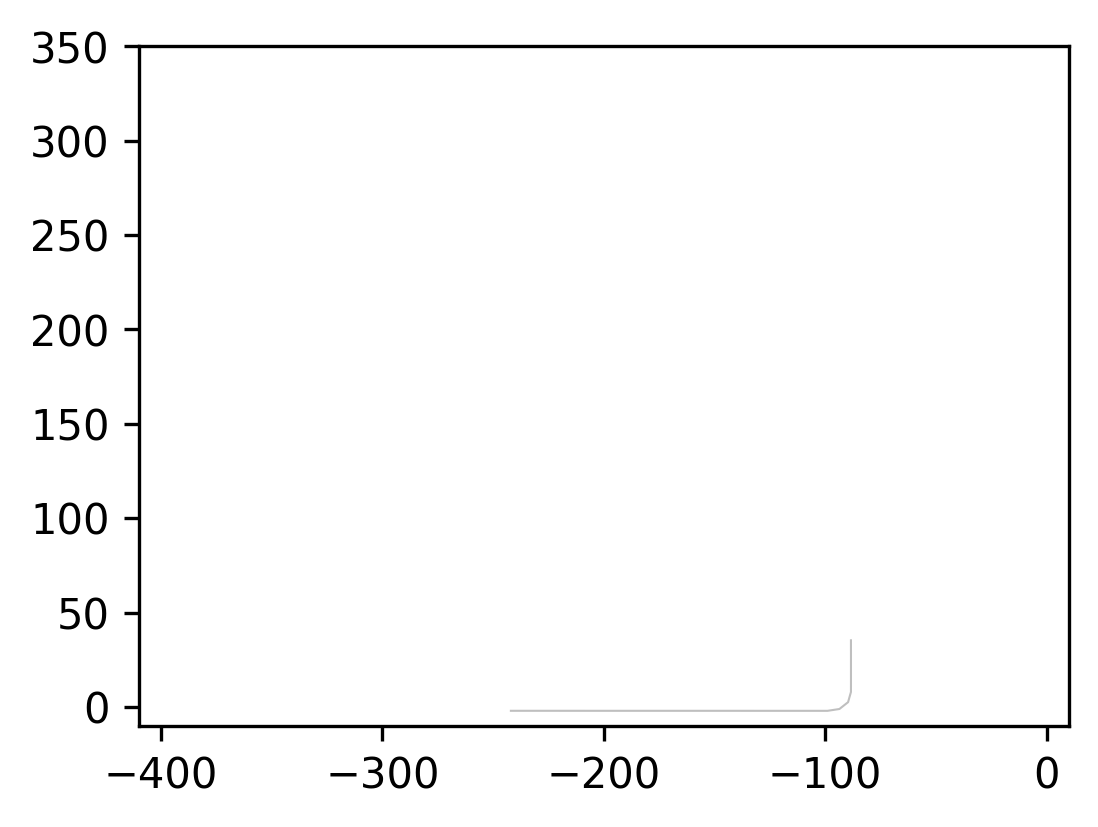

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_52.npy


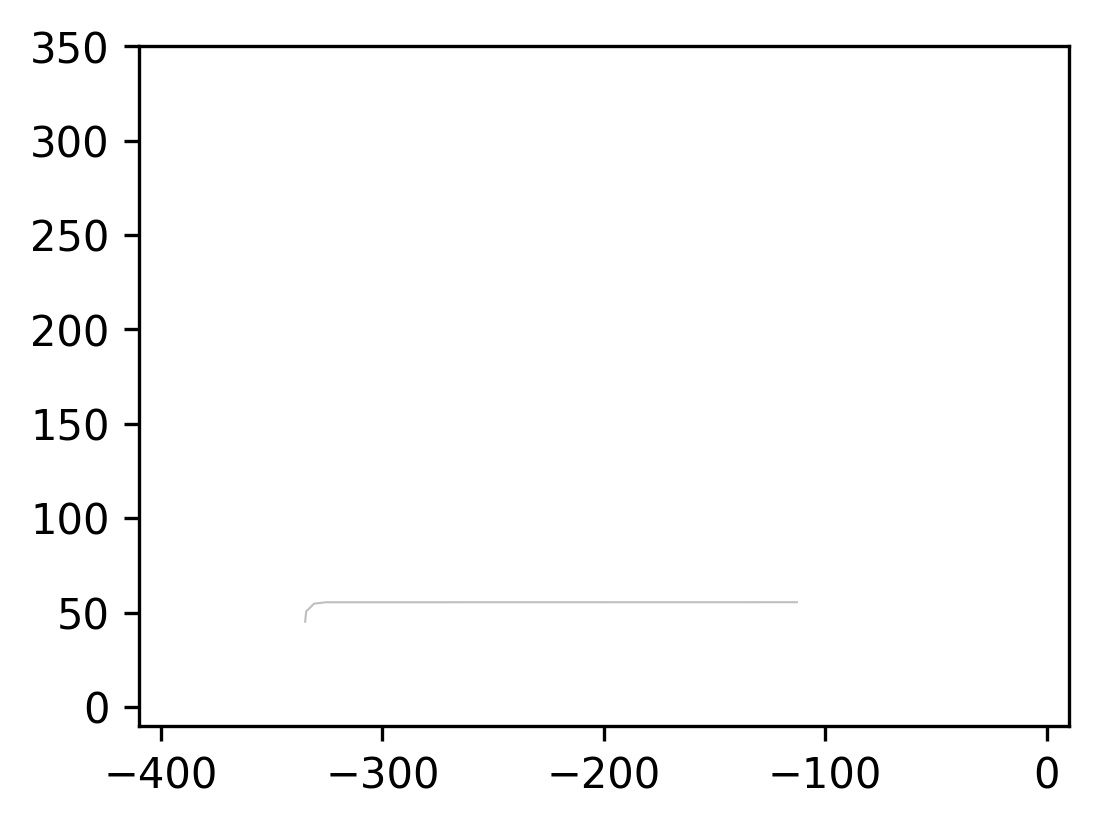

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_121.npy


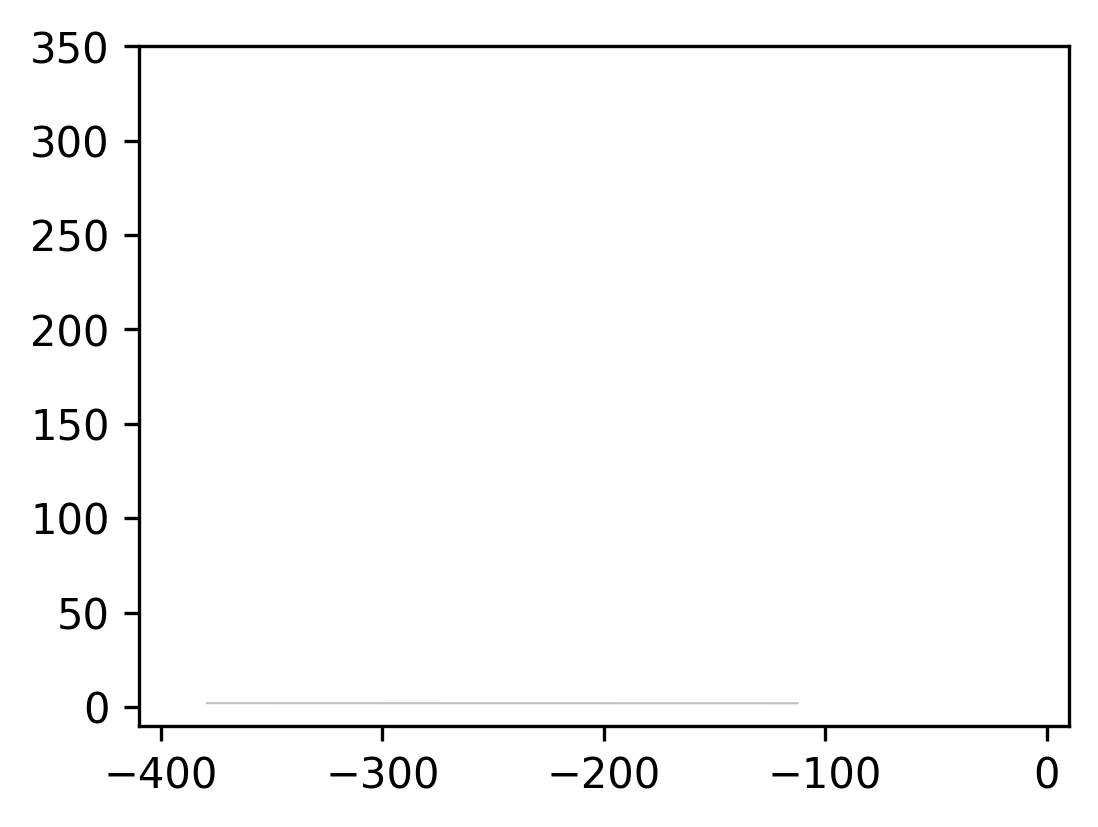

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_302.npy


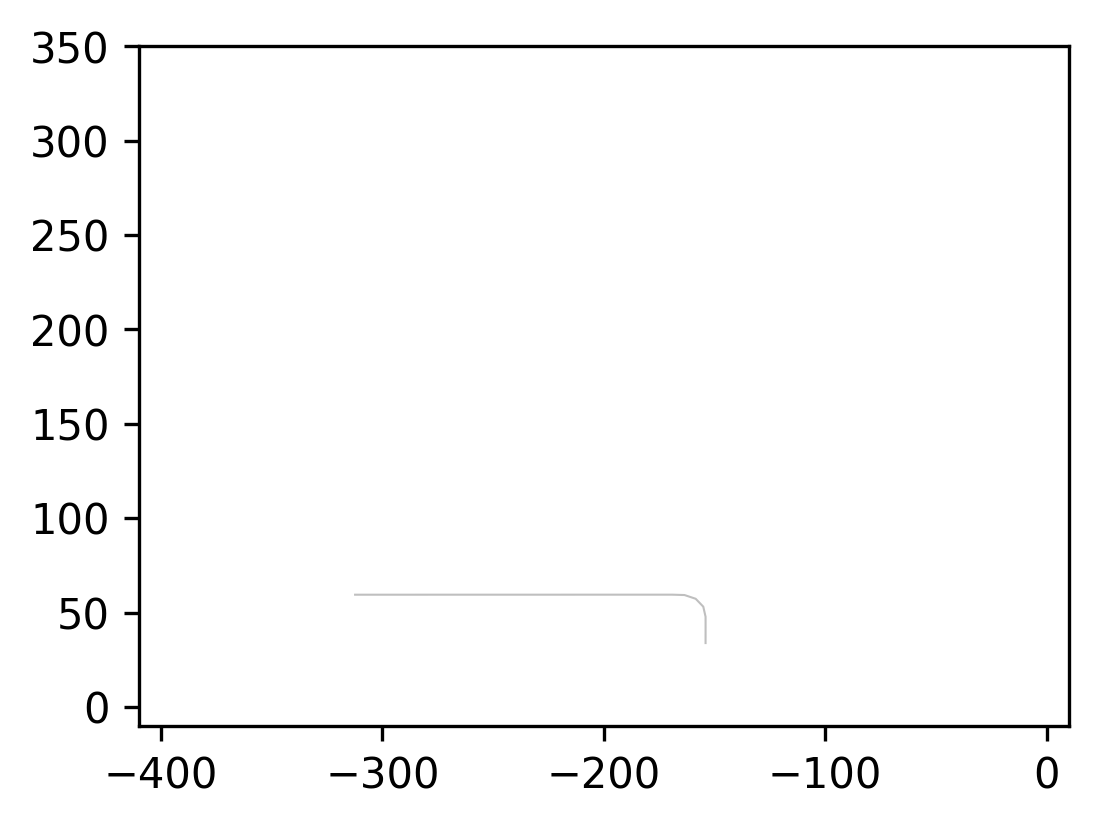

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_331.npy


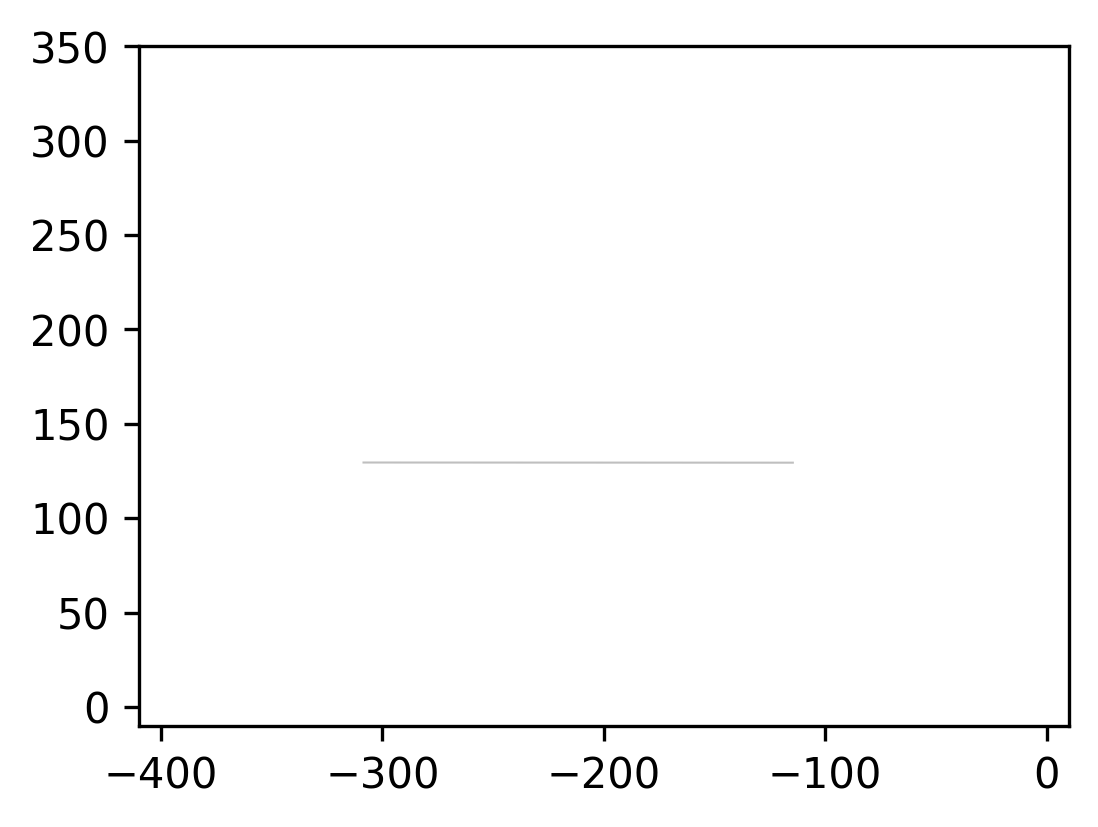

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_57.npy


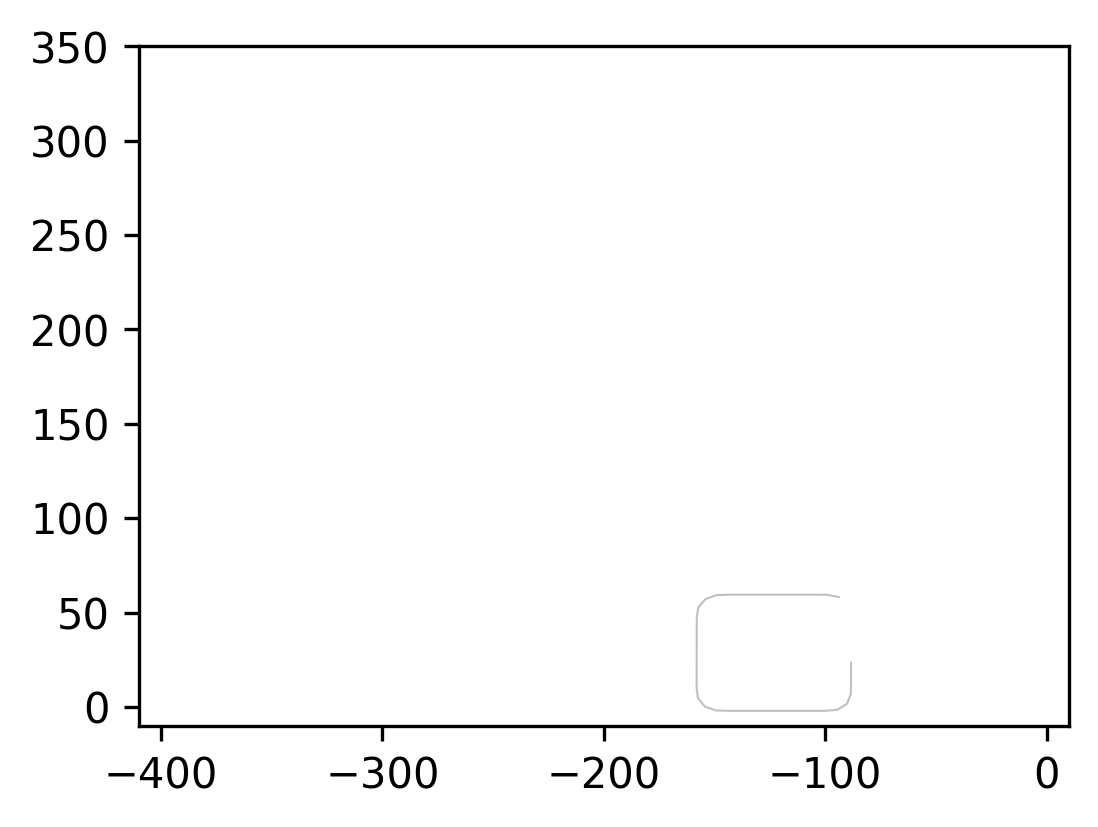

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_315.npy


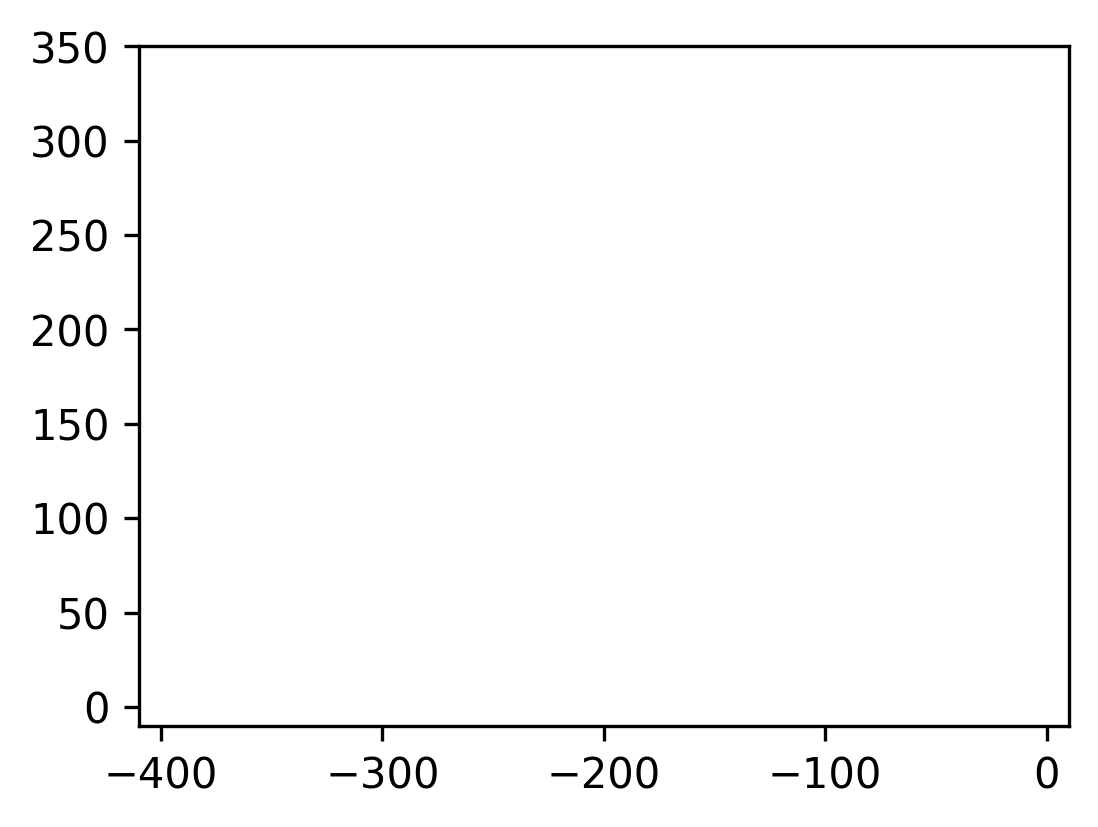

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_497.npy


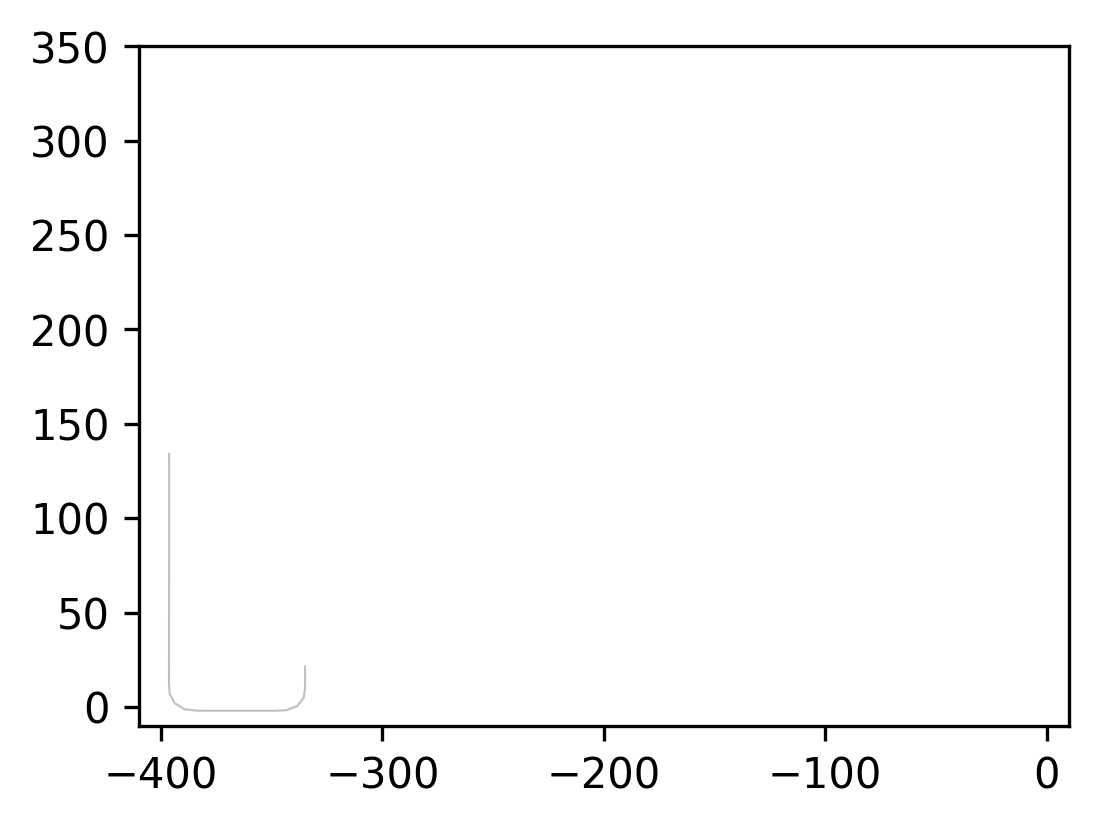

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_87.npy


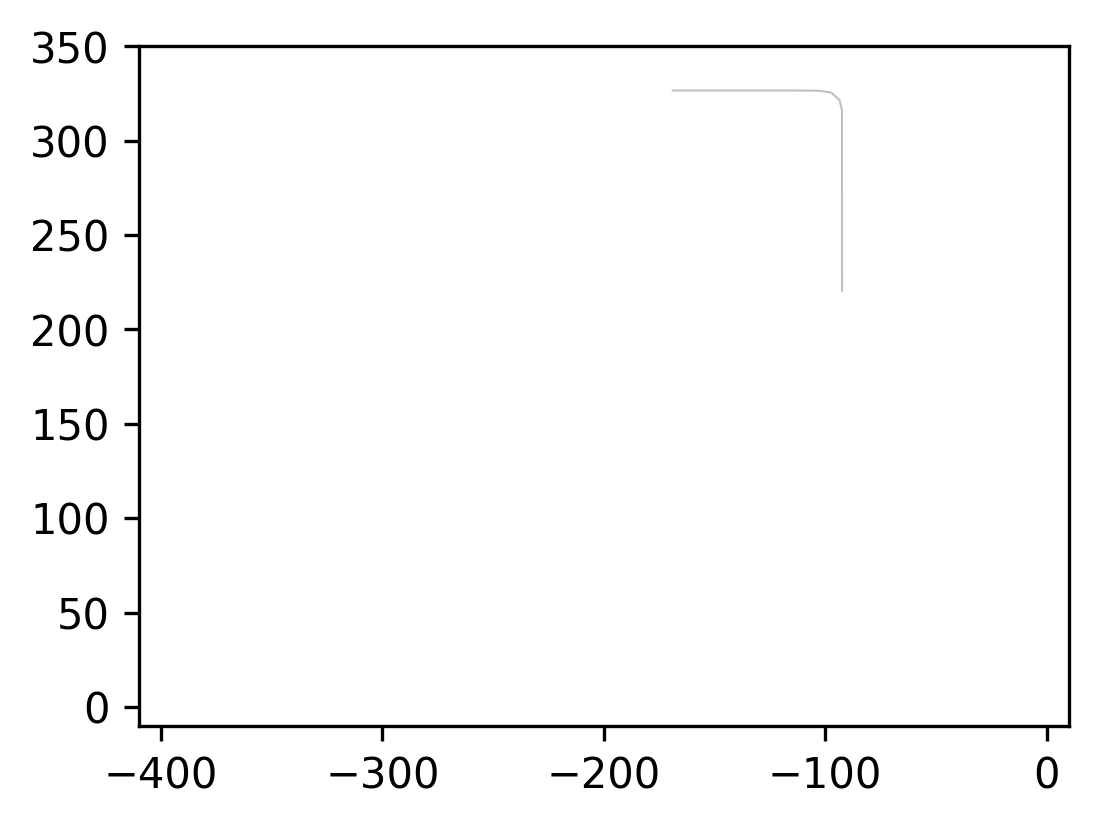

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_510.npy


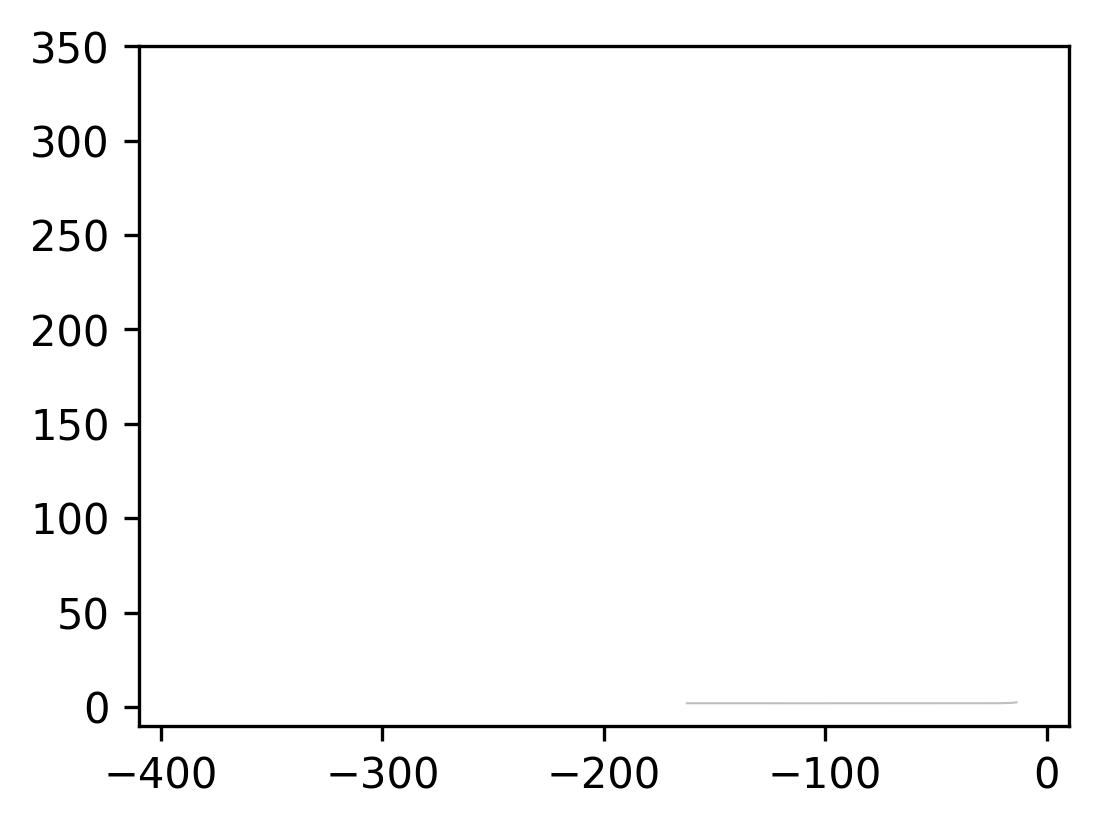

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_140.npy


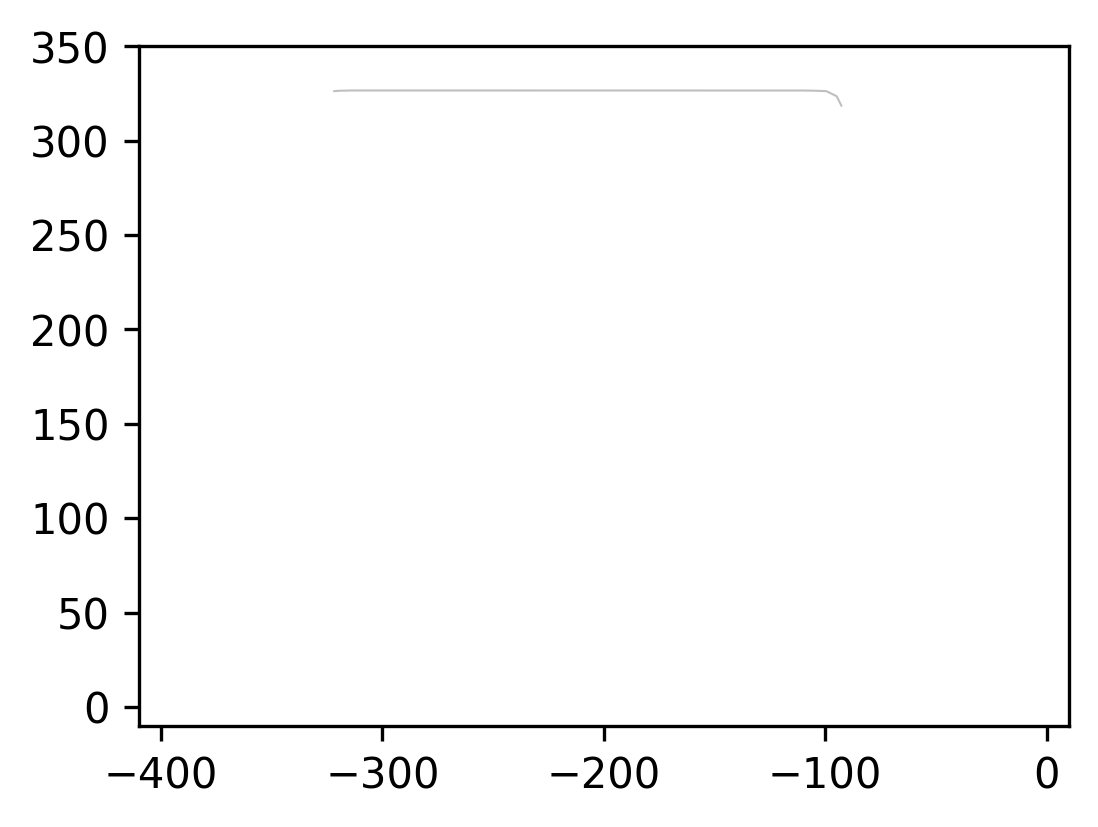

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_259.npy


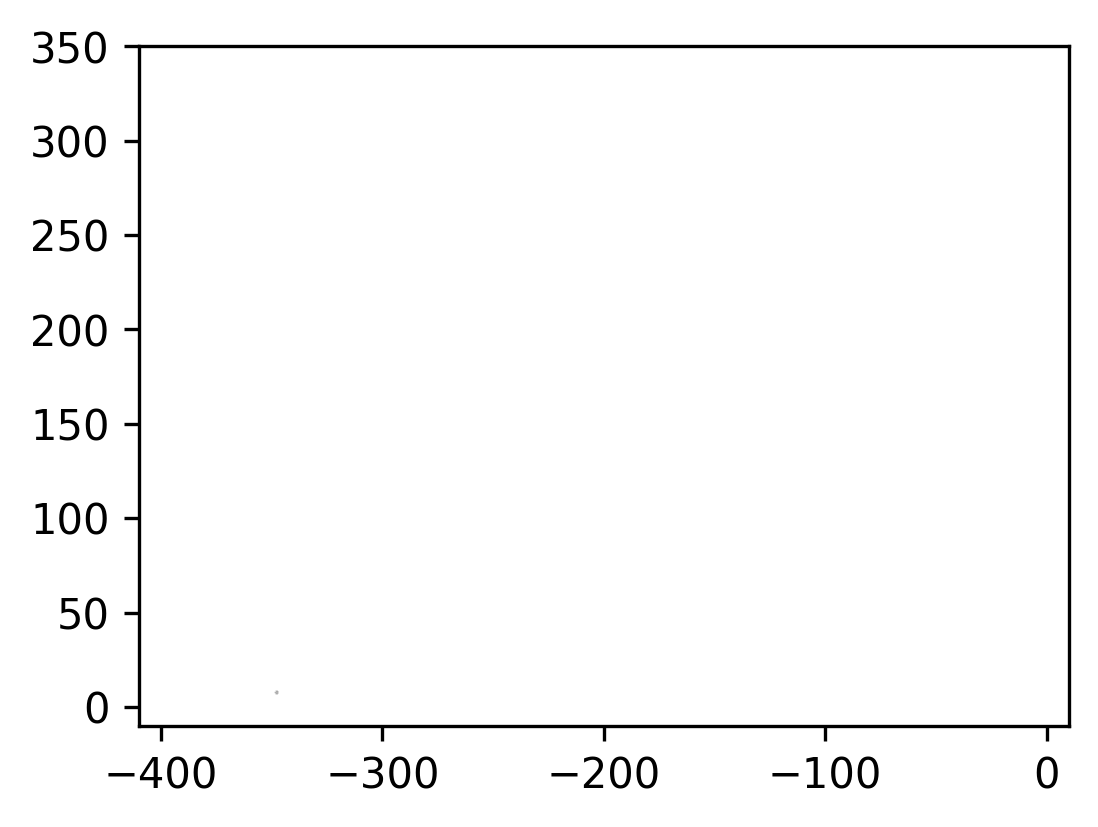

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_155.npy


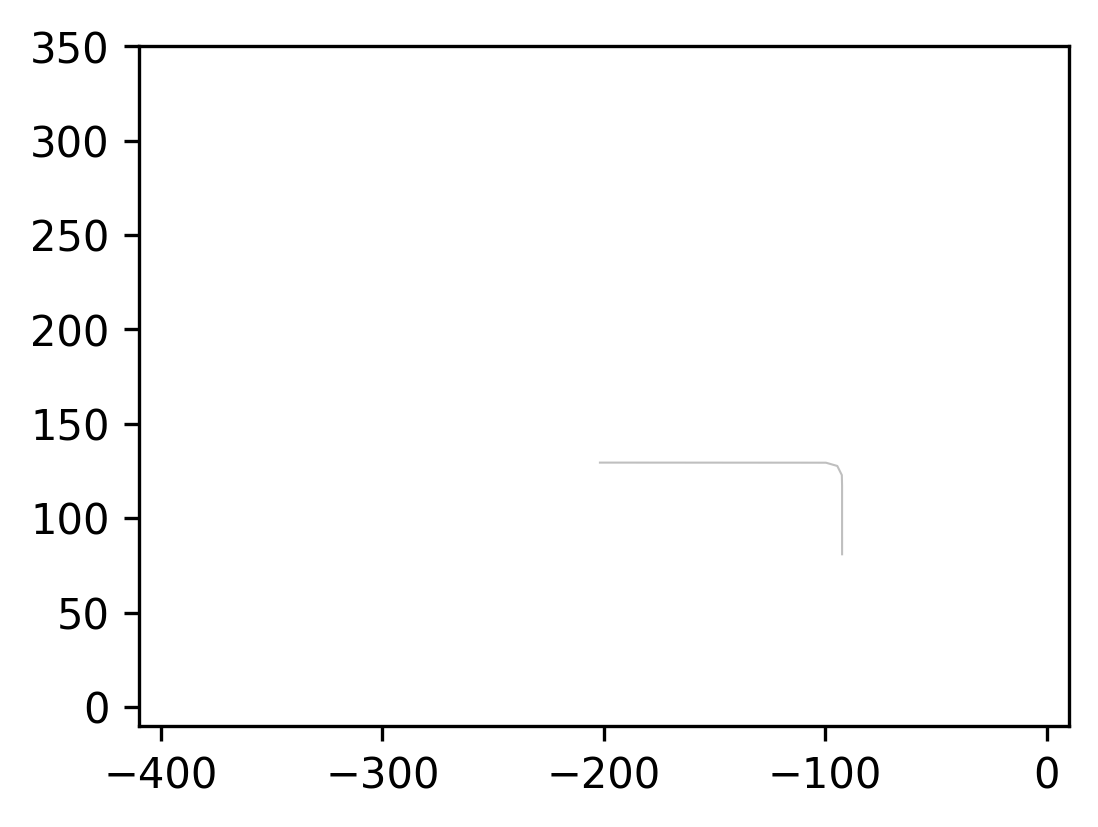

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_238.npy


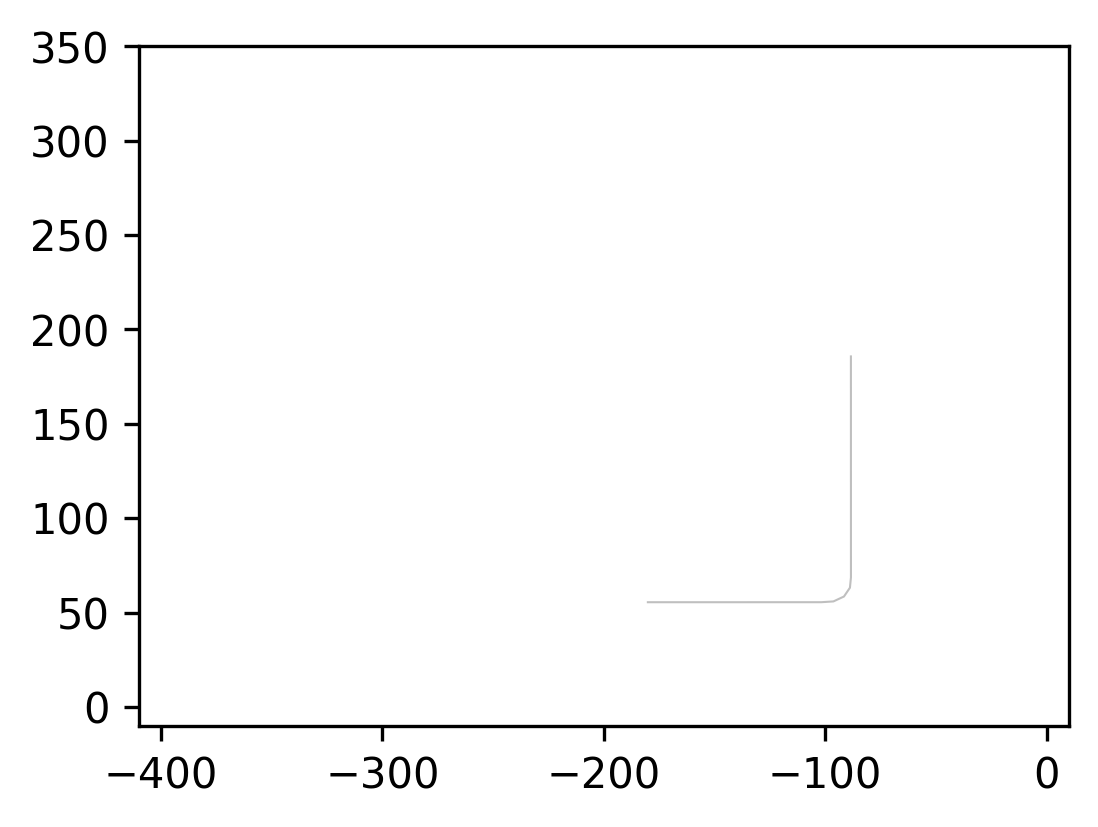

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_112.npy


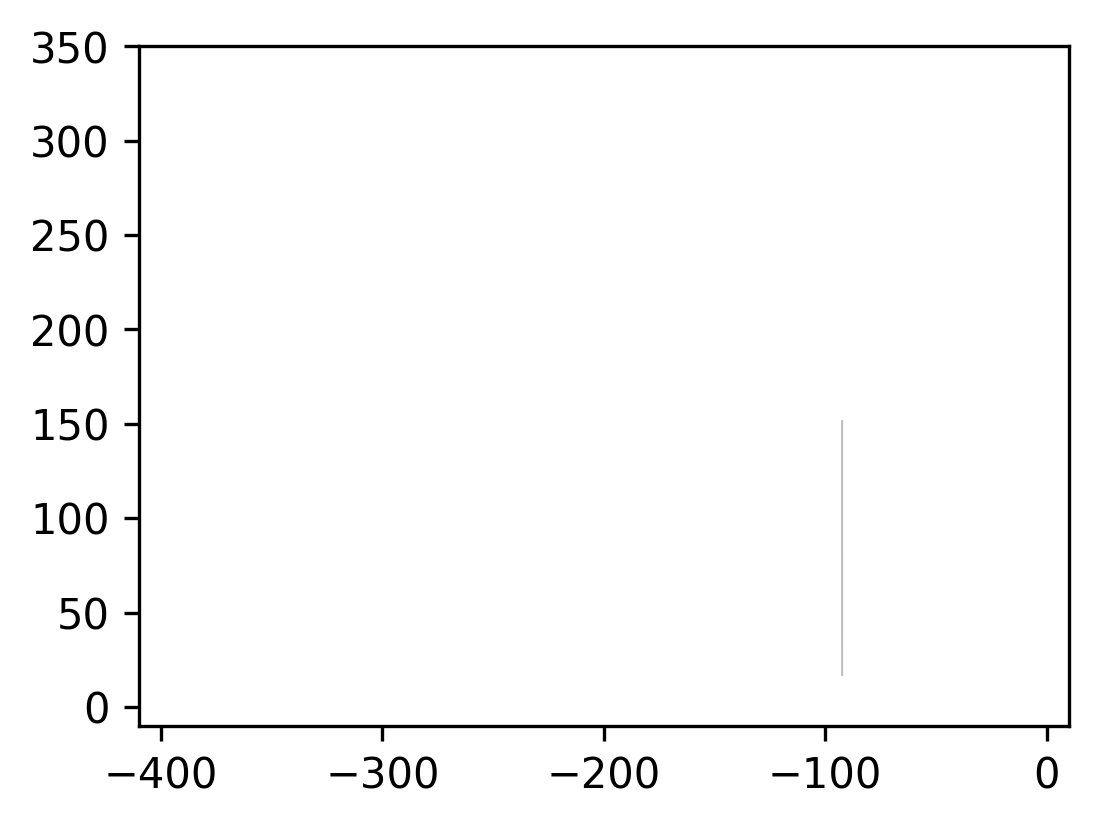

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_207.npy


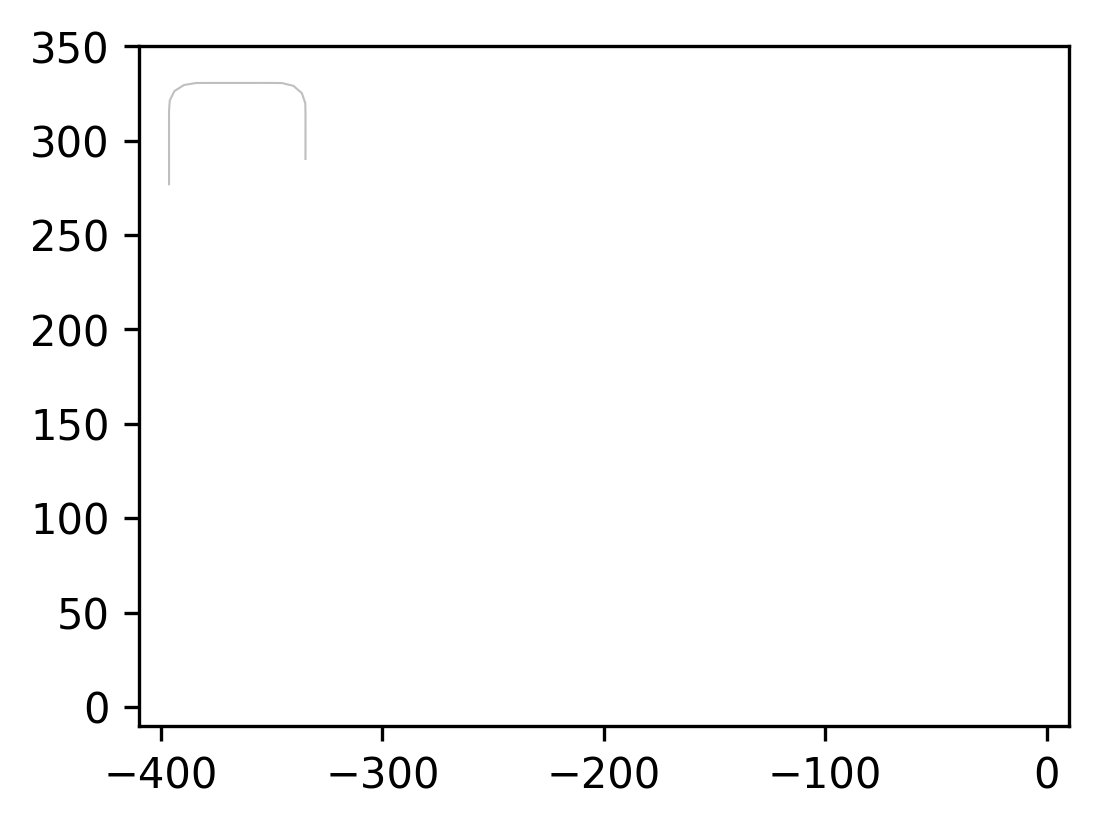

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_85.npy


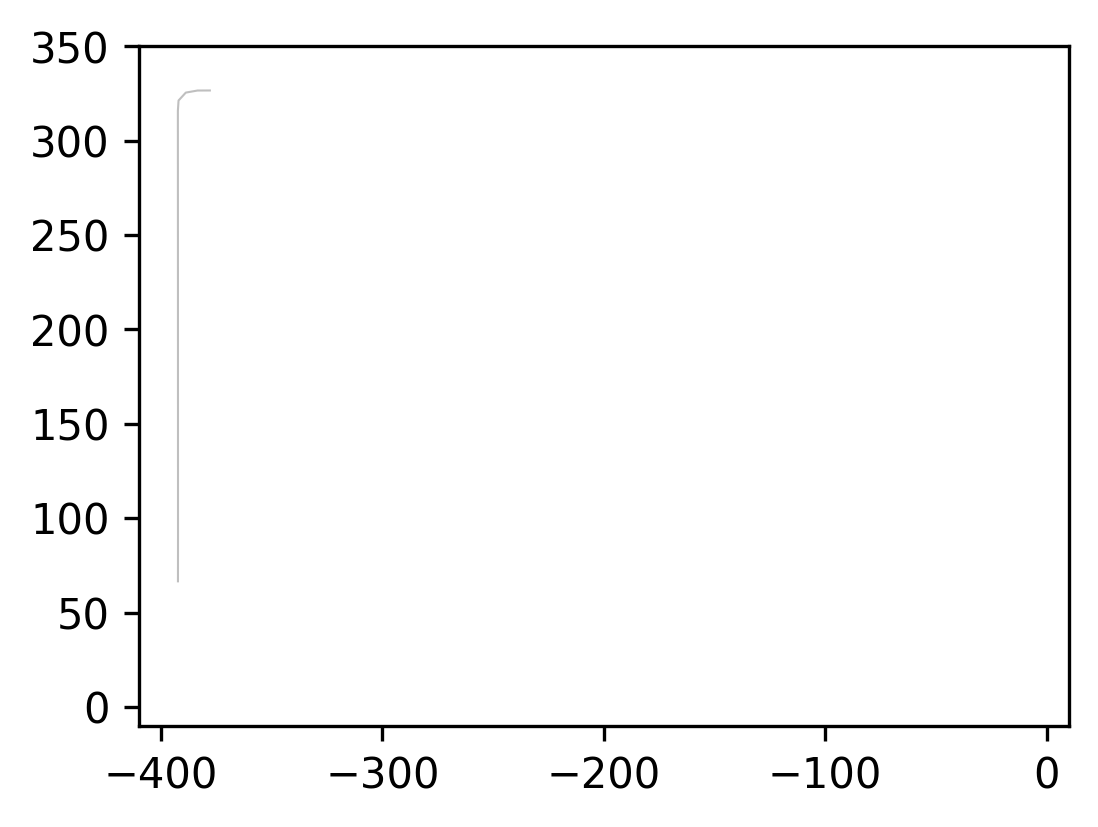

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_513.npy


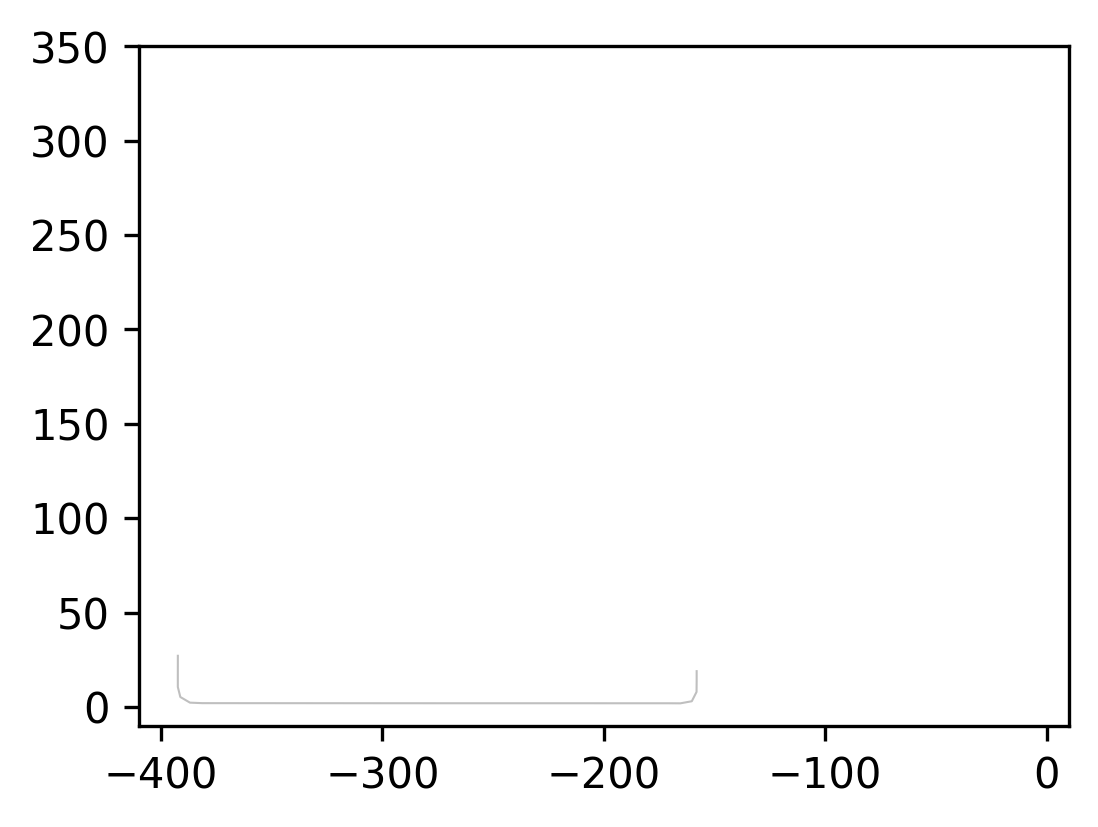

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_532.npy


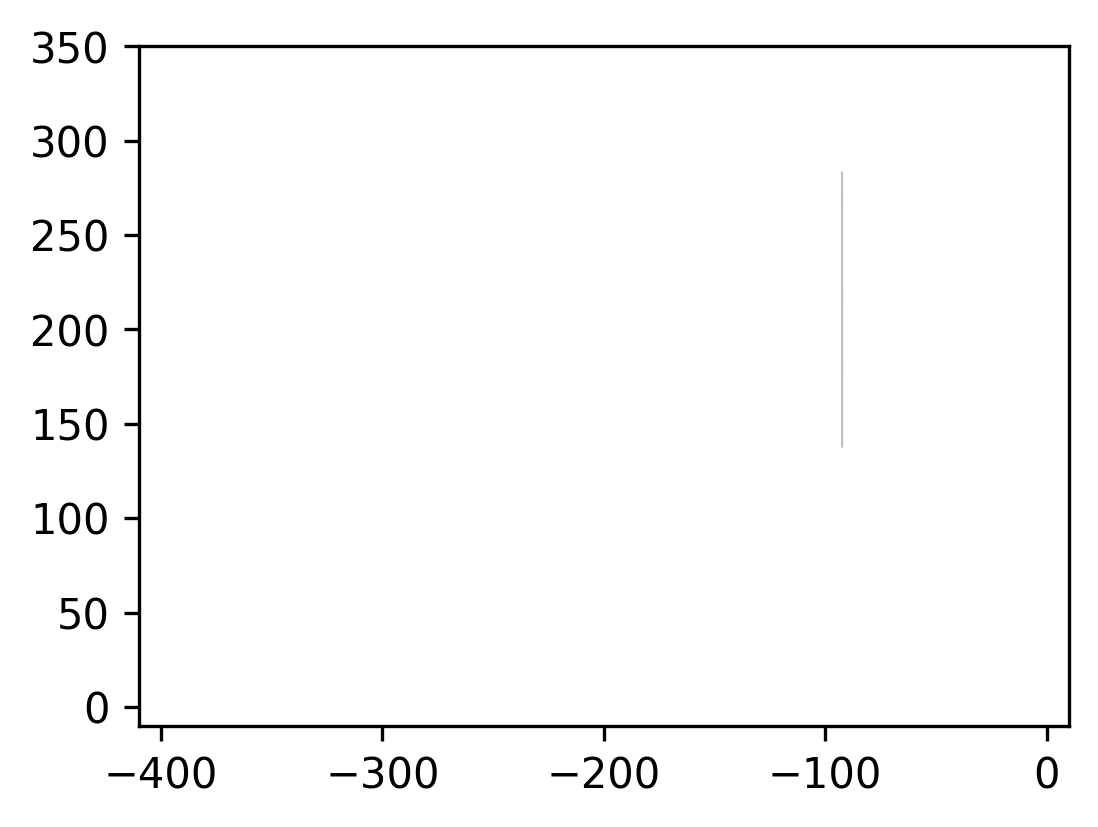

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_365.npy


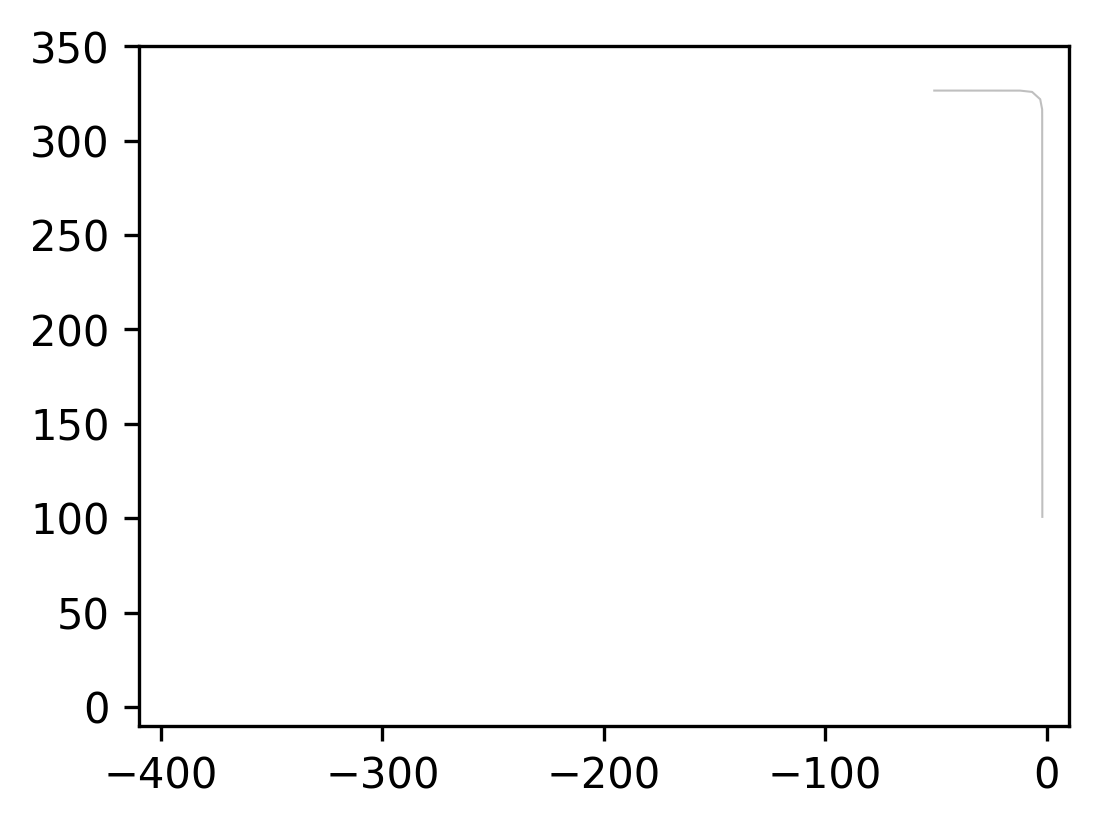

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_243.npy


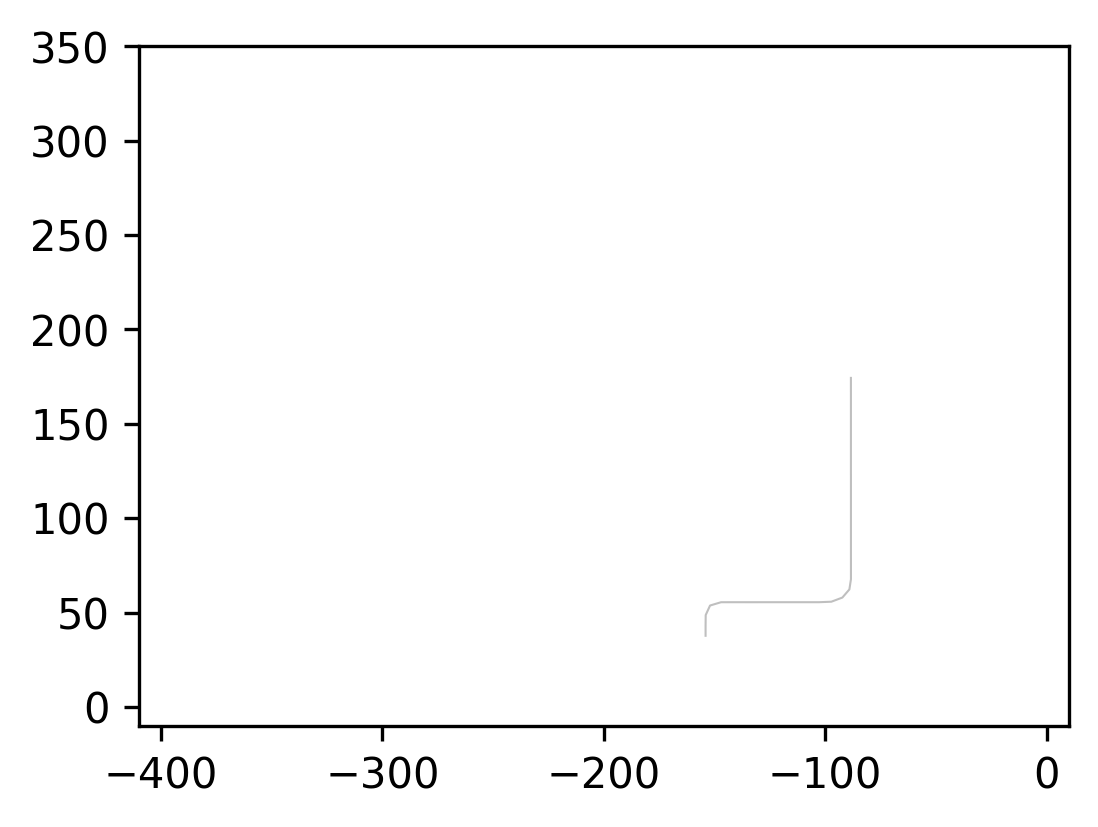

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_415.npy


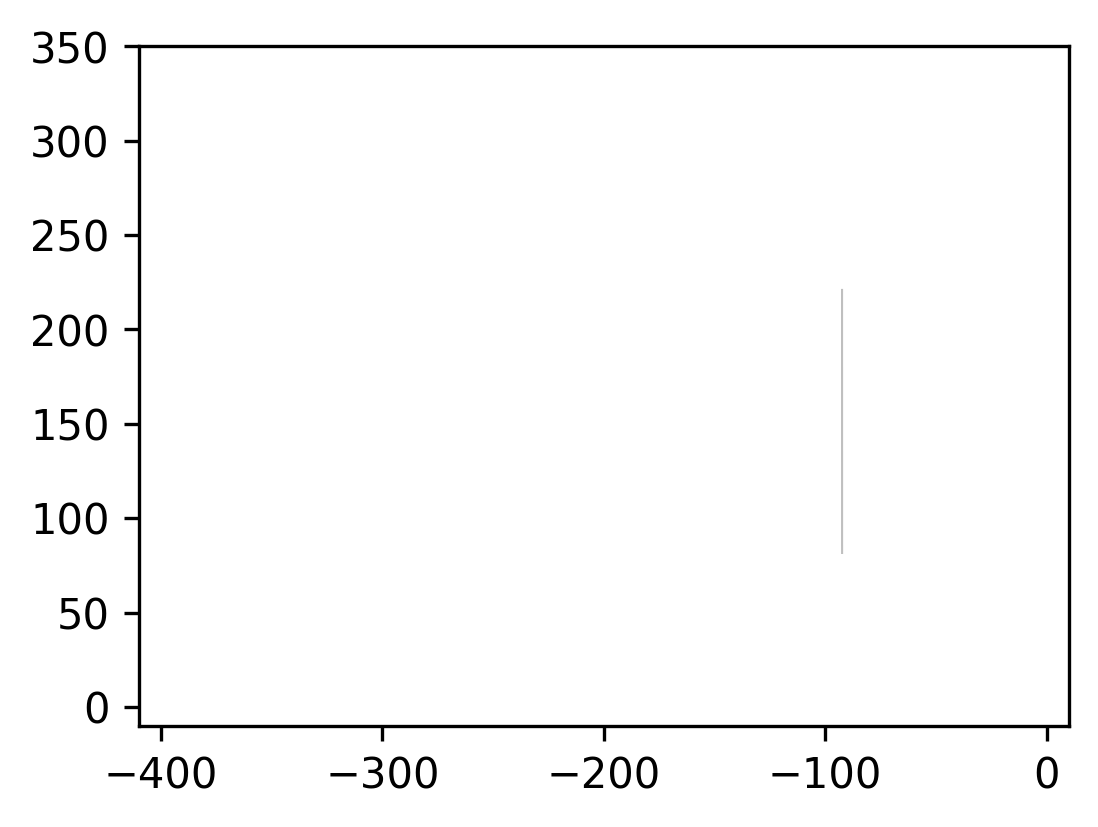

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_184.npy


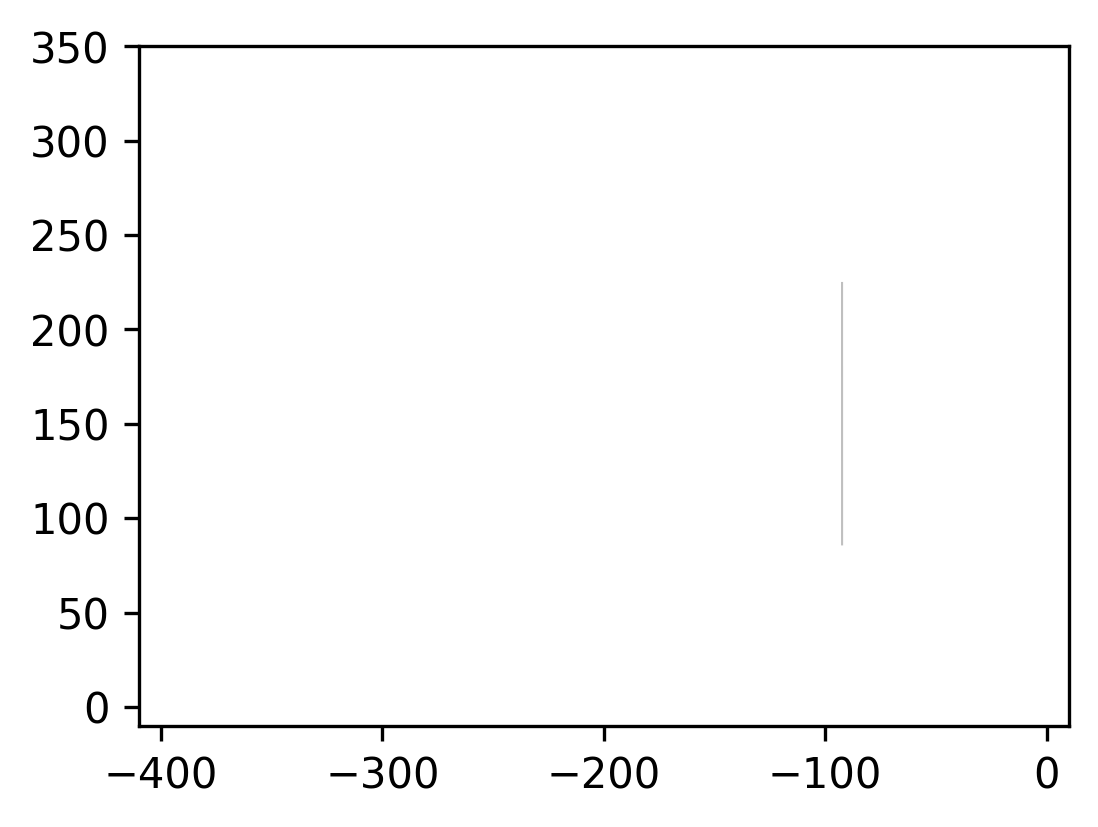

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_73.npy


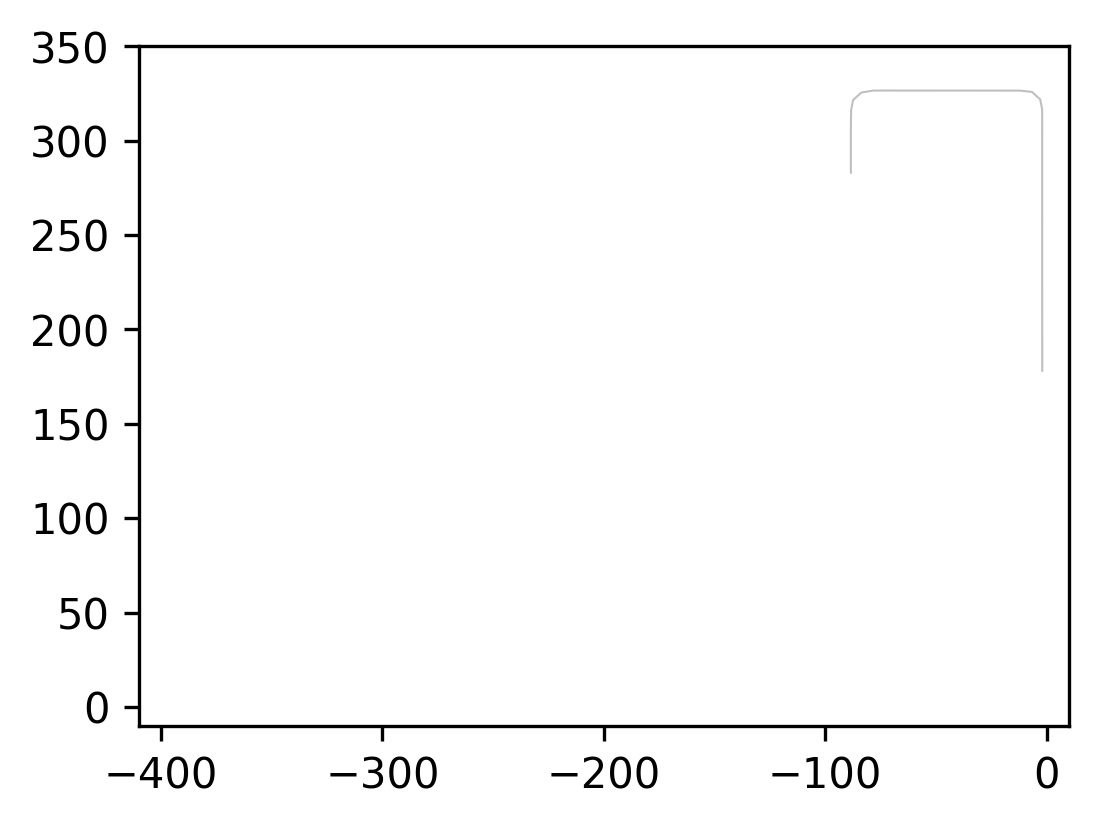

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_507.npy


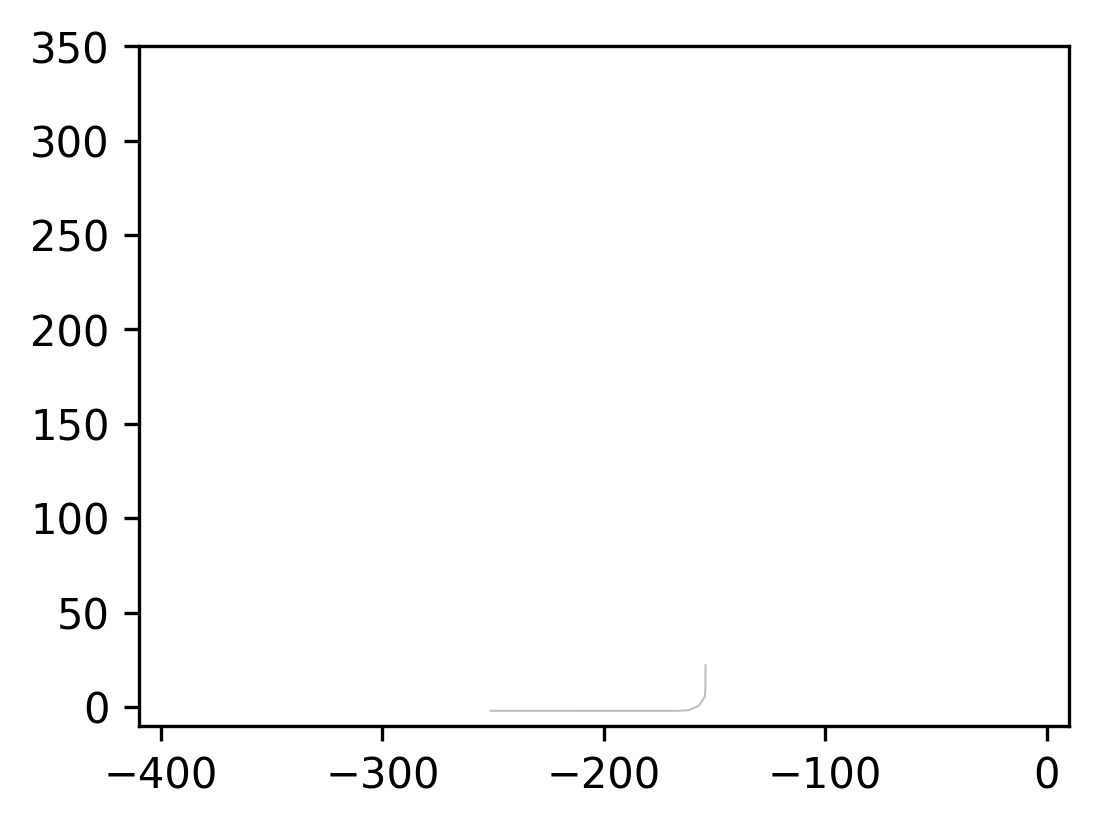

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_257.npy


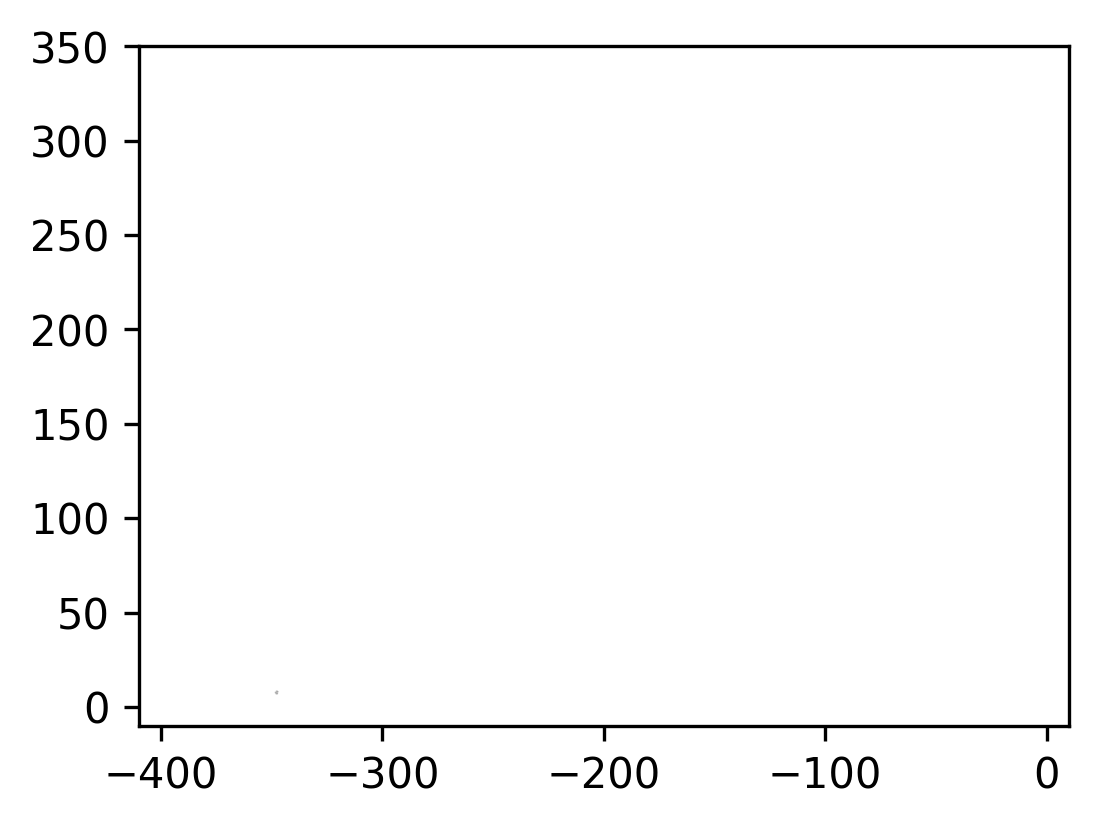

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_374.npy


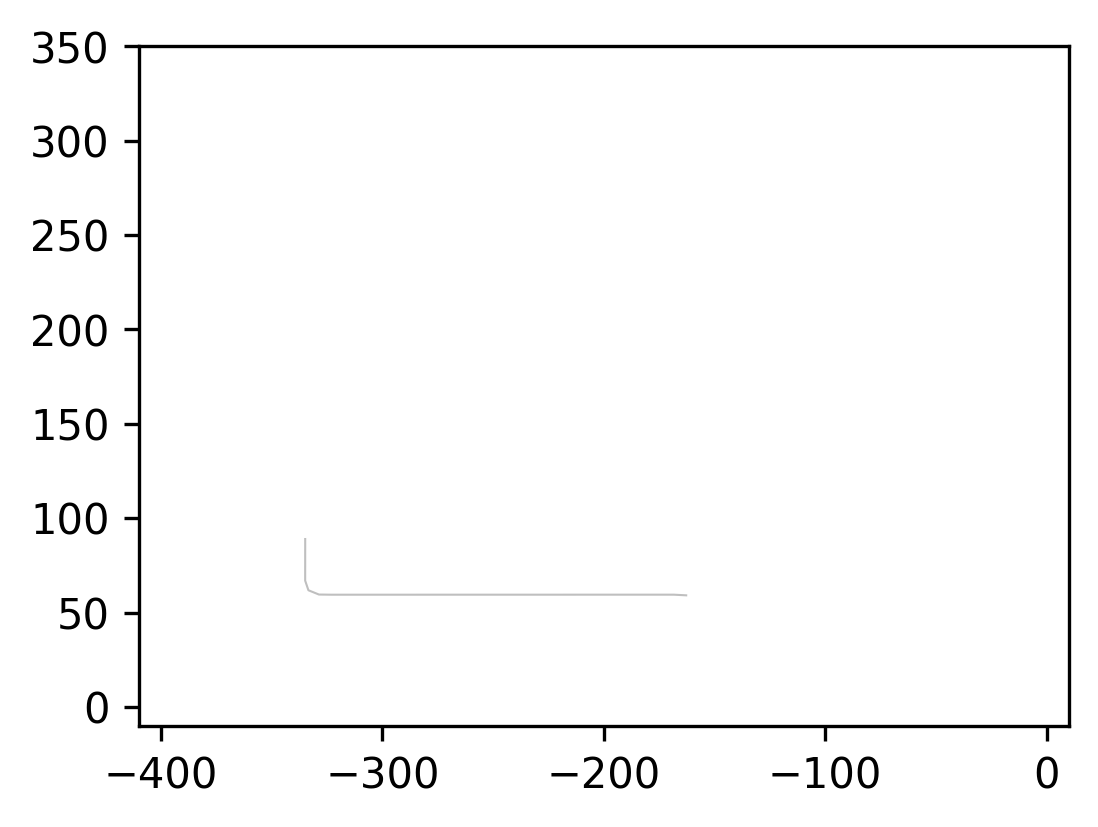

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_444.npy


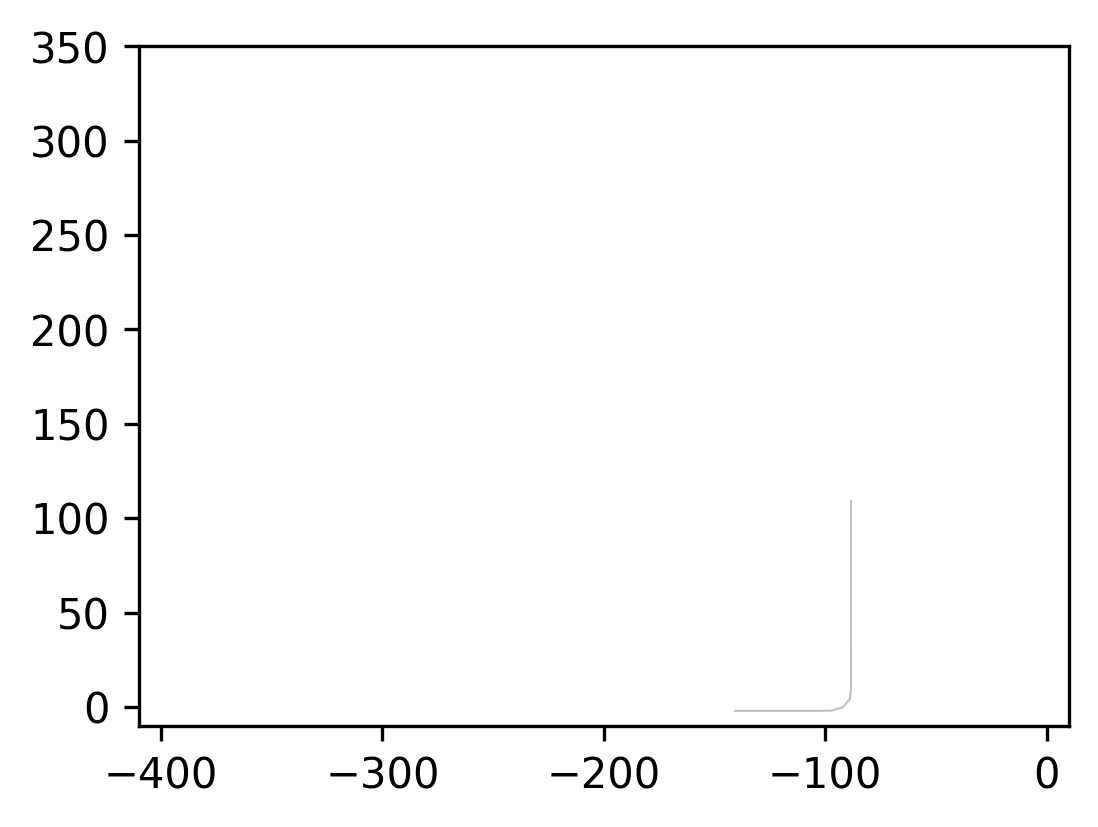

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_218.npy


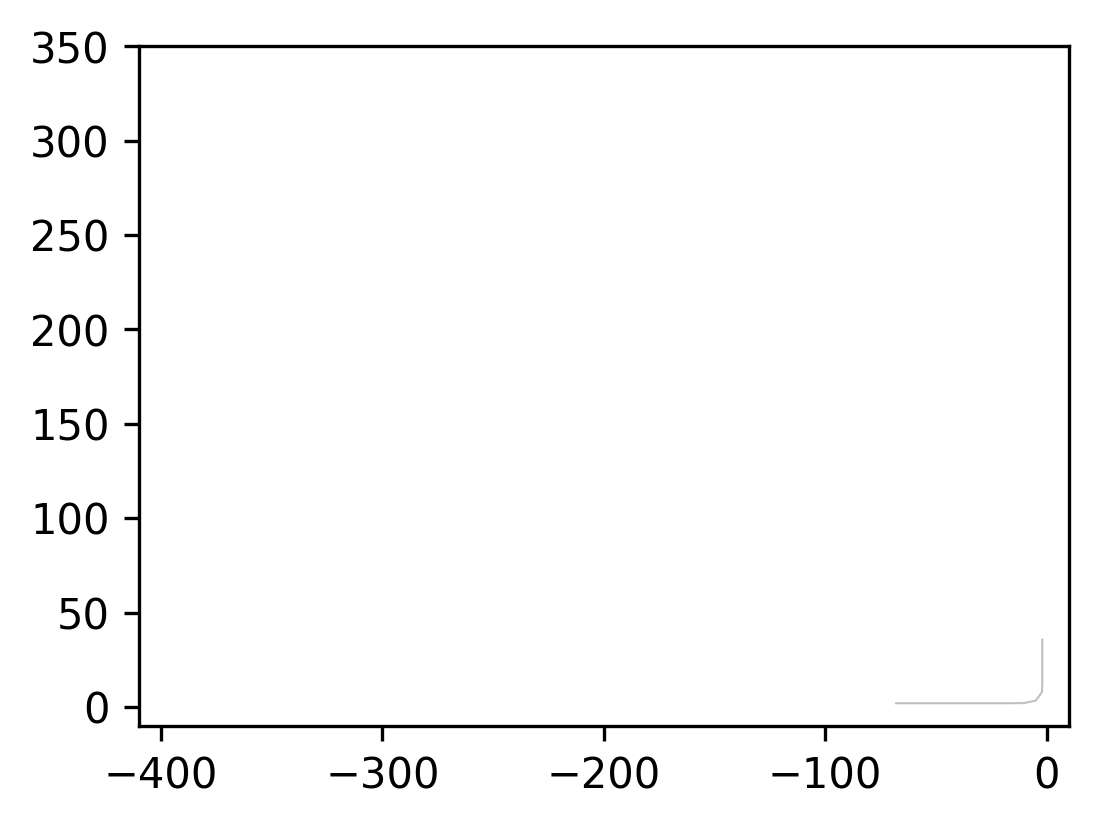

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_338.npy


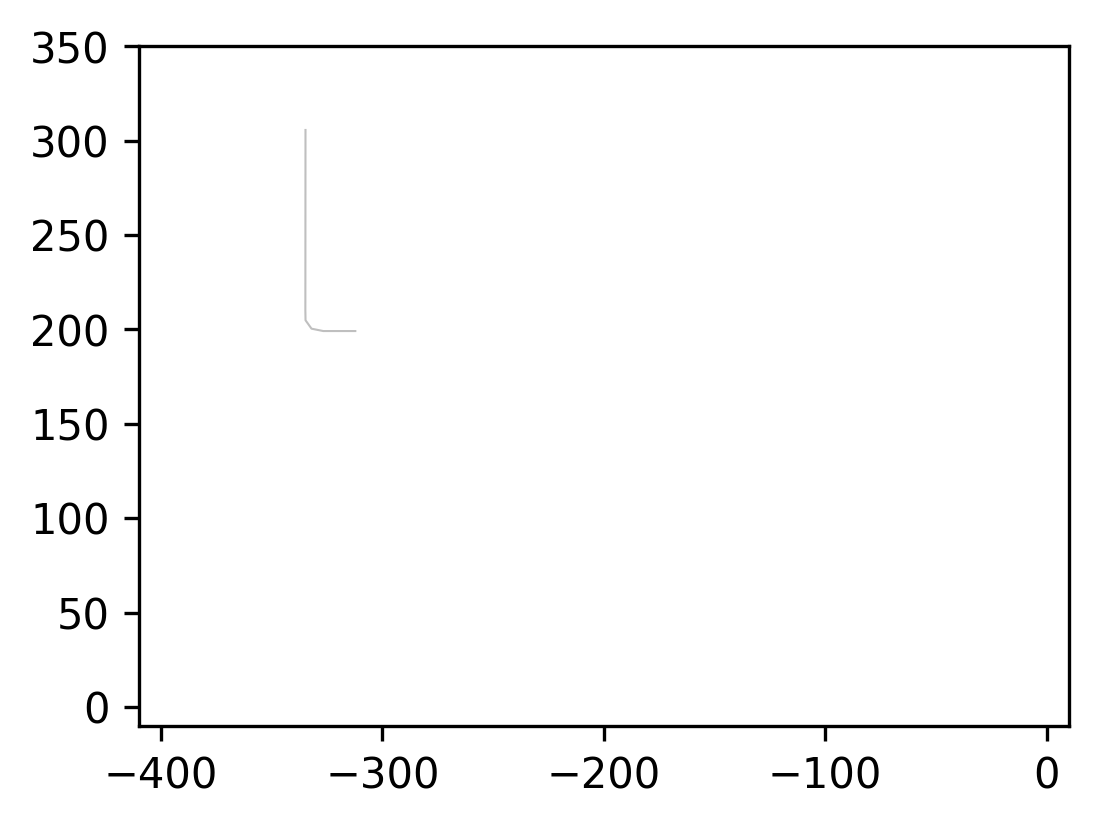

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_378.npy


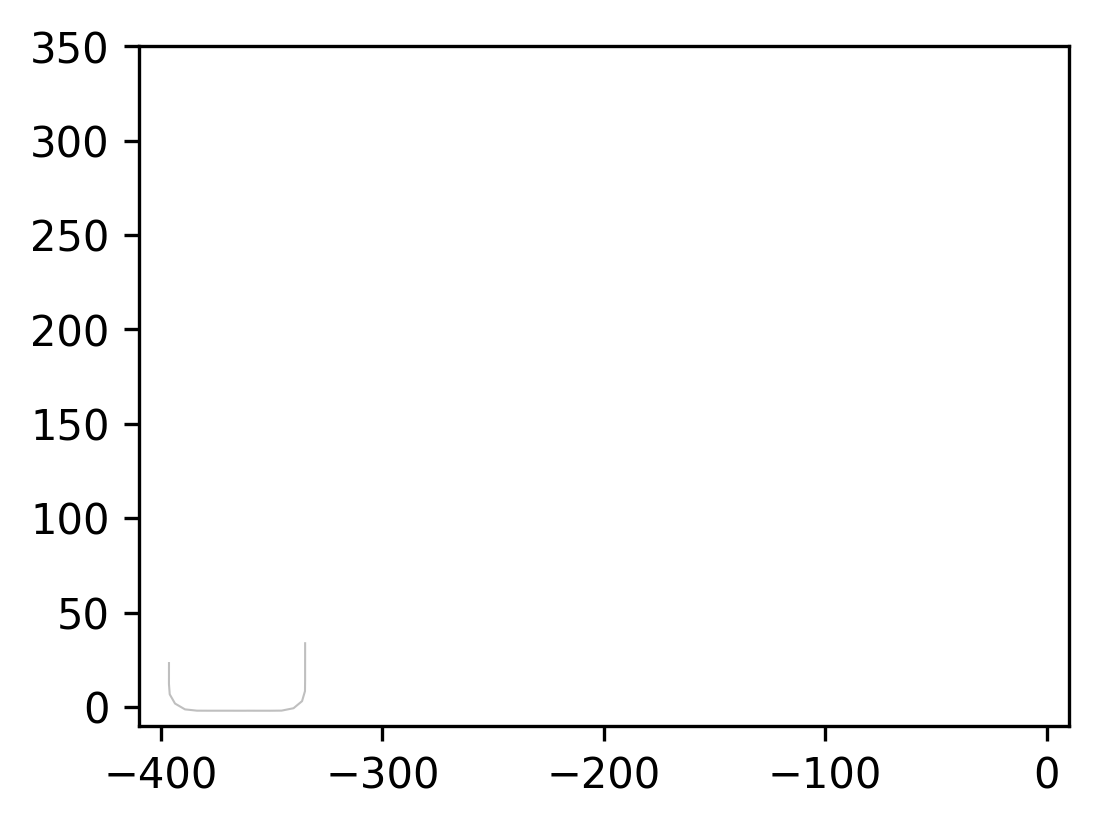

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_101.npy


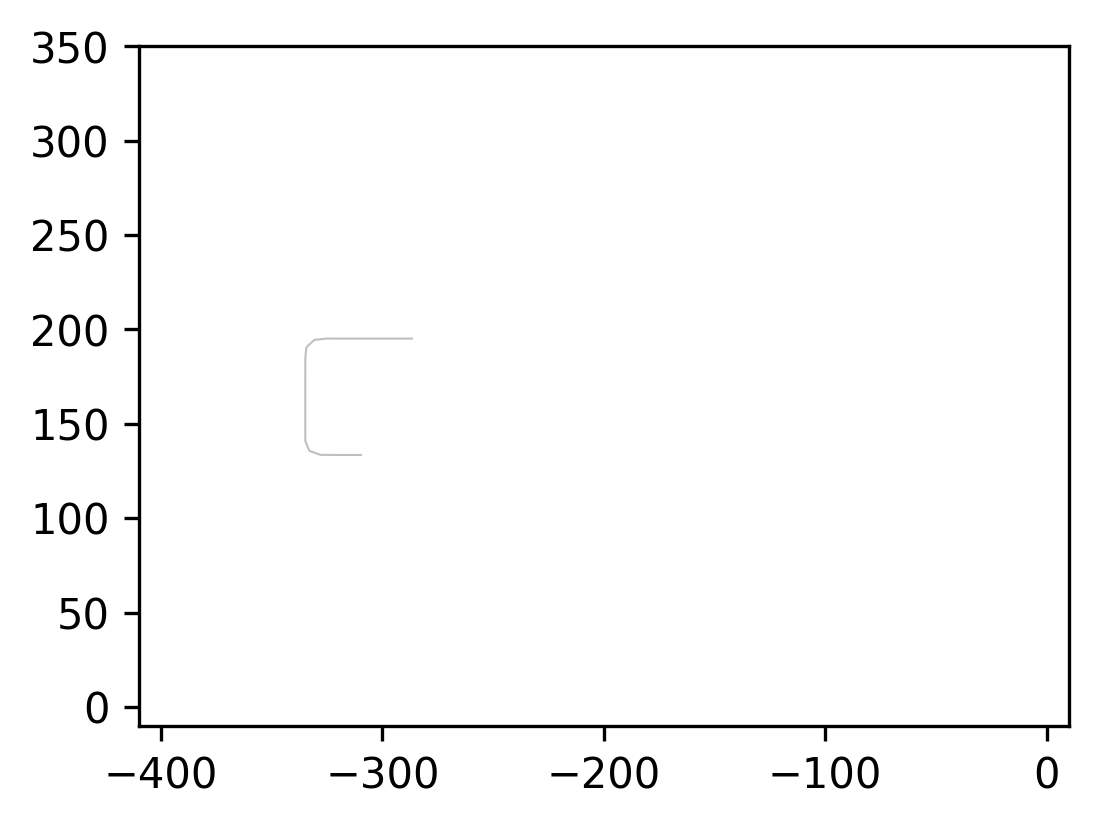

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_531.npy


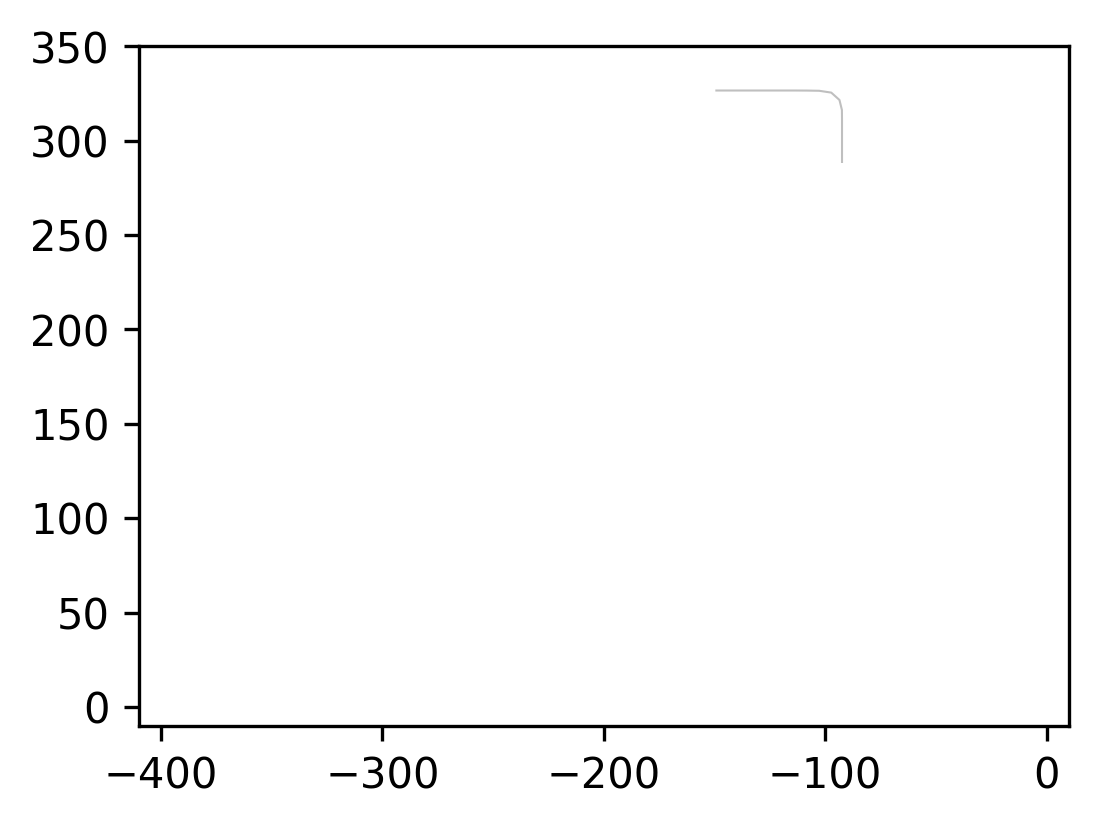

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_196.npy


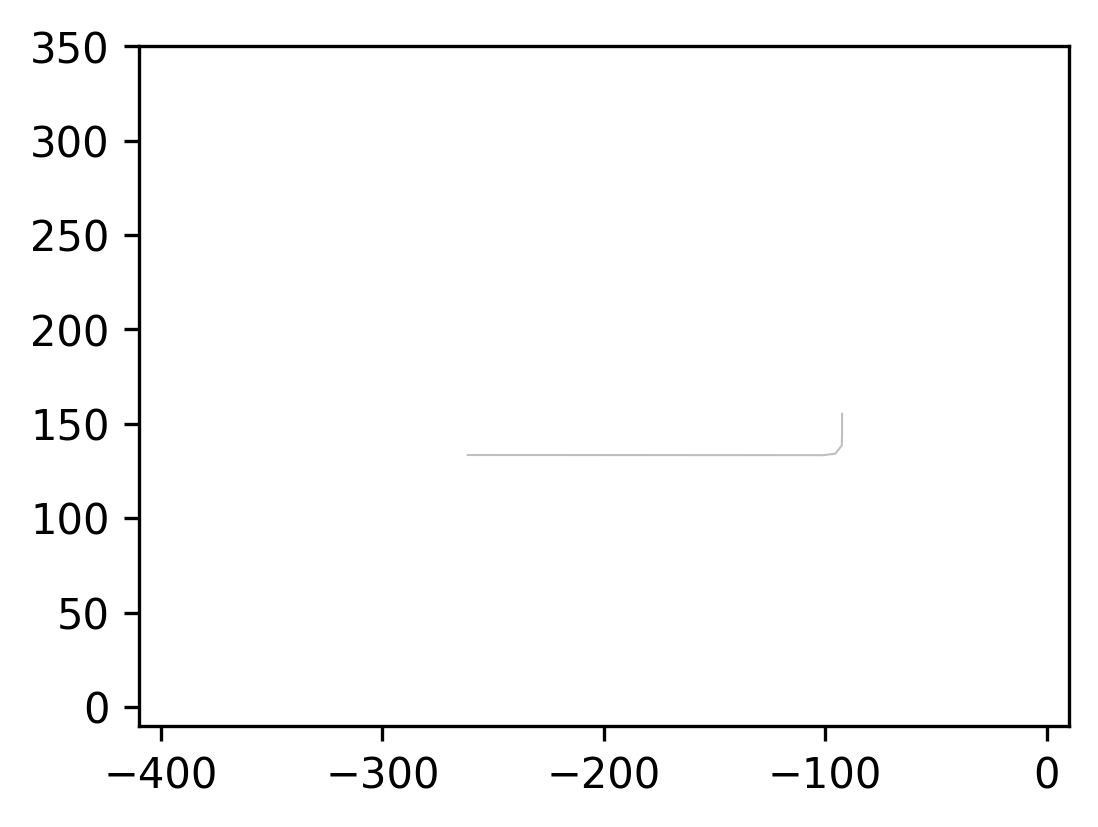

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_514.npy


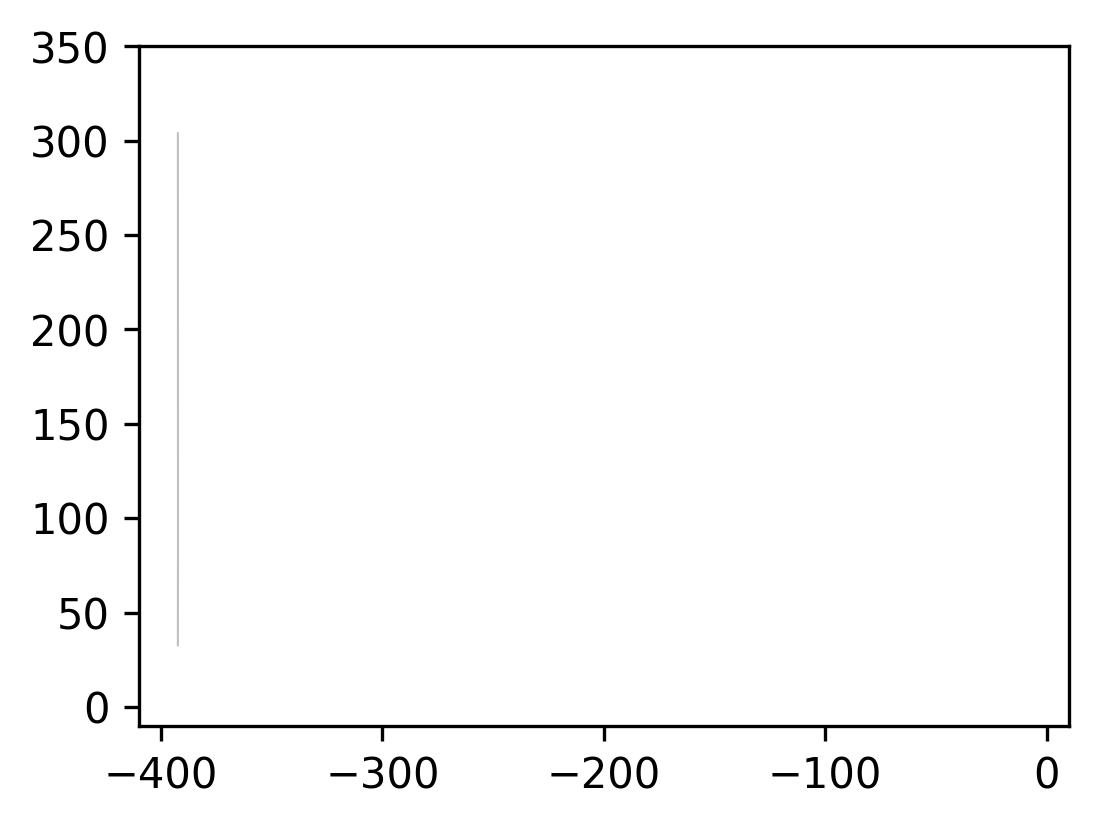

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_340.npy


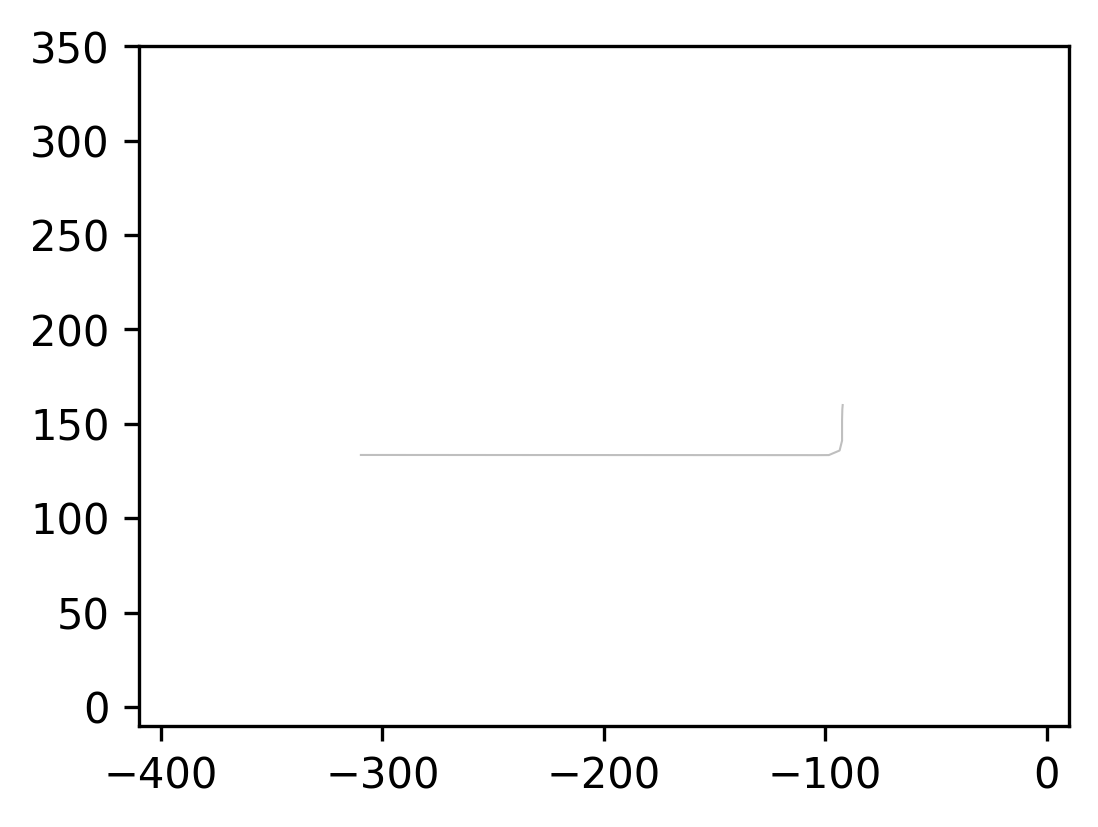

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_343.npy


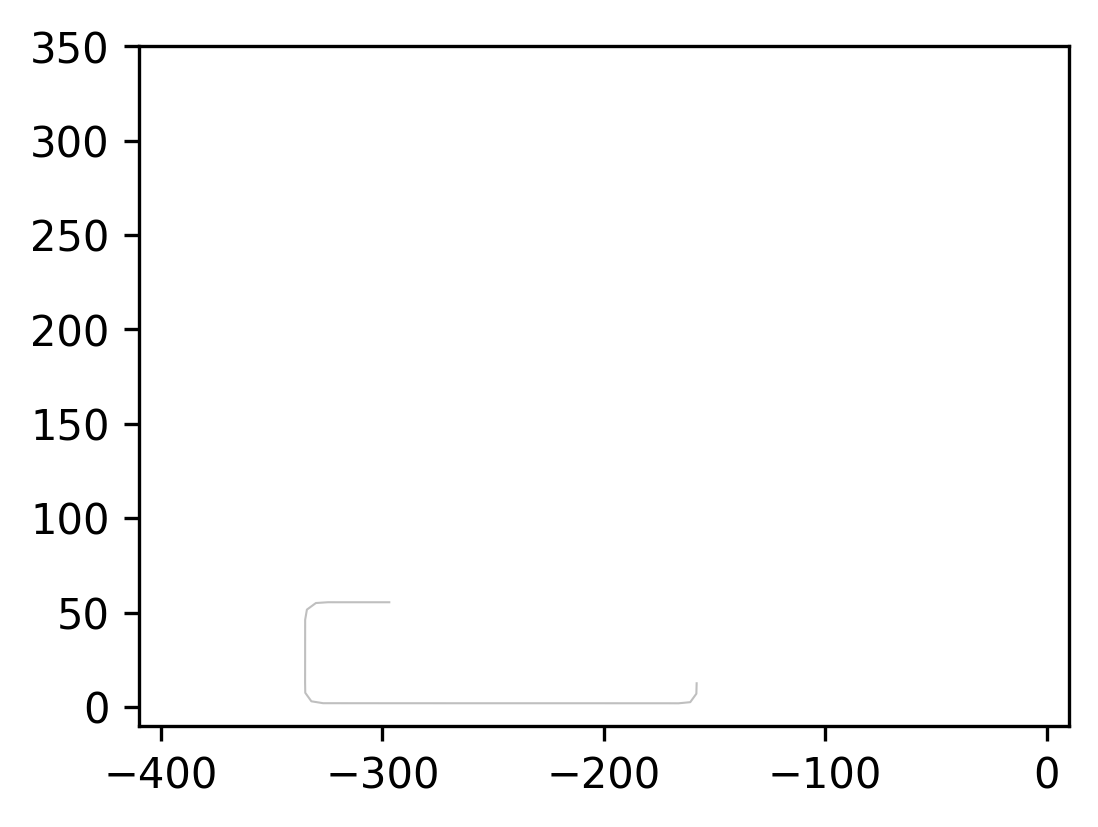

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_504.npy


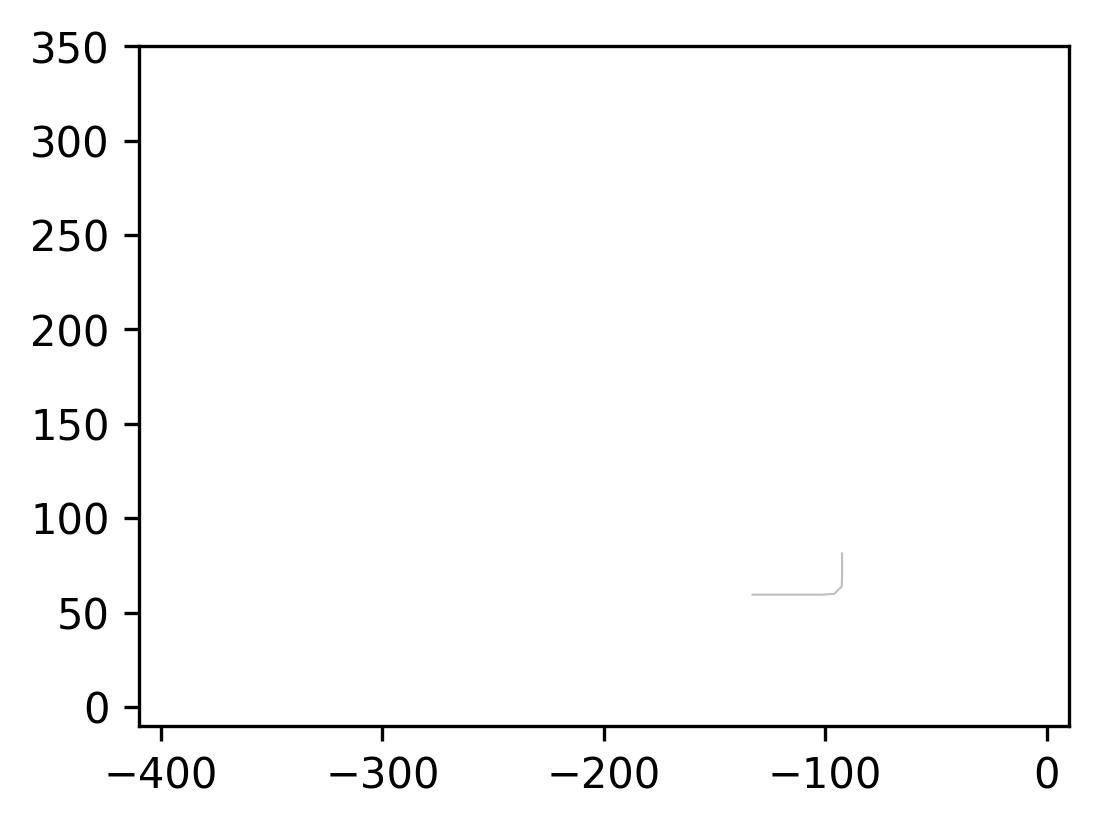

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_383.npy


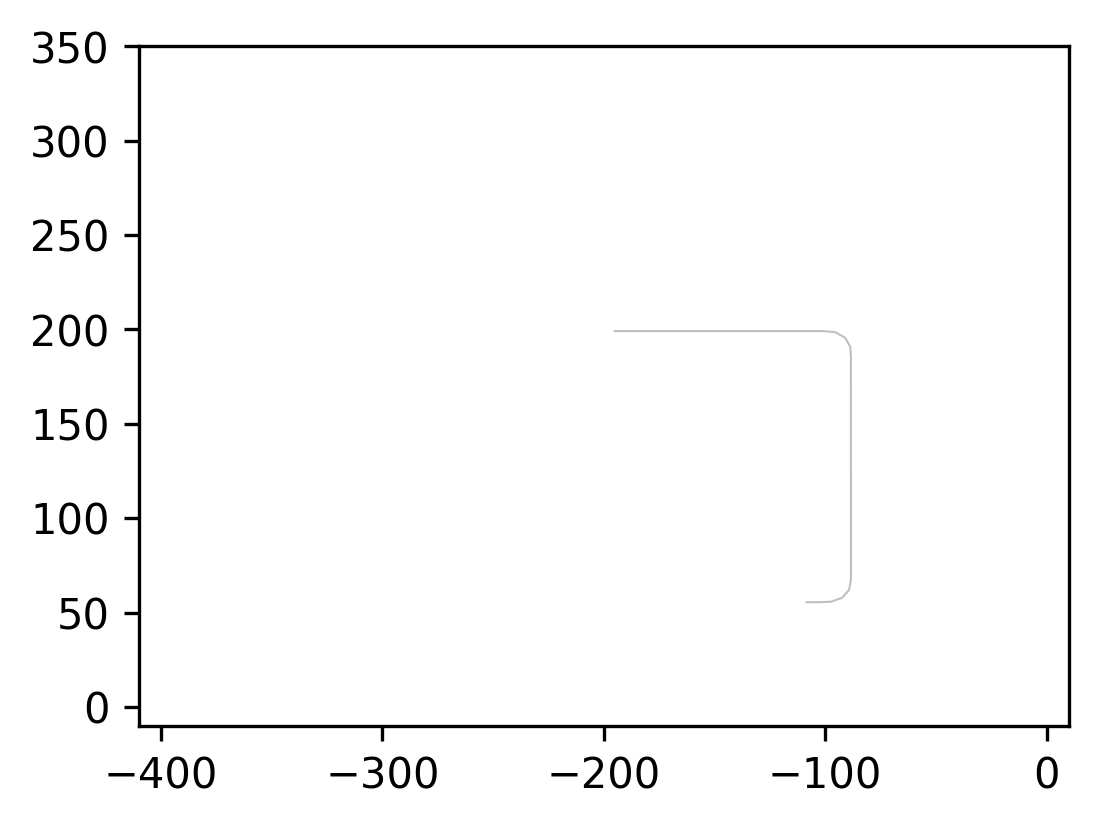

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_249.npy


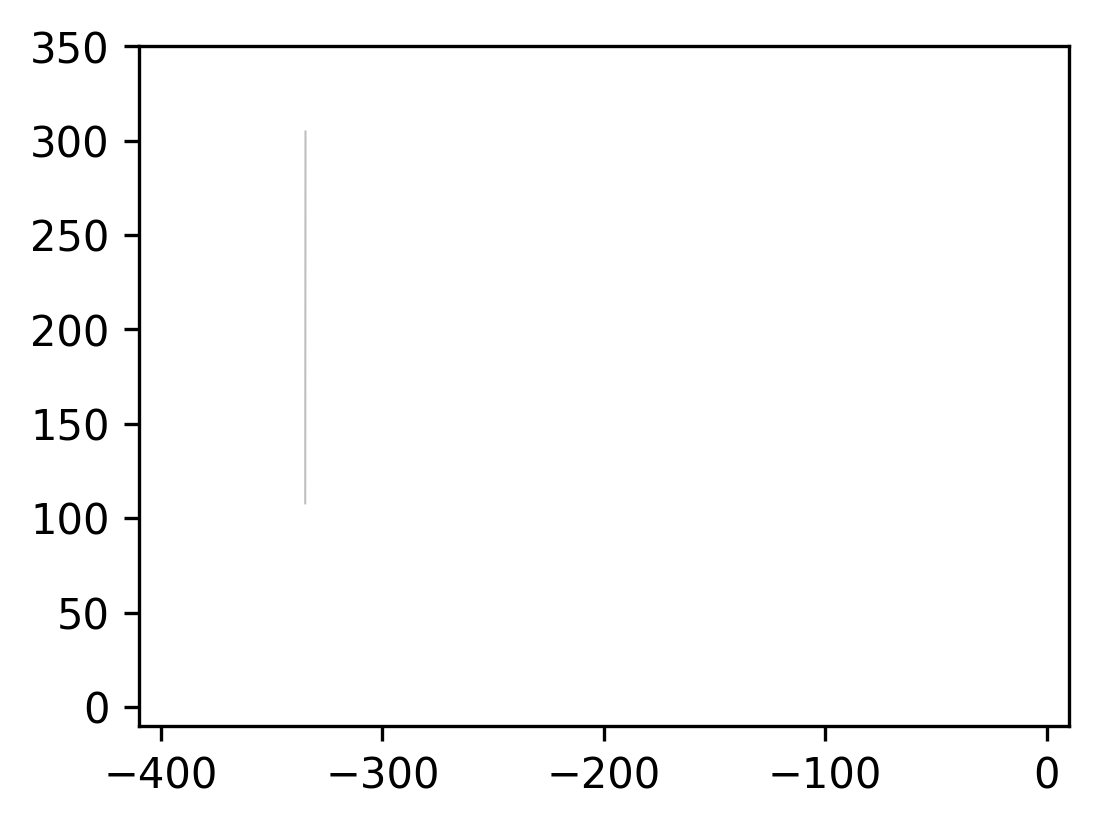

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_473.npy


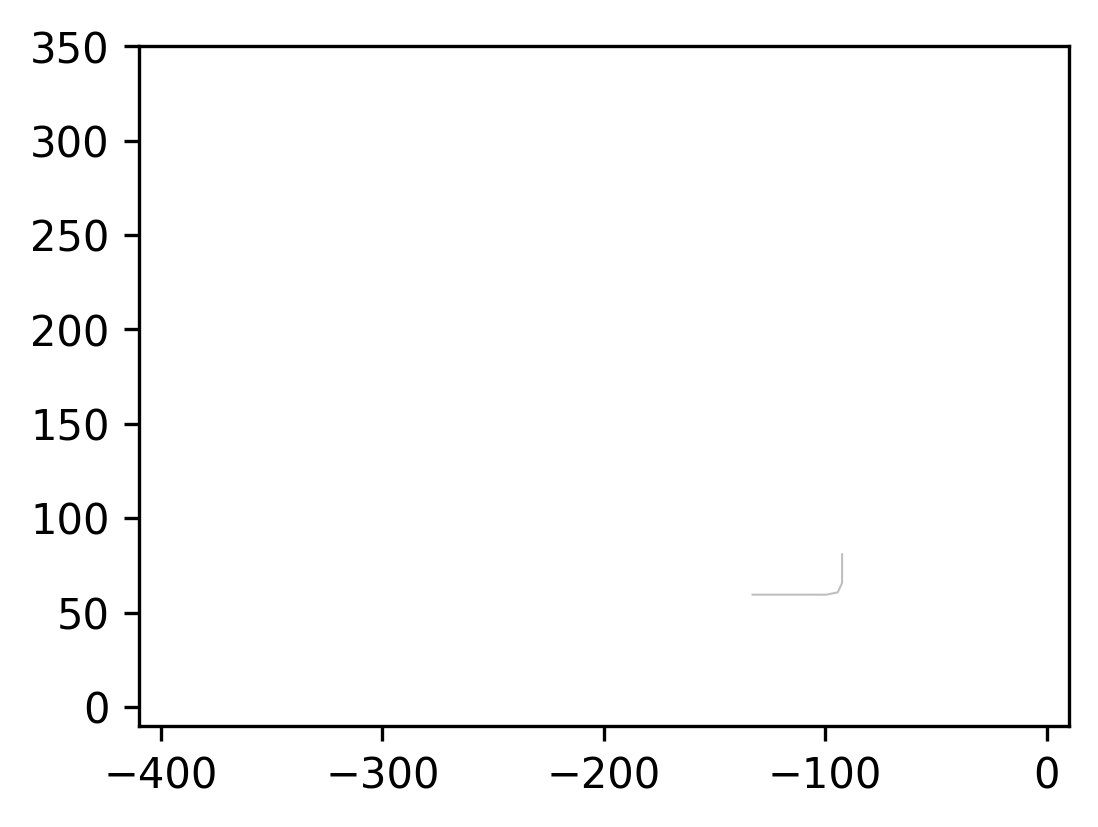

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_359.npy


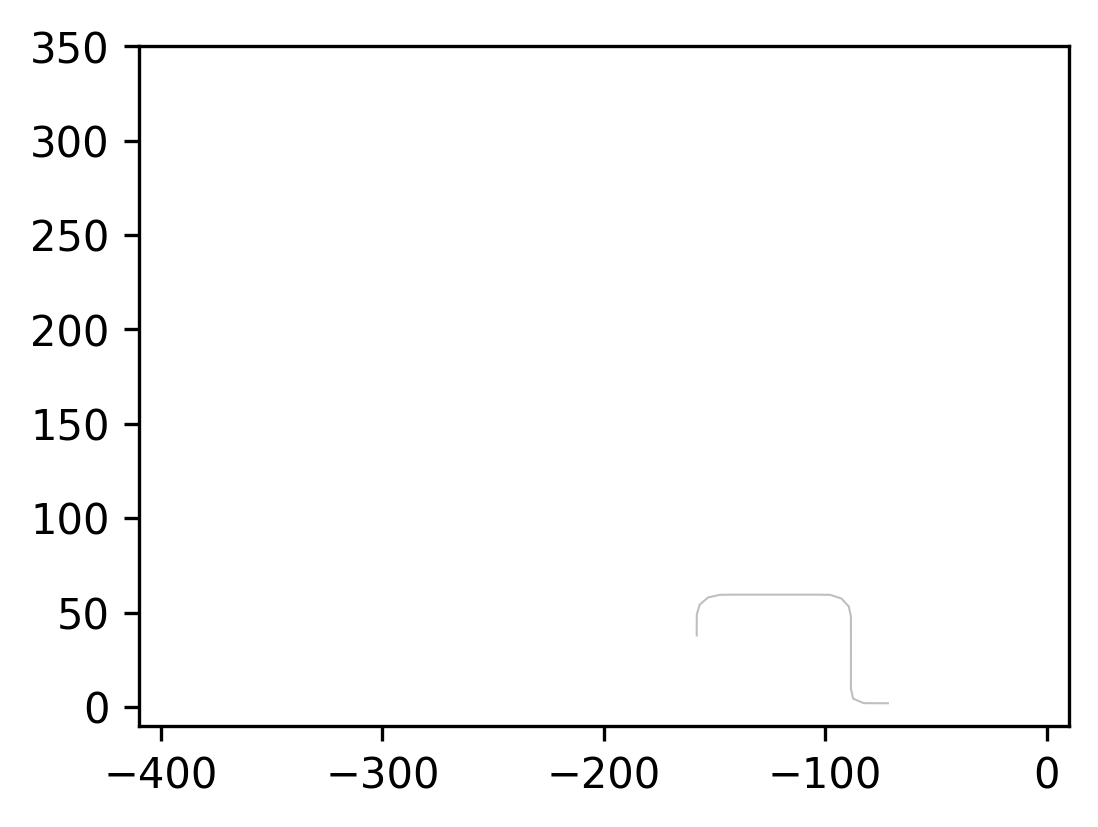

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_190.npy


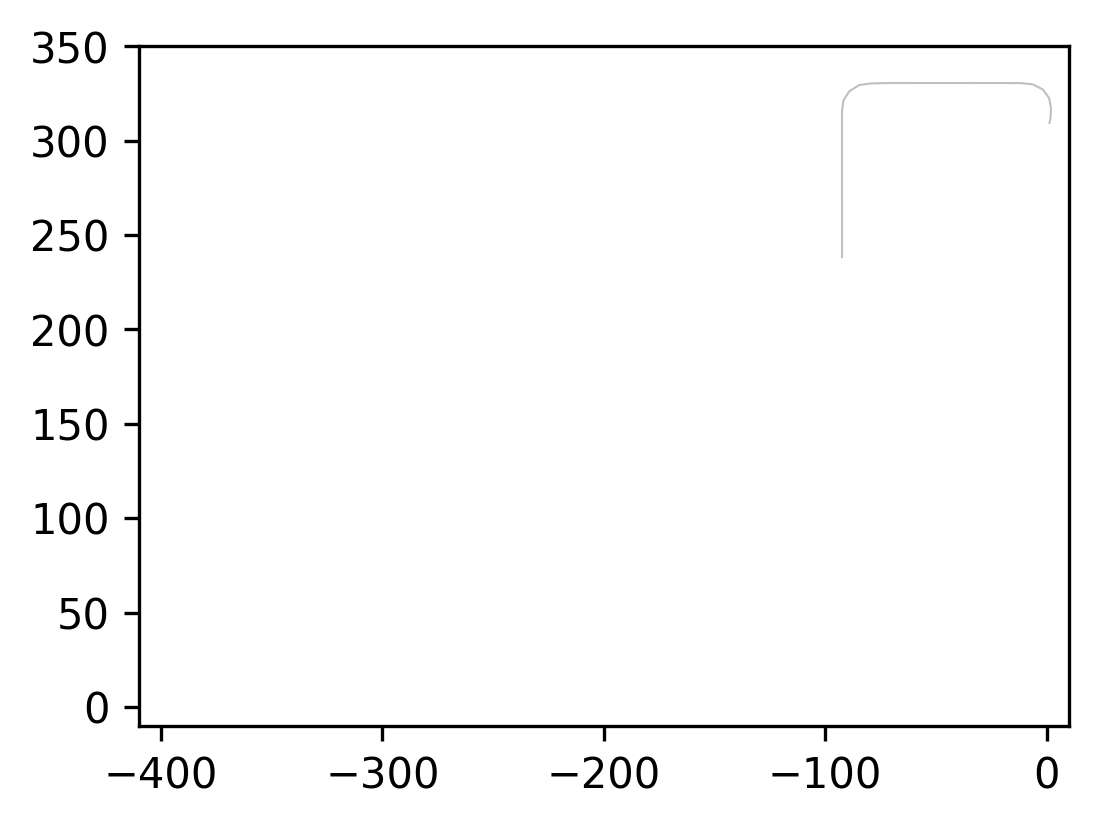

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_176.npy


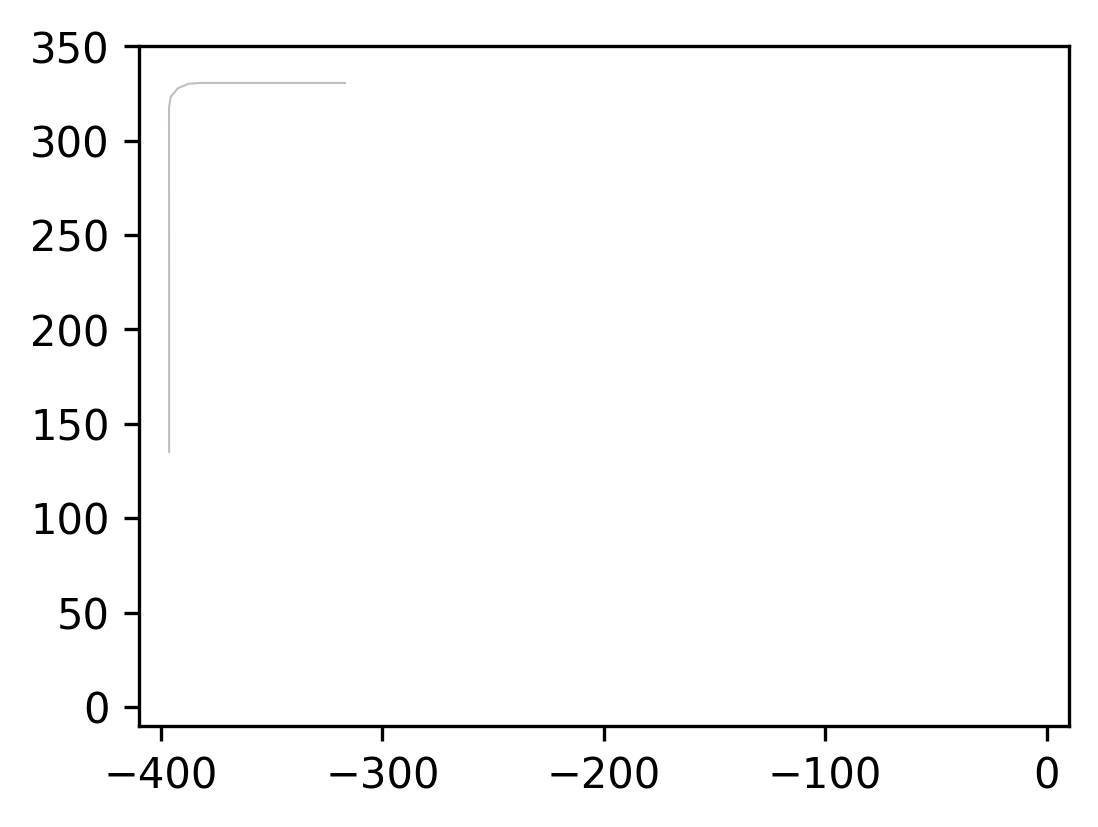

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_211.npy


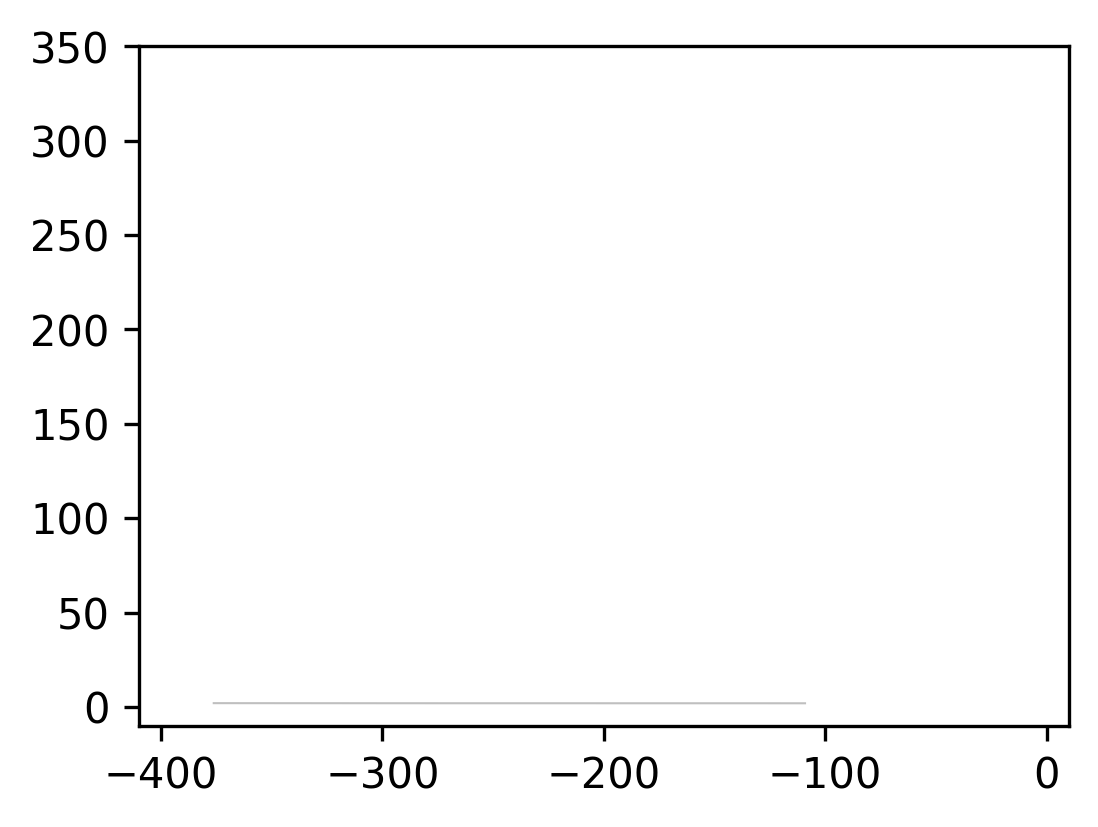

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_82.npy


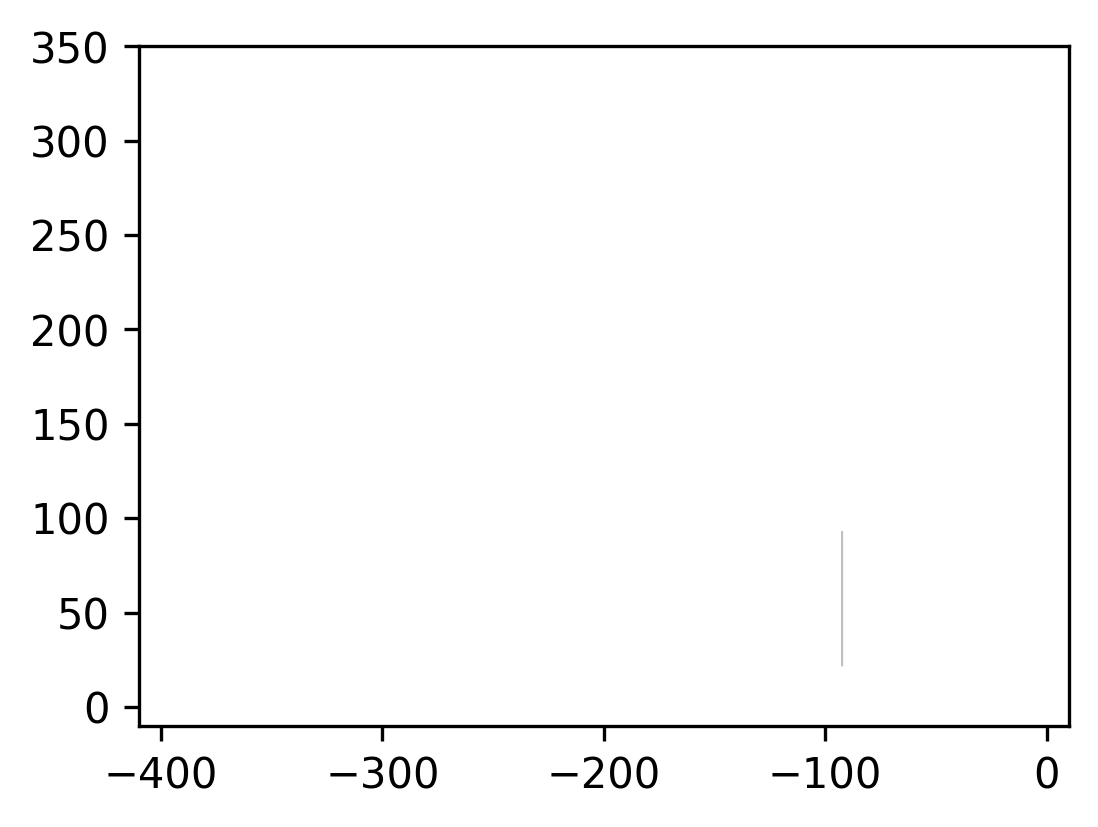

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_14.npy


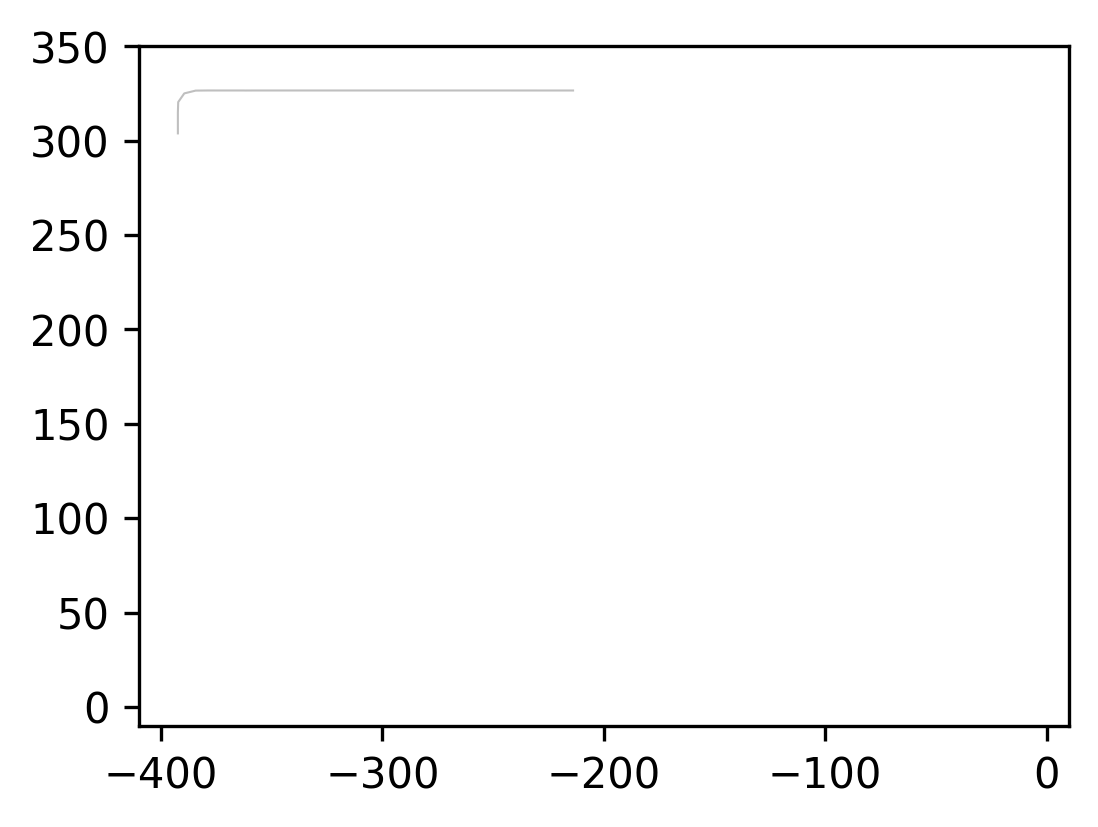

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_464.npy


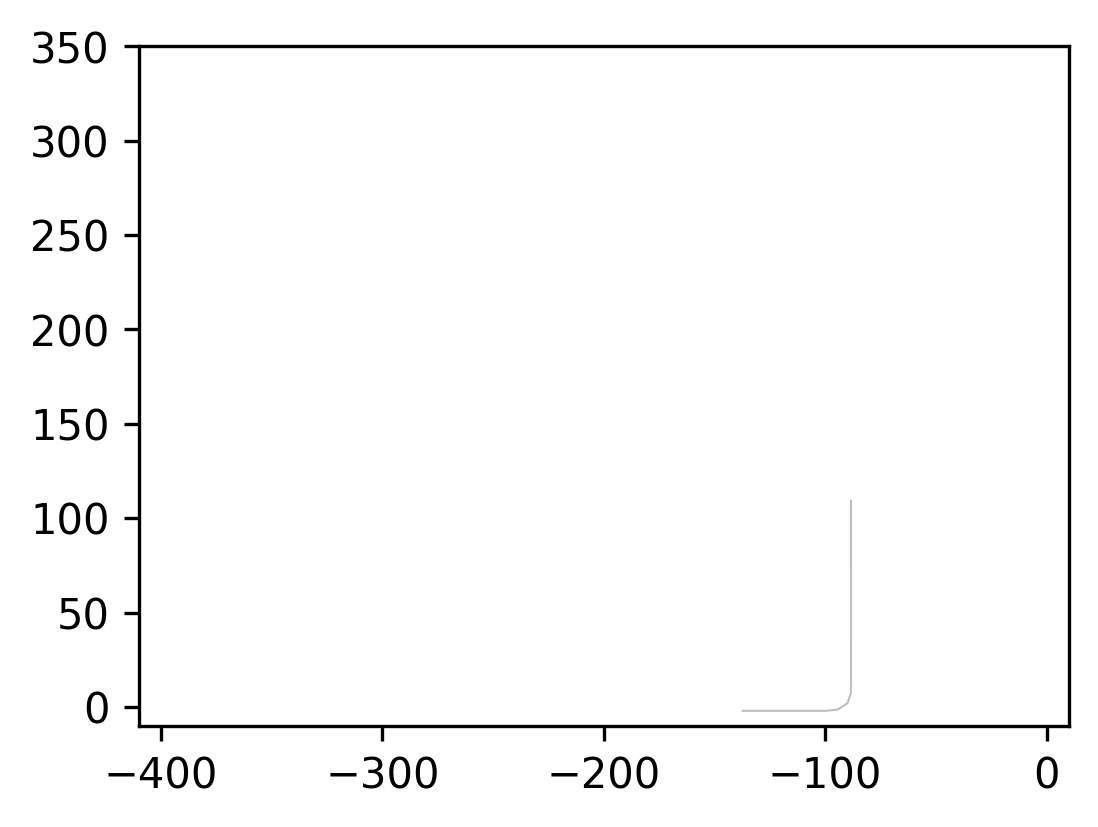

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_333.npy


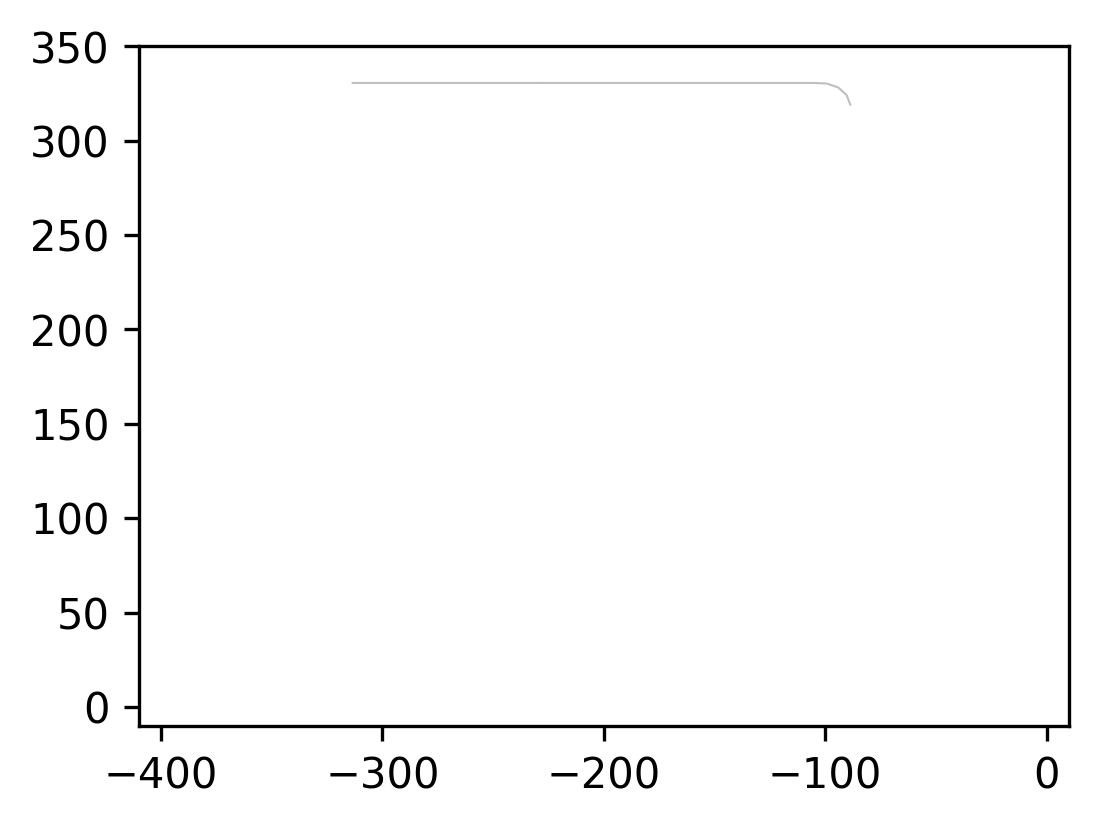

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_194.npy


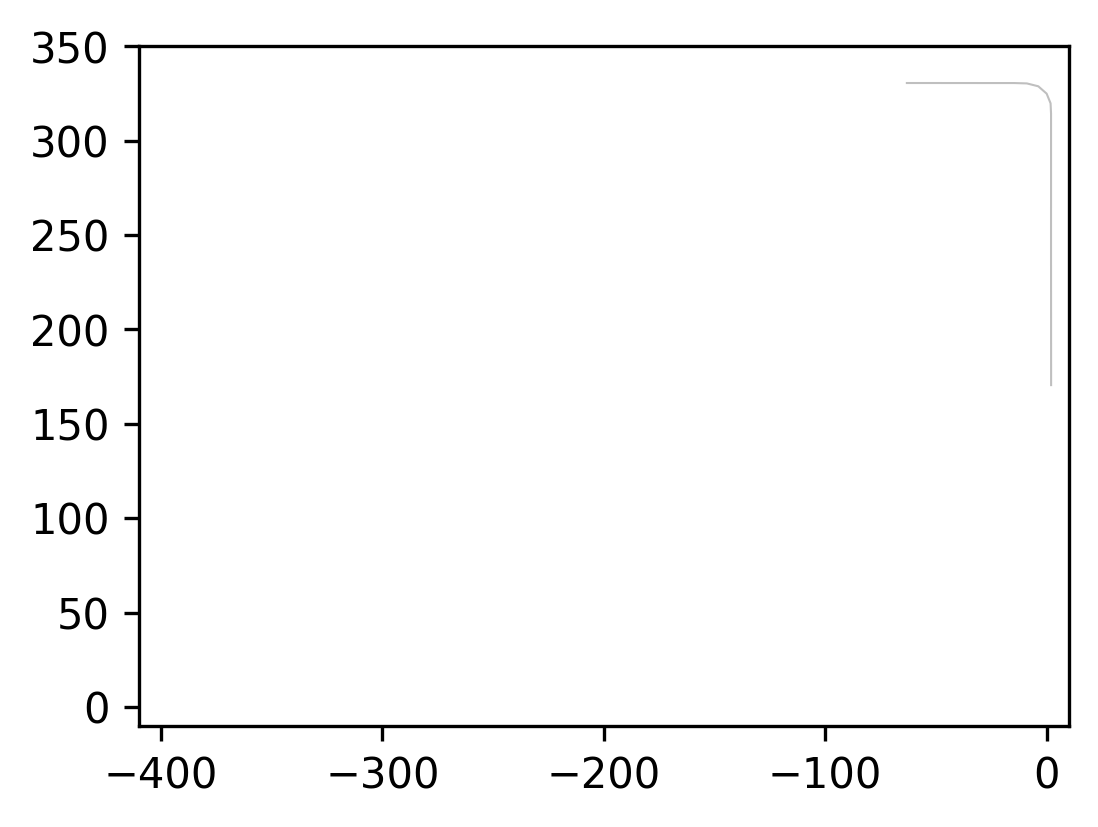

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_462.npy


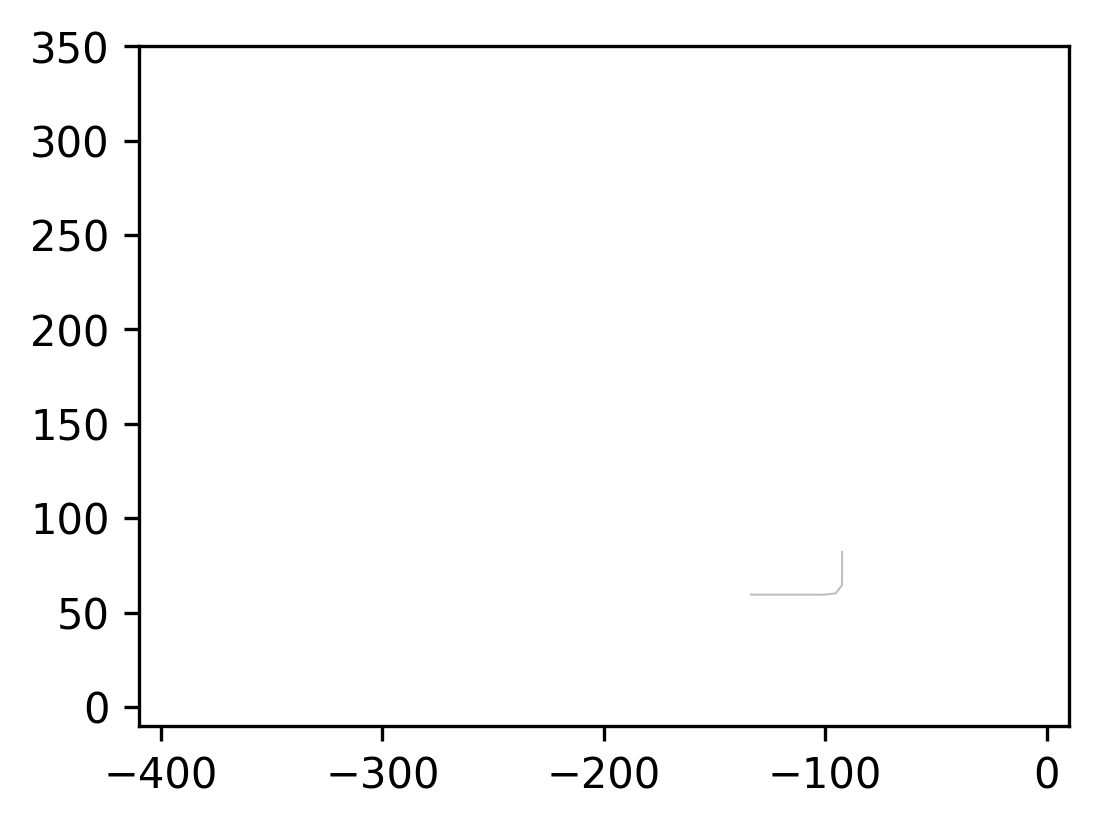

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/coords_210.npy


KeyboardInterrupt: 

In [113]:
path = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/')
ground_truth = {p:np.load(p)[:, :2] for p in path.glob("coords*npy")}
for k, v in ground_truth.items():
    plot_gt(v, k)